# KdV Uncertainty output

## Plots

Produce the following plots:
 - Example a0 and density profiles for one time step
 - Example of a time-series all A(t) for 1, 10, 500 runs
 - Timeseries of 'max_amplitude' all runs
 - Timeseries of normalized 'max_amplitude' all runs
 
---
Other plots for the paper/talks:
 - *Example of scenario A(x,t)* requires running a simulation...

In [1]:
import h5py
from glob import glob
import numpy as np
from datetime import datetime

import pandas as pd
import xarray as xr

from dask import array as da
from dask import delayed

from iwaves.utils import isw

import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar

plt.rcParams.update({'font.size': 18})

%matplotlib inline

# Test loading some data

Data are stored in individual hdf5 files for each step (1473) and each sample (500)

In [2]:
#sorted(glob("../../shiny_dashboard/data/timepoint-1/all_amplitudes/*.h5"))

def get_file_name(timepoint, sample):
    return "../../kdv_solutions_azure/shiny_dashboard/data/timepoint-%d/all_amplitudes/2018-07-24--13-00-34_timepoint-%d_sample-%d_output.h5"%(timepoint,timepoint,sample)

def get_all_file(timepoint):
    return sorted(glob("../../kdv_solutions_azure/shiny_dashboard/data/timepoint-%d/all_amplitudes/*.h5"%(timepoint)))

def get_summary_file(timepoint):
    return sorted(glob("../../kdv_solutions_azure/shiny_dashboard/data/timepoint-%d/*.h5"%(timepoint)))[0]
#get_file_name(1,0)
#get_all_file(1)
get_summary_file(1)

'../../kdv_solutions_azure/shiny_dashboard/data/timepoint-1/2018-07-24--13-00-34_slim-output.h5'

In [3]:
# Get the summary file for new amplitudes
datafiles = sorted(glob("../output/magnus/*.h5"))
get_new_summary_file = {}
for df in datafiles:
    tstep = int(df.split('_')[-2].split('-')[-1])
    get_new_summary_file.update({tstep:df})
    
#def get_new_summary_file(timepoint):
#
#    return filedict[tstep]
get_new_summary_file[20]

'../output/magnus/2018-10-31--17-09-00_timepoint-20_output.h5'

In [6]:
h5 = h5py.File(get_new_summary_file[1],'r')
list(h5.keys())

['a0_samples',
 'beta_samples',
 'max_amplitude',
 'max_u_seabed',
 'max_u_surface',
 'timepoint']

In [7]:
h5['a0_samples'][:].shape

(500,)

In [8]:
h5['beta_samples'][:].shape

(6, 500)

In [9]:
h5['max_amplitude'].value.shape

(500,)

In [10]:
#h5['amplitudes'].shape

# Data loading tools

In [11]:
#@delayed(nout=1)
def load_h5_step_old(varname, timepoint):
    nsamples = 500

    a0 = []
    for ii in range(nsamples):
        try:
            h5 = h5py.File(get_file_name(timepoint,ii),'r')
            a0.append(da.from_array( h5[varname].value, chunks=-1))
            h5.close()
        except:
            continue
            #print('Failed to load sample %d...'%ii)
    
    if len(a0) == 0:
        print('No files found for step %d'%timepoint)
    a0_da = da.stack(a0)

    return a0_da

def load_h5_step(varname, timepoint):
    files = get_all_file(timepoint)
    nsamples = len(files)

    a0 = []
    for ii in range(nsamples):
        h5 = h5py.File(files[ii],'r')
        a0.append(da.from_array( h5[varname].value, chunks=-1))
        h5.close()

    a0_da = da.stack(a0)

    return a0_da

def load_h5_step_slim(varname, timepoint):
    file = get_new_summary_file[timepoint]
    print(file)

    h5 = h5py.File(file,'r')
    a0 = da.from_array( h5[varname].value, chunks=-1)
    h5.close()

    return a0



@delayed(nout=1)
def load_h5_alltime(varname, maxpoints):

    a0 = []
    for ii in range(maxpoints):
        a0_da = load_h5_step(varname, ii)
        a0.append(a0_da)
        
    #a0_t = da.stack(a0, axis=0)
    
    return a0

def return_a0_beta(timestep, ensemble):
    h5 = h5py.File(get_summary_file(timestep),'r')
    a0 = h5['a0_samples'][ensemble]
    beta = h5['beta_samples'][:,ensemble]
    h5.close()
    
    return a0, beta

def return_max_ensemble(timestep):
    h5 = h5py.File(get_summary_file(timestep),'r')
    a0 = h5['max_amplitude'][:]
    h5.close()
    
    return np.argwhere(np.abs(a0) == np.abs(a0).max())[0,0]
#amp, beta, a0 = load_h5_step(1)

return_max_ensemble(1)

160

In [12]:
tstep = 50
#a0 = load_h5_step('a0_sample', tstep).compute()
#beta = load_h5_step('beta_samples', tstep).compute()
#amax = load_h5_step('max_amplitude', tstep).compute()
a0 = load_h5_step_slim('a0_samples',1001).compute()
a0.max()
#a0 = load_h5_alltime('beta_samples',10)
#a0 = a0.compute()
#beta = beta.compute()

../output/magnus/2018-11-01--00-13-42_timepoint-1001_output.h5


26.631596660577202

# Load the raw csv data

In [13]:
def convert_time(tt):
    try:
        dt= datetime.strptime(tt, '%Y-%m-%dT%H:%M:%S')
    except:
        dt= datetime.strptime(tt, '%Y-%m-%d %H:%M')
    return dt

def read_density_csv(csvfile):
    # Reads into a dataframe object
    df = pd.read_csv(csvfile, index_col=0, sep=', ', parse_dates=['Time'], date_parser=convert_time)

    # Load the csv data
    depths= np.array([float(ii) for ii in df.columns.values])
    rho_obs_tmp = df[:].values.astype(float)
    time = df.index[:]

    # Clip the top
    rho_obs_2d = rho_obs_tmp[:,:]

    # Remove some nan
    fill_value = 1024.
    rho_obs_2d[np.isnan(rho_obs_2d)] = fill_value
    
    return xr.DataArray(rho_obs_2d,dims=('time', 'depth'),
            coords={'time':time.values,'depth':depths})



In [14]:
datadir = '../../run_ddcurves/'
datafile1 = '%s/DATA_QC/Crux_KP150_Phs1_Density_lowpass'%datadir
datafile2 = '%s/DATA_QC/Crux_KP150_Phs2_Density_lowpass'%datadir
sitename = 'CRUX'

rho1 = read_density_csv('%s.csv'%datafile1)
rho2 = read_density_csv('%s.csv'%datafile2)

rho = xr.concat([rho1,rho2], dim='time')
rho

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


<xarray.DataArray (time: 1481, depth: 12)>
array([[1026.1856, 1025.8925, 1025.7143, ..., 1021.5415,       nan, 1021.0069],
       [1026.1849, 1025.8863, 1025.7151, ..., 1021.3722,       nan, 1021.0062],
       [1026.1869, 1025.8835, 1025.7203, ..., 1021.2284,       nan, 1021.0056],
       ...,
       [1026.0198, 1025.7399, 1025.5525, ..., 1021.5754, 1021.5571, 1021.5513],
       [1026.0087, 1025.7564, 1025.5539, ..., 1021.5695, 1021.5503, 1021.544 ],
       [1026.017 , 1025.7993, 1025.583 , ..., 1021.6404, 1021.6203, 1021.6138]])
Coordinates:
  * depth    (depth) float64 -250.5 -227.8 -203.6 -179.4 ... -34.2 -11.7 -9.7
  * time     (time) datetime64[ns] 2016-04-29T23:15:00 ... 2017-05-06T12:40:00

# Plot of some initial conditions for one scenario

In [15]:
def double_tanh(beta, z):
    
    return beta[0] - beta[1]*(np.tanh((z+beta[2])/beta[3])
                + np.tanh((z+beta[4])/beta[5]))

In [16]:
# Depth
zmin = -250
zout = np.linspace(zmin,0,100)

Text(0,0.5,'Count')

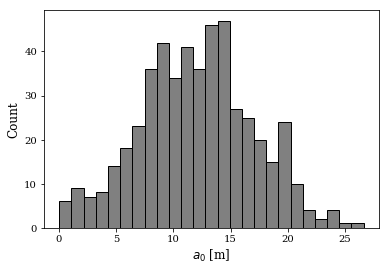

In [17]:
plt.figure()
plt.hist(a0,bins=25, color='0.5', edgecolor='k')
plt.xlabel('$a_0$ [m]')
plt.ylabel('Count')

In [18]:
# Plot the density profile
plt.figure(figsize=(5,6))
nsamples = 500
for rand_loc in range(0, nsamples):
    rhotmp = double_tanh(beta[rand_loc,:], zout)
    plt.plot(rhotmp, zout, '0.5', lw=1, alpha=0.02)
    
#plt.plot(rhomean*RHO0, zout, 'k--',) # Mean fit

plt.grid(b=True)
plt.ylim(zmin,0 )
plt.ylabel('Depth [m]')
plt.xlabel(r'$\rho$ [kg m$^{-3}$]')
#plt.title(rho.time.values[tstep])

NameError: name 'beta' is not defined

In [19]:
# Calculate alpha, cn for a time step

def calc_alpha(beta, zout, nsamples=500, mode=0):
    
    alpha_ens = np.zeros((nsamples,))
    c_ens = np.zeros((nsamples,))

    dz = np.diff(zout).mean()
    
    for ii in range(nsamples):
        rhotmp = double_tanh(beta[ii,:], zout)

        N2 = -9.81/1000*np.gradient(rhotmp,dz)

        phi,cn = isw.iwave_modes(N2, dz)

        phi_1 = phi[:,mode]
        phi_1 =phi_1 / np.abs(phi_1).max()
        phi_1 *= np.sign(phi_1.sum())

        alpha = isw.calc_alpha(phi_1, cn[mode],N2,dz)

        alpha_ens[ii] = alpha
        c_ens[ii] = cn[mode]
        
    return alpha_ens, c_ens

In [ ]:
alpha, cn = calc_alpha(beta, zout)

T = 12.42*3600.
omega = 2*np.pi / T
Ls = cn**2. / (np.abs(alpha)*a0*omega) 
Ls

In [ ]:
plt.figure()
plt.subplot(131)
plt.hist(alpha,bins=np.arange(-0.012,0.01205,0.0005), color='0.5', edgecolor='k')
plt.xlabel(r'$\alpha$ []')
plt.ylabel('Count')

plt.subplot(132)
plt.hist(cn,bins=np.arange(0.9,1.3,0.005), color='0.5', edgecolor='k')
plt.xlabel(r'$c$ [m s]')

plt.subplot(133, xscale='log')
plt.hist(Ls,bins=np.arange(10e3,1000000,10e3), color='0.5', edgecolor='k')
plt.xlabel(r'$Ls$ [m]')
#plt.ylabel('Count')

In [ ]:
plt.figure()
plt.subplot(121)
plt.hist(amax,bins=np.arange(-100,105,5), color='0.5', edgecolor='k')
plt.xlabel(r'$A_{max}$ [m]')
plt.ylabel('Count')

plt.subplot(122)
plt.hist(amax/a0,bins=np.arange(-3.5,3.55,0.05), color='0.5', edgecolor='k')
plt.xlabel(r'$A_{max}/a0$')
plt.xlim(-3.5,3.5)


In [ ]:
L = 1e5 # Location of output point

plt.semilogx(Ls/L, amax/a0, 'k.')
plt.xlim(1e-1,10)
plt.ylim(-4,4)
plt.grid(b=True)

plt.ylabel(r'$A_{max}/a0$')
plt.xlabel('$L_s / L$')


In [ ]:
# Plot the amplitudes for all runs
amp = load_h5_step('amplitudes', tstep).compute()# Amplitudes are stored from last to first

dt = 20
nt = amp.shape[1]
time = np.arange(0,nt)*dt

In [ ]:
plt.figure(figsize=(5,4))
nsamples = 500
for rand_loc in range(0, nsamples):
    plt.plot(time/T, amp[rand_loc,:], '0.5', lw=0.5, alpha=0.05)
    
#plt.plot(rhomean*RHO0, zout, 'k--',) # Mean fit

plt.grid(b=True)
plt.ylim(-100,100 )
plt.xlim(1.5,3)
plt.ylabel('Amplitude [m]')
plt.xlabel(r'time [cycles]')

In [20]:
# Get amax/a0 for all steps
nt = 1473
nsamples = 500
amax_t = np.zeros((nsamples,nt))
ubed_max_t = np.zeros((nsamples,nt))
usurf_max_t = np.zeros((nsamples,nt))

a0_t = np.zeros((nsamples,nt))
alpha_t = np.zeros((nsamples,nt))
cn_t = np.zeros((nsamples,nt))
beta_t = np.zeros((nt, nsamples,6))

In [21]:
for ii in tqdm(range(0,nt)):
    try:
        a0_tmp = load_h5_step_slim('a0_samples', ii+1).compute()
        amax_tmp = load_h5_step_slim('max_amplitude', ii+1).compute()
        ubed_tmp = load_h5_step_slim('max_u_seabed', ii+1).compute()
        usurf_tmp = load_h5_step_slim('max_u_surface', ii+1).compute()
        beta_tmp = load_h5_step_slim('beta_samples', ii+1).compute()

        ns = a0_tmp.shape[0]
        if ns < 500:
            print('Only found %d sample for step %d'%(ns,ii))
        alpha_tmp, c_tmp = calc_alpha(beta_tmp.T, zout, nsamples=ns, mode=0)    

        print(a0_tmp.max())
        a0_t[0:ns,ii] = a0_tmp
        amax_t[0:ns,ii] = amax_tmp
        ubed_max_t[0:ns,ii] = ubed_tmp
        usurf_max_t[0:ns,ii] = usurf_tmp
        alpha_t[0:ns,ii] = alpha_tmp
        cn_t[0:ns,ii] = c_tmp

        beta_t[ii,0:ns,:] = beta_tmp.T
    except:
        print('Timestep %d failed to load data'%(ii))



    #    ngood = a0_tmp.shape[0]
    #    
    #    a0_t[0:ngood,ii] = a0_tmp
    #    amax_t[0:ngood:,ii] = amax_tmp
    #except:
    #    print('Failed to load step %d...'%ii)

  0%|          | 0/1473 [00:00<?, ?it/s]

../output/magnus/2018-10-31--17-09-00_timepoint-1_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-1_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-1_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-1_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-1_output.h5


  0%|          | 1/1473 [00:05<2:16:01,  5.54s/it]

24.692574885839274
../output/magnus/2018-10-31--17-09-00_timepoint-2_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-2_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-2_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-2_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-2_output.h5


  0%|          | 2/1473 [00:10<2:07:39,  5.21s/it]

22.516028517327783
../output/magnus/2018-10-31--17-09-00_timepoint-3_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-3_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-3_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-3_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-3_output.h5


  0%|          | 3/1473 [00:15<2:05:28,  5.12s/it]

24.97510829229608
../output/magnus/2018-10-31--17-09-00_timepoint-4_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-4_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-4_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-4_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-4_output.h5


  0%|          | 4/1473 [00:20<2:05:18,  5.12s/it]

23.390822972533797
../output/magnus/2018-10-31--17-09-00_timepoint-5_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-5_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-5_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-5_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-5_output.h5


  0%|          | 5/1473 [00:25<2:03:19,  5.04s/it]

23.0810417348415
../output/magnus/2018-10-31--17-09-00_timepoint-6_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-6_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-6_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-6_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-6_output.h5


  0%|          | 6/1473 [00:29<2:01:57,  4.99s/it]

28.89806628444631
../output/magnus/2018-10-31--17-09-00_timepoint-7_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-7_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-7_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-7_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-7_output.h5


  0%|          | 7/1473 [00:34<2:00:54,  4.95s/it]

25.900617697206812
../output/magnus/2018-10-31--17-09-00_timepoint-8_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-8_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-8_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-8_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-8_output.h5


  1%|          | 8/1473 [00:39<2:00:08,  4.92s/it]

23.150640426882475
../output/magnus/2018-10-31--17-09-00_timepoint-9_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-9_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-9_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-9_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-9_output.h5


  1%|          | 9/1473 [00:44<1:59:30,  4.90s/it]

26.96575654475501
../output/magnus/2018-10-31--17-09-00_timepoint-10_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-10_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-10_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-10_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-10_output.h5


  1%|          | 10/1473 [00:48<1:58:57,  4.88s/it]

30.760853579960678
../output/magnus/2018-10-31--17-09-00_timepoint-11_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-11_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-11_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-11_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-11_output.h5


  1%|          | 11/1473 [00:53<1:58:21,  4.86s/it]

32.33582814112992
../output/magnus/2018-10-31--17-09-00_timepoint-12_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-12_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-12_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-12_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-12_output.h5


  1%|          | 12/1473 [00:58<1:58:12,  4.85s/it]

29.340472410364967
../output/magnus/2018-10-31--17-09-00_timepoint-13_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-13_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-13_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-13_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-13_output.h5


  1%|          | 13/1473 [01:03<1:58:52,  4.89s/it]

33.999715562341294
../output/magnus/2018-10-31--17-09-00_timepoint-14_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-14_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-14_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-14_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-14_output.h5


  1%|          | 14/1473 [01:09<1:59:53,  4.93s/it]

28.719692118779363
../output/magnus/2018-10-31--17-09-00_timepoint-15_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-15_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-15_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-15_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-15_output.h5


  1%|          | 15/1473 [01:13<1:59:40,  4.92s/it]

28.779657448721608
../output/magnus/2018-10-31--17-09-00_timepoint-16_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-16_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-16_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-16_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-16_output.h5


  1%|          | 16/1473 [01:19<2:00:06,  4.95s/it]

34.28158311620571
../output/magnus/2018-10-31--17-09-00_timepoint-17_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-17_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-17_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-17_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-17_output.h5


  1%|          | 17/1473 [01:24<2:00:30,  4.97s/it]

30.404656695459657
../output/magnus/2018-10-31--17-09-00_timepoint-18_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-18_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-18_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-18_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-18_output.h5


  1%|          | 18/1473 [01:29<2:01:06,  4.99s/it]

32.516228939727185
../output/magnus/2018-10-31--17-09-00_timepoint-19_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-19_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-19_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-19_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-19_output.h5


  1%|▏         | 19/1473 [01:35<2:01:17,  5.00s/it]

32.2299592560739
../output/magnus/2018-10-31--17-09-00_timepoint-20_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-20_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-20_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-20_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-20_output.h5


  1%|▏         | 20/1473 [01:39<2:01:04,  5.00s/it]

29.053039430148125
../output/magnus/2018-10-31--17-09-00_timepoint-21_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-21_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-21_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-21_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-21_output.h5


  1%|▏         | 21/1473 [01:44<2:00:33,  4.98s/it]

30.792043985223636
../output/magnus/2018-10-31--17-09-00_timepoint-22_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-22_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-22_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-22_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-22_output.h5


  1%|▏         | 22/1473 [01:50<2:00:55,  5.00s/it]

31.194599343929788
../output/magnus/2018-10-31--17-09-00_timepoint-23_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-23_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-23_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-23_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-23_output.h5


  2%|▏         | 23/1473 [01:55<2:01:00,  5.01s/it]

31.83013455504738
../output/magnus/2018-10-31--17-09-00_timepoint-24_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-24_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-24_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-24_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-24_output.h5


  2%|▏         | 24/1473 [02:00<2:00:53,  5.01s/it]

33.41605007676125
../output/magnus/2018-10-31--17-09-00_timepoint-25_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-25_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-25_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-25_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-25_output.h5


  2%|▏         | 25/1473 [02:05<2:00:44,  5.00s/it]

34.28651890686361
../output/magnus/2018-10-31--17-09-00_timepoint-26_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-26_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-26_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-26_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-26_output.h5


  2%|▏         | 26/1473 [02:10<2:00:48,  5.01s/it]

29.817525614102472
../output/magnus/2018-10-31--17-09-00_timepoint-27_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-27_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-27_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-27_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-27_output.h5


  2%|▏         | 27/1473 [02:15<2:01:05,  5.02s/it]

31.546276783228496
../output/magnus/2018-10-31--17-09-00_timepoint-28_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-28_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-28_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-28_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-28_output.h5


  2%|▏         | 28/1473 [02:20<2:01:07,  5.03s/it]

30.26151855748987
../output/magnus/2018-10-31--17-09-00_timepoint-29_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-29_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-29_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-29_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-29_output.h5


  2%|▏         | 29/1473 [02:25<2:00:54,  5.02s/it]

36.578487374643544
../output/magnus/2018-10-31--17-09-00_timepoint-30_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-30_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-30_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-30_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-30_output.h5


  2%|▏         | 30/1473 [02:30<2:00:36,  5.02s/it]

30.729052762264732
../output/magnus/2018-10-31--17-09-00_timepoint-31_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-31_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-31_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-31_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-31_output.h5


  2%|▏         | 31/1473 [02:35<2:00:16,  5.00s/it]

31.511436695000477
../output/magnus/2018-10-31--17-09-00_timepoint-32_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-32_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-32_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-32_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-32_output.h5


  2%|▏         | 32/1473 [02:39<1:59:57,  4.99s/it]

31.719730461664366
../output/magnus/2018-10-31--17-09-00_timepoint-33_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-33_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-33_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-33_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-33_output.h5


  2%|▏         | 33/1473 [02:44<1:59:44,  4.99s/it]

32.20905399753484
../output/magnus/2018-10-31--17-09-00_timepoint-34_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-34_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-34_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-34_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-34_output.h5


  2%|▏         | 34/1473 [02:49<1:59:31,  4.98s/it]

33.137513942455136
../output/magnus/2018-10-31--17-09-00_timepoint-35_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-35_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-35_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-35_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-35_output.h5


  2%|▏         | 35/1473 [02:54<1:59:22,  4.98s/it]

29.198602155924817
../output/magnus/2018-10-31--17-09-00_timepoint-36_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-36_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-36_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-36_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-36_output.h5


  2%|▏         | 36/1473 [02:58<1:58:59,  4.97s/it]

33.834492093264586
../output/magnus/2018-10-31--17-09-00_timepoint-37_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-37_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-37_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-37_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-37_output.h5


  3%|▎         | 37/1473 [03:03<1:58:39,  4.96s/it]

31.95976737751615
../output/magnus/2018-10-31--17-09-00_timepoint-38_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-38_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-38_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-38_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-38_output.h5


  3%|▎         | 38/1473 [03:08<1:58:36,  4.96s/it]

31.350351117913352
../output/magnus/2018-10-31--17-09-00_timepoint-39_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-39_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-39_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-39_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-39_output.h5


  3%|▎         | 39/1473 [03:13<1:58:27,  4.96s/it]

29.96272974735495
../output/magnus/2018-10-31--17-09-00_timepoint-40_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-40_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-40_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-40_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-40_output.h5


  3%|▎         | 40/1473 [03:17<1:58:09,  4.95s/it]

33.0635805691834
../output/magnus/2018-10-31--17-09-00_timepoint-41_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-41_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-41_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-41_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-41_output.h5


  3%|▎         | 41/1473 [03:22<1:57:56,  4.94s/it]

28.65015864626126
../output/magnus/2018-10-31--17-09-00_timepoint-42_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-42_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-42_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-42_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-42_output.h5


  3%|▎         | 42/1473 [03:27<1:57:39,  4.93s/it]

28.5816300098887
../output/magnus/2018-10-31--17-09-00_timepoint-43_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-43_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-43_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-43_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-43_output.h5


  3%|▎         | 43/1473 [03:31<1:57:23,  4.93s/it]

32.0109871859799
../output/magnus/2018-10-31--17-09-00_timepoint-44_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-44_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-44_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-44_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-44_output.h5


  3%|▎         | 44/1473 [03:36<1:57:11,  4.92s/it]

30.207054160157163
../output/magnus/2018-10-31--17-09-00_timepoint-45_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-45_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-45_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-45_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-45_output.h5


  3%|▎         | 45/1473 [03:41<1:57:01,  4.92s/it]

26.860637906785634
../output/magnus/2018-10-31--17-09-00_timepoint-46_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-46_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-46_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-46_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-46_output.h5


  3%|▎         | 46/1473 [03:46<1:56:51,  4.91s/it]

27.448317540929583
../output/magnus/2018-10-31--17-09-00_timepoint-47_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-47_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-47_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-47_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-47_output.h5


  3%|▎         | 47/1473 [03:50<1:56:35,  4.91s/it]

27.59701268854409
../output/magnus/2018-10-31--17-09-00_timepoint-48_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-48_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-48_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-48_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-48_output.h5


  3%|▎         | 48/1473 [03:55<1:56:19,  4.90s/it]

29.954921690947863
../output/magnus/2018-10-31--17-09-00_timepoint-49_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-49_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-49_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-49_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-49_output.h5


  3%|▎         | 49/1473 [03:59<1:56:09,  4.89s/it]

27.605582767675845
../output/magnus/2018-10-31--17-09-00_timepoint-50_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-50_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-50_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-50_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-50_output.h5


  3%|▎         | 50/1473 [04:04<1:55:54,  4.89s/it]

30.613766937417335
../output/magnus/2018-10-31--17-09-00_timepoint-51_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-51_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-51_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-51_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-51_output.h5


  3%|▎         | 51/1473 [04:08<1:55:38,  4.88s/it]

25.570169077520998
../output/magnus/2018-10-31--17-09-00_timepoint-52_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-52_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-52_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-52_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-52_output.h5


  4%|▎         | 52/1473 [04:13<1:55:21,  4.87s/it]

26.38898426625891
../output/magnus/2018-10-31--17-09-00_timepoint-53_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-53_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-53_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-53_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-53_output.h5


  4%|▎         | 53/1473 [04:18<1:55:16,  4.87s/it]

24.11544974077793
../output/magnus/2018-10-31--17-09-00_timepoint-54_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-54_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-54_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-54_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-54_output.h5


  4%|▎         | 54/1473 [04:23<1:55:11,  4.87s/it]

28.549700892002306
../output/magnus/2018-10-31--17-09-00_timepoint-55_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-55_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-55_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-55_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-55_output.h5


  4%|▎         | 55/1473 [04:27<1:55:08,  4.87s/it]

28.964261860775316
../output/magnus/2018-10-31--17-09-00_timepoint-56_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-56_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-56_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-56_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-56_output.h5


  4%|▍         | 56/1473 [04:32<1:54:59,  4.87s/it]

27.828424729789816
../output/magnus/2018-10-31--17-09-00_timepoint-57_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-57_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-57_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-57_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-57_output.h5


  4%|▍         | 57/1473 [04:37<1:54:47,  4.86s/it]

23.559504218975693
../output/magnus/2018-10-31--17-09-00_timepoint-58_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-58_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-58_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-58_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-58_output.h5


  4%|▍         | 58/1473 [04:41<1:54:37,  4.86s/it]

25.226373596905187
../output/magnus/2018-10-31--17-09-00_timepoint-59_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-59_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-59_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-59_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-59_output.h5


  4%|▍         | 59/1473 [04:46<1:54:27,  4.86s/it]

25.05911385411774
../output/magnus/2018-10-31--17-09-00_timepoint-60_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-60_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-60_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-60_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-60_output.h5


  4%|▍         | 60/1473 [04:51<1:54:24,  4.86s/it]

27.676264111523817
../output/magnus/2018-10-31--17-09-00_timepoint-61_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-61_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-61_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-61_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-61_output.h5


  4%|▍         | 61/1473 [04:56<1:54:17,  4.86s/it]

21.86386724187095
../output/magnus/2018-10-31--17-09-00_timepoint-62_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-62_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-62_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-62_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-62_output.h5


  4%|▍         | 62/1473 [05:00<1:54:09,  4.85s/it]

23.22933404200946
../output/magnus/2018-10-31--17-09-00_timepoint-63_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-63_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-63_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-63_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-63_output.h5


  4%|▍         | 63/1473 [05:05<1:54:02,  4.85s/it]

27.649947552657643
../output/magnus/2018-10-31--17-09-00_timepoint-64_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-64_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-64_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-64_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-64_output.h5


  4%|▍         | 64/1473 [05:10<1:53:57,  4.85s/it]

25.141858998174698
../output/magnus/2018-10-31--17-09-00_timepoint-65_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-65_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-65_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-65_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-65_output.h5


  4%|▍         | 65/1473 [05:15<1:53:50,  4.85s/it]

26.803707200958407
../output/magnus/2018-10-31--17-09-00_timepoint-66_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-66_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-66_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-66_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-66_output.h5


  4%|▍         | 66/1473 [05:20<1:53:42,  4.85s/it]

24.26193676902399
../output/magnus/2018-10-31--17-09-00_timepoint-67_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-67_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-67_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-67_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-67_output.h5


  5%|▍         | 67/1473 [05:24<1:53:34,  4.85s/it]

25.60603081536161
../output/magnus/2018-10-31--17-09-00_timepoint-68_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-68_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-68_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-68_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-68_output.h5


  5%|▍         | 68/1473 [05:29<1:53:28,  4.85s/it]

24.36510872940564
../output/magnus/2018-10-31--17-09-00_timepoint-69_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-69_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-69_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-69_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-69_output.h5


  5%|▍         | 69/1473 [05:34<1:53:20,  4.84s/it]

26.473434365059234
../output/magnus/2018-10-31--17-09-00_timepoint-70_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-70_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-70_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-70_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-70_output.h5


  5%|▍         | 70/1473 [05:38<1:53:12,  4.84s/it]

26.74145406033766
../output/magnus/2018-10-31--17-09-00_timepoint-71_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-71_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-71_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-71_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-71_output.h5


  5%|▍         | 71/1473 [05:43<1:53:12,  4.84s/it]

25.6139285616507
../output/magnus/2018-10-31--17-09-00_timepoint-72_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-72_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-72_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-72_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-72_output.h5


  5%|▍         | 72/1473 [05:49<1:53:13,  4.85s/it]

27.50754215985052
../output/magnus/2018-10-31--17-09-00_timepoint-73_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-73_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-73_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-73_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-73_output.h5


  5%|▍         | 73/1473 [05:53<1:53:03,  4.85s/it]

27.446330542608884
../output/magnus/2018-10-31--17-09-00_timepoint-74_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-74_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-74_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-74_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-74_output.h5


  5%|▌         | 74/1473 [05:58<1:52:56,  4.84s/it]

29.28326528714771
../output/magnus/2018-10-31--17-09-00_timepoint-75_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-75_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-75_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-75_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-75_output.h5


  5%|▌         | 75/1473 [06:03<1:52:47,  4.84s/it]

26.79800099923884
../output/magnus/2018-10-31--17-09-00_timepoint-76_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-76_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-76_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-76_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-76_output.h5


  5%|▌         | 76/1473 [06:07<1:52:36,  4.84s/it]

28.766377490685127
../output/magnus/2018-10-31--17-09-00_timepoint-77_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-77_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-77_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-77_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-77_output.h5


  5%|▌         | 77/1473 [06:12<1:52:28,  4.83s/it]

32.41109916151744
../output/magnus/2018-10-31--17-09-00_timepoint-78_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-78_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-78_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-78_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-78_output.h5


  5%|▌         | 78/1473 [06:16<1:52:21,  4.83s/it]

28.61038197745311
../output/magnus/2018-10-31--17-09-00_timepoint-79_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-79_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-79_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-79_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-79_output.h5


  5%|▌         | 79/1473 [06:21<1:52:11,  4.83s/it]

28.487877809976684
../output/magnus/2018-10-31--17-09-00_timepoint-80_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-80_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-80_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-80_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-80_output.h5


  5%|▌         | 80/1473 [06:26<1:52:01,  4.83s/it]

29.869056206661185
../output/magnus/2018-10-31--17-09-00_timepoint-81_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-81_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-81_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-81_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-81_output.h5


  5%|▌         | 81/1473 [06:30<1:51:51,  4.82s/it]

31.597779824372264
../output/magnus/2018-10-31--17-09-00_timepoint-82_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-82_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-82_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-82_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-82_output.h5


  6%|▌         | 82/1473 [06:34<1:51:40,  4.82s/it]

30.456096610280373
../output/magnus/2018-10-31--17-09-00_timepoint-83_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-83_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-83_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-83_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-83_output.h5


  6%|▌         | 83/1473 [06:39<1:51:34,  4.82s/it]

29.098404370103793
../output/magnus/2018-10-31--17-09-00_timepoint-84_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-84_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-84_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-84_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-84_output.h5


  6%|▌         | 84/1473 [06:44<1:51:34,  4.82s/it]

30.252641373666286
../output/magnus/2018-10-31--17-09-00_timepoint-85_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-85_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-85_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-85_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-85_output.h5


  6%|▌         | 85/1473 [06:49<1:51:32,  4.82s/it]

29.767633026328028
../output/magnus/2018-10-31--17-09-00_timepoint-86_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-86_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-86_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-86_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-86_output.h5


  6%|▌         | 86/1473 [06:54<1:51:22,  4.82s/it]

33.03133463259182
../output/magnus/2018-10-31--17-09-00_timepoint-87_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-87_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-87_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-87_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-87_output.h5


  6%|▌         | 87/1473 [06:58<1:51:11,  4.81s/it]

29.745843620514137
../output/magnus/2018-10-31--17-09-00_timepoint-88_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-88_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-88_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-88_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-88_output.h5


  6%|▌         | 88/1473 [07:03<1:51:02,  4.81s/it]

32.88940389467402
../output/magnus/2018-10-31--17-09-00_timepoint-89_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-89_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-89_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-89_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-89_output.h5


  6%|▌         | 89/1473 [07:08<1:50:58,  4.81s/it]

29.112107933295515
../output/magnus/2018-10-31--17-09-00_timepoint-90_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-90_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-90_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-90_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-90_output.h5


  6%|▌         | 90/1473 [07:12<1:50:50,  4.81s/it]

29.94077717573908
../output/magnus/2018-10-31--17-09-00_timepoint-91_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-91_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-91_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-91_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-91_output.h5


  6%|▌         | 91/1473 [07:17<1:50:42,  4.81s/it]

30.679353213874446
../output/magnus/2018-10-31--17-09-00_timepoint-92_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-92_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-92_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-92_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-92_output.h5


  6%|▌         | 92/1473 [07:22<1:50:35,  4.81s/it]

33.16975593256856
../output/magnus/2018-10-31--17-09-00_timepoint-93_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-93_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-93_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-93_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-93_output.h5


  6%|▋         | 93/1473 [07:26<1:50:29,  4.80s/it]

34.80543522389486
../output/magnus/2018-10-31--17-09-00_timepoint-94_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-94_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-94_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-94_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-94_output.h5


  6%|▋         | 94/1473 [07:31<1:50:22,  4.80s/it]

27.666651584749076
../output/magnus/2018-10-31--17-09-00_timepoint-95_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-95_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-95_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-95_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-95_output.h5


  6%|▋         | 95/1473 [07:36<1:50:15,  4.80s/it]

35.216760156824016
../output/magnus/2018-10-31--17-09-00_timepoint-96_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-96_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-96_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-96_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-96_output.h5


  7%|▋         | 96/1473 [07:40<1:50:10,  4.80s/it]

28.929106830500174
../output/magnus/2018-10-31--17-09-00_timepoint-97_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-97_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-97_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-97_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-97_output.h5


  7%|▋         | 97/1473 [07:45<1:50:01,  4.80s/it]

28.876797988514273
../output/magnus/2018-10-31--17-09-00_timepoint-98_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-98_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-98_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-98_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-98_output.h5


  7%|▋         | 98/1473 [07:49<1:49:52,  4.79s/it]

30.8810482152128
../output/magnus/2018-10-31--17-09-00_timepoint-99_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-99_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-99_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-99_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-99_output.h5


  7%|▋         | 99/1473 [07:54<1:49:45,  4.79s/it]

29.900538352916058
../output/magnus/2018-10-31--17-09-00_timepoint-100_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-100_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-100_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-100_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-100_output.h5


  7%|▋         | 100/1473 [07:59<1:49:38,  4.79s/it]

29.55971408294355
../output/magnus/2018-10-31--17-09-00_timepoint-101_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-101_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-101_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-101_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-101_output.h5


  7%|▋         | 101/1473 [08:03<1:49:28,  4.79s/it]

28.480881817590983
../output/magnus/2018-10-31--17-09-00_timepoint-102_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-102_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-102_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-102_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-102_output.h5


  7%|▋         | 102/1473 [08:08<1:49:20,  4.78s/it]

30.175044659125128
../output/magnus/2018-10-31--17-09-00_timepoint-103_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-103_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-103_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-103_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-103_output.h5


  7%|▋         | 103/1473 [08:12<1:49:14,  4.78s/it]

28.023412381892253
../output/magnus/2018-10-31--17-09-00_timepoint-104_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-104_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-104_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-104_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-104_output.h5


  7%|▋         | 104/1473 [08:17<1:49:07,  4.78s/it]

28.4802107925585
../output/magnus/2018-10-31--17-09-00_timepoint-105_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-105_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-105_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-105_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-105_output.h5


  7%|▋         | 105/1473 [08:22<1:49:02,  4.78s/it]

27.168020179965353
../output/magnus/2018-10-31--17-09-00_timepoint-106_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-106_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-106_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-106_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-106_output.h5


  7%|▋         | 106/1473 [08:26<1:48:56,  4.78s/it]

27.037407091603804
../output/magnus/2018-10-31--17-09-00_timepoint-107_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-107_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-107_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-107_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-107_output.h5


  7%|▋         | 107/1473 [08:31<1:48:52,  4.78s/it]

28.556171770986552
../output/magnus/2018-10-31--17-09-00_timepoint-108_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-108_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-108_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-108_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-108_output.h5


  7%|▋         | 108/1473 [08:36<1:48:45,  4.78s/it]

34.611106343904005
../output/magnus/2018-10-31--17-09-00_timepoint-109_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-109_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-109_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-109_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-109_output.h5


  7%|▋         | 109/1473 [08:40<1:48:38,  4.78s/it]

29.790656555250557
../output/magnus/2018-10-31--17-09-00_timepoint-110_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-110_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-110_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-110_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-110_output.h5


  7%|▋         | 110/1473 [08:45<1:48:32,  4.78s/it]

27.332220837328194
../output/magnus/2018-10-31--17-09-00_timepoint-111_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-111_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-111_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-111_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-111_output.h5


  8%|▊         | 111/1473 [08:50<1:48:26,  4.78s/it]

27.03368413306751
../output/magnus/2018-10-31--17-09-00_timepoint-112_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-112_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-112_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-112_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-112_output.h5


  8%|▊         | 112/1473 [08:54<1:48:19,  4.78s/it]

26.118113761805425
../output/magnus/2018-10-31--17-09-00_timepoint-113_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-113_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-113_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-113_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-113_output.h5


  8%|▊         | 113/1473 [08:59<1:48:12,  4.77s/it]

29.134988272217413
../output/magnus/2018-10-31--17-09-00_timepoint-114_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-114_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-114_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-114_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-114_output.h5


  8%|▊         | 114/1473 [09:04<1:48:05,  4.77s/it]

27.69716261046671
../output/magnus/2018-10-31--17-09-00_timepoint-115_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-115_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-115_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-115_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-115_output.h5


  8%|▊         | 115/1473 [09:08<1:48:01,  4.77s/it]

28.40602669649948
../output/magnus/2018-10-31--17-09-00_timepoint-116_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-116_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-116_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-116_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-116_output.h5


  8%|▊         | 116/1473 [09:13<1:47:55,  4.77s/it]

28.297012401040774
../output/magnus/2018-10-31--17-09-00_timepoint-117_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-117_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-117_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-117_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-117_output.h5


  8%|▊         | 117/1473 [09:18<1:47:49,  4.77s/it]

28.408354781379238
../output/magnus/2018-10-31--17-09-00_timepoint-118_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-118_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-118_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-118_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-118_output.h5


  8%|▊         | 118/1473 [09:22<1:47:42,  4.77s/it]

29.136904629127763
../output/magnus/2018-10-31--17-09-00_timepoint-119_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-119_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-119_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-119_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-119_output.h5


  8%|▊         | 119/1473 [09:27<1:47:36,  4.77s/it]

23.61722405055981
../output/magnus/2018-10-31--17-09-00_timepoint-120_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-120_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-120_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-120_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-120_output.h5


  8%|▊         | 120/1473 [09:31<1:47:29,  4.77s/it]

25.54086776241795
../output/magnus/2018-10-31--17-09-00_timepoint-121_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-121_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-121_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-121_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-121_output.h5


  8%|▊         | 121/1473 [09:36<1:47:22,  4.77s/it]

27.65802570752711
../output/magnus/2018-10-31--17-09-00_timepoint-122_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-122_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-122_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-122_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-122_output.h5


  8%|▊         | 122/1473 [09:41<1:47:18,  4.77s/it]

24.886606878986093
../output/magnus/2018-10-31--17-09-00_timepoint-123_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-123_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-123_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-123_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-123_output.h5


  8%|▊         | 123/1473 [09:46<1:47:13,  4.77s/it]

25.908061853364686
../output/magnus/2018-10-31--17-09-00_timepoint-124_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-124_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-124_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-124_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-124_output.h5


  8%|▊         | 124/1473 [09:50<1:47:08,  4.77s/it]

28.46637842375697
../output/magnus/2018-10-31--17-09-00_timepoint-125_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-125_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-125_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-125_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-125_output.h5


  8%|▊         | 125/1473 [09:55<1:47:01,  4.76s/it]

26.95560313147565
../output/magnus/2018-10-31--17-09-00_timepoint-126_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-126_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-126_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-126_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-126_output.h5


  9%|▊         | 126/1473 [10:00<1:46:54,  4.76s/it]

25.62322650770097
../output/magnus/2018-10-31--17-09-00_timepoint-127_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-127_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-127_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-127_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-127_output.h5


  9%|▊         | 127/1473 [10:04<1:46:49,  4.76s/it]

29.616948298605145
../output/magnus/2018-10-31--17-09-00_timepoint-128_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-128_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-128_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-128_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-128_output.h5


  9%|▊         | 128/1473 [10:09<1:46:43,  4.76s/it]

26.07895344390775
../output/magnus/2018-10-31--17-09-00_timepoint-129_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-129_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-129_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-129_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-129_output.h5


  9%|▉         | 129/1473 [10:14<1:46:38,  4.76s/it]

25.94617306652029
../output/magnus/2018-10-31--17-09-00_timepoint-130_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-130_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-130_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-130_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-130_output.h5


  9%|▉         | 130/1473 [10:18<1:46:31,  4.76s/it]

29.573531511084198
../output/magnus/2018-10-31--17-09-00_timepoint-131_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-131_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-131_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-131_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-131_output.h5


  9%|▉         | 131/1473 [10:23<1:46:25,  4.76s/it]

33.52435940618906
../output/magnus/2018-10-31--17-09-00_timepoint-132_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-132_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-132_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-132_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-132_output.h5


  9%|▉         | 132/1473 [10:27<1:46:17,  4.76s/it]

29.53163953595648
../output/magnus/2018-10-31--17-09-00_timepoint-133_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-133_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-133_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-133_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-133_output.h5


  9%|▉         | 133/1473 [10:32<1:46:12,  4.76s/it]

29.447502392485305
../output/magnus/2018-10-31--17-09-00_timepoint-134_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-134_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-134_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-134_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-134_output.h5


  9%|▉         | 134/1473 [10:37<1:46:05,  4.75s/it]

30.528356573850523
../output/magnus/2018-10-31--17-09-00_timepoint-135_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-135_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-135_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-135_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-135_output.h5


  9%|▉         | 135/1473 [10:41<1:46:01,  4.75s/it]

29.645038155834243
../output/magnus/2018-10-31--17-09-00_timepoint-136_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-136_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-136_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-136_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-136_output.h5


  9%|▉         | 136/1473 [10:47<1:46:00,  4.76s/it]

34.04827900916945
../output/magnus/2018-10-31--17-09-00_timepoint-137_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-137_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-137_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-137_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-137_output.h5


  9%|▉         | 137/1473 [10:51<1:45:55,  4.76s/it]

31.04693618860108
../output/magnus/2018-10-31--17-09-00_timepoint-138_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-138_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-138_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-138_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-138_output.h5


  9%|▉         | 138/1473 [10:56<1:45:52,  4.76s/it]

32.810855535225826
../output/magnus/2018-10-31--17-09-00_timepoint-139_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-139_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-139_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-139_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-139_output.h5


  9%|▉         | 139/1473 [11:01<1:45:48,  4.76s/it]

31.162223003361483
../output/magnus/2018-10-31--17-09-00_timepoint-140_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-140_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-140_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-140_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-140_output.h5


 10%|▉         | 140/1473 [11:06<1:45:46,  4.76s/it]

31.130789355689465
../output/magnus/2018-10-31--17-09-00_timepoint-141_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-141_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-141_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-141_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-141_output.h5


 10%|▉         | 141/1473 [11:11<1:45:43,  4.76s/it]

33.16978547298723
../output/magnus/2018-10-31--17-09-00_timepoint-142_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-142_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-142_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-142_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-142_output.h5


 10%|▉         | 142/1473 [11:16<1:45:38,  4.76s/it]

30.539293153288884
../output/magnus/2018-10-31--17-09-00_timepoint-143_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-143_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-143_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-143_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-143_output.h5


 10%|▉         | 143/1473 [11:21<1:45:34,  4.76s/it]

34.8352371126
../output/magnus/2018-10-31--17-09-00_timepoint-144_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-144_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-144_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-144_output.h5
../output/magnus/2018-10-31--17-09-00_timepoint-144_output.h5


 10%|▉         | 144/1473 [11:25<1:45:31,  4.76s/it]

34.09372551039968
../output/magnus/2018-10-31--18-22-18_timepoint-145_output.h5
../output/magnus/2018-10-31--18-22-18_timepoint-145_output.h5
../output/magnus/2018-10-31--18-22-18_timepoint-145_output.h5
../output/magnus/2018-10-31--18-22-18_timepoint-145_output.h5
../output/magnus/2018-10-31--18-22-18_timepoint-145_output.h5


 10%|▉         | 145/1473 [11:30<1:45:26,  4.76s/it]

30.34245895402956
../output/magnus/2018-10-31--18-22-01_timepoint-146_output.h5
../output/magnus/2018-10-31--18-22-01_timepoint-146_output.h5
../output/magnus/2018-10-31--18-22-01_timepoint-146_output.h5
../output/magnus/2018-10-31--18-22-01_timepoint-146_output.h5
../output/magnus/2018-10-31--18-22-01_timepoint-146_output.h5


 10%|▉         | 146/1473 [11:35<1:45:21,  4.76s/it]

30.202640715401753
../output/magnus/2018-10-31--18-21-27_timepoint-147_output.h5
../output/magnus/2018-10-31--18-21-27_timepoint-147_output.h5
../output/magnus/2018-10-31--18-21-27_timepoint-147_output.h5
../output/magnus/2018-10-31--18-21-27_timepoint-147_output.h5
../output/magnus/2018-10-31--18-21-27_timepoint-147_output.h5


 10%|▉         | 147/1473 [11:40<1:45:17,  4.76s/it]

28.98809911204129
../output/magnus/2018-10-31--18-19-20_timepoint-148_output.h5
../output/magnus/2018-10-31--18-19-20_timepoint-148_output.h5
../output/magnus/2018-10-31--18-19-20_timepoint-148_output.h5
../output/magnus/2018-10-31--18-19-20_timepoint-148_output.h5
../output/magnus/2018-10-31--18-19-20_timepoint-148_output.h5


 10%|█         | 148/1473 [11:45<1:45:15,  4.77s/it]

35.71307089379981
../output/magnus/2018-10-31--18-21-25_timepoint-149_output.h5
../output/magnus/2018-10-31--18-21-25_timepoint-149_output.h5
../output/magnus/2018-10-31--18-21-25_timepoint-149_output.h5
../output/magnus/2018-10-31--18-21-25_timepoint-149_output.h5
../output/magnus/2018-10-31--18-21-25_timepoint-149_output.h5


 10%|█         | 149/1473 [11:50<1:45:10,  4.77s/it]

30.44344758520849
../output/magnus/2018-10-31--18-19-31_timepoint-150_output.h5
../output/magnus/2018-10-31--18-19-31_timepoint-150_output.h5
../output/magnus/2018-10-31--18-19-31_timepoint-150_output.h5
../output/magnus/2018-10-31--18-19-31_timepoint-150_output.h5
../output/magnus/2018-10-31--18-19-31_timepoint-150_output.h5


 10%|█         | 150/1473 [11:54<1:45:05,  4.77s/it]

32.73714442547357
../output/magnus/2018-10-31--18-21-53_timepoint-151_output.h5
../output/magnus/2018-10-31--18-21-53_timepoint-151_output.h5
../output/magnus/2018-10-31--18-21-53_timepoint-151_output.h5
../output/magnus/2018-10-31--18-21-53_timepoint-151_output.h5
../output/magnus/2018-10-31--18-21-53_timepoint-151_output.h5


 10%|█         | 151/1473 [11:59<1:45:03,  4.77s/it]

31.636425151350434
../output/magnus/2018-10-31--18-19-16_timepoint-152_output.h5
../output/magnus/2018-10-31--18-19-16_timepoint-152_output.h5
../output/magnus/2018-10-31--18-19-16_timepoint-152_output.h5
../output/magnus/2018-10-31--18-19-16_timepoint-152_output.h5
../output/magnus/2018-10-31--18-19-16_timepoint-152_output.h5


 10%|█         | 152/1473 [12:04<1:44:59,  4.77s/it]

33.36514216599278
../output/magnus/2018-10-31--18-21-00_timepoint-153_output.h5
../output/magnus/2018-10-31--18-21-00_timepoint-153_output.h5
../output/magnus/2018-10-31--18-21-00_timepoint-153_output.h5
../output/magnus/2018-10-31--18-21-00_timepoint-153_output.h5
../output/magnus/2018-10-31--18-21-00_timepoint-153_output.h5


 10%|█         | 153/1473 [12:09<1:44:54,  4.77s/it]

32.81364902091314
../output/magnus/2018-10-31--18-18-34_timepoint-154_output.h5
../output/magnus/2018-10-31--18-18-34_timepoint-154_output.h5
../output/magnus/2018-10-31--18-18-34_timepoint-154_output.h5
../output/magnus/2018-10-31--18-18-34_timepoint-154_output.h5
../output/magnus/2018-10-31--18-18-34_timepoint-154_output.h5


 10%|█         | 154/1473 [12:14<1:44:50,  4.77s/it]

33.849997201691856
../output/magnus/2018-10-31--18-20-35_timepoint-155_output.h5
../output/magnus/2018-10-31--18-20-35_timepoint-155_output.h5
../output/magnus/2018-10-31--18-20-35_timepoint-155_output.h5
../output/magnus/2018-10-31--18-20-35_timepoint-155_output.h5
../output/magnus/2018-10-31--18-20-35_timepoint-155_output.h5


 11%|█         | 155/1473 [12:19<1:44:44,  4.77s/it]

33.70372960586349
../output/magnus/2018-10-31--18-18-32_timepoint-156_output.h5
../output/magnus/2018-10-31--18-18-32_timepoint-156_output.h5
../output/magnus/2018-10-31--18-18-32_timepoint-156_output.h5
../output/magnus/2018-10-31--18-18-32_timepoint-156_output.h5
../output/magnus/2018-10-31--18-18-32_timepoint-156_output.h5


 11%|█         | 156/1473 [12:23<1:44:38,  4.77s/it]

32.90665849972191
../output/magnus/2018-10-31--18-21-48_timepoint-157_output.h5
../output/magnus/2018-10-31--18-21-48_timepoint-157_output.h5
../output/magnus/2018-10-31--18-21-48_timepoint-157_output.h5
../output/magnus/2018-10-31--18-21-48_timepoint-157_output.h5
../output/magnus/2018-10-31--18-21-48_timepoint-157_output.h5


 11%|█         | 157/1473 [12:28<1:44:31,  4.77s/it]

31.600480047141648
../output/magnus/2018-10-31--18-18-11_timepoint-158_output.h5
../output/magnus/2018-10-31--18-18-11_timepoint-158_output.h5
../output/magnus/2018-10-31--18-18-11_timepoint-158_output.h5
../output/magnus/2018-10-31--18-18-11_timepoint-158_output.h5
../output/magnus/2018-10-31--18-18-11_timepoint-158_output.h5


 11%|█         | 158/1473 [12:32<1:44:24,  4.76s/it]

36.799331724562094
../output/magnus/2018-10-31--18-20-28_timepoint-159_output.h5
../output/magnus/2018-10-31--18-20-28_timepoint-159_output.h5
../output/magnus/2018-10-31--18-20-28_timepoint-159_output.h5
../output/magnus/2018-10-31--18-20-28_timepoint-159_output.h5
../output/magnus/2018-10-31--18-20-28_timepoint-159_output.h5


 11%|█         | 159/1473 [12:37<1:44:17,  4.76s/it]

32.71281279098464
../output/magnus/2018-10-31--18-18-12_timepoint-160_output.h5
../output/magnus/2018-10-31--18-18-12_timepoint-160_output.h5
../output/magnus/2018-10-31--18-18-12_timepoint-160_output.h5
../output/magnus/2018-10-31--18-18-12_timepoint-160_output.h5
../output/magnus/2018-10-31--18-18-12_timepoint-160_output.h5


 11%|█         | 160/1473 [12:41<1:44:11,  4.76s/it]

30.235781490519653
../output/magnus/2018-10-31--18-21-19_timepoint-161_output.h5
../output/magnus/2018-10-31--18-21-19_timepoint-161_output.h5
../output/magnus/2018-10-31--18-21-19_timepoint-161_output.h5
../output/magnus/2018-10-31--18-21-19_timepoint-161_output.h5
../output/magnus/2018-10-31--18-21-19_timepoint-161_output.h5


 11%|█         | 161/1473 [12:46<1:44:05,  4.76s/it]

28.22348297277194
../output/magnus/2018-10-31--18-19-34_timepoint-162_output.h5
../output/magnus/2018-10-31--18-19-34_timepoint-162_output.h5
../output/magnus/2018-10-31--18-19-34_timepoint-162_output.h5
../output/magnus/2018-10-31--18-19-34_timepoint-162_output.h5
../output/magnus/2018-10-31--18-19-34_timepoint-162_output.h5


 11%|█         | 162/1473 [12:51<1:43:59,  4.76s/it]

28.28643078284952
../output/magnus/2018-10-31--18-22-05_timepoint-163_output.h5
../output/magnus/2018-10-31--18-22-05_timepoint-163_output.h5
../output/magnus/2018-10-31--18-22-05_timepoint-163_output.h5
../output/magnus/2018-10-31--18-22-05_timepoint-163_output.h5
../output/magnus/2018-10-31--18-22-05_timepoint-163_output.h5


 11%|█         | 163/1473 [12:55<1:43:55,  4.76s/it]

29.851455543422368
../output/magnus/2018-10-31--18-19-02_timepoint-164_output.h5
../output/magnus/2018-10-31--18-19-02_timepoint-164_output.h5
../output/magnus/2018-10-31--18-19-02_timepoint-164_output.h5
../output/magnus/2018-10-31--18-19-02_timepoint-164_output.h5
../output/magnus/2018-10-31--18-19-02_timepoint-164_output.h5


 11%|█         | 164/1473 [13:00<1:43:52,  4.76s/it]

26.00437370960089
../output/magnus/2018-10-31--18-21-43_timepoint-165_output.h5
../output/magnus/2018-10-31--18-21-43_timepoint-165_output.h5
../output/magnus/2018-10-31--18-21-43_timepoint-165_output.h5
../output/magnus/2018-10-31--18-21-43_timepoint-165_output.h5
../output/magnus/2018-10-31--18-21-43_timepoint-165_output.h5


 11%|█         | 165/1473 [13:05<1:43:50,  4.76s/it]

27.923256518789884
../output/magnus/2018-10-31--18-19-13_timepoint-166_output.h5
../output/magnus/2018-10-31--18-19-13_timepoint-166_output.h5
../output/magnus/2018-10-31--18-19-13_timepoint-166_output.h5
../output/magnus/2018-10-31--18-19-13_timepoint-166_output.h5
../output/magnus/2018-10-31--18-19-13_timepoint-166_output.h5


 11%|█▏        | 166/1473 [13:10<1:43:46,  4.76s/it]

26.574683931346215
../output/magnus/2018-10-31--18-21-58_timepoint-167_output.h5
../output/magnus/2018-10-31--18-21-58_timepoint-167_output.h5
../output/magnus/2018-10-31--18-21-58_timepoint-167_output.h5
../output/magnus/2018-10-31--18-21-58_timepoint-167_output.h5
../output/magnus/2018-10-31--18-21-58_timepoint-167_output.h5


 11%|█▏        | 167/1473 [13:15<1:43:41,  4.76s/it]

28.872858456787565
../output/magnus/2018-10-31--18-19-23_timepoint-168_output.h5
../output/magnus/2018-10-31--18-19-23_timepoint-168_output.h5
../output/magnus/2018-10-31--18-19-23_timepoint-168_output.h5
../output/magnus/2018-10-31--18-19-23_timepoint-168_output.h5
../output/magnus/2018-10-31--18-19-23_timepoint-168_output.h5


 11%|█▏        | 168/1473 [13:20<1:43:36,  4.76s/it]

23.777480788927402
../output/magnus/2018-10-31--18-19-51_timepoint-169_output.h5
../output/magnus/2018-10-31--18-19-51_timepoint-169_output.h5
../output/magnus/2018-10-31--18-19-51_timepoint-169_output.h5
../output/magnus/2018-10-31--18-19-51_timepoint-169_output.h5
../output/magnus/2018-10-31--18-19-51_timepoint-169_output.h5


 11%|█▏        | 169/1473 [13:24<1:43:30,  4.76s/it]

25.106551914448506
../output/magnus/2018-10-31--18-23-52_timepoint-170_output.h5
../output/magnus/2018-10-31--18-23-52_timepoint-170_output.h5
../output/magnus/2018-10-31--18-23-52_timepoint-170_output.h5
../output/magnus/2018-10-31--18-23-52_timepoint-170_output.h5
../output/magnus/2018-10-31--18-23-52_timepoint-170_output.h5


 12%|█▏        | 170/1473 [13:29<1:43:25,  4.76s/it]

27.83588770430453
../output/magnus/2018-10-31--18-19-10_timepoint-171_output.h5
../output/magnus/2018-10-31--18-19-10_timepoint-171_output.h5
../output/magnus/2018-10-31--18-19-10_timepoint-171_output.h5
../output/magnus/2018-10-31--18-19-10_timepoint-171_output.h5
../output/magnus/2018-10-31--18-19-10_timepoint-171_output.h5


 12%|█▏        | 171/1473 [13:34<1:43:19,  4.76s/it]

30.4354294596041
../output/magnus/2018-10-31--18-20-56_timepoint-172_output.h5
../output/magnus/2018-10-31--18-20-56_timepoint-172_output.h5
../output/magnus/2018-10-31--18-20-56_timepoint-172_output.h5
../output/magnus/2018-10-31--18-20-56_timepoint-172_output.h5
../output/magnus/2018-10-31--18-20-56_timepoint-172_output.h5


 12%|█▏        | 172/1473 [13:38<1:43:13,  4.76s/it]

24.69040076775181
../output/magnus/2018-10-31--18-19-01_timepoint-173_output.h5
../output/magnus/2018-10-31--18-19-01_timepoint-173_output.h5
../output/magnus/2018-10-31--18-19-01_timepoint-173_output.h5
../output/magnus/2018-10-31--18-19-01_timepoint-173_output.h5
../output/magnus/2018-10-31--18-19-01_timepoint-173_output.h5


 12%|█▏        | 173/1473 [13:43<1:43:08,  4.76s/it]

26.86767267669557
../output/magnus/2018-10-31--18-20-54_timepoint-174_output.h5
../output/magnus/2018-10-31--18-20-54_timepoint-174_output.h5
../output/magnus/2018-10-31--18-20-54_timepoint-174_output.h5
../output/magnus/2018-10-31--18-20-54_timepoint-174_output.h5
../output/magnus/2018-10-31--18-20-54_timepoint-174_output.h5


 12%|█▏        | 174/1473 [13:47<1:43:01,  4.76s/it]

26.11251745203908
../output/magnus/2018-10-31--18-19-19_timepoint-175_output.h5
../output/magnus/2018-10-31--18-19-19_timepoint-175_output.h5
../output/magnus/2018-10-31--18-19-19_timepoint-175_output.h5
../output/magnus/2018-10-31--18-19-19_timepoint-175_output.h5
../output/magnus/2018-10-31--18-19-19_timepoint-175_output.h5


 12%|█▏        | 175/1473 [13:52<1:42:54,  4.76s/it]

21.86477517467422
../output/magnus/2018-10-31--18-20-58_timepoint-176_output.h5
../output/magnus/2018-10-31--18-20-58_timepoint-176_output.h5
../output/magnus/2018-10-31--18-20-58_timepoint-176_output.h5
../output/magnus/2018-10-31--18-20-58_timepoint-176_output.h5
../output/magnus/2018-10-31--18-20-58_timepoint-176_output.h5


 12%|█▏        | 176/1473 [13:57<1:42:48,  4.76s/it]

23.247088651762084
../output/magnus/2018-10-31--18-18-48_timepoint-177_output.h5
../output/magnus/2018-10-31--18-18-48_timepoint-177_output.h5
../output/magnus/2018-10-31--18-18-48_timepoint-177_output.h5
../output/magnus/2018-10-31--18-18-48_timepoint-177_output.h5
../output/magnus/2018-10-31--18-18-48_timepoint-177_output.h5


 12%|█▏        | 177/1473 [14:02<1:42:45,  4.76s/it]

24.076310111304743
../output/magnus/2018-10-31--18-19-50_timepoint-178_output.h5
../output/magnus/2018-10-31--18-19-50_timepoint-178_output.h5
../output/magnus/2018-10-31--18-19-50_timepoint-178_output.h5
../output/magnus/2018-10-31--18-19-50_timepoint-178_output.h5
../output/magnus/2018-10-31--18-19-50_timepoint-178_output.h5


 12%|█▏        | 178/1473 [14:06<1:42:41,  4.76s/it]

26.985353195501283
../output/magnus/2018-10-31--18-18-15_timepoint-179_output.h5
../output/magnus/2018-10-31--18-18-15_timepoint-179_output.h5
../output/magnus/2018-10-31--18-18-15_timepoint-179_output.h5
../output/magnus/2018-10-31--18-18-15_timepoint-179_output.h5
../output/magnus/2018-10-31--18-18-15_timepoint-179_output.h5


 12%|█▏        | 179/1473 [14:11<1:42:33,  4.76s/it]

21.408094910875327
../output/magnus/2018-10-31--18-20-22_timepoint-180_output.h5
../output/magnus/2018-10-31--18-20-22_timepoint-180_output.h5
../output/magnus/2018-10-31--18-20-22_timepoint-180_output.h5
../output/magnus/2018-10-31--18-20-22_timepoint-180_output.h5
../output/magnus/2018-10-31--18-20-22_timepoint-180_output.h5


 12%|█▏        | 180/1473 [14:15<1:42:25,  4.75s/it]

26.034053065357536
../output/magnus/2018-10-31--18-18-23_timepoint-181_output.h5
../output/magnus/2018-10-31--18-18-23_timepoint-181_output.h5
../output/magnus/2018-10-31--18-18-23_timepoint-181_output.h5
../output/magnus/2018-10-31--18-18-23_timepoint-181_output.h5
../output/magnus/2018-10-31--18-18-23_timepoint-181_output.h5


 12%|█▏        | 181/1473 [14:20<1:42:20,  4.75s/it]

23.60658402683093
../output/magnus/2018-10-31--18-20-07_timepoint-182_output.h5
../output/magnus/2018-10-31--18-20-07_timepoint-182_output.h5
../output/magnus/2018-10-31--18-20-07_timepoint-182_output.h5
../output/magnus/2018-10-31--18-20-07_timepoint-182_output.h5
../output/magnus/2018-10-31--18-20-07_timepoint-182_output.h5


 12%|█▏        | 182/1473 [14:24<1:42:12,  4.75s/it]

28.153923158902728
../output/magnus/2018-10-31--18-18-22_timepoint-183_output.h5
../output/magnus/2018-10-31--18-18-22_timepoint-183_output.h5
../output/magnus/2018-10-31--18-18-22_timepoint-183_output.h5
../output/magnus/2018-10-31--18-18-22_timepoint-183_output.h5
../output/magnus/2018-10-31--18-18-22_timepoint-183_output.h5


 12%|█▏        | 183/1473 [14:28<1:42:04,  4.75s/it]

25.81808069698099
../output/magnus/2018-10-31--18-20-10_timepoint-184_output.h5
../output/magnus/2018-10-31--18-20-10_timepoint-184_output.h5
../output/magnus/2018-10-31--18-20-10_timepoint-184_output.h5
../output/magnus/2018-10-31--18-20-10_timepoint-184_output.h5
../output/magnus/2018-10-31--18-20-10_timepoint-184_output.h5


 12%|█▏        | 184/1473 [14:33<1:41:57,  4.75s/it]

22.62761317632073
../output/magnus/2018-10-31--18-19-08_timepoint-185_output.h5
../output/magnus/2018-10-31--18-19-08_timepoint-185_output.h5
../output/magnus/2018-10-31--18-19-08_timepoint-185_output.h5
../output/magnus/2018-10-31--18-19-08_timepoint-185_output.h5
../output/magnus/2018-10-31--18-19-08_timepoint-185_output.h5


 13%|█▎        | 185/1473 [14:37<1:41:49,  4.74s/it]

27.772761409980767
../output/magnus/2018-10-31--18-21-24_timepoint-186_output.h5
../output/magnus/2018-10-31--18-21-24_timepoint-186_output.h5
../output/magnus/2018-10-31--18-21-24_timepoint-186_output.h5
../output/magnus/2018-10-31--18-21-24_timepoint-186_output.h5
../output/magnus/2018-10-31--18-21-24_timepoint-186_output.h5


 13%|█▎        | 186/1473 [14:41<1:41:41,  4.74s/it]

26.39227225079354
../output/magnus/2018-10-31--18-19-30_timepoint-187_output.h5
../output/magnus/2018-10-31--18-19-30_timepoint-187_output.h5
../output/magnus/2018-10-31--18-19-30_timepoint-187_output.h5
../output/magnus/2018-10-31--18-19-30_timepoint-187_output.h5
../output/magnus/2018-10-31--18-19-30_timepoint-187_output.h5


 13%|█▎        | 187/1473 [14:46<1:41:34,  4.74s/it]

23.430137007596212
../output/magnus/2018-10-31--18-21-06_timepoint-188_output.h5
../output/magnus/2018-10-31--18-21-06_timepoint-188_output.h5
../output/magnus/2018-10-31--18-21-06_timepoint-188_output.h5
../output/magnus/2018-10-31--18-21-06_timepoint-188_output.h5
../output/magnus/2018-10-31--18-21-06_timepoint-188_output.h5


 13%|█▎        | 188/1473 [14:50<1:41:25,  4.74s/it]

26.088348219329973
../output/magnus/2018-10-31--18-19-31_timepoint-189_output.h5
../output/magnus/2018-10-31--18-19-31_timepoint-189_output.h5
../output/magnus/2018-10-31--18-19-31_timepoint-189_output.h5
../output/magnus/2018-10-31--18-19-31_timepoint-189_output.h5
../output/magnus/2018-10-31--18-19-31_timepoint-189_output.h5


 13%|█▎        | 189/1473 [14:54<1:41:18,  4.73s/it]

24.67133715376665
../output/magnus/2018-10-31--18-21-22_timepoint-190_output.h5
../output/magnus/2018-10-31--18-21-22_timepoint-190_output.h5
../output/magnus/2018-10-31--18-21-22_timepoint-190_output.h5
../output/magnus/2018-10-31--18-21-22_timepoint-190_output.h5
../output/magnus/2018-10-31--18-21-22_timepoint-190_output.h5


 13%|█▎        | 190/1473 [14:58<1:41:09,  4.73s/it]

28.042762059063485
../output/magnus/2018-10-31--18-19-25_timepoint-191_output.h5
../output/magnus/2018-10-31--18-19-25_timepoint-191_output.h5
../output/magnus/2018-10-31--18-19-25_timepoint-191_output.h5
../output/magnus/2018-10-31--18-19-25_timepoint-191_output.h5
../output/magnus/2018-10-31--18-19-25_timepoint-191_output.h5


 13%|█▎        | 191/1473 [15:03<1:41:02,  4.73s/it]

25.498670689600136
../output/magnus/2018-10-31--18-21-18_timepoint-192_output.h5
../output/magnus/2018-10-31--18-21-18_timepoint-192_output.h5
../output/magnus/2018-10-31--18-21-18_timepoint-192_output.h5
../output/magnus/2018-10-31--18-21-18_timepoint-192_output.h5
../output/magnus/2018-10-31--18-21-18_timepoint-192_output.h5


 13%|█▎        | 192/1473 [15:07<1:40:56,  4.73s/it]

26.24358808377478
../output/magnus/2018-10-31--18-19-08_timepoint-193_output.h5
../output/magnus/2018-10-31--18-19-08_timepoint-193_output.h5
../output/magnus/2018-10-31--18-19-08_timepoint-193_output.h5
../output/magnus/2018-10-31--18-19-08_timepoint-193_output.h5
../output/magnus/2018-10-31--18-19-08_timepoint-193_output.h5


 13%|█▎        | 193/1473 [15:12<1:40:49,  4.73s/it]

26.021598272968276
../output/magnus/2018-10-31--18-24-34_timepoint-194_output.h5
../output/magnus/2018-10-31--18-24-34_timepoint-194_output.h5
../output/magnus/2018-10-31--18-24-34_timepoint-194_output.h5
../output/magnus/2018-10-31--18-24-34_timepoint-194_output.h5
../output/magnus/2018-10-31--18-24-34_timepoint-194_output.h5


 13%|█▎        | 194/1473 [15:16<1:40:42,  4.72s/it]

27.14465908498027
../output/magnus/2018-10-31--18-18-58_timepoint-195_output.h5
../output/magnus/2018-10-31--18-18-58_timepoint-195_output.h5
../output/magnus/2018-10-31--18-18-58_timepoint-195_output.h5
../output/magnus/2018-10-31--18-18-58_timepoint-195_output.h5
../output/magnus/2018-10-31--18-18-58_timepoint-195_output.h5


 13%|█▎        | 195/1473 [15:20<1:40:35,  4.72s/it]

28.55034143356614
../output/magnus/2018-10-31--18-21-33_timepoint-196_output.h5
../output/magnus/2018-10-31--18-21-33_timepoint-196_output.h5
../output/magnus/2018-10-31--18-21-33_timepoint-196_output.h5
../output/magnus/2018-10-31--18-21-33_timepoint-196_output.h5
../output/magnus/2018-10-31--18-21-33_timepoint-196_output.h5


 13%|█▎        | 196/1473 [15:25<1:40:27,  4.72s/it]

28.665578794994595
../output/magnus/2018-10-31--18-18-57_timepoint-197_output.h5
../output/magnus/2018-10-31--18-18-57_timepoint-197_output.h5
../output/magnus/2018-10-31--18-18-57_timepoint-197_output.h5
../output/magnus/2018-10-31--18-18-57_timepoint-197_output.h5
../output/magnus/2018-10-31--18-18-57_timepoint-197_output.h5


 13%|█▎        | 197/1473 [15:29<1:40:20,  4.72s/it]

29.14103460183599
../output/magnus/2018-10-31--18-21-21_timepoint-198_output.h5
../output/magnus/2018-10-31--18-21-21_timepoint-198_output.h5
../output/magnus/2018-10-31--18-21-21_timepoint-198_output.h5
../output/magnus/2018-10-31--18-21-21_timepoint-198_output.h5
../output/magnus/2018-10-31--18-21-21_timepoint-198_output.h5


 13%|█▎        | 198/1473 [15:34<1:40:15,  4.72s/it]

27.52979951428545
../output/magnus/2018-10-31--18-19-04_timepoint-199_output.h5
../output/magnus/2018-10-31--18-19-04_timepoint-199_output.h5
../output/magnus/2018-10-31--18-19-04_timepoint-199_output.h5
../output/magnus/2018-10-31--18-19-04_timepoint-199_output.h5
../output/magnus/2018-10-31--18-19-04_timepoint-199_output.h5


 14%|█▎        | 199/1473 [15:38<1:40:10,  4.72s/it]

29.26351757905927
../output/magnus/2018-10-31--18-21-21_timepoint-200_output.h5
../output/magnus/2018-10-31--18-21-21_timepoint-200_output.h5
../output/magnus/2018-10-31--18-21-21_timepoint-200_output.h5
../output/magnus/2018-10-31--18-21-21_timepoint-200_output.h5
../output/magnus/2018-10-31--18-21-21_timepoint-200_output.h5


 14%|█▎        | 200/1473 [15:43<1:40:03,  4.72s/it]

29.82291933033686
../output/magnus/2018-10-31--18-18-15_timepoint-201_output.h5
../output/magnus/2018-10-31--18-18-15_timepoint-201_output.h5
../output/magnus/2018-10-31--18-18-15_timepoint-201_output.h5
../output/magnus/2018-10-31--18-18-15_timepoint-201_output.h5
../output/magnus/2018-10-31--18-18-15_timepoint-201_output.h5


 14%|█▎        | 201/1473 [15:47<1:39:57,  4.72s/it]

30.09758394545228
../output/magnus/2018-10-31--18-20-38_timepoint-202_output.h5
../output/magnus/2018-10-31--18-20-38_timepoint-202_output.h5
../output/magnus/2018-10-31--18-20-38_timepoint-202_output.h5
../output/magnus/2018-10-31--18-20-38_timepoint-202_output.h5
../output/magnus/2018-10-31--18-20-38_timepoint-202_output.h5


 14%|█▎        | 202/1473 [15:52<1:39:51,  4.71s/it]

28.658415224544008
../output/magnus/2018-10-31--18-18-04_timepoint-203_output.h5
../output/magnus/2018-10-31--18-18-04_timepoint-203_output.h5
../output/magnus/2018-10-31--18-18-04_timepoint-203_output.h5
../output/magnus/2018-10-31--18-18-04_timepoint-203_output.h5
../output/magnus/2018-10-31--18-18-04_timepoint-203_output.h5


 14%|█▍        | 203/1473 [15:56<1:39:46,  4.71s/it]

33.13158003044269
../output/magnus/2018-10-31--18-20-29_timepoint-204_output.h5
../output/magnus/2018-10-31--18-20-29_timepoint-204_output.h5
../output/magnus/2018-10-31--18-20-29_timepoint-204_output.h5
../output/magnus/2018-10-31--18-20-29_timepoint-204_output.h5
../output/magnus/2018-10-31--18-20-29_timepoint-204_output.h5


 14%|█▍        | 204/1473 [16:01<1:39:42,  4.71s/it]

31.2584136850963
../output/magnus/2018-10-31--18-18-06_timepoint-205_output.h5
../output/magnus/2018-10-31--18-18-06_timepoint-205_output.h5
../output/magnus/2018-10-31--18-18-06_timepoint-205_output.h5
../output/magnus/2018-10-31--18-18-06_timepoint-205_output.h5
../output/magnus/2018-10-31--18-18-06_timepoint-205_output.h5


 14%|█▍        | 205/1473 [16:06<1:39:37,  4.71s/it]

36.4108078528361
../output/magnus/2018-10-31--18-20-26_timepoint-206_output.h5
../output/magnus/2018-10-31--18-20-26_timepoint-206_output.h5
../output/magnus/2018-10-31--18-20-26_timepoint-206_output.h5
../output/magnus/2018-10-31--18-20-26_timepoint-206_output.h5
../output/magnus/2018-10-31--18-20-26_timepoint-206_output.h5


 14%|█▍        | 206/1473 [16:10<1:39:31,  4.71s/it]

27.993019429251817
../output/magnus/2018-10-31--18-17-49_timepoint-207_output.h5
../output/magnus/2018-10-31--18-17-49_timepoint-207_output.h5
../output/magnus/2018-10-31--18-17-49_timepoint-207_output.h5
../output/magnus/2018-10-31--18-17-49_timepoint-207_output.h5
../output/magnus/2018-10-31--18-17-49_timepoint-207_output.h5


 14%|█▍        | 207/1473 [16:15<1:39:25,  4.71s/it]

33.15174970922912
../output/magnus/2018-10-31--18-20-41_timepoint-208_output.h5
../output/magnus/2018-10-31--18-20-41_timepoint-208_output.h5
../output/magnus/2018-10-31--18-20-41_timepoint-208_output.h5
../output/magnus/2018-10-31--18-20-41_timepoint-208_output.h5
../output/magnus/2018-10-31--18-20-41_timepoint-208_output.h5


 14%|█▍        | 208/1473 [16:19<1:39:19,  4.71s/it]

30.36256389709853
../output/magnus/2018-10-31--18-19-16_timepoint-209_output.h5
../output/magnus/2018-10-31--18-19-16_timepoint-209_output.h5
../output/magnus/2018-10-31--18-19-16_timepoint-209_output.h5
../output/magnus/2018-10-31--18-19-16_timepoint-209_output.h5
../output/magnus/2018-10-31--18-19-16_timepoint-209_output.h5


 14%|█▍        | 209/1473 [16:24<1:39:13,  4.71s/it]

33.618032350785796
../output/magnus/2018-10-31--18-21-42_timepoint-210_output.h5
../output/magnus/2018-10-31--18-21-42_timepoint-210_output.h5
../output/magnus/2018-10-31--18-21-42_timepoint-210_output.h5
../output/magnus/2018-10-31--18-21-42_timepoint-210_output.h5
../output/magnus/2018-10-31--18-21-42_timepoint-210_output.h5


 14%|█▍        | 210/1473 [16:29<1:39:08,  4.71s/it]

31.254237241403477
../output/magnus/2018-10-31--18-19-24_timepoint-211_output.h5
../output/magnus/2018-10-31--18-19-24_timepoint-211_output.h5
../output/magnus/2018-10-31--18-19-24_timepoint-211_output.h5
../output/magnus/2018-10-31--18-19-24_timepoint-211_output.h5
../output/magnus/2018-10-31--18-19-24_timepoint-211_output.h5


 14%|█▍        | 211/1473 [16:33<1:39:03,  4.71s/it]

29.509608740011206
../output/magnus/2018-10-31--18-21-17_timepoint-212_output.h5
../output/magnus/2018-10-31--18-21-17_timepoint-212_output.h5
../output/magnus/2018-10-31--18-21-17_timepoint-212_output.h5
../output/magnus/2018-10-31--18-21-17_timepoint-212_output.h5
../output/magnus/2018-10-31--18-21-17_timepoint-212_output.h5


 14%|█▍        | 212/1473 [16:38<1:38:56,  4.71s/it]

34.6281349511879
../output/magnus/2018-10-31--18-18-49_timepoint-213_output.h5
../output/magnus/2018-10-31--18-18-49_timepoint-213_output.h5
../output/magnus/2018-10-31--18-18-49_timepoint-213_output.h5
../output/magnus/2018-10-31--18-18-49_timepoint-213_output.h5
../output/magnus/2018-10-31--18-18-49_timepoint-213_output.h5


 14%|█▍        | 213/1473 [16:42<1:38:52,  4.71s/it]

33.04620068188241
../output/magnus/2018-10-31--18-21-46_timepoint-214_output.h5
../output/magnus/2018-10-31--18-21-46_timepoint-214_output.h5
../output/magnus/2018-10-31--18-21-46_timepoint-214_output.h5
../output/magnus/2018-10-31--18-21-46_timepoint-214_output.h5
../output/magnus/2018-10-31--18-21-46_timepoint-214_output.h5


 15%|█▍        | 214/1473 [16:47<1:38:47,  4.71s/it]

31.38032150288585
../output/magnus/2018-10-31--18-18-49_timepoint-215_output.h5
../output/magnus/2018-10-31--18-18-49_timepoint-215_output.h5
../output/magnus/2018-10-31--18-18-49_timepoint-215_output.h5
../output/magnus/2018-10-31--18-18-49_timepoint-215_output.h5
../output/magnus/2018-10-31--18-18-49_timepoint-215_output.h5


 15%|█▍        | 215/1473 [16:52<1:38:41,  4.71s/it]

29.563104898812472
../output/magnus/2018-10-31--18-21-30_timepoint-216_output.h5
../output/magnus/2018-10-31--18-21-30_timepoint-216_output.h5
../output/magnus/2018-10-31--18-21-30_timepoint-216_output.h5
../output/magnus/2018-10-31--18-21-30_timepoint-216_output.h5
../output/magnus/2018-10-31--18-21-30_timepoint-216_output.h5


 15%|█▍        | 216/1473 [16:56<1:38:35,  4.71s/it]

29.32763507659093
../output/magnus/2018-10-31--18-20-16_timepoint-217_output.h5
../output/magnus/2018-10-31--18-20-16_timepoint-217_output.h5
../output/magnus/2018-10-31--18-20-16_timepoint-217_output.h5
../output/magnus/2018-10-31--18-20-16_timepoint-217_output.h5
../output/magnus/2018-10-31--18-20-16_timepoint-217_output.h5


 15%|█▍        | 217/1473 [17:00<1:38:28,  4.70s/it]

30.79273011356364
../output/magnus/2018-10-31--18-23-42_timepoint-218_output.h5
../output/magnus/2018-10-31--18-23-42_timepoint-218_output.h5
../output/magnus/2018-10-31--18-23-42_timepoint-218_output.h5
../output/magnus/2018-10-31--18-23-42_timepoint-218_output.h5
../output/magnus/2018-10-31--18-23-42_timepoint-218_output.h5


 15%|█▍        | 218/1473 [17:05<1:38:25,  4.71s/it]

29.461333758947468
../output/magnus/2018-10-31--18-19-40_timepoint-219_output.h5
../output/magnus/2018-10-31--18-19-40_timepoint-219_output.h5
../output/magnus/2018-10-31--18-19-40_timepoint-219_output.h5
../output/magnus/2018-10-31--18-19-40_timepoint-219_output.h5
../output/magnus/2018-10-31--18-19-40_timepoint-219_output.h5


 15%|█▍        | 219/1473 [17:10<1:38:20,  4.71s/it]

32.17699433010128
../output/magnus/2018-10-31--18-21-03_timepoint-220_output.h5
../output/magnus/2018-10-31--18-21-03_timepoint-220_output.h5
../output/magnus/2018-10-31--18-21-03_timepoint-220_output.h5
../output/magnus/2018-10-31--18-21-03_timepoint-220_output.h5
../output/magnus/2018-10-31--18-21-03_timepoint-220_output.h5


 15%|█▍        | 220/1473 [17:15<1:38:15,  4.71s/it]

30.937930209436512
../output/magnus/2018-10-31--18-19-36_timepoint-221_output.h5
../output/magnus/2018-10-31--18-19-36_timepoint-221_output.h5
../output/magnus/2018-10-31--18-19-36_timepoint-221_output.h5
../output/magnus/2018-10-31--18-19-36_timepoint-221_output.h5
../output/magnus/2018-10-31--18-19-36_timepoint-221_output.h5


 15%|█▌        | 221/1473 [17:19<1:38:10,  4.70s/it]

31.009962515184856
../output/magnus/2018-10-31--18-20-56_timepoint-222_output.h5
../output/magnus/2018-10-31--18-20-56_timepoint-222_output.h5
../output/magnus/2018-10-31--18-20-56_timepoint-222_output.h5
../output/magnus/2018-10-31--18-20-56_timepoint-222_output.h5
../output/magnus/2018-10-31--18-20-56_timepoint-222_output.h5


 15%|█▌        | 222/1473 [17:24<1:38:04,  4.70s/it]

31.77756665207166
../output/magnus/2018-10-31--18-19-31_timepoint-223_output.h5
../output/magnus/2018-10-31--18-19-31_timepoint-223_output.h5
../output/magnus/2018-10-31--18-19-31_timepoint-223_output.h5
../output/magnus/2018-10-31--18-19-31_timepoint-223_output.h5
../output/magnus/2018-10-31--18-19-31_timepoint-223_output.h5


 15%|█▌        | 223/1473 [17:28<1:37:58,  4.70s/it]

27.135169442889108
../output/magnus/2018-10-31--18-21-25_timepoint-224_output.h5
../output/magnus/2018-10-31--18-21-25_timepoint-224_output.h5
../output/magnus/2018-10-31--18-21-25_timepoint-224_output.h5
../output/magnus/2018-10-31--18-21-25_timepoint-224_output.h5
../output/magnus/2018-10-31--18-21-25_timepoint-224_output.h5


 15%|█▌        | 224/1473 [17:33<1:37:51,  4.70s/it]

28.683836422617766
../output/magnus/2018-10-31--18-18-44_timepoint-225_output.h5
../output/magnus/2018-10-31--18-18-44_timepoint-225_output.h5
../output/magnus/2018-10-31--18-18-44_timepoint-225_output.h5
../output/magnus/2018-10-31--18-18-44_timepoint-225_output.h5
../output/magnus/2018-10-31--18-18-44_timepoint-225_output.h5


 15%|█▌        | 225/1473 [17:37<1:37:46,  4.70s/it]

28.26850505275415
../output/magnus/2018-10-31--18-20-07_timepoint-226_output.h5
../output/magnus/2018-10-31--18-20-07_timepoint-226_output.h5
../output/magnus/2018-10-31--18-20-07_timepoint-226_output.h5
../output/magnus/2018-10-31--18-20-07_timepoint-226_output.h5
../output/magnus/2018-10-31--18-20-07_timepoint-226_output.h5


 15%|█▌        | 226/1473 [17:42<1:37:41,  4.70s/it]

30.048643295102995
../output/magnus/2018-10-31--18-18-51_timepoint-227_output.h5
../output/magnus/2018-10-31--18-18-51_timepoint-227_output.h5
../output/magnus/2018-10-31--18-18-51_timepoint-227_output.h5
../output/magnus/2018-10-31--18-18-51_timepoint-227_output.h5
../output/magnus/2018-10-31--18-18-51_timepoint-227_output.h5


 15%|█▌        | 227/1473 [17:46<1:37:36,  4.70s/it]

31.70776472472175
../output/magnus/2018-10-31--18-20-05_timepoint-228_output.h5
../output/magnus/2018-10-31--18-20-05_timepoint-228_output.h5
../output/magnus/2018-10-31--18-20-05_timepoint-228_output.h5
../output/magnus/2018-10-31--18-20-05_timepoint-228_output.h5
../output/magnus/2018-10-31--18-20-05_timepoint-228_output.h5


 15%|█▌        | 228/1473 [17:51<1:37:30,  4.70s/it]

27.991155400248196
../output/magnus/2018-10-31--18-19-01_timepoint-229_output.h5
../output/magnus/2018-10-31--18-19-01_timepoint-229_output.h5
../output/magnus/2018-10-31--18-19-01_timepoint-229_output.h5
../output/magnus/2018-10-31--18-19-01_timepoint-229_output.h5
../output/magnus/2018-10-31--18-19-01_timepoint-229_output.h5


 16%|█▌        | 229/1473 [17:55<1:37:24,  4.70s/it]

28.73135145646591
../output/magnus/2018-10-31--18-20-26_timepoint-230_output.h5
../output/magnus/2018-10-31--18-20-26_timepoint-230_output.h5
../output/magnus/2018-10-31--18-20-26_timepoint-230_output.h5
../output/magnus/2018-10-31--18-20-26_timepoint-230_output.h5
../output/magnus/2018-10-31--18-20-26_timepoint-230_output.h5


 16%|█▌        | 230/1473 [18:00<1:37:20,  4.70s/it]

29.7226922211943
../output/magnus/2018-10-31--18-18-42_timepoint-231_output.h5
../output/magnus/2018-10-31--18-18-42_timepoint-231_output.h5
../output/magnus/2018-10-31--18-18-42_timepoint-231_output.h5
../output/magnus/2018-10-31--18-18-42_timepoint-231_output.h5
../output/magnus/2018-10-31--18-18-42_timepoint-231_output.h5


 16%|█▌        | 231/1473 [18:05<1:37:15,  4.70s/it]

29.822429282177556
../output/magnus/2018-10-31--18-20-04_timepoint-232_output.h5
../output/magnus/2018-10-31--18-20-04_timepoint-232_output.h5
../output/magnus/2018-10-31--18-20-04_timepoint-232_output.h5
../output/magnus/2018-10-31--18-20-04_timepoint-232_output.h5
../output/magnus/2018-10-31--18-20-04_timepoint-232_output.h5


 16%|█▌        | 232/1473 [18:09<1:37:09,  4.70s/it]

28.10144283101175
../output/magnus/2018-10-31--18-19-45_timepoint-233_output.h5
../output/magnus/2018-10-31--18-19-45_timepoint-233_output.h5
../output/magnus/2018-10-31--18-19-45_timepoint-233_output.h5
../output/magnus/2018-10-31--18-19-45_timepoint-233_output.h5
../output/magnus/2018-10-31--18-19-45_timepoint-233_output.h5


 16%|█▌        | 233/1473 [18:14<1:37:02,  4.70s/it]

25.657977070480605
../output/magnus/2018-10-31--18-21-25_timepoint-234_output.h5
../output/magnus/2018-10-31--18-21-25_timepoint-234_output.h5
../output/magnus/2018-10-31--18-21-25_timepoint-234_output.h5
../output/magnus/2018-10-31--18-21-25_timepoint-234_output.h5
../output/magnus/2018-10-31--18-21-25_timepoint-234_output.h5


 16%|█▌        | 234/1473 [18:18<1:36:56,  4.69s/it]

26.9420242425646
../output/magnus/2018-10-31--18-19-35_timepoint-235_output.h5
../output/magnus/2018-10-31--18-19-35_timepoint-235_output.h5
../output/magnus/2018-10-31--18-19-35_timepoint-235_output.h5
../output/magnus/2018-10-31--18-19-35_timepoint-235_output.h5
../output/magnus/2018-10-31--18-19-35_timepoint-235_output.h5


 16%|█▌        | 235/1473 [18:22<1:36:50,  4.69s/it]

26.561934822811782
../output/magnus/2018-10-31--18-21-12_timepoint-236_output.h5
../output/magnus/2018-10-31--18-21-12_timepoint-236_output.h5
../output/magnus/2018-10-31--18-21-12_timepoint-236_output.h5
../output/magnus/2018-10-31--18-21-12_timepoint-236_output.h5
../output/magnus/2018-10-31--18-21-12_timepoint-236_output.h5


 16%|█▌        | 236/1473 [18:27<1:36:43,  4.69s/it]

25.058932716367927
../output/magnus/2018-10-31--18-19-30_timepoint-237_output.h5
../output/magnus/2018-10-31--18-19-30_timepoint-237_output.h5
../output/magnus/2018-10-31--18-19-30_timepoint-237_output.h5
../output/magnus/2018-10-31--18-19-30_timepoint-237_output.h5
../output/magnus/2018-10-31--18-19-30_timepoint-237_output.h5


 16%|█▌        | 237/1473 [18:31<1:36:38,  4.69s/it]

26.05937411905908
../output/magnus/2018-10-31--18-21-05_timepoint-238_output.h5
../output/magnus/2018-10-31--18-21-05_timepoint-238_output.h5
../output/magnus/2018-10-31--18-21-05_timepoint-238_output.h5
../output/magnus/2018-10-31--18-21-05_timepoint-238_output.h5
../output/magnus/2018-10-31--18-21-05_timepoint-238_output.h5


 16%|█▌        | 238/1473 [18:36<1:36:32,  4.69s/it]

26.850067101964555
../output/magnus/2018-10-31--18-20-02_timepoint-239_output.h5
../output/magnus/2018-10-31--18-20-02_timepoint-239_output.h5
../output/magnus/2018-10-31--18-20-02_timepoint-239_output.h5
../output/magnus/2018-10-31--18-20-02_timepoint-239_output.h5
../output/magnus/2018-10-31--18-20-02_timepoint-239_output.h5


 16%|█▌        | 239/1473 [18:41<1:36:28,  4.69s/it]

27.29656622958857
../output/magnus/2018-10-31--18-21-12_timepoint-240_output.h5
../output/magnus/2018-10-31--18-21-12_timepoint-240_output.h5
../output/magnus/2018-10-31--18-21-12_timepoint-240_output.h5
../output/magnus/2018-10-31--18-21-12_timepoint-240_output.h5
../output/magnus/2018-10-31--18-21-12_timepoint-240_output.h5


 16%|█▋        | 240/1473 [18:45<1:36:24,  4.69s/it]

26.84659923439953
../output/magnus/2018-10-31--18-20-07_timepoint-241_output.h5
../output/magnus/2018-10-31--18-20-07_timepoint-241_output.h5
../output/magnus/2018-10-31--18-20-07_timepoint-241_output.h5
../output/magnus/2018-10-31--18-20-07_timepoint-241_output.h5
../output/magnus/2018-10-31--18-20-07_timepoint-241_output.h5


 16%|█▋        | 241/1473 [18:50<1:36:17,  4.69s/it]

23.633647739590412
../output/magnus/2018-10-31--18-21-20_timepoint-242_output.h5
../output/magnus/2018-10-31--18-21-20_timepoint-242_output.h5
../output/magnus/2018-10-31--18-21-20_timepoint-242_output.h5
../output/magnus/2018-10-31--18-21-20_timepoint-242_output.h5
../output/magnus/2018-10-31--18-21-20_timepoint-242_output.h5


 16%|█▋        | 242/1473 [18:54<1:36:10,  4.69s/it]

26.60444921262215
../output/magnus/2018-10-31--18-19-38_timepoint-243_output.h5
../output/magnus/2018-10-31--18-19-38_timepoint-243_output.h5
../output/magnus/2018-10-31--18-19-38_timepoint-243_output.h5
../output/magnus/2018-10-31--18-19-38_timepoint-243_output.h5
../output/magnus/2018-10-31--18-19-38_timepoint-243_output.h5


 16%|█▋        | 243/1473 [18:58<1:36:04,  4.69s/it]

26.045258990222635
../output/magnus/2018-10-31--18-18-41_timepoint-244_output.h5
../output/magnus/2018-10-31--18-18-41_timepoint-244_output.h5
../output/magnus/2018-10-31--18-18-41_timepoint-244_output.h5
../output/magnus/2018-10-31--18-18-41_timepoint-244_output.h5
../output/magnus/2018-10-31--18-18-41_timepoint-244_output.h5


 17%|█▋        | 244/1473 [19:03<1:35:58,  4.69s/it]

31.676033421077452
../output/magnus/2018-10-31--18-19-46_timepoint-245_output.h5
../output/magnus/2018-10-31--18-19-46_timepoint-245_output.h5
../output/magnus/2018-10-31--18-19-46_timepoint-245_output.h5
../output/magnus/2018-10-31--18-19-46_timepoint-245_output.h5
../output/magnus/2018-10-31--18-19-46_timepoint-245_output.h5


 17%|█▋        | 245/1473 [19:07<1:35:53,  4.69s/it]

35.13667413512368
../output/magnus/2018-10-31--18-18-40_timepoint-246_output.h5
../output/magnus/2018-10-31--18-18-40_timepoint-246_output.h5
../output/magnus/2018-10-31--18-18-40_timepoint-246_output.h5
../output/magnus/2018-10-31--18-18-40_timepoint-246_output.h5
../output/magnus/2018-10-31--18-18-40_timepoint-246_output.h5


 17%|█▋        | 246/1473 [19:12<1:35:46,  4.68s/it]

25.792427033507416
../output/magnus/2018-10-31--18-19-56_timepoint-247_output.h5
../output/magnus/2018-10-31--18-19-56_timepoint-247_output.h5
../output/magnus/2018-10-31--18-19-56_timepoint-247_output.h5
../output/magnus/2018-10-31--18-19-56_timepoint-247_output.h5
../output/magnus/2018-10-31--18-19-56_timepoint-247_output.h5


 17%|█▋        | 247/1473 [19:16<1:35:40,  4.68s/it]

31.572890309790818
../output/magnus/2018-10-31--18-18-47_timepoint-248_output.h5
../output/magnus/2018-10-31--18-18-47_timepoint-248_output.h5
../output/magnus/2018-10-31--18-18-47_timepoint-248_output.h5
../output/magnus/2018-10-31--18-18-47_timepoint-248_output.h5
../output/magnus/2018-10-31--18-18-47_timepoint-248_output.h5


 17%|█▋        | 248/1473 [19:21<1:35:35,  4.68s/it]

29.469890274197276
../output/magnus/2018-10-31--18-18-52_timepoint-249_output.h5
../output/magnus/2018-10-31--18-18-52_timepoint-249_output.h5
../output/magnus/2018-10-31--18-18-52_timepoint-249_output.h5
../output/magnus/2018-10-31--18-18-52_timepoint-249_output.h5
../output/magnus/2018-10-31--18-18-52_timepoint-249_output.h5


 17%|█▋        | 249/1473 [19:25<1:35:28,  4.68s/it]

28.90290298608277
../output/magnus/2018-10-31--18-17-48_timepoint-250_output.h5
../output/magnus/2018-10-31--18-17-48_timepoint-250_output.h5
../output/magnus/2018-10-31--18-17-48_timepoint-250_output.h5
../output/magnus/2018-10-31--18-17-48_timepoint-250_output.h5
../output/magnus/2018-10-31--18-17-48_timepoint-250_output.h5


 17%|█▋        | 250/1473 [19:29<1:35:21,  4.68s/it]

33.963731017554736
../output/magnus/2018-10-31--18-18-27_timepoint-251_output.h5
../output/magnus/2018-10-31--18-18-27_timepoint-251_output.h5
../output/magnus/2018-10-31--18-18-27_timepoint-251_output.h5
../output/magnus/2018-10-31--18-18-27_timepoint-251_output.h5
../output/magnus/2018-10-31--18-18-27_timepoint-251_output.h5


 17%|█▋        | 251/1473 [19:33<1:35:15,  4.68s/it]

28.608564991878197
../output/magnus/2018-10-31--18-17-57_timepoint-252_output.h5
../output/magnus/2018-10-31--18-17-57_timepoint-252_output.h5
../output/magnus/2018-10-31--18-17-57_timepoint-252_output.h5
../output/magnus/2018-10-31--18-17-57_timepoint-252_output.h5
../output/magnus/2018-10-31--18-17-57_timepoint-252_output.h5


 17%|█▋        | 252/1473 [19:38<1:35:08,  4.68s/it]

28.168738400945834
../output/magnus/2018-10-31--18-18-38_timepoint-253_output.h5
../output/magnus/2018-10-31--18-18-38_timepoint-253_output.h5
../output/magnus/2018-10-31--18-18-38_timepoint-253_output.h5
../output/magnus/2018-10-31--18-18-38_timepoint-253_output.h5
../output/magnus/2018-10-31--18-18-38_timepoint-253_output.h5


 17%|█▋        | 253/1473 [19:42<1:35:01,  4.67s/it]

29.56120616280942
../output/magnus/2018-10-31--18-17-58_timepoint-254_output.h5
../output/magnus/2018-10-31--18-17-58_timepoint-254_output.h5
../output/magnus/2018-10-31--18-17-58_timepoint-254_output.h5
../output/magnus/2018-10-31--18-17-58_timepoint-254_output.h5
../output/magnus/2018-10-31--18-17-58_timepoint-254_output.h5


 17%|█▋        | 254/1473 [19:46<1:34:55,  4.67s/it]

31.52966184732355
../output/magnus/2018-10-31--18-18-38_timepoint-255_output.h5
../output/magnus/2018-10-31--18-18-38_timepoint-255_output.h5
../output/magnus/2018-10-31--18-18-38_timepoint-255_output.h5
../output/magnus/2018-10-31--18-18-38_timepoint-255_output.h5
../output/magnus/2018-10-31--18-18-38_timepoint-255_output.h5


 17%|█▋        | 255/1473 [19:51<1:34:48,  4.67s/it]

29.641243069000225
../output/magnus/2018-10-31--18-17-58_timepoint-256_output.h5
../output/magnus/2018-10-31--18-17-58_timepoint-256_output.h5
../output/magnus/2018-10-31--18-17-58_timepoint-256_output.h5
../output/magnus/2018-10-31--18-17-58_timepoint-256_output.h5
../output/magnus/2018-10-31--18-17-58_timepoint-256_output.h5


 17%|█▋        | 256/1473 [19:55<1:34:42,  4.67s/it]

31.334555588179718
../output/magnus/2018-10-31--18-20-04_timepoint-257_output.h5
../output/magnus/2018-10-31--18-20-04_timepoint-257_output.h5
../output/magnus/2018-10-31--18-20-04_timepoint-257_output.h5
../output/magnus/2018-10-31--18-20-04_timepoint-257_output.h5
../output/magnus/2018-10-31--18-20-04_timepoint-257_output.h5


 17%|█▋        | 257/1473 [19:59<1:34:36,  4.67s/it]

32.85402738926523
../output/magnus/2018-10-31--18-18-49_timepoint-258_output.h5
../output/magnus/2018-10-31--18-18-49_timepoint-258_output.h5
../output/magnus/2018-10-31--18-18-49_timepoint-258_output.h5
../output/magnus/2018-10-31--18-18-49_timepoint-258_output.h5
../output/magnus/2018-10-31--18-18-49_timepoint-258_output.h5


 18%|█▊        | 258/1473 [20:04<1:34:30,  4.67s/it]

29.70345109630035
../output/magnus/2018-10-31--18-19-32_timepoint-259_output.h5
../output/magnus/2018-10-31--18-19-32_timepoint-259_output.h5
../output/magnus/2018-10-31--18-19-32_timepoint-259_output.h5
../output/magnus/2018-10-31--18-19-32_timepoint-259_output.h5
../output/magnus/2018-10-31--18-19-32_timepoint-259_output.h5


 18%|█▊        | 259/1473 [20:08<1:34:24,  4.67s/it]

30.436404526589502
../output/magnus/2018-10-31--18-18-44_timepoint-260_output.h5
../output/magnus/2018-10-31--18-18-44_timepoint-260_output.h5
../output/magnus/2018-10-31--18-18-44_timepoint-260_output.h5
../output/magnus/2018-10-31--18-18-44_timepoint-260_output.h5
../output/magnus/2018-10-31--18-18-44_timepoint-260_output.h5


 18%|█▊        | 260/1473 [20:12<1:34:17,  4.66s/it]

33.03581665293579
../output/magnus/2018-10-31--18-19-15_timepoint-261_output.h5
../output/magnus/2018-10-31--18-19-15_timepoint-261_output.h5
../output/magnus/2018-10-31--18-19-15_timepoint-261_output.h5
../output/magnus/2018-10-31--18-19-15_timepoint-261_output.h5
../output/magnus/2018-10-31--18-19-15_timepoint-261_output.h5


 18%|█▊        | 261/1473 [20:17<1:34:11,  4.66s/it]

33.025534632075754
../output/magnus/2018-10-31--18-18-55_timepoint-262_output.h5
../output/magnus/2018-10-31--18-18-55_timepoint-262_output.h5
../output/magnus/2018-10-31--18-18-55_timepoint-262_output.h5
../output/magnus/2018-10-31--18-18-55_timepoint-262_output.h5
../output/magnus/2018-10-31--18-18-55_timepoint-262_output.h5


 18%|█▊        | 262/1473 [20:21<1:34:05,  4.66s/it]

29.79489465807666
../output/magnus/2018-10-31--18-19-40_timepoint-263_output.h5
../output/magnus/2018-10-31--18-19-40_timepoint-263_output.h5
../output/magnus/2018-10-31--18-19-40_timepoint-263_output.h5
../output/magnus/2018-10-31--18-19-40_timepoint-263_output.h5
../output/magnus/2018-10-31--18-19-40_timepoint-263_output.h5


 18%|█▊        | 263/1473 [20:25<1:33:59,  4.66s/it]

32.86435668710927
../output/magnus/2018-10-31--18-19-12_timepoint-264_output.h5
../output/magnus/2018-10-31--18-19-12_timepoint-264_output.h5
../output/magnus/2018-10-31--18-19-12_timepoint-264_output.h5
../output/magnus/2018-10-31--18-19-12_timepoint-264_output.h5
../output/magnus/2018-10-31--18-19-12_timepoint-264_output.h5


 18%|█▊        | 264/1473 [20:29<1:33:52,  4.66s/it]

31.505309536249992
../output/magnus/2018-10-31--18-19-33_timepoint-265_output.h5
../output/magnus/2018-10-31--18-19-33_timepoint-265_output.h5
../output/magnus/2018-10-31--18-19-33_timepoint-265_output.h5
../output/magnus/2018-10-31--18-19-33_timepoint-265_output.h5
../output/magnus/2018-10-31--18-19-33_timepoint-265_output.h5


 18%|█▊        | 265/1473 [20:34<1:33:46,  4.66s/it]

28.527236199634203
../output/magnus/2018-10-31--18-22-03_timepoint-266_output.h5
../output/magnus/2018-10-31--18-22-03_timepoint-266_output.h5
../output/magnus/2018-10-31--18-22-03_timepoint-266_output.h5
../output/magnus/2018-10-31--18-22-03_timepoint-266_output.h5
../output/magnus/2018-10-31--18-22-03_timepoint-266_output.h5


 18%|█▊        | 266/1473 [20:38<1:33:39,  4.66s/it]

31.414957141048266
../output/magnus/2018-10-31--18-19-07_timepoint-267_output.h5
../output/magnus/2018-10-31--18-19-07_timepoint-267_output.h5
../output/magnus/2018-10-31--18-19-07_timepoint-267_output.h5
../output/magnus/2018-10-31--18-19-07_timepoint-267_output.h5
../output/magnus/2018-10-31--18-19-07_timepoint-267_output.h5


 18%|█▊        | 267/1473 [20:43<1:33:34,  4.66s/it]

31.085099672990154
../output/magnus/2018-10-31--18-19-03_timepoint-268_output.h5
../output/magnus/2018-10-31--18-19-03_timepoint-268_output.h5
../output/magnus/2018-10-31--18-19-03_timepoint-268_output.h5
../output/magnus/2018-10-31--18-19-03_timepoint-268_output.h5
../output/magnus/2018-10-31--18-19-03_timepoint-268_output.h5


 18%|█▊        | 268/1473 [20:47<1:33:29,  4.66s/it]

32.25674832102371
../output/magnus/2018-10-31--18-19-00_timepoint-269_output.h5
../output/magnus/2018-10-31--18-19-00_timepoint-269_output.h5
../output/magnus/2018-10-31--18-19-00_timepoint-269_output.h5
../output/magnus/2018-10-31--18-19-00_timepoint-269_output.h5
../output/magnus/2018-10-31--18-19-00_timepoint-269_output.h5


 18%|█▊        | 269/1473 [20:52<1:33:24,  4.65s/it]

31.788601969489132
../output/magnus/2018-10-31--18-19-24_timepoint-270_output.h5
../output/magnus/2018-10-31--18-19-24_timepoint-270_output.h5
../output/magnus/2018-10-31--18-19-24_timepoint-270_output.h5
../output/magnus/2018-10-31--18-19-24_timepoint-270_output.h5
../output/magnus/2018-10-31--18-19-24_timepoint-270_output.h5


 18%|█▊        | 270/1473 [20:56<1:33:19,  4.65s/it]

33.483204174764225
../output/magnus/2018-10-31--18-19-18_timepoint-271_output.h5
../output/magnus/2018-10-31--18-19-18_timepoint-271_output.h5
../output/magnus/2018-10-31--18-19-18_timepoint-271_output.h5
../output/magnus/2018-10-31--18-19-18_timepoint-271_output.h5
../output/magnus/2018-10-31--18-19-18_timepoint-271_output.h5


 18%|█▊        | 271/1473 [21:01<1:33:14,  4.65s/it]

32.57770416993146
../output/magnus/2018-10-31--18-19-29_timepoint-272_output.h5
../output/magnus/2018-10-31--18-19-29_timepoint-272_output.h5
../output/magnus/2018-10-31--18-19-29_timepoint-272_output.h5
../output/magnus/2018-10-31--18-19-29_timepoint-272_output.h5
../output/magnus/2018-10-31--18-19-29_timepoint-272_output.h5


 18%|█▊        | 272/1473 [21:06<1:33:10,  4.65s/it]

31.113502929280024
../output/magnus/2018-10-31--18-18-29_timepoint-273_output.h5
../output/magnus/2018-10-31--18-18-29_timepoint-273_output.h5
../output/magnus/2018-10-31--18-18-29_timepoint-273_output.h5
../output/magnus/2018-10-31--18-18-29_timepoint-273_output.h5
../output/magnus/2018-10-31--18-18-29_timepoint-273_output.h5


 19%|█▊        | 273/1473 [21:10<1:33:05,  4.65s/it]

29.757354443439166
../output/magnus/2018-10-31--18-18-52_timepoint-274_output.h5
../output/magnus/2018-10-31--18-18-52_timepoint-274_output.h5
../output/magnus/2018-10-31--18-18-52_timepoint-274_output.h5
../output/magnus/2018-10-31--18-18-52_timepoint-274_output.h5
../output/magnus/2018-10-31--18-18-52_timepoint-274_output.h5


 19%|█▊        | 274/1473 [21:15<1:32:59,  4.65s/it]

29.079638630183904
../output/magnus/2018-10-31--18-18-45_timepoint-275_output.h5
../output/magnus/2018-10-31--18-18-45_timepoint-275_output.h5
../output/magnus/2018-10-31--18-18-45_timepoint-275_output.h5
../output/magnus/2018-10-31--18-18-45_timepoint-275_output.h5
../output/magnus/2018-10-31--18-18-45_timepoint-275_output.h5


 19%|█▊        | 275/1473 [21:19<1:32:54,  4.65s/it]

30.187449918736654
../output/magnus/2018-10-31--18-18-32_timepoint-276_output.h5
../output/magnus/2018-10-31--18-18-32_timepoint-276_output.h5
../output/magnus/2018-10-31--18-18-32_timepoint-276_output.h5
../output/magnus/2018-10-31--18-18-32_timepoint-276_output.h5
../output/magnus/2018-10-31--18-18-32_timepoint-276_output.h5


 19%|█▊        | 276/1473 [21:23<1:32:48,  4.65s/it]

29.258230005115564
../output/magnus/2018-10-31--18-18-46_timepoint-277_output.h5
../output/magnus/2018-10-31--18-18-46_timepoint-277_output.h5
../output/magnus/2018-10-31--18-18-46_timepoint-277_output.h5
../output/magnus/2018-10-31--18-18-46_timepoint-277_output.h5
../output/magnus/2018-10-31--18-18-46_timepoint-277_output.h5


 19%|█▉        | 277/1473 [21:28<1:32:43,  4.65s/it]

31.57499133083249
../output/magnus/2018-10-31--18-18-23_timepoint-278_output.h5
../output/magnus/2018-10-31--18-18-23_timepoint-278_output.h5
../output/magnus/2018-10-31--18-18-23_timepoint-278_output.h5
../output/magnus/2018-10-31--18-18-23_timepoint-278_output.h5
../output/magnus/2018-10-31--18-18-23_timepoint-278_output.h5


 19%|█▉        | 278/1473 [21:32<1:32:37,  4.65s/it]

31.086303972226755
../output/magnus/2018-10-31--18-18-29_timepoint-279_output.h5
../output/magnus/2018-10-31--18-18-29_timepoint-279_output.h5
../output/magnus/2018-10-31--18-18-29_timepoint-279_output.h5
../output/magnus/2018-10-31--18-18-29_timepoint-279_output.h5
../output/magnus/2018-10-31--18-18-29_timepoint-279_output.h5


 19%|█▉        | 279/1473 [21:37<1:32:32,  4.65s/it]

31.161163872645293
../output/magnus/2018-10-31--18-18-53_timepoint-280_output.h5
../output/magnus/2018-10-31--18-18-53_timepoint-280_output.h5
../output/magnus/2018-10-31--18-18-53_timepoint-280_output.h5
../output/magnus/2018-10-31--18-18-53_timepoint-280_output.h5
../output/magnus/2018-10-31--18-18-53_timepoint-280_output.h5


 19%|█▉        | 280/1473 [21:42<1:32:27,  4.65s/it]

28.19719710548113
../output/magnus/2018-10-31--18-19-27_timepoint-281_output.h5
../output/magnus/2018-10-31--18-19-27_timepoint-281_output.h5
../output/magnus/2018-10-31--18-19-27_timepoint-281_output.h5
../output/magnus/2018-10-31--18-19-27_timepoint-281_output.h5
../output/magnus/2018-10-31--18-19-27_timepoint-281_output.h5


 19%|█▉        | 281/1473 [21:46<1:32:22,  4.65s/it]

27.154075074170148
../output/magnus/2018-10-31--18-19-34_timepoint-282_output.h5
../output/magnus/2018-10-31--18-19-34_timepoint-282_output.h5
../output/magnus/2018-10-31--18-19-34_timepoint-282_output.h5
../output/magnus/2018-10-31--18-19-34_timepoint-282_output.h5
../output/magnus/2018-10-31--18-19-34_timepoint-282_output.h5


 19%|█▉        | 282/1473 [21:50<1:32:16,  4.65s/it]

33.804448881573016
../output/magnus/2018-10-31--18-19-37_timepoint-283_output.h5
../output/magnus/2018-10-31--18-19-37_timepoint-283_output.h5
../output/magnus/2018-10-31--18-19-37_timepoint-283_output.h5
../output/magnus/2018-10-31--18-19-37_timepoint-283_output.h5
../output/magnus/2018-10-31--18-19-37_timepoint-283_output.h5


 19%|█▉        | 283/1473 [21:55<1:32:11,  4.65s/it]

30.478413573209746
../output/magnus/2018-10-31--18-19-41_timepoint-284_output.h5
../output/magnus/2018-10-31--18-19-41_timepoint-284_output.h5
../output/magnus/2018-10-31--18-19-41_timepoint-284_output.h5
../output/magnus/2018-10-31--18-19-41_timepoint-284_output.h5
../output/magnus/2018-10-31--18-19-41_timepoint-284_output.h5


 19%|█▉        | 284/1473 [21:59<1:32:06,  4.65s/it]

28.779086706110164
../output/magnus/2018-10-31--18-19-24_timepoint-285_output.h5
../output/magnus/2018-10-31--18-19-24_timepoint-285_output.h5
../output/magnus/2018-10-31--18-19-24_timepoint-285_output.h5
../output/magnus/2018-10-31--18-19-24_timepoint-285_output.h5
../output/magnus/2018-10-31--18-19-24_timepoint-285_output.h5


 19%|█▉        | 285/1473 [22:04<1:32:00,  4.65s/it]

28.246568909459583
../output/magnus/2018-10-31--18-19-31_timepoint-286_output.h5
../output/magnus/2018-10-31--18-19-31_timepoint-286_output.h5
../output/magnus/2018-10-31--18-19-31_timepoint-286_output.h5
../output/magnus/2018-10-31--18-19-31_timepoint-286_output.h5
../output/magnus/2018-10-31--18-19-31_timepoint-286_output.h5


 19%|█▉        | 286/1473 [22:08<1:31:54,  4.65s/it]

24.999508187974712
../output/magnus/2018-10-31--18-19-02_timepoint-287_output.h5
../output/magnus/2018-10-31--18-19-02_timepoint-287_output.h5
../output/magnus/2018-10-31--18-19-02_timepoint-287_output.h5
../output/magnus/2018-10-31--18-19-02_timepoint-287_output.h5
../output/magnus/2018-10-31--18-19-02_timepoint-287_output.h5


 19%|█▉        | 287/1473 [22:13<1:31:49,  4.65s/it]

24.978718863036036
../output/magnus/2018-10-31--18-20-12_timepoint-288_output.h5
../output/magnus/2018-10-31--18-20-12_timepoint-288_output.h5
../output/magnus/2018-10-31--18-20-12_timepoint-288_output.h5
../output/magnus/2018-10-31--18-20-12_timepoint-288_output.h5
../output/magnus/2018-10-31--18-20-12_timepoint-288_output.h5


 20%|█▉        | 288/1473 [22:17<1:31:42,  4.64s/it]

24.383421903533716
../output/magnus/2018-10-31--19-35-27_timepoint-289_output.h5
../output/magnus/2018-10-31--19-35-27_timepoint-289_output.h5
../output/magnus/2018-10-31--19-35-27_timepoint-289_output.h5
../output/magnus/2018-10-31--19-35-27_timepoint-289_output.h5
../output/magnus/2018-10-31--19-35-27_timepoint-289_output.h5


 20%|█▉        | 289/1473 [22:21<1:31:36,  4.64s/it]

22.774026299750652
../output/magnus/2018-10-31--19-34-52_timepoint-290_output.h5
../output/magnus/2018-10-31--19-34-52_timepoint-290_output.h5
../output/magnus/2018-10-31--19-34-52_timepoint-290_output.h5
../output/magnus/2018-10-31--19-34-52_timepoint-290_output.h5
../output/magnus/2018-10-31--19-34-52_timepoint-290_output.h5


 20%|█▉        | 290/1473 [22:25<1:31:30,  4.64s/it]

25.259282064729106
../output/magnus/2018-10-31--19-34-03_timepoint-291_output.h5
../output/magnus/2018-10-31--19-34-03_timepoint-291_output.h5
../output/magnus/2018-10-31--19-34-03_timepoint-291_output.h5
../output/magnus/2018-10-31--19-34-03_timepoint-291_output.h5
../output/magnus/2018-10-31--19-34-03_timepoint-291_output.h5


 20%|█▉        | 291/1473 [22:30<1:31:25,  4.64s/it]

26.710708786382284
../output/magnus/2018-10-31--19-29-29_timepoint-292_output.h5
../output/magnus/2018-10-31--19-29-29_timepoint-292_output.h5
../output/magnus/2018-10-31--19-29-29_timepoint-292_output.h5
../output/magnus/2018-10-31--19-29-29_timepoint-292_output.h5
../output/magnus/2018-10-31--19-29-29_timepoint-292_output.h5


 20%|█▉        | 292/1473 [22:34<1:31:19,  4.64s/it]

24.80819332548037
../output/magnus/2018-10-31--19-33-52_timepoint-293_output.h5
../output/magnus/2018-10-31--19-33-52_timepoint-293_output.h5
../output/magnus/2018-10-31--19-33-52_timepoint-293_output.h5
../output/magnus/2018-10-31--19-33-52_timepoint-293_output.h5
../output/magnus/2018-10-31--19-33-52_timepoint-293_output.h5


 20%|█▉        | 293/1473 [22:38<1:31:12,  4.64s/it]

27.198062041797147
../output/magnus/2018-10-31--19-29-48_timepoint-294_output.h5
../output/magnus/2018-10-31--19-29-48_timepoint-294_output.h5
../output/magnus/2018-10-31--19-29-48_timepoint-294_output.h5
../output/magnus/2018-10-31--19-29-48_timepoint-294_output.h5
../output/magnus/2018-10-31--19-29-48_timepoint-294_output.h5


 20%|█▉        | 294/1473 [22:43<1:31:06,  4.64s/it]

27.3249904780576
../output/magnus/2018-10-31--19-34-52_timepoint-295_output.h5
../output/magnus/2018-10-31--19-34-52_timepoint-295_output.h5
../output/magnus/2018-10-31--19-34-52_timepoint-295_output.h5
../output/magnus/2018-10-31--19-34-52_timepoint-295_output.h5
../output/magnus/2018-10-31--19-34-52_timepoint-295_output.h5


 20%|██        | 295/1473 [22:47<1:30:59,  4.63s/it]

24.589725486191686
../output/magnus/2018-10-31--19-29-38_timepoint-296_output.h5
../output/magnus/2018-10-31--19-29-38_timepoint-296_output.h5
../output/magnus/2018-10-31--19-29-38_timepoint-296_output.h5
../output/magnus/2018-10-31--19-29-38_timepoint-296_output.h5
../output/magnus/2018-10-31--19-29-38_timepoint-296_output.h5


 20%|██        | 296/1473 [22:51<1:30:53,  4.63s/it]

23.65076512133745
../output/magnus/2018-10-31--19-32-56_timepoint-297_output.h5
../output/magnus/2018-10-31--19-32-56_timepoint-297_output.h5
../output/magnus/2018-10-31--19-32-56_timepoint-297_output.h5
../output/magnus/2018-10-31--19-32-56_timepoint-297_output.h5
../output/magnus/2018-10-31--19-32-56_timepoint-297_output.h5


 20%|██        | 297/1473 [22:55<1:30:47,  4.63s/it]

23.85214970884148
../output/magnus/2018-10-31--19-27-59_timepoint-298_output.h5
../output/magnus/2018-10-31--19-27-59_timepoint-298_output.h5
../output/magnus/2018-10-31--19-27-59_timepoint-298_output.h5
../output/magnus/2018-10-31--19-27-59_timepoint-298_output.h5
../output/magnus/2018-10-31--19-27-59_timepoint-298_output.h5


 20%|██        | 298/1473 [22:59<1:30:41,  4.63s/it]

23.096982204975426
../output/magnus/2018-10-31--19-32-14_timepoint-299_output.h5
../output/magnus/2018-10-31--19-32-14_timepoint-299_output.h5
../output/magnus/2018-10-31--19-32-14_timepoint-299_output.h5
../output/magnus/2018-10-31--19-32-14_timepoint-299_output.h5
../output/magnus/2018-10-31--19-32-14_timepoint-299_output.h5


 20%|██        | 299/1473 [23:03<1:30:34,  4.63s/it]

21.632708236075654
../output/magnus/2018-10-31--19-27-49_timepoint-300_output.h5
../output/magnus/2018-10-31--19-27-49_timepoint-300_output.h5
../output/magnus/2018-10-31--19-27-49_timepoint-300_output.h5
../output/magnus/2018-10-31--19-27-49_timepoint-300_output.h5
../output/magnus/2018-10-31--19-27-49_timepoint-300_output.h5


 20%|██        | 300/1473 [23:08<1:30:28,  4.63s/it]

23.705278982771837
../output/magnus/2018-10-31--19-34-05_timepoint-301_output.h5
../output/magnus/2018-10-31--19-34-05_timepoint-301_output.h5
../output/magnus/2018-10-31--19-34-05_timepoint-301_output.h5
../output/magnus/2018-10-31--19-34-05_timepoint-301_output.h5
../output/magnus/2018-10-31--19-34-05_timepoint-301_output.h5


 20%|██        | 301/1473 [23:12<1:30:22,  4.63s/it]

22.402869098276255
../output/magnus/2018-10-31--19-27-22_timepoint-302_output.h5
../output/magnus/2018-10-31--19-27-22_timepoint-302_output.h5
../output/magnus/2018-10-31--19-27-22_timepoint-302_output.h5
../output/magnus/2018-10-31--19-27-22_timepoint-302_output.h5
../output/magnus/2018-10-31--19-27-22_timepoint-302_output.h5


 21%|██        | 302/1473 [23:16<1:30:15,  4.62s/it]

22.714679706458725
../output/magnus/2018-10-31--19-32-08_timepoint-303_output.h5
../output/magnus/2018-10-31--19-32-08_timepoint-303_output.h5
../output/magnus/2018-10-31--19-32-08_timepoint-303_output.h5
../output/magnus/2018-10-31--19-32-08_timepoint-303_output.h5
../output/magnus/2018-10-31--19-32-08_timepoint-303_output.h5


 21%|██        | 303/1473 [23:20<1:30:08,  4.62s/it]

24.309929550662808
../output/magnus/2018-10-31--19-27-24_timepoint-304_output.h5
../output/magnus/2018-10-31--19-27-24_timepoint-304_output.h5
../output/magnus/2018-10-31--19-27-24_timepoint-304_output.h5
../output/magnus/2018-10-31--19-27-24_timepoint-304_output.h5
../output/magnus/2018-10-31--19-27-24_timepoint-304_output.h5


 21%|██        | 304/1473 [23:24<1:30:02,  4.62s/it]

26.950743054482842
../output/magnus/2018-10-31--19-33-43_timepoint-305_output.h5
../output/magnus/2018-10-31--19-33-43_timepoint-305_output.h5
../output/magnus/2018-10-31--19-33-43_timepoint-305_output.h5
../output/magnus/2018-10-31--19-33-43_timepoint-305_output.h5
../output/magnus/2018-10-31--19-33-43_timepoint-305_output.h5


 21%|██        | 305/1473 [23:28<1:29:55,  4.62s/it]

24.669485023746702
../output/magnus/2018-10-31--19-29-53_timepoint-306_output.h5
../output/magnus/2018-10-31--19-29-53_timepoint-306_output.h5
../output/magnus/2018-10-31--19-29-53_timepoint-306_output.h5
../output/magnus/2018-10-31--19-29-53_timepoint-306_output.h5
../output/magnus/2018-10-31--19-29-53_timepoint-306_output.h5


 21%|██        | 306/1473 [23:33<1:29:48,  4.62s/it]

23.558657933302662
../output/magnus/2018-10-31--19-34-52_timepoint-307_output.h5
../output/magnus/2018-10-31--19-34-52_timepoint-307_output.h5
../output/magnus/2018-10-31--19-34-52_timepoint-307_output.h5
../output/magnus/2018-10-31--19-34-52_timepoint-307_output.h5
../output/magnus/2018-10-31--19-34-52_timepoint-307_output.h5


 21%|██        | 307/1473 [23:37<1:29:42,  4.62s/it]

26.603963308204268
../output/magnus/2018-10-31--19-29-00_timepoint-308_output.h5
../output/magnus/2018-10-31--19-29-00_timepoint-308_output.h5
../output/magnus/2018-10-31--19-29-00_timepoint-308_output.h5
../output/magnus/2018-10-31--19-29-00_timepoint-308_output.h5
../output/magnus/2018-10-31--19-29-00_timepoint-308_output.h5


 21%|██        | 308/1473 [23:41<1:29:36,  4.61s/it]

25.217115512222115
../output/magnus/2018-10-31--19-34-30_timepoint-309_output.h5
../output/magnus/2018-10-31--19-34-30_timepoint-309_output.h5
../output/magnus/2018-10-31--19-34-30_timepoint-309_output.h5
../output/magnus/2018-10-31--19-34-30_timepoint-309_output.h5
../output/magnus/2018-10-31--19-34-30_timepoint-309_output.h5


 21%|██        | 309/1473 [23:45<1:29:31,  4.61s/it]

27.44474104979103
../output/magnus/2018-10-31--19-29-20_timepoint-310_output.h5
../output/magnus/2018-10-31--19-29-20_timepoint-310_output.h5
../output/magnus/2018-10-31--19-29-20_timepoint-310_output.h5
../output/magnus/2018-10-31--19-29-20_timepoint-310_output.h5
../output/magnus/2018-10-31--19-29-20_timepoint-310_output.h5


 21%|██        | 310/1473 [23:50<1:29:25,  4.61s/it]

28.413628078524603
../output/magnus/2018-10-31--19-34-52_timepoint-311_output.h5
../output/magnus/2018-10-31--19-34-52_timepoint-311_output.h5
../output/magnus/2018-10-31--19-34-52_timepoint-311_output.h5
../output/magnus/2018-10-31--19-34-52_timepoint-311_output.h5
../output/magnus/2018-10-31--19-34-52_timepoint-311_output.h5


 21%|██        | 311/1473 [23:54<1:29:18,  4.61s/it]

26.794350508034718
../output/magnus/2018-10-31--19-29-36_timepoint-312_output.h5
../output/magnus/2018-10-31--19-29-36_timepoint-312_output.h5
../output/magnus/2018-10-31--19-29-36_timepoint-312_output.h5
../output/magnus/2018-10-31--19-29-36_timepoint-312_output.h5
../output/magnus/2018-10-31--19-29-36_timepoint-312_output.h5


 21%|██        | 312/1473 [23:58<1:29:13,  4.61s/it]

28.375406498900517
../output/magnus/2018-10-31--19-30-36_timepoint-313_output.h5
../output/magnus/2018-10-31--19-30-36_timepoint-313_output.h5
../output/magnus/2018-10-31--19-30-36_timepoint-313_output.h5
../output/magnus/2018-10-31--19-30-36_timepoint-313_output.h5
../output/magnus/2018-10-31--19-30-36_timepoint-313_output.h5


 21%|██        | 313/1473 [24:03<1:29:08,  4.61s/it]

26.53073748160924
../output/magnus/2018-10-31--19-38-47_timepoint-314_output.h5
../output/magnus/2018-10-31--19-38-47_timepoint-314_output.h5
../output/magnus/2018-10-31--19-38-47_timepoint-314_output.h5
../output/magnus/2018-10-31--19-38-47_timepoint-314_output.h5
../output/magnus/2018-10-31--19-38-47_timepoint-314_output.h5


 21%|██▏       | 314/1473 [24:07<1:29:02,  4.61s/it]

26.75900352303986
../output/magnus/2018-10-31--19-29-18_timepoint-315_output.h5
../output/magnus/2018-10-31--19-29-18_timepoint-315_output.h5
../output/magnus/2018-10-31--19-29-18_timepoint-315_output.h5
../output/magnus/2018-10-31--19-29-18_timepoint-315_output.h5
../output/magnus/2018-10-31--19-29-18_timepoint-315_output.h5


 21%|██▏       | 315/1473 [24:11<1:28:56,  4.61s/it]

29.592720397413572
../output/magnus/2018-10-31--19-32-44_timepoint-316_output.h5
../output/magnus/2018-10-31--19-32-44_timepoint-316_output.h5
../output/magnus/2018-10-31--19-32-44_timepoint-316_output.h5
../output/magnus/2018-10-31--19-32-44_timepoint-316_output.h5
../output/magnus/2018-10-31--19-32-44_timepoint-316_output.h5


 21%|██▏       | 316/1473 [24:16<1:28:51,  4.61s/it]

28.59124638498936
../output/magnus/2018-10-31--19-28-55_timepoint-317_output.h5
../output/magnus/2018-10-31--19-28-55_timepoint-317_output.h5
../output/magnus/2018-10-31--19-28-55_timepoint-317_output.h5
../output/magnus/2018-10-31--19-28-55_timepoint-317_output.h5
../output/magnus/2018-10-31--19-28-55_timepoint-317_output.h5


 22%|██▏       | 317/1473 [24:20<1:28:45,  4.61s/it]

27.509399305151746
../output/magnus/2018-10-31--19-32-41_timepoint-318_output.h5
../output/magnus/2018-10-31--19-32-41_timepoint-318_output.h5
../output/magnus/2018-10-31--19-32-41_timepoint-318_output.h5
../output/magnus/2018-10-31--19-32-41_timepoint-318_output.h5
../output/magnus/2018-10-31--19-32-41_timepoint-318_output.h5


 22%|██▏       | 318/1473 [24:24<1:28:40,  4.61s/it]

28.153177379328355
../output/magnus/2018-10-31--19-29-31_timepoint-319_output.h5
../output/magnus/2018-10-31--19-29-31_timepoint-319_output.h5
../output/magnus/2018-10-31--19-29-31_timepoint-319_output.h5
../output/magnus/2018-10-31--19-29-31_timepoint-319_output.h5
../output/magnus/2018-10-31--19-29-31_timepoint-319_output.h5


 22%|██▏       | 319/1473 [24:29<1:28:35,  4.61s/it]

28.282286133022026
../output/magnus/2018-10-31--19-32-52_timepoint-320_output.h5
../output/magnus/2018-10-31--19-32-52_timepoint-320_output.h5
../output/magnus/2018-10-31--19-32-52_timepoint-320_output.h5
../output/magnus/2018-10-31--19-32-52_timepoint-320_output.h5
../output/magnus/2018-10-31--19-32-52_timepoint-320_output.h5


 22%|██▏       | 320/1473 [24:33<1:28:30,  4.61s/it]

32.93496898837578
../output/magnus/2018-10-31--19-28-31_timepoint-321_output.h5
../output/magnus/2018-10-31--19-28-31_timepoint-321_output.h5
../output/magnus/2018-10-31--19-28-31_timepoint-321_output.h5
../output/magnus/2018-10-31--19-28-31_timepoint-321_output.h5
../output/magnus/2018-10-31--19-28-31_timepoint-321_output.h5


 22%|██▏       | 321/1473 [24:38<1:28:24,  4.60s/it]

31.87801521697632
../output/magnus/2018-10-31--19-30-45_timepoint-322_output.h5
../output/magnus/2018-10-31--19-30-45_timepoint-322_output.h5
../output/magnus/2018-10-31--19-30-45_timepoint-322_output.h5
../output/magnus/2018-10-31--19-30-45_timepoint-322_output.h5
../output/magnus/2018-10-31--19-30-45_timepoint-322_output.h5


 22%|██▏       | 322/1473 [24:42<1:28:18,  4.60s/it]

33.27128406869274
../output/magnus/2018-10-31--19-27-31_timepoint-323_output.h5
../output/magnus/2018-10-31--19-27-31_timepoint-323_output.h5
../output/magnus/2018-10-31--19-27-31_timepoint-323_output.h5
../output/magnus/2018-10-31--19-27-31_timepoint-323_output.h5
../output/magnus/2018-10-31--19-27-31_timepoint-323_output.h5


 22%|██▏       | 323/1473 [24:46<1:28:12,  4.60s/it]

30.896409478259226
../output/magnus/2018-10-31--19-31-43_timepoint-324_output.h5
../output/magnus/2018-10-31--19-31-43_timepoint-324_output.h5
../output/magnus/2018-10-31--19-31-43_timepoint-324_output.h5
../output/magnus/2018-10-31--19-31-43_timepoint-324_output.h5
../output/magnus/2018-10-31--19-31-43_timepoint-324_output.h5


 22%|██▏       | 324/1473 [24:50<1:28:06,  4.60s/it]

30.237697494463234
../output/magnus/2018-10-31--19-27-39_timepoint-325_output.h5
../output/magnus/2018-10-31--19-27-39_timepoint-325_output.h5
../output/magnus/2018-10-31--19-27-39_timepoint-325_output.h5
../output/magnus/2018-10-31--19-27-39_timepoint-325_output.h5
../output/magnus/2018-10-31--19-27-39_timepoint-325_output.h5


 22%|██▏       | 325/1473 [24:55<1:28:01,  4.60s/it]

32.418868230799646
../output/magnus/2018-10-31--19-31-16_timepoint-326_output.h5
../output/magnus/2018-10-31--19-31-16_timepoint-326_output.h5
../output/magnus/2018-10-31--19-31-16_timepoint-326_output.h5
../output/magnus/2018-10-31--19-31-16_timepoint-326_output.h5
../output/magnus/2018-10-31--19-31-16_timepoint-326_output.h5


 22%|██▏       | 326/1473 [24:59<1:27:55,  4.60s/it]

34.65427965796853
../output/magnus/2018-10-31--19-27-34_timepoint-327_output.h5
../output/magnus/2018-10-31--19-27-34_timepoint-327_output.h5
../output/magnus/2018-10-31--19-27-34_timepoint-327_output.h5
../output/magnus/2018-10-31--19-27-34_timepoint-327_output.h5
../output/magnus/2018-10-31--19-27-34_timepoint-327_output.h5


 22%|██▏       | 327/1473 [25:03<1:27:49,  4.60s/it]

30.292082989971767
../output/magnus/2018-10-31--19-31-19_timepoint-328_output.h5
../output/magnus/2018-10-31--19-31-19_timepoint-328_output.h5
../output/magnus/2018-10-31--19-31-19_timepoint-328_output.h5
../output/magnus/2018-10-31--19-31-19_timepoint-328_output.h5
../output/magnus/2018-10-31--19-31-19_timepoint-328_output.h5


 22%|██▏       | 328/1473 [25:08<1:27:46,  4.60s/it]

32.29276902632553
../output/magnus/2018-10-31--19-29-12_timepoint-329_output.h5
../output/magnus/2018-10-31--19-29-12_timepoint-329_output.h5
../output/magnus/2018-10-31--19-29-12_timepoint-329_output.h5
../output/magnus/2018-10-31--19-29-12_timepoint-329_output.h5
../output/magnus/2018-10-31--19-29-12_timepoint-329_output.h5


 22%|██▏       | 329/1473 [25:12<1:27:40,  4.60s/it]

29.612518996394144
../output/magnus/2018-10-31--19-33-54_timepoint-330_output.h5
../output/magnus/2018-10-31--19-33-54_timepoint-330_output.h5
../output/magnus/2018-10-31--19-33-54_timepoint-330_output.h5
../output/magnus/2018-10-31--19-33-54_timepoint-330_output.h5
../output/magnus/2018-10-31--19-33-54_timepoint-330_output.h5


 22%|██▏       | 330/1473 [25:17<1:27:36,  4.60s/it]

31.777894473828077
../output/magnus/2018-10-31--19-29-52_timepoint-331_output.h5
../output/magnus/2018-10-31--19-29-52_timepoint-331_output.h5
../output/magnus/2018-10-31--19-29-52_timepoint-331_output.h5
../output/magnus/2018-10-31--19-29-52_timepoint-331_output.h5
../output/magnus/2018-10-31--19-29-52_timepoint-331_output.h5


 22%|██▏       | 331/1473 [25:22<1:27:31,  4.60s/it]

30.0772234481055
../output/magnus/2018-10-31--19-33-12_timepoint-332_output.h5
../output/magnus/2018-10-31--19-33-12_timepoint-332_output.h5
../output/magnus/2018-10-31--19-33-12_timepoint-332_output.h5
../output/magnus/2018-10-31--19-33-12_timepoint-332_output.h5
../output/magnus/2018-10-31--19-33-12_timepoint-332_output.h5


 23%|██▎       | 332/1473 [25:26<1:27:26,  4.60s/it]

29.292570885756035
../output/magnus/2018-10-31--19-29-42_timepoint-333_output.h5
../output/magnus/2018-10-31--19-29-42_timepoint-333_output.h5
../output/magnus/2018-10-31--19-29-42_timepoint-333_output.h5
../output/magnus/2018-10-31--19-29-42_timepoint-333_output.h5
../output/magnus/2018-10-31--19-29-42_timepoint-333_output.h5


 23%|██▎       | 333/1473 [25:31<1:27:21,  4.60s/it]

30.761162538019782
../output/magnus/2018-10-31--19-33-44_timepoint-334_output.h5
../output/magnus/2018-10-31--19-33-44_timepoint-334_output.h5
../output/magnus/2018-10-31--19-33-44_timepoint-334_output.h5
../output/magnus/2018-10-31--19-33-44_timepoint-334_output.h5
../output/magnus/2018-10-31--19-33-44_timepoint-334_output.h5


 23%|██▎       | 334/1473 [25:35<1:27:17,  4.60s/it]

33.413175968936045
../output/magnus/2018-10-31--19-29-52_timepoint-335_output.h5
../output/magnus/2018-10-31--19-29-52_timepoint-335_output.h5
../output/magnus/2018-10-31--19-29-52_timepoint-335_output.h5
../output/magnus/2018-10-31--19-29-52_timepoint-335_output.h5
../output/magnus/2018-10-31--19-29-52_timepoint-335_output.h5


 23%|██▎       | 335/1473 [25:40<1:27:12,  4.60s/it]

30.27916266273789
../output/magnus/2018-10-31--19-33-42_timepoint-336_output.h5
../output/magnus/2018-10-31--19-33-42_timepoint-336_output.h5
../output/magnus/2018-10-31--19-33-42_timepoint-336_output.h5
../output/magnus/2018-10-31--19-33-42_timepoint-336_output.h5
../output/magnus/2018-10-31--19-33-42_timepoint-336_output.h5


 23%|██▎       | 336/1473 [25:44<1:27:06,  4.60s/it]

32.394827048551356
../output/magnus/2018-10-31--19-29-29_timepoint-337_output.h5
../output/magnus/2018-10-31--19-29-29_timepoint-337_output.h5
../output/magnus/2018-10-31--19-29-29_timepoint-337_output.h5
../output/magnus/2018-10-31--19-29-29_timepoint-337_output.h5
../output/magnus/2018-10-31--19-29-29_timepoint-337_output.h5


 23%|██▎       | 337/1473 [25:49<1:27:01,  4.60s/it]

30.43497597661762
../output/magnus/2018-10-31--19-39-48_timepoint-338_output.h5
../output/magnus/2018-10-31--19-39-48_timepoint-338_output.h5
../output/magnus/2018-10-31--19-39-48_timepoint-338_output.h5
../output/magnus/2018-10-31--19-39-48_timepoint-338_output.h5
../output/magnus/2018-10-31--19-39-48_timepoint-338_output.h5


 23%|██▎       | 338/1473 [25:53<1:26:56,  4.60s/it]

34.08658740251596
../output/magnus/2018-10-31--19-29-03_timepoint-339_output.h5
../output/magnus/2018-10-31--19-29-03_timepoint-339_output.h5
../output/magnus/2018-10-31--19-29-03_timepoint-339_output.h5
../output/magnus/2018-10-31--19-29-03_timepoint-339_output.h5
../output/magnus/2018-10-31--19-29-03_timepoint-339_output.h5


 23%|██▎       | 339/1473 [25:58<1:26:52,  4.60s/it]

30.33858655349156
../output/magnus/2018-10-31--19-34-05_timepoint-340_output.h5
../output/magnus/2018-10-31--19-34-05_timepoint-340_output.h5
../output/magnus/2018-10-31--19-34-05_timepoint-340_output.h5
../output/magnus/2018-10-31--19-34-05_timepoint-340_output.h5
../output/magnus/2018-10-31--19-34-05_timepoint-340_output.h5


 23%|██▎       | 340/1473 [26:03<1:26:48,  4.60s/it]

38.17945143709523
../output/magnus/2018-10-31--19-29-14_timepoint-341_output.h5
../output/magnus/2018-10-31--19-29-14_timepoint-341_output.h5
../output/magnus/2018-10-31--19-29-14_timepoint-341_output.h5
../output/magnus/2018-10-31--19-29-14_timepoint-341_output.h5
../output/magnus/2018-10-31--19-29-14_timepoint-341_output.h5


 23%|██▎       | 341/1473 [26:07<1:26:44,  4.60s/it]

30.587770962872494
../output/magnus/2018-10-31--19-33-32_timepoint-342_output.h5
../output/magnus/2018-10-31--19-33-32_timepoint-342_output.h5
../output/magnus/2018-10-31--19-33-32_timepoint-342_output.h5
../output/magnus/2018-10-31--19-33-32_timepoint-342_output.h5
../output/magnus/2018-10-31--19-33-32_timepoint-342_output.h5


 23%|██▎       | 342/1473 [26:12<1:26:40,  4.60s/it]

30.02356855691247
../output/magnus/2018-10-31--19-29-18_timepoint-343_output.h5
../output/magnus/2018-10-31--19-29-18_timepoint-343_output.h5
../output/magnus/2018-10-31--19-29-18_timepoint-343_output.h5
../output/magnus/2018-10-31--19-29-18_timepoint-343_output.h5
../output/magnus/2018-10-31--19-29-18_timepoint-343_output.h5


 23%|██▎       | 343/1473 [26:17<1:26:35,  4.60s/it]

29.807015885969264
../output/magnus/2018-10-31--19-33-44_timepoint-344_output.h5
../output/magnus/2018-10-31--19-33-44_timepoint-344_output.h5
../output/magnus/2018-10-31--19-33-44_timepoint-344_output.h5
../output/magnus/2018-10-31--19-33-44_timepoint-344_output.h5
../output/magnus/2018-10-31--19-33-44_timepoint-344_output.h5


 23%|██▎       | 344/1473 [26:21<1:26:32,  4.60s/it]

31.77325437592708
../output/magnus/2018-10-31--19-27-39_timepoint-345_output.h5
../output/magnus/2018-10-31--19-27-39_timepoint-345_output.h5
../output/magnus/2018-10-31--19-27-39_timepoint-345_output.h5
../output/magnus/2018-10-31--19-27-39_timepoint-345_output.h5
../output/magnus/2018-10-31--19-27-39_timepoint-345_output.h5


 23%|██▎       | 345/1473 [26:26<1:26:27,  4.60s/it]

32.01175972695323
../output/magnus/2018-10-31--19-32-15_timepoint-346_output.h5
../output/magnus/2018-10-31--19-32-15_timepoint-346_output.h5
../output/magnus/2018-10-31--19-32-15_timepoint-346_output.h5
../output/magnus/2018-10-31--19-32-15_timepoint-346_output.h5
../output/magnus/2018-10-31--19-32-15_timepoint-346_output.h5


 23%|██▎       | 346/1473 [26:31<1:26:23,  4.60s/it]

28.175510320949655
../output/magnus/2018-10-31--19-27-18_timepoint-347_output.h5
../output/magnus/2018-10-31--19-27-18_timepoint-347_output.h5
../output/magnus/2018-10-31--19-27-18_timepoint-347_output.h5
../output/magnus/2018-10-31--19-27-18_timepoint-347_output.h5
../output/magnus/2018-10-31--19-27-18_timepoint-347_output.h5


 24%|██▎       | 347/1473 [26:35<1:26:18,  4.60s/it]

29.838859117635884
../output/magnus/2018-10-31--19-31-49_timepoint-348_output.h5
../output/magnus/2018-10-31--19-31-49_timepoint-348_output.h5
../output/magnus/2018-10-31--19-31-49_timepoint-348_output.h5
../output/magnus/2018-10-31--19-31-49_timepoint-348_output.h5
../output/magnus/2018-10-31--19-31-49_timepoint-348_output.h5


 24%|██▎       | 348/1473 [26:40<1:26:14,  4.60s/it]

29.42873390178116
../output/magnus/2018-10-31--19-27-33_timepoint-349_output.h5
../output/magnus/2018-10-31--19-27-33_timepoint-349_output.h5
../output/magnus/2018-10-31--19-27-33_timepoint-349_output.h5
../output/magnus/2018-10-31--19-27-33_timepoint-349_output.h5
../output/magnus/2018-10-31--19-27-33_timepoint-349_output.h5


 24%|██▎       | 349/1473 [26:45<1:26:10,  4.60s/it]

26.357278172689906
../output/magnus/2018-10-31--19-31-52_timepoint-350_output.h5
../output/magnus/2018-10-31--19-31-52_timepoint-350_output.h5
../output/magnus/2018-10-31--19-31-52_timepoint-350_output.h5
../output/magnus/2018-10-31--19-31-52_timepoint-350_output.h5
../output/magnus/2018-10-31--19-31-52_timepoint-350_output.h5


 24%|██▍       | 350/1473 [26:49<1:26:05,  4.60s/it]

29.77623703206708
../output/magnus/2018-10-31--19-26-56_timepoint-351_output.h5
../output/magnus/2018-10-31--19-26-56_timepoint-351_output.h5
../output/magnus/2018-10-31--19-26-56_timepoint-351_output.h5
../output/magnus/2018-10-31--19-26-56_timepoint-351_output.h5
../output/magnus/2018-10-31--19-26-56_timepoint-351_output.h5


 24%|██▍       | 351/1473 [26:54<1:25:59,  4.60s/it]

28.744603717034707
../output/magnus/2018-10-31--19-32-11_timepoint-352_output.h5
../output/magnus/2018-10-31--19-32-11_timepoint-352_output.h5
../output/magnus/2018-10-31--19-32-11_timepoint-352_output.h5
../output/magnus/2018-10-31--19-32-11_timepoint-352_output.h5
../output/magnus/2018-10-31--19-32-11_timepoint-352_output.h5


 24%|██▍       | 352/1473 [26:58<1:25:53,  4.60s/it]

25.606704649861364
../output/magnus/2018-10-31--19-29-53_timepoint-353_output.h5
../output/magnus/2018-10-31--19-29-53_timepoint-353_output.h5
../output/magnus/2018-10-31--19-29-53_timepoint-353_output.h5
../output/magnus/2018-10-31--19-29-53_timepoint-353_output.h5
../output/magnus/2018-10-31--19-29-53_timepoint-353_output.h5


 24%|██▍       | 353/1473 [27:02<1:25:48,  4.60s/it]

32.61183824264724
../output/magnus/2018-10-31--19-34-09_timepoint-354_output.h5
../output/magnus/2018-10-31--19-34-09_timepoint-354_output.h5
../output/magnus/2018-10-31--19-34-09_timepoint-354_output.h5
../output/magnus/2018-10-31--19-34-09_timepoint-354_output.h5
../output/magnus/2018-10-31--19-34-09_timepoint-354_output.h5


 24%|██▍       | 354/1473 [27:07<1:25:43,  4.60s/it]

28.815009422590258
../output/magnus/2018-10-31--19-29-49_timepoint-355_output.h5
../output/magnus/2018-10-31--19-29-49_timepoint-355_output.h5
../output/magnus/2018-10-31--19-29-49_timepoint-355_output.h5
../output/magnus/2018-10-31--19-29-49_timepoint-355_output.h5
../output/magnus/2018-10-31--19-29-49_timepoint-355_output.h5


 24%|██▍       | 355/1473 [27:11<1:25:38,  4.60s/it]

26.976031121049367
../output/magnus/2018-10-31--19-33-29_timepoint-356_output.h5
../output/magnus/2018-10-31--19-33-29_timepoint-356_output.h5
../output/magnus/2018-10-31--19-33-29_timepoint-356_output.h5
../output/magnus/2018-10-31--19-33-29_timepoint-356_output.h5
../output/magnus/2018-10-31--19-33-29_timepoint-356_output.h5


 24%|██▍       | 356/1473 [27:15<1:25:32,  4.60s/it]

24.181831511996542
../output/magnus/2018-10-31--19-28-53_timepoint-357_output.h5
../output/magnus/2018-10-31--19-28-53_timepoint-357_output.h5
../output/magnus/2018-10-31--19-28-53_timepoint-357_output.h5
../output/magnus/2018-10-31--19-28-53_timepoint-357_output.h5
../output/magnus/2018-10-31--19-28-53_timepoint-357_output.h5


 24%|██▍       | 357/1473 [27:20<1:25:26,  4.59s/it]

29.607771577692667
../output/magnus/2018-10-31--19-34-18_timepoint-358_output.h5
../output/magnus/2018-10-31--19-34-18_timepoint-358_output.h5
../output/magnus/2018-10-31--19-34-18_timepoint-358_output.h5
../output/magnus/2018-10-31--19-34-18_timepoint-358_output.h5
../output/magnus/2018-10-31--19-34-18_timepoint-358_output.h5


 24%|██▍       | 358/1473 [27:24<1:25:21,  4.59s/it]

24.865686783952633
../output/magnus/2018-10-31--19-28-48_timepoint-359_output.h5
../output/magnus/2018-10-31--19-28-48_timepoint-359_output.h5
../output/magnus/2018-10-31--19-28-48_timepoint-359_output.h5
../output/magnus/2018-10-31--19-28-48_timepoint-359_output.h5
../output/magnus/2018-10-31--19-28-48_timepoint-359_output.h5


 24%|██▍       | 359/1473 [27:28<1:25:15,  4.59s/it]

26.130556602415584
../output/magnus/2018-10-31--19-33-47_timepoint-360_output.h5
../output/magnus/2018-10-31--19-33-47_timepoint-360_output.h5
../output/magnus/2018-10-31--19-33-47_timepoint-360_output.h5
../output/magnus/2018-10-31--19-33-47_timepoint-360_output.h5
../output/magnus/2018-10-31--19-33-47_timepoint-360_output.h5


 24%|██▍       | 360/1473 [27:32<1:25:10,  4.59s/it]

27.54824051166873
../output/magnus/2018-10-31--19-31-00_timepoint-361_output.h5
../output/magnus/2018-10-31--19-31-00_timepoint-361_output.h5
../output/magnus/2018-10-31--19-31-00_timepoint-361_output.h5
../output/magnus/2018-10-31--19-31-00_timepoint-361_output.h5
../output/magnus/2018-10-31--19-31-00_timepoint-361_output.h5


 25%|██▍       | 361/1473 [27:37<1:25:05,  4.59s/it]

28.79504119935264
../output/magnus/2018-10-31--19-38-26_timepoint-362_output.h5
../output/magnus/2018-10-31--19-38-26_timepoint-362_output.h5
../output/magnus/2018-10-31--19-38-26_timepoint-362_output.h5
../output/magnus/2018-10-31--19-38-26_timepoint-362_output.h5
../output/magnus/2018-10-31--19-38-26_timepoint-362_output.h5


 25%|██▍       | 362/1473 [27:41<1:24:59,  4.59s/it]

30.024193010154978
../output/magnus/2018-10-31--19-29-53_timepoint-363_output.h5
../output/magnus/2018-10-31--19-29-53_timepoint-363_output.h5
../output/magnus/2018-10-31--19-29-53_timepoint-363_output.h5
../output/magnus/2018-10-31--19-29-53_timepoint-363_output.h5
../output/magnus/2018-10-31--19-29-53_timepoint-363_output.h5


 25%|██▍       | 363/1473 [27:46<1:24:54,  4.59s/it]

25.1269505873882
../output/magnus/2018-10-31--19-33-15_timepoint-364_output.h5
../output/magnus/2018-10-31--19-33-15_timepoint-364_output.h5
../output/magnus/2018-10-31--19-33-15_timepoint-364_output.h5
../output/magnus/2018-10-31--19-33-15_timepoint-364_output.h5
../output/magnus/2018-10-31--19-33-15_timepoint-364_output.h5


 25%|██▍       | 364/1473 [27:50<1:24:49,  4.59s/it]

26.179935809063394
../output/magnus/2018-10-31--19-29-33_timepoint-365_output.h5
../output/magnus/2018-10-31--19-29-33_timepoint-365_output.h5
../output/magnus/2018-10-31--19-29-33_timepoint-365_output.h5
../output/magnus/2018-10-31--19-29-33_timepoint-365_output.h5
../output/magnus/2018-10-31--19-29-33_timepoint-365_output.h5


 25%|██▍       | 365/1473 [27:54<1:24:44,  4.59s/it]

27.064257932509882
../output/magnus/2018-10-31--19-32-53_timepoint-366_output.h5
../output/magnus/2018-10-31--19-32-53_timepoint-366_output.h5
../output/magnus/2018-10-31--19-32-53_timepoint-366_output.h5
../output/magnus/2018-10-31--19-32-53_timepoint-366_output.h5
../output/magnus/2018-10-31--19-32-53_timepoint-366_output.h5


 25%|██▍       | 366/1473 [27:59<1:24:39,  4.59s/it]

30.0244859926284
../output/magnus/2018-10-31--19-29-30_timepoint-367_output.h5
../output/magnus/2018-10-31--19-29-30_timepoint-367_output.h5
../output/magnus/2018-10-31--19-29-30_timepoint-367_output.h5
../output/magnus/2018-10-31--19-29-30_timepoint-367_output.h5
../output/magnus/2018-10-31--19-29-30_timepoint-367_output.h5


 25%|██▍       | 367/1473 [28:03<1:24:34,  4.59s/it]

27.278498009674273
../output/magnus/2018-10-31--19-33-52_timepoint-368_output.h5
../output/magnus/2018-10-31--19-33-52_timepoint-368_output.h5
../output/magnus/2018-10-31--19-33-52_timepoint-368_output.h5
../output/magnus/2018-10-31--19-33-52_timepoint-368_output.h5
../output/magnus/2018-10-31--19-33-52_timepoint-368_output.h5


 25%|██▍       | 368/1473 [28:08<1:24:29,  4.59s/it]

30.550860534591443
../output/magnus/2018-10-31--19-28-12_timepoint-369_output.h5
../output/magnus/2018-10-31--19-28-12_timepoint-369_output.h5
../output/magnus/2018-10-31--19-28-12_timepoint-369_output.h5
../output/magnus/2018-10-31--19-28-12_timepoint-369_output.h5
../output/magnus/2018-10-31--19-28-12_timepoint-369_output.h5


 25%|██▌       | 369/1473 [28:12<1:24:24,  4.59s/it]

29.4202234355966
../output/magnus/2018-10-31--19-31-19_timepoint-370_output.h5
../output/magnus/2018-10-31--19-31-19_timepoint-370_output.h5
../output/magnus/2018-10-31--19-31-19_timepoint-370_output.h5
../output/magnus/2018-10-31--19-31-19_timepoint-370_output.h5
../output/magnus/2018-10-31--19-31-19_timepoint-370_output.h5


 25%|██▌       | 370/1473 [28:17<1:24:20,  4.59s/it]

32.06787871037978
../output/magnus/2018-10-31--19-28-12_timepoint-371_output.h5
../output/magnus/2018-10-31--19-28-12_timepoint-371_output.h5
../output/magnus/2018-10-31--19-28-12_timepoint-371_output.h5
../output/magnus/2018-10-31--19-28-12_timepoint-371_output.h5
../output/magnus/2018-10-31--19-28-12_timepoint-371_output.h5


 25%|██▌       | 371/1473 [28:22<1:24:15,  4.59s/it]

28.17337019146925
../output/magnus/2018-10-31--19-31-10_timepoint-372_output.h5
../output/magnus/2018-10-31--19-31-10_timepoint-372_output.h5
../output/magnus/2018-10-31--19-31-10_timepoint-372_output.h5
../output/magnus/2018-10-31--19-31-10_timepoint-372_output.h5
../output/magnus/2018-10-31--19-31-10_timepoint-372_output.h5


 25%|██▌       | 372/1473 [28:26<1:24:11,  4.59s/it]

31.15798332394709
../output/magnus/2018-10-31--19-28-38_timepoint-373_output.h5
../output/magnus/2018-10-31--19-28-38_timepoint-373_output.h5
../output/magnus/2018-10-31--19-28-38_timepoint-373_output.h5
../output/magnus/2018-10-31--19-28-38_timepoint-373_output.h5
../output/magnus/2018-10-31--19-28-38_timepoint-373_output.h5


 25%|██▌       | 373/1473 [28:31<1:24:07,  4.59s/it]

31.602731211237472
../output/magnus/2018-10-31--19-31-52_timepoint-374_output.h5
../output/magnus/2018-10-31--19-31-52_timepoint-374_output.h5
../output/magnus/2018-10-31--19-31-52_timepoint-374_output.h5
../output/magnus/2018-10-31--19-31-52_timepoint-374_output.h5
../output/magnus/2018-10-31--19-31-52_timepoint-374_output.h5


 25%|██▌       | 374/1473 [28:35<1:24:02,  4.59s/it]

31.127299532386267
../output/magnus/2018-10-31--19-28-21_timepoint-375_output.h5
../output/magnus/2018-10-31--19-28-21_timepoint-375_output.h5
../output/magnus/2018-10-31--19-28-21_timepoint-375_output.h5
../output/magnus/2018-10-31--19-28-21_timepoint-375_output.h5
../output/magnus/2018-10-31--19-28-21_timepoint-375_output.h5


 25%|██▌       | 375/1473 [28:40<1:23:58,  4.59s/it]

31.559087058960113
../output/magnus/2018-10-31--19-31-10_timepoint-376_output.h5
../output/magnus/2018-10-31--19-31-10_timepoint-376_output.h5
../output/magnus/2018-10-31--19-31-10_timepoint-376_output.h5
../output/magnus/2018-10-31--19-31-10_timepoint-376_output.h5
../output/magnus/2018-10-31--19-31-10_timepoint-376_output.h5


 26%|██▌       | 376/1473 [28:45<1:23:53,  4.59s/it]

29.659513593320668
../output/magnus/2018-10-31--19-30-06_timepoint-377_output.h5
../output/magnus/2018-10-31--19-30-06_timepoint-377_output.h5
../output/magnus/2018-10-31--19-30-06_timepoint-377_output.h5
../output/magnus/2018-10-31--19-30-06_timepoint-377_output.h5
../output/magnus/2018-10-31--19-30-06_timepoint-377_output.h5


 26%|██▌       | 377/1473 [28:49<1:23:49,  4.59s/it]

34.27939289789528
../output/magnus/2018-10-31--19-33-45_timepoint-378_output.h5
../output/magnus/2018-10-31--19-33-45_timepoint-378_output.h5
../output/magnus/2018-10-31--19-33-45_timepoint-378_output.h5
../output/magnus/2018-10-31--19-33-45_timepoint-378_output.h5
../output/magnus/2018-10-31--19-33-45_timepoint-378_output.h5


 26%|██▌       | 378/1473 [28:54<1:23:44,  4.59s/it]

32.92092365154557
../output/magnus/2018-10-31--19-29-37_timepoint-379_output.h5
../output/magnus/2018-10-31--19-29-37_timepoint-379_output.h5
../output/magnus/2018-10-31--19-29-37_timepoint-379_output.h5
../output/magnus/2018-10-31--19-29-37_timepoint-379_output.h5
../output/magnus/2018-10-31--19-29-37_timepoint-379_output.h5


 26%|██▌       | 379/1473 [28:59<1:23:39,  4.59s/it]

34.15563840154206
../output/magnus/2018-10-31--19-33-26_timepoint-380_output.h5
../output/magnus/2018-10-31--19-33-26_timepoint-380_output.h5
../output/magnus/2018-10-31--19-33-26_timepoint-380_output.h5
../output/magnus/2018-10-31--19-33-26_timepoint-380_output.h5
../output/magnus/2018-10-31--19-33-26_timepoint-380_output.h5


 26%|██▌       | 380/1473 [29:03<1:23:34,  4.59s/it]

32.08949363433827
../output/magnus/2018-10-31--19-29-35_timepoint-381_output.h5
../output/magnus/2018-10-31--19-29-35_timepoint-381_output.h5
../output/magnus/2018-10-31--19-29-35_timepoint-381_output.h5
../output/magnus/2018-10-31--19-29-35_timepoint-381_output.h5
../output/magnus/2018-10-31--19-29-35_timepoint-381_output.h5


 26%|██▌       | 381/1473 [29:08<1:23:30,  4.59s/it]

29.095882558669537
../output/magnus/2018-10-31--19-33-13_timepoint-382_output.h5
../output/magnus/2018-10-31--19-33-13_timepoint-382_output.h5
../output/magnus/2018-10-31--19-33-13_timepoint-382_output.h5
../output/magnus/2018-10-31--19-33-13_timepoint-382_output.h5
../output/magnus/2018-10-31--19-33-13_timepoint-382_output.h5


 26%|██▌       | 382/1473 [29:12<1:23:26,  4.59s/it]

34.56803460511952
../output/magnus/2018-10-31--19-30-41_timepoint-383_output.h5
../output/magnus/2018-10-31--19-30-41_timepoint-383_output.h5
../output/magnus/2018-10-31--19-30-41_timepoint-383_output.h5
../output/magnus/2018-10-31--19-30-41_timepoint-383_output.h5
../output/magnus/2018-10-31--19-30-41_timepoint-383_output.h5


 26%|██▌       | 383/1473 [29:17<1:23:21,  4.59s/it]

36.19355034996177
../output/magnus/2018-10-31--19-33-31_timepoint-384_output.h5
../output/magnus/2018-10-31--19-33-31_timepoint-384_output.h5
../output/magnus/2018-10-31--19-33-31_timepoint-384_output.h5
../output/magnus/2018-10-31--19-33-31_timepoint-384_output.h5
../output/magnus/2018-10-31--19-33-31_timepoint-384_output.h5


 26%|██▌       | 384/1473 [29:21<1:23:16,  4.59s/it]

33.07563503766746
../output/magnus/2018-10-31--19-31-09_timepoint-385_output.h5
../output/magnus/2018-10-31--19-31-09_timepoint-385_output.h5
../output/magnus/2018-10-31--19-31-09_timepoint-385_output.h5
../output/magnus/2018-10-31--19-31-09_timepoint-385_output.h5
../output/magnus/2018-10-31--19-31-09_timepoint-385_output.h5


 26%|██▌       | 385/1473 [29:26<1:23:12,  4.59s/it]

32.264660839441305
../output/magnus/2018-10-31--19-33-46_timepoint-386_output.h5
../output/magnus/2018-10-31--19-33-46_timepoint-386_output.h5
../output/magnus/2018-10-31--19-33-46_timepoint-386_output.h5
../output/magnus/2018-10-31--19-33-46_timepoint-386_output.h5
../output/magnus/2018-10-31--19-33-46_timepoint-386_output.h5


 26%|██▌       | 386/1473 [29:30<1:23:06,  4.59s/it]

36.53733545409496
../output/magnus/2018-10-31--19-29-57_timepoint-387_output.h5
../output/magnus/2018-10-31--19-29-57_timepoint-387_output.h5
../output/magnus/2018-10-31--19-29-57_timepoint-387_output.h5
../output/magnus/2018-10-31--19-29-57_timepoint-387_output.h5
../output/magnus/2018-10-31--19-29-57_timepoint-387_output.h5


 26%|██▋       | 387/1473 [29:35<1:23:01,  4.59s/it]

37.59998035170281
../output/magnus/2018-10-31--19-28-27_timepoint-388_output.h5
../output/magnus/2018-10-31--19-28-27_timepoint-388_output.h5
../output/magnus/2018-10-31--19-28-27_timepoint-388_output.h5
../output/magnus/2018-10-31--19-28-27_timepoint-388_output.h5
../output/magnus/2018-10-31--19-28-27_timepoint-388_output.h5


 26%|██▋       | 388/1473 [29:39<1:22:56,  4.59s/it]

31.281394785592035
../output/magnus/2018-10-31--19-30-27_timepoint-389_output.h5
../output/magnus/2018-10-31--19-30-27_timepoint-389_output.h5
../output/magnus/2018-10-31--19-30-27_timepoint-389_output.h5
../output/magnus/2018-10-31--19-30-27_timepoint-389_output.h5
../output/magnus/2018-10-31--19-30-27_timepoint-389_output.h5


 26%|██▋       | 389/1473 [29:44<1:22:51,  4.59s/it]

30.941909385250366
../output/magnus/2018-10-31--19-28-19_timepoint-390_output.h5
../output/magnus/2018-10-31--19-28-19_timepoint-390_output.h5
../output/magnus/2018-10-31--19-28-19_timepoint-390_output.h5
../output/magnus/2018-10-31--19-28-19_timepoint-390_output.h5
../output/magnus/2018-10-31--19-28-19_timepoint-390_output.h5


 26%|██▋       | 390/1473 [29:48<1:22:46,  4.59s/it]

31.55815191424435
../output/magnus/2018-10-31--19-30-51_timepoint-391_output.h5
../output/magnus/2018-10-31--19-30-51_timepoint-391_output.h5
../output/magnus/2018-10-31--19-30-51_timepoint-391_output.h5
../output/magnus/2018-10-31--19-30-51_timepoint-391_output.h5
../output/magnus/2018-10-31--19-30-51_timepoint-391_output.h5


 27%|██▋       | 391/1473 [29:52<1:22:40,  4.58s/it]

30.361316892364897
../output/magnus/2018-10-31--19-28-35_timepoint-392_output.h5
../output/magnus/2018-10-31--19-28-35_timepoint-392_output.h5
../output/magnus/2018-10-31--19-28-35_timepoint-392_output.h5
../output/magnus/2018-10-31--19-28-35_timepoint-392_output.h5
../output/magnus/2018-10-31--19-28-35_timepoint-392_output.h5


 27%|██▋       | 392/1473 [29:57<1:22:35,  4.58s/it]

33.08612154918413
../output/magnus/2018-10-31--19-28-34_timepoint-393_output.h5
../output/magnus/2018-10-31--19-28-34_timepoint-393_output.h5
../output/magnus/2018-10-31--19-28-34_timepoint-393_output.h5
../output/magnus/2018-10-31--19-28-34_timepoint-393_output.h5
../output/magnus/2018-10-31--19-28-34_timepoint-393_output.h5


 27%|██▋       | 393/1473 [30:01<1:22:30,  4.58s/it]

33.80000890187219
../output/magnus/2018-10-31--19-26-41_timepoint-394_output.h5
../output/magnus/2018-10-31--19-26-41_timepoint-394_output.h5
../output/magnus/2018-10-31--19-26-41_timepoint-394_output.h5
../output/magnus/2018-10-31--19-26-41_timepoint-394_output.h5
../output/magnus/2018-10-31--19-26-41_timepoint-394_output.h5


 27%|██▋       | 394/1473 [30:05<1:22:25,  4.58s/it]

31.723322272662358
../output/magnus/2018-10-31--19-27-54_timepoint-395_output.h5
../output/magnus/2018-10-31--19-27-54_timepoint-395_output.h5
../output/magnus/2018-10-31--19-27-54_timepoint-395_output.h5
../output/magnus/2018-10-31--19-27-54_timepoint-395_output.h5
../output/magnus/2018-10-31--19-27-54_timepoint-395_output.h5


 27%|██▋       | 395/1473 [30:10<1:22:20,  4.58s/it]

29.113934141083547
../output/magnus/2018-10-31--19-26-40_timepoint-396_output.h5
../output/magnus/2018-10-31--19-26-40_timepoint-396_output.h5
../output/magnus/2018-10-31--19-26-40_timepoint-396_output.h5
../output/magnus/2018-10-31--19-26-40_timepoint-396_output.h5
../output/magnus/2018-10-31--19-26-40_timepoint-396_output.h5


 27%|██▋       | 396/1473 [30:14<1:22:15,  4.58s/it]

29.8737202236804
../output/magnus/2018-10-31--19-28-10_timepoint-397_output.h5
../output/magnus/2018-10-31--19-28-10_timepoint-397_output.h5
../output/magnus/2018-10-31--19-28-10_timepoint-397_output.h5
../output/magnus/2018-10-31--19-28-10_timepoint-397_output.h5
../output/magnus/2018-10-31--19-28-10_timepoint-397_output.h5


 27%|██▋       | 397/1473 [30:18<1:22:09,  4.58s/it]

33.02958318718585
../output/magnus/2018-10-31--19-26-55_timepoint-398_output.h5
../output/magnus/2018-10-31--19-26-55_timepoint-398_output.h5
../output/magnus/2018-10-31--19-26-55_timepoint-398_output.h5
../output/magnus/2018-10-31--19-26-55_timepoint-398_output.h5
../output/magnus/2018-10-31--19-26-55_timepoint-398_output.h5


 27%|██▋       | 398/1473 [30:23<1:22:04,  4.58s/it]

30.76579205760089
../output/magnus/2018-10-31--19-28-16_timepoint-399_output.h5
../output/magnus/2018-10-31--19-28-16_timepoint-399_output.h5
../output/magnus/2018-10-31--19-28-16_timepoint-399_output.h5
../output/magnus/2018-10-31--19-28-16_timepoint-399_output.h5
../output/magnus/2018-10-31--19-28-16_timepoint-399_output.h5


 27%|██▋       | 399/1473 [30:27<1:21:59,  4.58s/it]

32.62903710609563
../output/magnus/2018-10-31--19-26-55_timepoint-400_output.h5
../output/magnus/2018-10-31--19-26-55_timepoint-400_output.h5
../output/magnus/2018-10-31--19-26-55_timepoint-400_output.h5
../output/magnus/2018-10-31--19-26-55_timepoint-400_output.h5
../output/magnus/2018-10-31--19-26-55_timepoint-400_output.h5


 27%|██▋       | 400/1473 [30:31<1:21:53,  4.58s/it]

27.595044432166283
../output/magnus/2018-10-31--19-31-03_timepoint-401_output.h5
../output/magnus/2018-10-31--19-31-03_timepoint-401_output.h5
../output/magnus/2018-10-31--19-31-03_timepoint-401_output.h5
../output/magnus/2018-10-31--19-31-03_timepoint-401_output.h5
../output/magnus/2018-10-31--19-31-03_timepoint-401_output.h5


 27%|██▋       | 401/1473 [30:35<1:21:48,  4.58s/it]

26.93123488596865
../output/magnus/2018-10-31--19-28-35_timepoint-402_output.h5
../output/magnus/2018-10-31--19-28-35_timepoint-402_output.h5
../output/magnus/2018-10-31--19-28-35_timepoint-402_output.h5
../output/magnus/2018-10-31--19-28-35_timepoint-402_output.h5
../output/magnus/2018-10-31--19-28-35_timepoint-402_output.h5


 27%|██▋       | 402/1473 [30:40<1:21:42,  4.58s/it]

28.062307430596725
../output/magnus/2018-10-31--19-30-04_timepoint-403_output.h5
../output/magnus/2018-10-31--19-30-04_timepoint-403_output.h5
../output/magnus/2018-10-31--19-30-04_timepoint-403_output.h5
../output/magnus/2018-10-31--19-30-04_timepoint-403_output.h5
../output/magnus/2018-10-31--19-30-04_timepoint-403_output.h5


 27%|██▋       | 403/1473 [30:44<1:21:37,  4.58s/it]

26.509315901559
../output/magnus/2018-10-31--19-28-28_timepoint-404_output.h5
../output/magnus/2018-10-31--19-28-28_timepoint-404_output.h5
../output/magnus/2018-10-31--19-28-28_timepoint-404_output.h5
../output/magnus/2018-10-31--19-28-28_timepoint-404_output.h5
../output/magnus/2018-10-31--19-28-28_timepoint-404_output.h5


 27%|██▋       | 404/1473 [30:48<1:21:32,  4.58s/it]

28.953686786598418
../output/magnus/2018-10-31--19-29-42_timepoint-405_output.h5
../output/magnus/2018-10-31--19-29-42_timepoint-405_output.h5
../output/magnus/2018-10-31--19-29-42_timepoint-405_output.h5
../output/magnus/2018-10-31--19-29-42_timepoint-405_output.h5
../output/magnus/2018-10-31--19-29-42_timepoint-405_output.h5


 27%|██▋       | 405/1473 [30:53<1:21:26,  4.58s/it]

28.38510896196576
../output/magnus/2018-10-31--19-28-47_timepoint-406_output.h5
../output/magnus/2018-10-31--19-28-47_timepoint-406_output.h5
../output/magnus/2018-10-31--19-28-47_timepoint-406_output.h5
../output/magnus/2018-10-31--19-28-47_timepoint-406_output.h5
../output/magnus/2018-10-31--19-28-47_timepoint-406_output.h5


 28%|██▊       | 406/1473 [30:57<1:21:21,  4.57s/it]

25.439107500600066
../output/magnus/2018-10-31--19-30-21_timepoint-407_output.h5
../output/magnus/2018-10-31--19-30-21_timepoint-407_output.h5
../output/magnus/2018-10-31--19-30-21_timepoint-407_output.h5
../output/magnus/2018-10-31--19-30-21_timepoint-407_output.h5
../output/magnus/2018-10-31--19-30-21_timepoint-407_output.h5


 28%|██▊       | 407/1473 [31:01<1:21:15,  4.57s/it]

23.28652493791622
../output/magnus/2018-10-31--19-29-25_timepoint-408_output.h5
../output/magnus/2018-10-31--19-29-25_timepoint-408_output.h5
../output/magnus/2018-10-31--19-29-25_timepoint-408_output.h5
../output/magnus/2018-10-31--19-29-25_timepoint-408_output.h5
../output/magnus/2018-10-31--19-29-25_timepoint-408_output.h5


 28%|██▊       | 408/1473 [31:05<1:21:10,  4.57s/it]

26.074514766676657
../output/magnus/2018-10-31--19-30-13_timepoint-409_output.h5
../output/magnus/2018-10-31--19-30-13_timepoint-409_output.h5
../output/magnus/2018-10-31--19-30-13_timepoint-409_output.h5
../output/magnus/2018-10-31--19-30-13_timepoint-409_output.h5
../output/magnus/2018-10-31--19-30-13_timepoint-409_output.h5


 28%|██▊       | 409/1473 [31:10<1:21:05,  4.57s/it]

23.938820461791753
../output/magnus/2018-10-31--19-35-22_timepoint-410_output.h5
../output/magnus/2018-10-31--19-35-22_timepoint-410_output.h5
../output/magnus/2018-10-31--19-35-22_timepoint-410_output.h5
../output/magnus/2018-10-31--19-35-22_timepoint-410_output.h5
../output/magnus/2018-10-31--19-35-22_timepoint-410_output.h5


 28%|██▊       | 410/1473 [31:14<1:21:00,  4.57s/it]

26.543563901127648
../output/magnus/2018-10-31--19-29-29_timepoint-411_output.h5
../output/magnus/2018-10-31--19-29-29_timepoint-411_output.h5
../output/magnus/2018-10-31--19-29-29_timepoint-411_output.h5
../output/magnus/2018-10-31--19-29-29_timepoint-411_output.h5
../output/magnus/2018-10-31--19-29-29_timepoint-411_output.h5


 28%|██▊       | 411/1473 [31:19<1:20:55,  4.57s/it]

29.962658090494315
../output/magnus/2018-10-31--19-29-22_timepoint-412_output.h5
../output/magnus/2018-10-31--19-29-22_timepoint-412_output.h5
../output/magnus/2018-10-31--19-29-22_timepoint-412_output.h5
../output/magnus/2018-10-31--19-29-22_timepoint-412_output.h5
../output/magnus/2018-10-31--19-29-22_timepoint-412_output.h5


 28%|██▊       | 412/1473 [31:23<1:20:51,  4.57s/it]

26.10212041181437
../output/magnus/2018-10-31--19-29-14_timepoint-413_output.h5
../output/magnus/2018-10-31--19-29-14_timepoint-413_output.h5
../output/magnus/2018-10-31--19-29-14_timepoint-413_output.h5
../output/magnus/2018-10-31--19-29-14_timepoint-413_output.h5
../output/magnus/2018-10-31--19-29-14_timepoint-413_output.h5


 28%|██▊       | 413/1473 [31:28<1:20:45,  4.57s/it]

26.192717200141345
../output/magnus/2018-10-31--19-29-49_timepoint-414_output.h5
../output/magnus/2018-10-31--19-29-49_timepoint-414_output.h5
../output/magnus/2018-10-31--19-29-49_timepoint-414_output.h5
../output/magnus/2018-10-31--19-29-49_timepoint-414_output.h5
../output/magnus/2018-10-31--19-29-49_timepoint-414_output.h5


 28%|██▊       | 414/1473 [31:32<1:20:40,  4.57s/it]

21.718923384079822
../output/magnus/2018-10-31--19-29-42_timepoint-415_output.h5
../output/magnus/2018-10-31--19-29-42_timepoint-415_output.h5
../output/magnus/2018-10-31--19-29-42_timepoint-415_output.h5
../output/magnus/2018-10-31--19-29-42_timepoint-415_output.h5
../output/magnus/2018-10-31--19-29-42_timepoint-415_output.h5


 28%|██▊       | 415/1473 [31:36<1:20:35,  4.57s/it]

24.130226369727303
../output/magnus/2018-10-31--19-30-01_timepoint-416_output.h5
../output/magnus/2018-10-31--19-30-01_timepoint-416_output.h5
../output/magnus/2018-10-31--19-30-01_timepoint-416_output.h5
../output/magnus/2018-10-31--19-30-01_timepoint-416_output.h5
../output/magnus/2018-10-31--19-30-01_timepoint-416_output.h5


 28%|██▊       | 416/1473 [31:40<1:20:29,  4.57s/it]

25.262489982182572
../output/magnus/2018-10-31--19-28-17_timepoint-417_output.h5
../output/magnus/2018-10-31--19-28-17_timepoint-417_output.h5
../output/magnus/2018-10-31--19-28-17_timepoint-417_output.h5
../output/magnus/2018-10-31--19-28-17_timepoint-417_output.h5
../output/magnus/2018-10-31--19-28-17_timepoint-417_output.h5


 28%|██▊       | 417/1473 [31:45<1:20:24,  4.57s/it]

24.264563272549267
../output/magnus/2018-10-31--19-28-41_timepoint-418_output.h5
../output/magnus/2018-10-31--19-28-41_timepoint-418_output.h5
../output/magnus/2018-10-31--19-28-41_timepoint-418_output.h5
../output/magnus/2018-10-31--19-28-41_timepoint-418_output.h5
../output/magnus/2018-10-31--19-28-41_timepoint-418_output.h5


 28%|██▊       | 418/1473 [31:49<1:20:19,  4.57s/it]

24.56460123114886
../output/magnus/2018-10-31--19-28-36_timepoint-419_output.h5
../output/magnus/2018-10-31--19-28-36_timepoint-419_output.h5
../output/magnus/2018-10-31--19-28-36_timepoint-419_output.h5
../output/magnus/2018-10-31--19-28-36_timepoint-419_output.h5
../output/magnus/2018-10-31--19-28-36_timepoint-419_output.h5


 28%|██▊       | 419/1473 [31:53<1:20:14,  4.57s/it]

23.09961686294651
../output/magnus/2018-10-31--19-28-11_timepoint-420_output.h5
../output/magnus/2018-10-31--19-28-11_timepoint-420_output.h5
../output/magnus/2018-10-31--19-28-11_timepoint-420_output.h5
../output/magnus/2018-10-31--19-28-11_timepoint-420_output.h5
../output/magnus/2018-10-31--19-28-11_timepoint-420_output.h5


 29%|██▊       | 420/1473 [31:58<1:20:10,  4.57s/it]

27.112613253308496
../output/magnus/2018-10-31--19-28-41_timepoint-421_output.h5
../output/magnus/2018-10-31--19-28-41_timepoint-421_output.h5
../output/magnus/2018-10-31--19-28-41_timepoint-421_output.h5
../output/magnus/2018-10-31--19-28-41_timepoint-421_output.h5
../output/magnus/2018-10-31--19-28-41_timepoint-421_output.h5


 29%|██▊       | 421/1473 [32:03<1:20:05,  4.57s/it]

22.174446813325893
../output/magnus/2018-10-31--19-28-01_timepoint-422_output.h5
../output/magnus/2018-10-31--19-28-01_timepoint-422_output.h5
../output/magnus/2018-10-31--19-28-01_timepoint-422_output.h5
../output/magnus/2018-10-31--19-28-01_timepoint-422_output.h5
../output/magnus/2018-10-31--19-28-01_timepoint-422_output.h5


 29%|██▊       | 422/1473 [32:07<1:20:01,  4.57s/it]

24.237154954782604
../output/magnus/2018-10-31--19-28-10_timepoint-423_output.h5
../output/magnus/2018-10-31--19-28-10_timepoint-423_output.h5
../output/magnus/2018-10-31--19-28-10_timepoint-423_output.h5
../output/magnus/2018-10-31--19-28-10_timepoint-423_output.h5
../output/magnus/2018-10-31--19-28-10_timepoint-423_output.h5


 29%|██▊       | 423/1473 [32:12<1:19:56,  4.57s/it]

24.44575364883695
../output/magnus/2018-10-31--19-28-51_timepoint-424_output.h5
../output/magnus/2018-10-31--19-28-51_timepoint-424_output.h5
../output/magnus/2018-10-31--19-28-51_timepoint-424_output.h5
../output/magnus/2018-10-31--19-28-51_timepoint-424_output.h5
../output/magnus/2018-10-31--19-28-51_timepoint-424_output.h5


 29%|██▉       | 424/1473 [32:16<1:19:51,  4.57s/it]

24.03179950933513
../output/magnus/2018-10-31--19-30-18_timepoint-425_output.h5
../output/magnus/2018-10-31--19-30-18_timepoint-425_output.h5
../output/magnus/2018-10-31--19-30-18_timepoint-425_output.h5
../output/magnus/2018-10-31--19-30-18_timepoint-425_output.h5
../output/magnus/2018-10-31--19-30-18_timepoint-425_output.h5


 29%|██▉       | 425/1473 [32:20<1:19:46,  4.57s/it]

34.61596360524078
../output/magnus/2018-10-31--19-30-20_timepoint-426_output.h5
../output/magnus/2018-10-31--19-30-20_timepoint-426_output.h5
../output/magnus/2018-10-31--19-30-20_timepoint-426_output.h5
../output/magnus/2018-10-31--19-30-20_timepoint-426_output.h5
../output/magnus/2018-10-31--19-30-20_timepoint-426_output.h5


 29%|██▉       | 426/1473 [32:25<1:19:40,  4.57s/it]

23.57325807852505
../output/magnus/2018-10-31--19-30-26_timepoint-427_output.h5
../output/magnus/2018-10-31--19-30-26_timepoint-427_output.h5
../output/magnus/2018-10-31--19-30-26_timepoint-427_output.h5
../output/magnus/2018-10-31--19-30-26_timepoint-427_output.h5
../output/magnus/2018-10-31--19-30-26_timepoint-427_output.h5


 29%|██▉       | 427/1473 [32:29<1:19:34,  4.56s/it]

26.397593745832957
../output/magnus/2018-10-31--19-30-27_timepoint-428_output.h5
../output/magnus/2018-10-31--19-30-27_timepoint-428_output.h5
../output/magnus/2018-10-31--19-30-27_timepoint-428_output.h5
../output/magnus/2018-10-31--19-30-27_timepoint-428_output.h5
../output/magnus/2018-10-31--19-30-27_timepoint-428_output.h5


 29%|██▉       | 428/1473 [32:33<1:19:29,  4.56s/it]

25.362071661358947
../output/magnus/2018-10-31--19-30-06_timepoint-429_output.h5
../output/magnus/2018-10-31--19-30-06_timepoint-429_output.h5
../output/magnus/2018-10-31--19-30-06_timepoint-429_output.h5
../output/magnus/2018-10-31--19-30-06_timepoint-429_output.h5
../output/magnus/2018-10-31--19-30-06_timepoint-429_output.h5


 29%|██▉       | 429/1473 [32:37<1:19:24,  4.56s/it]

26.542858147519986
../output/magnus/2018-10-31--19-29-55_timepoint-430_output.h5
../output/magnus/2018-10-31--19-29-55_timepoint-430_output.h5
../output/magnus/2018-10-31--19-29-55_timepoint-430_output.h5
../output/magnus/2018-10-31--19-29-55_timepoint-430_output.h5
../output/magnus/2018-10-31--19-29-55_timepoint-430_output.h5


 29%|██▉       | 430/1473 [32:42<1:19:19,  4.56s/it]

33.44578655164687
../output/magnus/2018-10-31--19-29-32_timepoint-431_output.h5
../output/magnus/2018-10-31--19-29-32_timepoint-431_output.h5
../output/magnus/2018-10-31--19-29-32_timepoint-431_output.h5
../output/magnus/2018-10-31--19-29-32_timepoint-431_output.h5
../output/magnus/2018-10-31--19-29-32_timepoint-431_output.h5


 29%|██▉       | 431/1473 [32:46<1:19:13,  4.56s/it]

29.573190967813588
../output/magnus/2018-10-31--19-31-37_timepoint-432_output.h5
../output/magnus/2018-10-31--19-31-37_timepoint-432_output.h5
../output/magnus/2018-10-31--19-31-37_timepoint-432_output.h5
../output/magnus/2018-10-31--19-31-37_timepoint-432_output.h5
../output/magnus/2018-10-31--19-31-37_timepoint-432_output.h5


 29%|██▉       | 432/1473 [32:50<1:19:08,  4.56s/it]

31.41753521807127
../output/magnus/2018-10-31--20-48-33_timepoint-433_output.h5
../output/magnus/2018-10-31--20-48-33_timepoint-433_output.h5
../output/magnus/2018-10-31--20-48-33_timepoint-433_output.h5
../output/magnus/2018-10-31--20-48-33_timepoint-433_output.h5
../output/magnus/2018-10-31--20-48-33_timepoint-433_output.h5


 29%|██▉       | 433/1473 [32:55<1:19:03,  4.56s/it]

29.078621190780794
../output/magnus/2018-10-31--20-47-43_timepoint-434_output.h5
../output/magnus/2018-10-31--20-47-43_timepoint-434_output.h5
../output/magnus/2018-10-31--20-47-43_timepoint-434_output.h5
../output/magnus/2018-10-31--20-47-43_timepoint-434_output.h5
../output/magnus/2018-10-31--20-47-43_timepoint-434_output.h5


 29%|██▉       | 434/1473 [32:59<1:18:58,  4.56s/it]

30.850756638272124
../output/magnus/2018-10-31--20-46-35_timepoint-435_output.h5
../output/magnus/2018-10-31--20-46-35_timepoint-435_output.h5
../output/magnus/2018-10-31--20-46-35_timepoint-435_output.h5
../output/magnus/2018-10-31--20-46-35_timepoint-435_output.h5
../output/magnus/2018-10-31--20-46-35_timepoint-435_output.h5


 30%|██▉       | 435/1473 [33:03<1:18:54,  4.56s/it]

31.394797167250115
../output/magnus/2018-10-31--20-39-37_timepoint-436_output.h5
../output/magnus/2018-10-31--20-39-37_timepoint-436_output.h5
../output/magnus/2018-10-31--20-39-37_timepoint-436_output.h5
../output/magnus/2018-10-31--20-39-37_timepoint-436_output.h5
../output/magnus/2018-10-31--20-39-37_timepoint-436_output.h5


 30%|██▉       | 436/1473 [33:08<1:18:50,  4.56s/it]

29.85287137456129
../output/magnus/2018-10-31--20-46-18_timepoint-437_output.h5
../output/magnus/2018-10-31--20-46-18_timepoint-437_output.h5
../output/magnus/2018-10-31--20-46-18_timepoint-437_output.h5
../output/magnus/2018-10-31--20-46-18_timepoint-437_output.h5
../output/magnus/2018-10-31--20-46-18_timepoint-437_output.h5


 30%|██▉       | 437/1473 [33:13<1:18:45,  4.56s/it]

34.92526596023326
../output/magnus/2018-10-31--20-40-03_timepoint-438_output.h5
../output/magnus/2018-10-31--20-40-03_timepoint-438_output.h5
../output/magnus/2018-10-31--20-40-03_timepoint-438_output.h5
../output/magnus/2018-10-31--20-40-03_timepoint-438_output.h5
../output/magnus/2018-10-31--20-40-03_timepoint-438_output.h5


 30%|██▉       | 438/1473 [33:17<1:18:41,  4.56s/it]

30.117297977871097
../output/magnus/2018-10-31--20-47-43_timepoint-439_output.h5
../output/magnus/2018-10-31--20-47-43_timepoint-439_output.h5
../output/magnus/2018-10-31--20-47-43_timepoint-439_output.h5
../output/magnus/2018-10-31--20-47-43_timepoint-439_output.h5
../output/magnus/2018-10-31--20-47-43_timepoint-439_output.h5


 30%|██▉       | 439/1473 [33:22<1:18:36,  4.56s/it]

29.642932584692392
../output/magnus/2018-10-31--20-40-07_timepoint-440_output.h5
../output/magnus/2018-10-31--20-40-07_timepoint-440_output.h5
../output/magnus/2018-10-31--20-40-07_timepoint-440_output.h5
../output/magnus/2018-10-31--20-40-07_timepoint-440_output.h5
../output/magnus/2018-10-31--20-40-07_timepoint-440_output.h5


 30%|██▉       | 440/1473 [33:27<1:18:31,  4.56s/it]

31.439315705926386
../output/magnus/2018-10-31--20-44-51_timepoint-441_output.h5
../output/magnus/2018-10-31--20-44-51_timepoint-441_output.h5
../output/magnus/2018-10-31--20-44-51_timepoint-441_output.h5
../output/magnus/2018-10-31--20-44-51_timepoint-441_output.h5
../output/magnus/2018-10-31--20-44-51_timepoint-441_output.h5


 30%|██▉       | 441/1473 [33:31<1:18:27,  4.56s/it]

28.785475915149178
../output/magnus/2018-10-31--20-37-25_timepoint-442_output.h5
../output/magnus/2018-10-31--20-37-25_timepoint-442_output.h5
../output/magnus/2018-10-31--20-37-25_timepoint-442_output.h5
../output/magnus/2018-10-31--20-37-25_timepoint-442_output.h5
../output/magnus/2018-10-31--20-37-25_timepoint-442_output.h5


 30%|███       | 442/1473 [33:36<1:18:23,  4.56s/it]

34.63824655715702
../output/magnus/2018-10-31--20-43-53_timepoint-443_output.h5
../output/magnus/2018-10-31--20-43-53_timepoint-443_output.h5
../output/magnus/2018-10-31--20-43-53_timepoint-443_output.h5
../output/magnus/2018-10-31--20-43-53_timepoint-443_output.h5
../output/magnus/2018-10-31--20-43-53_timepoint-443_output.h5


 30%|███       | 443/1473 [33:41<1:18:19,  4.56s/it]

41.01041440164996
../output/magnus/2018-10-31--20-37-06_timepoint-444_output.h5
../output/magnus/2018-10-31--20-37-06_timepoint-444_output.h5
../output/magnus/2018-10-31--20-37-06_timepoint-444_output.h5
../output/magnus/2018-10-31--20-37-06_timepoint-444_output.h5
../output/magnus/2018-10-31--20-37-06_timepoint-444_output.h5


 30%|███       | 444/1473 [33:45<1:18:14,  4.56s/it]

31.093115045681834
../output/magnus/2018-10-31--20-46-24_timepoint-445_output.h5
../output/magnus/2018-10-31--20-46-24_timepoint-445_output.h5
../output/magnus/2018-10-31--20-46-24_timepoint-445_output.h5
../output/magnus/2018-10-31--20-46-24_timepoint-445_output.h5
../output/magnus/2018-10-31--20-46-24_timepoint-445_output.h5


 30%|███       | 445/1473 [33:50<1:18:10,  4.56s/it]

34.523907890975835
../output/magnus/2018-10-31--20-36-28_timepoint-446_output.h5
../output/magnus/2018-10-31--20-36-28_timepoint-446_output.h5
../output/magnus/2018-10-31--20-36-28_timepoint-446_output.h5
../output/magnus/2018-10-31--20-36-28_timepoint-446_output.h5
../output/magnus/2018-10-31--20-36-28_timepoint-446_output.h5


 30%|███       | 446/1473 [33:54<1:18:05,  4.56s/it]

30.2917818336174
../output/magnus/2018-10-31--20-43-51_timepoint-447_output.h5
../output/magnus/2018-10-31--20-43-51_timepoint-447_output.h5
../output/magnus/2018-10-31--20-43-51_timepoint-447_output.h5
../output/magnus/2018-10-31--20-43-51_timepoint-447_output.h5
../output/magnus/2018-10-31--20-43-51_timepoint-447_output.h5


 30%|███       | 447/1473 [33:59<1:18:00,  4.56s/it]

35.48806308066014
../output/magnus/2018-10-31--20-36-33_timepoint-448_output.h5
../output/magnus/2018-10-31--20-36-33_timepoint-448_output.h5
../output/magnus/2018-10-31--20-36-33_timepoint-448_output.h5
../output/magnus/2018-10-31--20-36-33_timepoint-448_output.h5
../output/magnus/2018-10-31--20-36-33_timepoint-448_output.h5


 30%|███       | 448/1473 [34:04<1:17:56,  4.56s/it]

29.07762980184895
../output/magnus/2018-10-31--20-46-07_timepoint-449_output.h5
../output/magnus/2018-10-31--20-46-07_timepoint-449_output.h5
../output/magnus/2018-10-31--20-46-07_timepoint-449_output.h5
../output/magnus/2018-10-31--20-46-07_timepoint-449_output.h5
../output/magnus/2018-10-31--20-46-07_timepoint-449_output.h5


 30%|███       | 449/1473 [34:08<1:17:52,  4.56s/it]

30.42254468701207
../output/magnus/2018-10-31--20-40-14_timepoint-450_output.h5
../output/magnus/2018-10-31--20-40-14_timepoint-450_output.h5
../output/magnus/2018-10-31--20-40-14_timepoint-450_output.h5
../output/magnus/2018-10-31--20-40-14_timepoint-450_output.h5
../output/magnus/2018-10-31--20-40-14_timepoint-450_output.h5


 31%|███       | 450/1473 [34:13<1:17:48,  4.56s/it]

31.18057927748555
../output/magnus/2018-10-31--20-47-37_timepoint-451_output.h5
../output/magnus/2018-10-31--20-47-37_timepoint-451_output.h5
../output/magnus/2018-10-31--20-47-37_timepoint-451_output.h5
../output/magnus/2018-10-31--20-47-37_timepoint-451_output.h5
../output/magnus/2018-10-31--20-47-37_timepoint-451_output.h5


 31%|███       | 451/1473 [34:18<1:17:43,  4.56s/it]

34.59119996940904
../output/magnus/2018-10-31--20-39-00_timepoint-452_output.h5
../output/magnus/2018-10-31--20-39-00_timepoint-452_output.h5
../output/magnus/2018-10-31--20-39-00_timepoint-452_output.h5
../output/magnus/2018-10-31--20-39-00_timepoint-452_output.h5
../output/magnus/2018-10-31--20-39-00_timepoint-452_output.h5


 31%|███       | 452/1473 [34:22<1:17:38,  4.56s/it]

33.80595877401048
../output/magnus/2018-10-31--20-47-18_timepoint-453_output.h5
../output/magnus/2018-10-31--20-47-18_timepoint-453_output.h5
../output/magnus/2018-10-31--20-47-18_timepoint-453_output.h5
../output/magnus/2018-10-31--20-47-18_timepoint-453_output.h5
../output/magnus/2018-10-31--20-47-18_timepoint-453_output.h5


 31%|███       | 453/1473 [34:27<1:17:34,  4.56s/it]

31.417651302974733
../output/magnus/2018-10-31--20-39-19_timepoint-454_output.h5
../output/magnus/2018-10-31--20-39-19_timepoint-454_output.h5
../output/magnus/2018-10-31--20-39-19_timepoint-454_output.h5
../output/magnus/2018-10-31--20-39-19_timepoint-454_output.h5
../output/magnus/2018-10-31--20-39-19_timepoint-454_output.h5


 31%|███       | 454/1473 [34:31<1:17:29,  4.56s/it]

32.62139044055681
../output/magnus/2018-10-31--20-47-40_timepoint-455_output.h5
../output/magnus/2018-10-31--20-47-40_timepoint-455_output.h5
../output/magnus/2018-10-31--20-47-40_timepoint-455_output.h5
../output/magnus/2018-10-31--20-47-40_timepoint-455_output.h5
../output/magnus/2018-10-31--20-47-40_timepoint-455_output.h5


 31%|███       | 455/1473 [34:35<1:17:24,  4.56s/it]

32.24364414954706
../output/magnus/2018-10-31--20-39-52_timepoint-456_output.h5
../output/magnus/2018-10-31--20-39-52_timepoint-456_output.h5
../output/magnus/2018-10-31--20-39-52_timepoint-456_output.h5
../output/magnus/2018-10-31--20-39-52_timepoint-456_output.h5
../output/magnus/2018-10-31--20-39-52_timepoint-456_output.h5


 31%|███       | 456/1473 [34:40<1:17:19,  4.56s/it]

32.77377355356333
../output/magnus/2018-10-31--20-41-22_timepoint-457_output.h5
../output/magnus/2018-10-31--20-41-22_timepoint-457_output.h5
../output/magnus/2018-10-31--20-41-22_timepoint-457_output.h5
../output/magnus/2018-10-31--20-41-22_timepoint-457_output.h5
../output/magnus/2018-10-31--20-41-22_timepoint-457_output.h5


 31%|███       | 457/1473 [34:45<1:17:16,  4.56s/it]

31.70412471660795
../output/magnus/2018-10-31--20-53-42_timepoint-458_output.h5
../output/magnus/2018-10-31--20-53-42_timepoint-458_output.h5
../output/magnus/2018-10-31--20-53-42_timepoint-458_output.h5
../output/magnus/2018-10-31--20-53-42_timepoint-458_output.h5
../output/magnus/2018-10-31--20-53-42_timepoint-458_output.h5


 31%|███       | 458/1473 [34:50<1:17:12,  4.56s/it]

36.023185008144594
../output/magnus/2018-10-31--20-39-28_timepoint-459_output.h5
../output/magnus/2018-10-31--20-39-28_timepoint-459_output.h5
../output/magnus/2018-10-31--20-39-28_timepoint-459_output.h5
../output/magnus/2018-10-31--20-39-28_timepoint-459_output.h5
../output/magnus/2018-10-31--20-39-28_timepoint-459_output.h5


 31%|███       | 459/1473 [34:54<1:17:07,  4.56s/it]

36.08278837152446
../output/magnus/2018-10-31--20-44-34_timepoint-460_output.h5
../output/magnus/2018-10-31--20-44-34_timepoint-460_output.h5
../output/magnus/2018-10-31--20-44-34_timepoint-460_output.h5
../output/magnus/2018-10-31--20-44-34_timepoint-460_output.h5
../output/magnus/2018-10-31--20-44-34_timepoint-460_output.h5


 31%|███       | 460/1473 [34:59<1:17:02,  4.56s/it]

30.693842323601423
../output/magnus/2018-10-31--20-38-50_timepoint-461_output.h5
../output/magnus/2018-10-31--20-38-50_timepoint-461_output.h5
../output/magnus/2018-10-31--20-38-50_timepoint-461_output.h5
../output/magnus/2018-10-31--20-38-50_timepoint-461_output.h5
../output/magnus/2018-10-31--20-38-50_timepoint-461_output.h5


 31%|███▏      | 461/1473 [35:03<1:16:58,  4.56s/it]

28.766930755233986
../output/magnus/2018-10-31--20-44-33_timepoint-462_output.h5
../output/magnus/2018-10-31--20-44-33_timepoint-462_output.h5
../output/magnus/2018-10-31--20-44-33_timepoint-462_output.h5
../output/magnus/2018-10-31--20-44-33_timepoint-462_output.h5
../output/magnus/2018-10-31--20-44-33_timepoint-462_output.h5


 31%|███▏      | 462/1473 [35:08<1:16:54,  4.56s/it]

29.482837970115142
../output/magnus/2018-10-31--20-39-44_timepoint-463_output.h5
../output/magnus/2018-10-31--20-39-44_timepoint-463_output.h5
../output/magnus/2018-10-31--20-39-44_timepoint-463_output.h5
../output/magnus/2018-10-31--20-39-44_timepoint-463_output.h5
../output/magnus/2018-10-31--20-39-44_timepoint-463_output.h5


 31%|███▏      | 463/1473 [35:13<1:16:50,  4.57s/it]

29.8157464302
../output/magnus/2018-10-31--20-44-43_timepoint-464_output.h5
../output/magnus/2018-10-31--20-44-43_timepoint-464_output.h5
../output/magnus/2018-10-31--20-44-43_timepoint-464_output.h5
../output/magnus/2018-10-31--20-44-43_timepoint-464_output.h5
../output/magnus/2018-10-31--20-44-43_timepoint-464_output.h5


 32%|███▏      | 464/1473 [35:18<1:16:47,  4.57s/it]

27.388920390757853
../output/magnus/2018-10-31--20-38-16_timepoint-465_output.h5
../output/magnus/2018-10-31--20-38-16_timepoint-465_output.h5
../output/magnus/2018-10-31--20-38-16_timepoint-465_output.h5
../output/magnus/2018-10-31--20-38-16_timepoint-465_output.h5
../output/magnus/2018-10-31--20-38-16_timepoint-465_output.h5


 32%|███▏      | 465/1473 [35:23<1:16:42,  4.57s/it]

28.049199067785942
../output/magnus/2018-10-31--20-41-42_timepoint-466_output.h5
../output/magnus/2018-10-31--20-41-42_timepoint-466_output.h5
../output/magnus/2018-10-31--20-41-42_timepoint-466_output.h5
../output/magnus/2018-10-31--20-41-42_timepoint-466_output.h5
../output/magnus/2018-10-31--20-41-42_timepoint-466_output.h5


 32%|███▏      | 466/1473 [35:28<1:16:38,  4.57s/it]

31.301676173763365
../output/magnus/2018-10-31--20-36-50_timepoint-467_output.h5
../output/magnus/2018-10-31--20-36-50_timepoint-467_output.h5
../output/magnus/2018-10-31--20-36-50_timepoint-467_output.h5
../output/magnus/2018-10-31--20-36-50_timepoint-467_output.h5
../output/magnus/2018-10-31--20-36-50_timepoint-467_output.h5


 32%|███▏      | 467/1473 [35:32<1:16:34,  4.57s/it]

26.662692536237568
../output/magnus/2018-10-31--20-43-04_timepoint-468_output.h5
../output/magnus/2018-10-31--20-43-04_timepoint-468_output.h5
../output/magnus/2018-10-31--20-43-04_timepoint-468_output.h5
../output/magnus/2018-10-31--20-43-04_timepoint-468_output.h5
../output/magnus/2018-10-31--20-43-04_timepoint-468_output.h5


 32%|███▏      | 468/1473 [35:37<1:16:30,  4.57s/it]

25.95636849308518
../output/magnus/2018-10-31--20-36-57_timepoint-469_output.h5
../output/magnus/2018-10-31--20-36-57_timepoint-469_output.h5
../output/magnus/2018-10-31--20-36-57_timepoint-469_output.h5
../output/magnus/2018-10-31--20-36-57_timepoint-469_output.h5
../output/magnus/2018-10-31--20-36-57_timepoint-469_output.h5


 32%|███▏      | 469/1473 [35:42<1:16:26,  4.57s/it]

28.212653677269216
../output/magnus/2018-10-31--20-42-28_timepoint-470_output.h5
../output/magnus/2018-10-31--20-42-28_timepoint-470_output.h5
../output/magnus/2018-10-31--20-42-28_timepoint-470_output.h5
../output/magnus/2018-10-31--20-42-28_timepoint-470_output.h5
../output/magnus/2018-10-31--20-42-28_timepoint-470_output.h5


 32%|███▏      | 470/1473 [35:47<1:16:22,  4.57s/it]

33.1885013824035
../output/magnus/2018-10-31--20-36-50_timepoint-471_output.h5
../output/magnus/2018-10-31--20-36-50_timepoint-471_output.h5
../output/magnus/2018-10-31--20-36-50_timepoint-471_output.h5
../output/magnus/2018-10-31--20-36-50_timepoint-471_output.h5
../output/magnus/2018-10-31--20-36-50_timepoint-471_output.h5


 32%|███▏      | 471/1473 [35:52<1:16:18,  4.57s/it]

25.994133469948572
../output/magnus/2018-10-31--20-42-29_timepoint-472_output.h5
../output/magnus/2018-10-31--20-42-29_timepoint-472_output.h5
../output/magnus/2018-10-31--20-42-29_timepoint-472_output.h5
../output/magnus/2018-10-31--20-42-29_timepoint-472_output.h5
../output/magnus/2018-10-31--20-42-29_timepoint-472_output.h5


 32%|███▏      | 472/1473 [35:57<1:16:15,  4.57s/it]

23.95815807425287
../output/magnus/2018-10-31--20-39-20_timepoint-473_output.h5
../output/magnus/2018-10-31--20-39-20_timepoint-473_output.h5
../output/magnus/2018-10-31--20-39-20_timepoint-473_output.h5
../output/magnus/2018-10-31--20-39-20_timepoint-473_output.h5
../output/magnus/2018-10-31--20-39-20_timepoint-473_output.h5


 32%|███▏      | 473/1473 [36:02<1:16:11,  4.57s/it]

24.953364980589498
../output/magnus/2018-10-31--20-46-27_timepoint-474_output.h5
../output/magnus/2018-10-31--20-46-27_timepoint-474_output.h5
../output/magnus/2018-10-31--20-46-27_timepoint-474_output.h5
../output/magnus/2018-10-31--20-46-27_timepoint-474_output.h5
../output/magnus/2018-10-31--20-46-27_timepoint-474_output.h5


 32%|███▏      | 474/1473 [36:06<1:16:07,  4.57s/it]

25.46057635660549
../output/magnus/2018-10-31--20-40-17_timepoint-475_output.h5
../output/magnus/2018-10-31--20-40-17_timepoint-475_output.h5
../output/magnus/2018-10-31--20-40-17_timepoint-475_output.h5
../output/magnus/2018-10-31--20-40-17_timepoint-475_output.h5
../output/magnus/2018-10-31--20-40-17_timepoint-475_output.h5


 32%|███▏      | 475/1473 [36:11<1:16:02,  4.57s/it]

23.13059318351118
../output/magnus/2018-10-31--20-45-18_timepoint-476_output.h5
../output/magnus/2018-10-31--20-45-18_timepoint-476_output.h5
../output/magnus/2018-10-31--20-45-18_timepoint-476_output.h5
../output/magnus/2018-10-31--20-45-18_timepoint-476_output.h5
../output/magnus/2018-10-31--20-45-18_timepoint-476_output.h5


 32%|███▏      | 476/1473 [36:16<1:15:58,  4.57s/it]

24.694070814226905
../output/magnus/2018-10-31--20-39-57_timepoint-477_output.h5
../output/magnus/2018-10-31--20-39-57_timepoint-477_output.h5
../output/magnus/2018-10-31--20-39-57_timepoint-477_output.h5
../output/magnus/2018-10-31--20-39-57_timepoint-477_output.h5
../output/magnus/2018-10-31--20-39-57_timepoint-477_output.h5


 32%|███▏      | 477/1473 [36:21<1:15:54,  4.57s/it]

29.12241040954976
../output/magnus/2018-10-31--20-46-06_timepoint-478_output.h5
../output/magnus/2018-10-31--20-46-06_timepoint-478_output.h5
../output/magnus/2018-10-31--20-46-06_timepoint-478_output.h5
../output/magnus/2018-10-31--20-46-06_timepoint-478_output.h5
../output/magnus/2018-10-31--20-46-06_timepoint-478_output.h5


 32%|███▏      | 478/1473 [36:25<1:15:49,  4.57s/it]

22.64163229309855
../output/magnus/2018-10-31--20-40-24_timepoint-479_output.h5
../output/magnus/2018-10-31--20-40-24_timepoint-479_output.h5
../output/magnus/2018-10-31--20-40-24_timepoint-479_output.h5
../output/magnus/2018-10-31--20-40-24_timepoint-479_output.h5
../output/magnus/2018-10-31--20-40-24_timepoint-479_output.h5


 33%|███▎      | 479/1473 [36:30<1:15:45,  4.57s/it]

23.972956100509684
../output/magnus/2018-10-31--20-46-03_timepoint-480_output.h5
../output/magnus/2018-10-31--20-46-03_timepoint-480_output.h5
../output/magnus/2018-10-31--20-46-03_timepoint-480_output.h5
../output/magnus/2018-10-31--20-46-03_timepoint-480_output.h5
../output/magnus/2018-10-31--20-46-03_timepoint-480_output.h5


 33%|███▎      | 480/1473 [36:34<1:15:40,  4.57s/it]

25.939737600710387
../output/magnus/2018-10-31--20-39-51_timepoint-481_output.h5
../output/magnus/2018-10-31--20-39-51_timepoint-481_output.h5
../output/magnus/2018-10-31--20-39-51_timepoint-481_output.h5
../output/magnus/2018-10-31--20-39-51_timepoint-481_output.h5
../output/magnus/2018-10-31--20-39-51_timepoint-481_output.h5


 33%|███▎      | 481/1473 [36:39<1:15:36,  4.57s/it]

26.99346043057274
../output/magnus/2018-10-31--20-54-51_timepoint-482_output.h5
../output/magnus/2018-10-31--20-54-51_timepoint-482_output.h5
../output/magnus/2018-10-31--20-54-51_timepoint-482_output.h5
../output/magnus/2018-10-31--20-54-51_timepoint-482_output.h5
../output/magnus/2018-10-31--20-54-51_timepoint-482_output.h5


 33%|███▎      | 482/1473 [36:44<1:15:32,  4.57s/it]

27.576093247593505
../output/magnus/2018-10-31--20-39-06_timepoint-483_output.h5
../output/magnus/2018-10-31--20-39-06_timepoint-483_output.h5
../output/magnus/2018-10-31--20-39-06_timepoint-483_output.h5
../output/magnus/2018-10-31--20-39-06_timepoint-483_output.h5
../output/magnus/2018-10-31--20-39-06_timepoint-483_output.h5


 33%|███▎      | 483/1473 [36:48<1:15:27,  4.57s/it]

26.746361787346594
../output/magnus/2018-10-31--20-46-18_timepoint-484_output.h5
../output/magnus/2018-10-31--20-46-18_timepoint-484_output.h5
../output/magnus/2018-10-31--20-46-18_timepoint-484_output.h5
../output/magnus/2018-10-31--20-46-18_timepoint-484_output.h5
../output/magnus/2018-10-31--20-46-18_timepoint-484_output.h5


 33%|███▎      | 484/1473 [36:53<1:15:23,  4.57s/it]

29.204896868437743
../output/magnus/2018-10-31--20-39-34_timepoint-485_output.h5
../output/magnus/2018-10-31--20-39-34_timepoint-485_output.h5
../output/magnus/2018-10-31--20-39-34_timepoint-485_output.h5
../output/magnus/2018-10-31--20-39-34_timepoint-485_output.h5
../output/magnus/2018-10-31--20-39-34_timepoint-485_output.h5


 33%|███▎      | 485/1473 [36:58<1:15:20,  4.58s/it]

28.725234488055655
../output/magnus/2018-10-31--20-45-23_timepoint-486_output.h5
../output/magnus/2018-10-31--20-45-23_timepoint-486_output.h5
../output/magnus/2018-10-31--20-45-23_timepoint-486_output.h5
../output/magnus/2018-10-31--20-45-23_timepoint-486_output.h5
../output/magnus/2018-10-31--20-45-23_timepoint-486_output.h5


 33%|███▎      | 486/1473 [37:03<1:15:16,  4.58s/it]

30.386637956721895
../output/magnus/2018-10-31--20-39-28_timepoint-487_output.h5
../output/magnus/2018-10-31--20-39-28_timepoint-487_output.h5
../output/magnus/2018-10-31--20-39-28_timepoint-487_output.h5
../output/magnus/2018-10-31--20-39-28_timepoint-487_output.h5
../output/magnus/2018-10-31--20-39-28_timepoint-487_output.h5


 33%|███▎      | 487/1473 [37:08<1:15:12,  4.58s/it]

30.11018614035553
../output/magnus/2018-10-31--20-45-51_timepoint-488_output.h5
../output/magnus/2018-10-31--20-45-51_timepoint-488_output.h5
../output/magnus/2018-10-31--20-45-51_timepoint-488_output.h5
../output/magnus/2018-10-31--20-45-51_timepoint-488_output.h5
../output/magnus/2018-10-31--20-45-51_timepoint-488_output.h5


 33%|███▎      | 488/1473 [37:13<1:15:08,  4.58s/it]

32.44755866937092
../output/magnus/2018-10-31--20-37-02_timepoint-489_output.h5
../output/magnus/2018-10-31--20-37-02_timepoint-489_output.h5
../output/magnus/2018-10-31--20-37-02_timepoint-489_output.h5
../output/magnus/2018-10-31--20-37-02_timepoint-489_output.h5
../output/magnus/2018-10-31--20-37-02_timepoint-489_output.h5


 33%|███▎      | 489/1473 [37:18<1:15:03,  4.58s/it]

30.341478586362804
../output/magnus/2018-10-31--20-43-34_timepoint-490_output.h5
../output/magnus/2018-10-31--20-43-34_timepoint-490_output.h5
../output/magnus/2018-10-31--20-43-34_timepoint-490_output.h5
../output/magnus/2018-10-31--20-43-34_timepoint-490_output.h5
../output/magnus/2018-10-31--20-43-34_timepoint-490_output.h5


 33%|███▎      | 490/1473 [37:22<1:14:59,  4.58s/it]

31.899147106225872
../output/magnus/2018-10-31--20-36-33_timepoint-491_output.h5
../output/magnus/2018-10-31--20-36-33_timepoint-491_output.h5
../output/magnus/2018-10-31--20-36-33_timepoint-491_output.h5
../output/magnus/2018-10-31--20-36-33_timepoint-491_output.h5
../output/magnus/2018-10-31--20-36-33_timepoint-491_output.h5


 33%|███▎      | 491/1473 [37:27<1:14:54,  4.58s/it]

32.92582094841828
../output/magnus/2018-10-31--20-42-54_timepoint-492_output.h5
../output/magnus/2018-10-31--20-42-54_timepoint-492_output.h5
../output/magnus/2018-10-31--20-42-54_timepoint-492_output.h5
../output/magnus/2018-10-31--20-42-54_timepoint-492_output.h5
../output/magnus/2018-10-31--20-42-54_timepoint-492_output.h5


 33%|███▎      | 492/1473 [37:31<1:14:49,  4.58s/it]

30.588432026895557
../output/magnus/2018-10-31--20-36-55_timepoint-493_output.h5
../output/magnus/2018-10-31--20-36-55_timepoint-493_output.h5
../output/magnus/2018-10-31--20-36-55_timepoint-493_output.h5
../output/magnus/2018-10-31--20-36-55_timepoint-493_output.h5
../output/magnus/2018-10-31--20-36-55_timepoint-493_output.h5


 33%|███▎      | 493/1473 [37:36<1:14:44,  4.58s/it]

30.91312351039906
../output/magnus/2018-10-31--20-43-00_timepoint-494_output.h5
../output/magnus/2018-10-31--20-43-00_timepoint-494_output.h5
../output/magnus/2018-10-31--20-43-00_timepoint-494_output.h5
../output/magnus/2018-10-31--20-43-00_timepoint-494_output.h5
../output/magnus/2018-10-31--20-43-00_timepoint-494_output.h5


 34%|███▎      | 494/1473 [37:40<1:14:40,  4.58s/it]

31.222456526032474
../output/magnus/2018-10-31--20-36-03_timepoint-495_output.h5
../output/magnus/2018-10-31--20-36-03_timepoint-495_output.h5
../output/magnus/2018-10-31--20-36-03_timepoint-495_output.h5
../output/magnus/2018-10-31--20-36-03_timepoint-495_output.h5
../output/magnus/2018-10-31--20-36-03_timepoint-495_output.h5


 34%|███▎      | 495/1473 [37:45<1:14:35,  4.58s/it]

35.216656947828824
../output/magnus/2018-10-31--20-43-30_timepoint-496_output.h5
../output/magnus/2018-10-31--20-43-30_timepoint-496_output.h5
../output/magnus/2018-10-31--20-43-30_timepoint-496_output.h5
../output/magnus/2018-10-31--20-43-30_timepoint-496_output.h5
../output/magnus/2018-10-31--20-43-30_timepoint-496_output.h5


 34%|███▎      | 496/1473 [37:49<1:14:30,  4.58s/it]

32.388581249133544
../output/magnus/2018-10-31--20-40-28_timepoint-497_output.h5
../output/magnus/2018-10-31--20-40-28_timepoint-497_output.h5
../output/magnus/2018-10-31--20-40-28_timepoint-497_output.h5
../output/magnus/2018-10-31--20-40-28_timepoint-497_output.h5
../output/magnus/2018-10-31--20-40-28_timepoint-497_output.h5


 34%|███▎      | 497/1473 [37:54<1:14:25,  4.58s/it]

31.051935041744812
../output/magnus/2018-10-31--20-46-18_timepoint-498_output.h5
../output/magnus/2018-10-31--20-46-18_timepoint-498_output.h5
../output/magnus/2018-10-31--20-46-18_timepoint-498_output.h5
../output/magnus/2018-10-31--20-46-18_timepoint-498_output.h5
../output/magnus/2018-10-31--20-46-18_timepoint-498_output.h5


 34%|███▍      | 498/1473 [37:58<1:14:21,  4.58s/it]

30.406060614902643
../output/magnus/2018-10-31--20-40-12_timepoint-499_output.h5
../output/magnus/2018-10-31--20-40-12_timepoint-499_output.h5
../output/magnus/2018-10-31--20-40-12_timepoint-499_output.h5
../output/magnus/2018-10-31--20-40-12_timepoint-499_output.h5
../output/magnus/2018-10-31--20-40-12_timepoint-499_output.h5


 34%|███▍      | 499/1473 [38:03<1:14:16,  4.58s/it]

32.33529406390836
../output/magnus/2018-10-31--20-45-21_timepoint-500_output.h5
../output/magnus/2018-10-31--20-45-21_timepoint-500_output.h5
../output/magnus/2018-10-31--20-45-21_timepoint-500_output.h5
../output/magnus/2018-10-31--20-45-21_timepoint-500_output.h5
../output/magnus/2018-10-31--20-45-21_timepoint-500_output.h5


 34%|███▍      | 500/1473 [38:07<1:14:12,  4.58s/it]

32.99544169626421
../output/magnus/2018-10-31--20-38-57_timepoint-501_output.h5
../output/magnus/2018-10-31--20-38-57_timepoint-501_output.h5
../output/magnus/2018-10-31--20-38-57_timepoint-501_output.h5
../output/magnus/2018-10-31--20-38-57_timepoint-501_output.h5
../output/magnus/2018-10-31--20-38-57_timepoint-501_output.h5


 34%|███▍      | 501/1473 [38:12<1:14:08,  4.58s/it]

30.54571891053573
../output/magnus/2018-10-31--20-46-34_timepoint-502_output.h5
../output/magnus/2018-10-31--20-46-34_timepoint-502_output.h5
../output/magnus/2018-10-31--20-46-34_timepoint-502_output.h5
../output/magnus/2018-10-31--20-46-34_timepoint-502_output.h5
../output/magnus/2018-10-31--20-46-34_timepoint-502_output.h5


 34%|███▍      | 502/1473 [38:17<1:14:04,  4.58s/it]

32.05519118739024
../output/magnus/2018-10-31--20-38-46_timepoint-503_output.h5
../output/magnus/2018-10-31--20-38-46_timepoint-503_output.h5
../output/magnus/2018-10-31--20-38-46_timepoint-503_output.h5
../output/magnus/2018-10-31--20-38-46_timepoint-503_output.h5
../output/magnus/2018-10-31--20-38-46_timepoint-503_output.h5


 34%|███▍      | 503/1473 [38:22<1:14:00,  4.58s/it]

31.424652029074867
../output/magnus/2018-10-31--20-45-48_timepoint-504_output.h5
../output/magnus/2018-10-31--20-45-48_timepoint-504_output.h5
../output/magnus/2018-10-31--20-45-48_timepoint-504_output.h5
../output/magnus/2018-10-31--20-45-48_timepoint-504_output.h5
../output/magnus/2018-10-31--20-45-48_timepoint-504_output.h5


 34%|███▍      | 504/1473 [38:27<1:13:56,  4.58s/it]

32.963115068650694
../output/magnus/2018-10-31--20-41-42_timepoint-505_output.h5
../output/magnus/2018-10-31--20-41-42_timepoint-505_output.h5
../output/magnus/2018-10-31--20-41-42_timepoint-505_output.h5
../output/magnus/2018-10-31--20-41-42_timepoint-505_output.h5
../output/magnus/2018-10-31--20-41-42_timepoint-505_output.h5


 34%|███▍      | 505/1473 [38:32<1:13:52,  4.58s/it]

32.692413544421186
../output/magnus/2018-10-31--20-53-09_timepoint-506_output.h5
../output/magnus/2018-10-31--20-53-09_timepoint-506_output.h5
../output/magnus/2018-10-31--20-53-09_timepoint-506_output.h5
../output/magnus/2018-10-31--20-53-09_timepoint-506_output.h5
../output/magnus/2018-10-31--20-53-09_timepoint-506_output.h5


 34%|███▍      | 506/1473 [38:37<1:13:48,  4.58s/it]

31.63257063333633
../output/magnus/2018-10-31--20-40-07_timepoint-507_output.h5
../output/magnus/2018-10-31--20-40-07_timepoint-507_output.h5
../output/magnus/2018-10-31--20-40-07_timepoint-507_output.h5
../output/magnus/2018-10-31--20-40-07_timepoint-507_output.h5
../output/magnus/2018-10-31--20-40-07_timepoint-507_output.h5


 34%|███▍      | 507/1473 [38:42<1:13:44,  4.58s/it]

33.739577282291364
../output/magnus/2018-10-31--20-45-31_timepoint-508_output.h5
../output/magnus/2018-10-31--20-45-31_timepoint-508_output.h5
../output/magnus/2018-10-31--20-45-31_timepoint-508_output.h5
../output/magnus/2018-10-31--20-45-31_timepoint-508_output.h5
../output/magnus/2018-10-31--20-45-31_timepoint-508_output.h5


 34%|███▍      | 508/1473 [38:47<1:13:40,  4.58s/it]

30.383697844813973
../output/magnus/2018-10-31--20-39-32_timepoint-509_output.h5
../output/magnus/2018-10-31--20-39-32_timepoint-509_output.h5
../output/magnus/2018-10-31--20-39-32_timepoint-509_output.h5
../output/magnus/2018-10-31--20-39-32_timepoint-509_output.h5
../output/magnus/2018-10-31--20-39-32_timepoint-509_output.h5


 35%|███▍      | 509/1473 [38:51<1:13:36,  4.58s/it]

31.49844446087126
../output/magnus/2018-10-31--20-44-52_timepoint-510_output.h5
../output/magnus/2018-10-31--20-44-52_timepoint-510_output.h5
../output/magnus/2018-10-31--20-44-52_timepoint-510_output.h5
../output/magnus/2018-10-31--20-44-52_timepoint-510_output.h5
../output/magnus/2018-10-31--20-44-52_timepoint-510_output.h5


 35%|███▍      | 510/1473 [38:56<1:13:32,  4.58s/it]

34.33377582911932
../output/magnus/2018-10-31--20-39-25_timepoint-511_output.h5
../output/magnus/2018-10-31--20-39-25_timepoint-511_output.h5
../output/magnus/2018-10-31--20-39-25_timepoint-511_output.h5
../output/magnus/2018-10-31--20-39-25_timepoint-511_output.h5
../output/magnus/2018-10-31--20-39-25_timepoint-511_output.h5


 35%|███▍      | 511/1473 [39:01<1:13:27,  4.58s/it]

29.444820719125616
../output/magnus/2018-10-31--20-46-21_timepoint-512_output.h5
../output/magnus/2018-10-31--20-46-21_timepoint-512_output.h5
../output/magnus/2018-10-31--20-46-21_timepoint-512_output.h5
../output/magnus/2018-10-31--20-46-21_timepoint-512_output.h5
../output/magnus/2018-10-31--20-46-21_timepoint-512_output.h5


 35%|███▍      | 512/1473 [39:06<1:13:24,  4.58s/it]

29.561221464129524
../output/magnus/2018-10-31--20-37-36_timepoint-513_output.h5
../output/magnus/2018-10-31--20-37-36_timepoint-513_output.h5
../output/magnus/2018-10-31--20-37-36_timepoint-513_output.h5
../output/magnus/2018-10-31--20-37-36_timepoint-513_output.h5
../output/magnus/2018-10-31--20-37-36_timepoint-513_output.h5


 35%|███▍      | 513/1473 [39:11<1:13:20,  4.58s/it]

28.814184718617383
../output/magnus/2018-10-31--20-42-35_timepoint-514_output.h5
../output/magnus/2018-10-31--20-42-35_timepoint-514_output.h5
../output/magnus/2018-10-31--20-42-35_timepoint-514_output.h5
../output/magnus/2018-10-31--20-42-35_timepoint-514_output.h5
../output/magnus/2018-10-31--20-42-35_timepoint-514_output.h5


 35%|███▍      | 514/1473 [39:16<1:13:16,  4.58s/it]

33.24293274020527
../output/magnus/2018-10-31--20-37-30_timepoint-515_output.h5
../output/magnus/2018-10-31--20-37-30_timepoint-515_output.h5
../output/magnus/2018-10-31--20-37-30_timepoint-515_output.h5
../output/magnus/2018-10-31--20-37-30_timepoint-515_output.h5
../output/magnus/2018-10-31--20-37-30_timepoint-515_output.h5


 35%|███▍      | 515/1473 [39:21<1:13:12,  4.59s/it]

28.2722001141851
../output/magnus/2018-10-31--20-42-21_timepoint-516_output.h5
../output/magnus/2018-10-31--20-42-21_timepoint-516_output.h5
../output/magnus/2018-10-31--20-42-21_timepoint-516_output.h5
../output/magnus/2018-10-31--20-42-21_timepoint-516_output.h5
../output/magnus/2018-10-31--20-42-21_timepoint-516_output.h5


 35%|███▌      | 516/1473 [39:26<1:13:08,  4.59s/it]

34.108288837646306
../output/magnus/2018-10-31--20-38-16_timepoint-517_output.h5
../output/magnus/2018-10-31--20-38-16_timepoint-517_output.h5
../output/magnus/2018-10-31--20-38-16_timepoint-517_output.h5
../output/magnus/2018-10-31--20-38-16_timepoint-517_output.h5
../output/magnus/2018-10-31--20-38-16_timepoint-517_output.h5


 35%|███▌      | 517/1473 [39:31<1:13:04,  4.59s/it]

30.48694300679586
../output/magnus/2018-10-31--20-43-21_timepoint-518_output.h5
../output/magnus/2018-10-31--20-43-21_timepoint-518_output.h5
../output/magnus/2018-10-31--20-43-21_timepoint-518_output.h5
../output/magnus/2018-10-31--20-43-21_timepoint-518_output.h5
../output/magnus/2018-10-31--20-43-21_timepoint-518_output.h5


 35%|███▌      | 518/1473 [39:35<1:12:59,  4.59s/it]

28.727998659014247
../output/magnus/2018-10-31--20-37-55_timepoint-519_output.h5
../output/magnus/2018-10-31--20-37-55_timepoint-519_output.h5
../output/magnus/2018-10-31--20-37-55_timepoint-519_output.h5
../output/magnus/2018-10-31--20-37-55_timepoint-519_output.h5
../output/magnus/2018-10-31--20-37-55_timepoint-519_output.h5


 35%|███▌      | 519/1473 [39:40<1:12:55,  4.59s/it]

29.226362776039693
../output/magnus/2018-10-31--20-42-21_timepoint-520_output.h5
../output/magnus/2018-10-31--20-42-21_timepoint-520_output.h5
../output/magnus/2018-10-31--20-42-21_timepoint-520_output.h5
../output/magnus/2018-10-31--20-42-21_timepoint-520_output.h5
../output/magnus/2018-10-31--20-42-21_timepoint-520_output.h5


 35%|███▌      | 520/1473 [39:45<1:12:52,  4.59s/it]

31.46854116701492
../output/magnus/2018-10-31--20-40-29_timepoint-521_output.h5
../output/magnus/2018-10-31--20-40-29_timepoint-521_output.h5
../output/magnus/2018-10-31--20-40-29_timepoint-521_output.h5
../output/magnus/2018-10-31--20-40-29_timepoint-521_output.h5
../output/magnus/2018-10-31--20-40-29_timepoint-521_output.h5


 35%|███▌      | 521/1473 [39:50<1:12:47,  4.59s/it]

26.129628619344423
../output/magnus/2018-10-31--20-46-07_timepoint-522_output.h5
../output/magnus/2018-10-31--20-46-07_timepoint-522_output.h5
../output/magnus/2018-10-31--20-46-07_timepoint-522_output.h5
../output/magnus/2018-10-31--20-46-07_timepoint-522_output.h5
../output/magnus/2018-10-31--20-46-07_timepoint-522_output.h5


 35%|███▌      | 522/1473 [39:55<1:12:43,  4.59s/it]

27.159306287166473
../output/magnus/2018-10-31--20-39-39_timepoint-523_output.h5
../output/magnus/2018-10-31--20-39-39_timepoint-523_output.h5
../output/magnus/2018-10-31--20-39-39_timepoint-523_output.h5
../output/magnus/2018-10-31--20-39-39_timepoint-523_output.h5
../output/magnus/2018-10-31--20-39-39_timepoint-523_output.h5


 36%|███▌      | 523/1473 [40:00<1:12:39,  4.59s/it]

27.928292931154274
../output/magnus/2018-10-31--20-45-42_timepoint-524_output.h5
../output/magnus/2018-10-31--20-45-42_timepoint-524_output.h5
../output/magnus/2018-10-31--20-45-42_timepoint-524_output.h5
../output/magnus/2018-10-31--20-45-42_timepoint-524_output.h5
../output/magnus/2018-10-31--20-45-42_timepoint-524_output.h5


 36%|███▌      | 524/1473 [40:04<1:12:35,  4.59s/it]

25.664902921122327
../output/magnus/2018-10-31--20-39-36_timepoint-525_output.h5
../output/magnus/2018-10-31--20-39-36_timepoint-525_output.h5
../output/magnus/2018-10-31--20-39-36_timepoint-525_output.h5
../output/magnus/2018-10-31--20-39-36_timepoint-525_output.h5
../output/magnus/2018-10-31--20-39-36_timepoint-525_output.h5


 36%|███▌      | 525/1473 [40:09<1:12:30,  4.59s/it]

25.58483956710876
../output/magnus/2018-10-31--20-45-22_timepoint-526_output.h5
../output/magnus/2018-10-31--20-45-22_timepoint-526_output.h5
../output/magnus/2018-10-31--20-45-22_timepoint-526_output.h5
../output/magnus/2018-10-31--20-45-22_timepoint-526_output.h5
../output/magnus/2018-10-31--20-45-22_timepoint-526_output.h5


 36%|███▌      | 526/1473 [40:14<1:12:26,  4.59s/it]

25.252149995295312
../output/magnus/2018-10-31--20-41-19_timepoint-527_output.h5
../output/magnus/2018-10-31--20-41-19_timepoint-527_output.h5
../output/magnus/2018-10-31--20-41-19_timepoint-527_output.h5
../output/magnus/2018-10-31--20-41-19_timepoint-527_output.h5
../output/magnus/2018-10-31--20-41-19_timepoint-527_output.h5


 36%|███▌      | 527/1473 [40:18<1:12:22,  4.59s/it]

33.96848308093381
../output/magnus/2018-10-31--20-45-53_timepoint-528_output.h5
../output/magnus/2018-10-31--20-45-53_timepoint-528_output.h5
../output/magnus/2018-10-31--20-45-53_timepoint-528_output.h5
../output/magnus/2018-10-31--20-45-53_timepoint-528_output.h5
../output/magnus/2018-10-31--20-45-53_timepoint-528_output.h5


 36%|███▌      | 528/1473 [40:23<1:12:17,  4.59s/it]

21.114974958190132
../output/magnus/2018-10-31--20-42-09_timepoint-529_output.h5
../output/magnus/2018-10-31--20-42-09_timepoint-529_output.h5
../output/magnus/2018-10-31--20-42-09_timepoint-529_output.h5
../output/magnus/2018-10-31--20-42-09_timepoint-529_output.h5
../output/magnus/2018-10-31--20-42-09_timepoint-529_output.h5


 36%|███▌      | 529/1473 [40:27<1:12:12,  4.59s/it]

23.103291893997213
../output/magnus/2018-10-31--20-46-11_timepoint-530_output.h5
../output/magnus/2018-10-31--20-46-11_timepoint-530_output.h5
../output/magnus/2018-10-31--20-46-11_timepoint-530_output.h5
../output/magnus/2018-10-31--20-46-11_timepoint-530_output.h5
../output/magnus/2018-10-31--20-46-11_timepoint-530_output.h5


 36%|███▌      | 530/1473 [40:32<1:12:08,  4.59s/it]

23.559073183686337
../output/magnus/2018-10-31--20-40-18_timepoint-531_output.h5
../output/magnus/2018-10-31--20-40-18_timepoint-531_output.h5
../output/magnus/2018-10-31--20-40-18_timepoint-531_output.h5
../output/magnus/2018-10-31--20-40-18_timepoint-531_output.h5
../output/magnus/2018-10-31--20-40-18_timepoint-531_output.h5


 36%|███▌      | 531/1473 [40:37<1:12:03,  4.59s/it]

22.942702218266817
../output/magnus/2018-10-31--20-38-12_timepoint-532_output.h5
../output/magnus/2018-10-31--20-38-12_timepoint-532_output.h5
../output/magnus/2018-10-31--20-38-12_timepoint-532_output.h5
../output/magnus/2018-10-31--20-38-12_timepoint-532_output.h5
../output/magnus/2018-10-31--20-38-12_timepoint-532_output.h5


 36%|███▌      | 532/1473 [40:42<1:11:59,  4.59s/it]

21.84561440545029
../output/magnus/2018-10-31--20-41-11_timepoint-533_output.h5
../output/magnus/2018-10-31--20-41-11_timepoint-533_output.h5
../output/magnus/2018-10-31--20-41-11_timepoint-533_output.h5
../output/magnus/2018-10-31--20-41-11_timepoint-533_output.h5
../output/magnus/2018-10-31--20-41-11_timepoint-533_output.h5


 36%|███▌      | 533/1473 [40:47<1:11:55,  4.59s/it]

21.220763791943668
../output/magnus/2018-10-31--20-37-59_timepoint-534_output.h5
../output/magnus/2018-10-31--20-37-59_timepoint-534_output.h5
../output/magnus/2018-10-31--20-37-59_timepoint-534_output.h5
../output/magnus/2018-10-31--20-37-59_timepoint-534_output.h5
../output/magnus/2018-10-31--20-37-59_timepoint-534_output.h5


 36%|███▋      | 534/1473 [40:51<1:11:51,  4.59s/it]

24.403197985361167
../output/magnus/2018-10-31--20-41-41_timepoint-535_output.h5
../output/magnus/2018-10-31--20-41-41_timepoint-535_output.h5
../output/magnus/2018-10-31--20-41-41_timepoint-535_output.h5
../output/magnus/2018-10-31--20-41-41_timepoint-535_output.h5
../output/magnus/2018-10-31--20-41-41_timepoint-535_output.h5


 36%|███▋      | 535/1473 [40:56<1:11:47,  4.59s/it]

27.806190998036193
../output/magnus/2018-10-31--20-38-26_timepoint-536_output.h5
../output/magnus/2018-10-31--20-38-26_timepoint-536_output.h5
../output/magnus/2018-10-31--20-38-26_timepoint-536_output.h5
../output/magnus/2018-10-31--20-38-26_timepoint-536_output.h5
../output/magnus/2018-10-31--20-38-26_timepoint-536_output.h5


 36%|███▋      | 536/1473 [41:01<1:11:42,  4.59s/it]

20.22132441312614
../output/magnus/2018-10-31--20-38-19_timepoint-537_output.h5
../output/magnus/2018-10-31--20-38-19_timepoint-537_output.h5
../output/magnus/2018-10-31--20-38-19_timepoint-537_output.h5
../output/magnus/2018-10-31--20-38-19_timepoint-537_output.h5
../output/magnus/2018-10-31--20-38-19_timepoint-537_output.h5


 36%|███▋      | 537/1473 [41:06<1:11:38,  4.59s/it]

23.412129698332052
../output/magnus/2018-10-31--20-35-35_timepoint-538_output.h5
../output/magnus/2018-10-31--20-35-35_timepoint-538_output.h5
../output/magnus/2018-10-31--20-35-35_timepoint-538_output.h5
../output/magnus/2018-10-31--20-35-35_timepoint-538_output.h5
../output/magnus/2018-10-31--20-35-35_timepoint-538_output.h5


 37%|███▋      | 538/1473 [41:11<1:11:34,  4.59s/it]

23.268160013268997
../output/magnus/2018-10-31--20-37-29_timepoint-539_output.h5
../output/magnus/2018-10-31--20-37-29_timepoint-539_output.h5
../output/magnus/2018-10-31--20-37-29_timepoint-539_output.h5
../output/magnus/2018-10-31--20-37-29_timepoint-539_output.h5
../output/magnus/2018-10-31--20-37-29_timepoint-539_output.h5


 37%|███▋      | 539/1473 [41:16<1:11:30,  4.59s/it]

23.51136708147847
../output/magnus/2018-10-31--20-35-26_timepoint-540_output.h5
../output/magnus/2018-10-31--20-35-26_timepoint-540_output.h5
../output/magnus/2018-10-31--20-35-26_timepoint-540_output.h5
../output/magnus/2018-10-31--20-35-26_timepoint-540_output.h5
../output/magnus/2018-10-31--20-35-26_timepoint-540_output.h5


 37%|███▋      | 540/1473 [41:20<1:11:26,  4.59s/it]

24.97100262026175
../output/magnus/2018-10-31--20-37-46_timepoint-541_output.h5
../output/magnus/2018-10-31--20-37-46_timepoint-541_output.h5
../output/magnus/2018-10-31--20-37-46_timepoint-541_output.h5
../output/magnus/2018-10-31--20-37-46_timepoint-541_output.h5
../output/magnus/2018-10-31--20-37-46_timepoint-541_output.h5


 37%|███▋      | 541/1473 [41:25<1:11:22,  4.59s/it]

25.400449183282184
../output/magnus/2018-10-31--20-35-49_timepoint-542_output.h5
../output/magnus/2018-10-31--20-35-49_timepoint-542_output.h5
../output/magnus/2018-10-31--20-35-49_timepoint-542_output.h5
../output/magnus/2018-10-31--20-35-49_timepoint-542_output.h5
../output/magnus/2018-10-31--20-35-49_timepoint-542_output.h5


 37%|███▋      | 542/1473 [41:30<1:11:18,  4.60s/it]

30.056943553671296
../output/magnus/2018-10-31--20-37-49_timepoint-543_output.h5
../output/magnus/2018-10-31--20-37-49_timepoint-543_output.h5
../output/magnus/2018-10-31--20-37-49_timepoint-543_output.h5
../output/magnus/2018-10-31--20-37-49_timepoint-543_output.h5
../output/magnus/2018-10-31--20-37-49_timepoint-543_output.h5


 37%|███▋      | 543/1473 [41:35<1:11:13,  4.60s/it]

25.50643944245623
../output/magnus/2018-10-31--20-35-55_timepoint-544_output.h5
../output/magnus/2018-10-31--20-35-55_timepoint-544_output.h5
../output/magnus/2018-10-31--20-35-55_timepoint-544_output.h5
../output/magnus/2018-10-31--20-35-55_timepoint-544_output.h5
../output/magnus/2018-10-31--20-35-55_timepoint-544_output.h5


 37%|███▋      | 544/1473 [41:40<1:11:10,  4.60s/it]

26.571448464069864
../output/magnus/2018-10-31--20-42-07_timepoint-545_output.h5
../output/magnus/2018-10-31--20-42-07_timepoint-545_output.h5
../output/magnus/2018-10-31--20-42-07_timepoint-545_output.h5
../output/magnus/2018-10-31--20-42-07_timepoint-545_output.h5
../output/magnus/2018-10-31--20-42-07_timepoint-545_output.h5


 37%|███▋      | 545/1473 [41:45<1:11:06,  4.60s/it]

26.750480072719164
../output/magnus/2018-10-31--20-38-22_timepoint-546_output.h5
../output/magnus/2018-10-31--20-38-22_timepoint-546_output.h5
../output/magnus/2018-10-31--20-38-22_timepoint-546_output.h5
../output/magnus/2018-10-31--20-38-22_timepoint-546_output.h5
../output/magnus/2018-10-31--20-38-22_timepoint-546_output.h5


 37%|███▋      | 546/1473 [41:50<1:11:02,  4.60s/it]

27.26304620587253
../output/magnus/2018-10-31--20-40-38_timepoint-547_output.h5
../output/magnus/2018-10-31--20-40-38_timepoint-547_output.h5
../output/magnus/2018-10-31--20-40-38_timepoint-547_output.h5
../output/magnus/2018-10-31--20-40-38_timepoint-547_output.h5
../output/magnus/2018-10-31--20-40-38_timepoint-547_output.h5


 37%|███▋      | 547/1473 [41:55<1:10:58,  4.60s/it]

31.324397512238335
../output/magnus/2018-10-31--20-38-13_timepoint-548_output.h5
../output/magnus/2018-10-31--20-38-13_timepoint-548_output.h5
../output/magnus/2018-10-31--20-38-13_timepoint-548_output.h5
../output/magnus/2018-10-31--20-38-13_timepoint-548_output.h5
../output/magnus/2018-10-31--20-38-13_timepoint-548_output.h5


 37%|███▋      | 548/1473 [42:00<1:10:53,  4.60s/it]

28.370328436533583
../output/magnus/2018-10-31--20-40-09_timepoint-549_output.h5
../output/magnus/2018-10-31--20-40-09_timepoint-549_output.h5
../output/magnus/2018-10-31--20-40-09_timepoint-549_output.h5
../output/magnus/2018-10-31--20-40-09_timepoint-549_output.h5
../output/magnus/2018-10-31--20-40-09_timepoint-549_output.h5


 37%|███▋      | 549/1473 [42:04<1:10:49,  4.60s/it]

28.041431262048484
../output/magnus/2018-10-31--20-38-39_timepoint-550_output.h5
../output/magnus/2018-10-31--20-38-39_timepoint-550_output.h5
../output/magnus/2018-10-31--20-38-39_timepoint-550_output.h5
../output/magnus/2018-10-31--20-38-39_timepoint-550_output.h5
../output/magnus/2018-10-31--20-38-39_timepoint-550_output.h5


 37%|███▋      | 550/1473 [42:09<1:10:45,  4.60s/it]

28.881924323881556
../output/magnus/2018-10-31--20-41-07_timepoint-551_output.h5
../output/magnus/2018-10-31--20-41-07_timepoint-551_output.h5
../output/magnus/2018-10-31--20-41-07_timepoint-551_output.h5
../output/magnus/2018-10-31--20-41-07_timepoint-551_output.h5
../output/magnus/2018-10-31--20-41-07_timepoint-551_output.h5


 37%|███▋      | 551/1473 [42:14<1:10:40,  4.60s/it]

29.673245171388853
../output/magnus/2018-10-31--20-39-36_timepoint-552_output.h5
../output/magnus/2018-10-31--20-39-36_timepoint-552_output.h5
../output/magnus/2018-10-31--20-39-36_timepoint-552_output.h5
../output/magnus/2018-10-31--20-39-36_timepoint-552_output.h5
../output/magnus/2018-10-31--20-39-36_timepoint-552_output.h5


 37%|███▋      | 552/1473 [42:19<1:10:36,  4.60s/it]

29.27608967308415
../output/magnus/2018-10-31--20-40-52_timepoint-553_output.h5
../output/magnus/2018-10-31--20-40-52_timepoint-553_output.h5
../output/magnus/2018-10-31--20-40-52_timepoint-553_output.h5
../output/magnus/2018-10-31--20-40-52_timepoint-553_output.h5
../output/magnus/2018-10-31--20-40-52_timepoint-553_output.h5


 38%|███▊      | 553/1473 [42:23<1:10:31,  4.60s/it]

29.296811926830998
../output/magnus/2018-10-31--20-48-49_timepoint-554_output.h5
../output/magnus/2018-10-31--20-48-49_timepoint-554_output.h5
../output/magnus/2018-10-31--20-48-49_timepoint-554_output.h5
../output/magnus/2018-10-31--20-48-49_timepoint-554_output.h5
../output/magnus/2018-10-31--20-48-49_timepoint-554_output.h5


 38%|███▊      | 554/1473 [42:28<1:10:27,  4.60s/it]

31.884273939510624
../output/magnus/2018-10-31--20-39-57_timepoint-555_output.h5
../output/magnus/2018-10-31--20-39-57_timepoint-555_output.h5
../output/magnus/2018-10-31--20-39-57_timepoint-555_output.h5
../output/magnus/2018-10-31--20-39-57_timepoint-555_output.h5
../output/magnus/2018-10-31--20-39-57_timepoint-555_output.h5


 38%|███▊      | 555/1473 [42:33<1:10:23,  4.60s/it]

34.49127225774181
../output/magnus/2018-10-31--20-39-40_timepoint-556_output.h5
../output/magnus/2018-10-31--20-39-40_timepoint-556_output.h5
../output/magnus/2018-10-31--20-39-40_timepoint-556_output.h5
../output/magnus/2018-10-31--20-39-40_timepoint-556_output.h5
../output/magnus/2018-10-31--20-39-40_timepoint-556_output.h5


 38%|███▊      | 556/1473 [42:37<1:10:18,  4.60s/it]

32.680738812502995
../output/magnus/2018-10-31--20-39-32_timepoint-557_output.h5
../output/magnus/2018-10-31--20-39-32_timepoint-557_output.h5
../output/magnus/2018-10-31--20-39-32_timepoint-557_output.h5
../output/magnus/2018-10-31--20-39-32_timepoint-557_output.h5
../output/magnus/2018-10-31--20-39-32_timepoint-557_output.h5


 38%|███▊      | 557/1473 [42:42<1:10:14,  4.60s/it]

30.26303785349959
../output/magnus/2018-10-31--20-40-23_timepoint-558_output.h5
../output/magnus/2018-10-31--20-40-23_timepoint-558_output.h5
../output/magnus/2018-10-31--20-40-23_timepoint-558_output.h5
../output/magnus/2018-10-31--20-40-23_timepoint-558_output.h5
../output/magnus/2018-10-31--20-40-23_timepoint-558_output.h5


 38%|███▊      | 558/1473 [42:47<1:10:10,  4.60s/it]

29.833319380237743
../output/magnus/2018-10-31--20-40-15_timepoint-559_output.h5
../output/magnus/2018-10-31--20-40-15_timepoint-559_output.h5
../output/magnus/2018-10-31--20-40-15_timepoint-559_output.h5
../output/magnus/2018-10-31--20-40-15_timepoint-559_output.h5
../output/magnus/2018-10-31--20-40-15_timepoint-559_output.h5


 38%|███▊      | 559/1473 [42:52<1:10:05,  4.60s/it]

29.047984210381145
../output/magnus/2018-10-31--20-40-33_timepoint-560_output.h5
../output/magnus/2018-10-31--20-40-33_timepoint-560_output.h5
../output/magnus/2018-10-31--20-40-33_timepoint-560_output.h5
../output/magnus/2018-10-31--20-40-33_timepoint-560_output.h5
../output/magnus/2018-10-31--20-40-33_timepoint-560_output.h5


 38%|███▊      | 560/1473 [42:56<1:10:01,  4.60s/it]

38.18526812389877
../output/magnus/2018-10-31--20-38-06_timepoint-561_output.h5
../output/magnus/2018-10-31--20-38-06_timepoint-561_output.h5
../output/magnus/2018-10-31--20-38-06_timepoint-561_output.h5
../output/magnus/2018-10-31--20-38-06_timepoint-561_output.h5
../output/magnus/2018-10-31--20-38-06_timepoint-561_output.h5


 38%|███▊      | 561/1473 [43:01<1:09:56,  4.60s/it]

34.690783547293925
../output/magnus/2018-10-31--20-38-36_timepoint-562_output.h5
../output/magnus/2018-10-31--20-38-36_timepoint-562_output.h5
../output/magnus/2018-10-31--20-38-36_timepoint-562_output.h5
../output/magnus/2018-10-31--20-38-36_timepoint-562_output.h5
../output/magnus/2018-10-31--20-38-36_timepoint-562_output.h5


 38%|███▊      | 562/1473 [43:06<1:09:52,  4.60s/it]

33.15416109763531
../output/magnus/2018-10-31--20-38-24_timepoint-563_output.h5
../output/magnus/2018-10-31--20-38-24_timepoint-563_output.h5
../output/magnus/2018-10-31--20-38-24_timepoint-563_output.h5
../output/magnus/2018-10-31--20-38-24_timepoint-563_output.h5
../output/magnus/2018-10-31--20-38-24_timepoint-563_output.h5


 38%|███▊      | 563/1473 [43:11<1:09:48,  4.60s/it]

31.91689754767759
../output/magnus/2018-10-31--20-37-57_timepoint-564_output.h5
../output/magnus/2018-10-31--20-37-57_timepoint-564_output.h5
../output/magnus/2018-10-31--20-37-57_timepoint-564_output.h5
../output/magnus/2018-10-31--20-37-57_timepoint-564_output.h5
../output/magnus/2018-10-31--20-37-57_timepoint-564_output.h5


 38%|███▊      | 564/1473 [43:16<1:09:44,  4.60s/it]

34.22682468813856
../output/magnus/2018-10-31--20-38-40_timepoint-565_output.h5
../output/magnus/2018-10-31--20-38-40_timepoint-565_output.h5
../output/magnus/2018-10-31--20-38-40_timepoint-565_output.h5
../output/magnus/2018-10-31--20-38-40_timepoint-565_output.h5
../output/magnus/2018-10-31--20-38-40_timepoint-565_output.h5


 38%|███▊      | 565/1473 [43:20<1:09:39,  4.60s/it]

31.62548137382951
../output/magnus/2018-10-31--20-37-40_timepoint-566_output.h5
../output/magnus/2018-10-31--20-37-40_timepoint-566_output.h5
../output/magnus/2018-10-31--20-37-40_timepoint-566_output.h5
../output/magnus/2018-10-31--20-37-40_timepoint-566_output.h5
../output/magnus/2018-10-31--20-37-40_timepoint-566_output.h5


 38%|███▊      | 566/1473 [43:25<1:09:35,  4.60s/it]

33.31226617895446
../output/magnus/2018-10-31--20-37-56_timepoint-567_output.h5
../output/magnus/2018-10-31--20-37-56_timepoint-567_output.h5
../output/magnus/2018-10-31--20-37-56_timepoint-567_output.h5
../output/magnus/2018-10-31--20-37-56_timepoint-567_output.h5
../output/magnus/2018-10-31--20-37-56_timepoint-567_output.h5


 38%|███▊      | 567/1473 [43:30<1:09:31,  4.60s/it]

30.671696792692163
../output/magnus/2018-10-31--20-38-53_timepoint-568_output.h5
../output/magnus/2018-10-31--20-38-53_timepoint-568_output.h5
../output/magnus/2018-10-31--20-38-53_timepoint-568_output.h5
../output/magnus/2018-10-31--20-38-53_timepoint-568_output.h5
../output/magnus/2018-10-31--20-38-53_timepoint-568_output.h5


 39%|███▊      | 568/1473 [43:35<1:09:27,  4.60s/it]

31.086253363950203
../output/magnus/2018-10-31--20-41-08_timepoint-569_output.h5
../output/magnus/2018-10-31--20-41-08_timepoint-569_output.h5
../output/magnus/2018-10-31--20-41-08_timepoint-569_output.h5
../output/magnus/2018-10-31--20-41-08_timepoint-569_output.h5
../output/magnus/2018-10-31--20-41-08_timepoint-569_output.h5


 39%|███▊      | 569/1473 [43:40<1:09:23,  4.61s/it]

29.95913288522425
../output/magnus/2018-10-31--20-41-10_timepoint-570_output.h5
../output/magnus/2018-10-31--20-41-10_timepoint-570_output.h5
../output/magnus/2018-10-31--20-41-10_timepoint-570_output.h5
../output/magnus/2018-10-31--20-41-10_timepoint-570_output.h5
../output/magnus/2018-10-31--20-41-10_timepoint-570_output.h5


 39%|███▊      | 570/1473 [43:45<1:09:19,  4.61s/it]

30.362347276500824
../output/magnus/2018-10-31--20-41-13_timepoint-571_output.h5
../output/magnus/2018-10-31--20-41-13_timepoint-571_output.h5
../output/magnus/2018-10-31--20-41-13_timepoint-571_output.h5
../output/magnus/2018-10-31--20-41-13_timepoint-571_output.h5
../output/magnus/2018-10-31--20-41-13_timepoint-571_output.h5


 39%|███▉      | 571/1473 [43:50<1:09:15,  4.61s/it]

30.08680199763741
../output/magnus/2018-10-31--20-41-14_timepoint-572_output.h5
../output/magnus/2018-10-31--20-41-14_timepoint-572_output.h5
../output/magnus/2018-10-31--20-41-14_timepoint-572_output.h5
../output/magnus/2018-10-31--20-41-14_timepoint-572_output.h5
../output/magnus/2018-10-31--20-41-14_timepoint-572_output.h5


 39%|███▉      | 572/1473 [43:55<1:09:11,  4.61s/it]

30.583985023123684
../output/magnus/2018-10-31--20-40-50_timepoint-573_output.h5
../output/magnus/2018-10-31--20-40-50_timepoint-573_output.h5
../output/magnus/2018-10-31--20-40-50_timepoint-573_output.h5
../output/magnus/2018-10-31--20-40-50_timepoint-573_output.h5
../output/magnus/2018-10-31--20-40-50_timepoint-573_output.h5


 39%|███▉      | 573/1473 [44:00<1:09:07,  4.61s/it]

29.717391360685895
../output/magnus/2018-10-31--20-40-20_timepoint-574_output.h5
../output/magnus/2018-10-31--20-40-20_timepoint-574_output.h5
../output/magnus/2018-10-31--20-40-20_timepoint-574_output.h5
../output/magnus/2018-10-31--20-40-20_timepoint-574_output.h5
../output/magnus/2018-10-31--20-40-20_timepoint-574_output.h5


 39%|███▉      | 574/1473 [44:05<1:09:03,  4.61s/it]

30.34413418080742
../output/magnus/2018-10-31--20-40-03_timepoint-575_output.h5
../output/magnus/2018-10-31--20-40-03_timepoint-575_output.h5
../output/magnus/2018-10-31--20-40-03_timepoint-575_output.h5
../output/magnus/2018-10-31--20-40-03_timepoint-575_output.h5
../output/magnus/2018-10-31--20-40-03_timepoint-575_output.h5


 39%|███▉      | 575/1473 [44:11<1:09:00,  4.61s/it]

32.590175562106324
../output/magnus/2018-10-31--20-43-05_timepoint-576_output.h5
../output/magnus/2018-10-31--20-43-05_timepoint-576_output.h5
../output/magnus/2018-10-31--20-43-05_timepoint-576_output.h5
../output/magnus/2018-10-31--20-43-05_timepoint-576_output.h5
../output/magnus/2018-10-31--20-43-05_timepoint-576_output.h5


 39%|███▉      | 576/1473 [44:16<1:08:56,  4.61s/it]

34.995231940946056
../output/magnus/2018-10-31--22-01-44_timepoint-577_output.h5
../output/magnus/2018-10-31--22-01-44_timepoint-577_output.h5
../output/magnus/2018-10-31--22-01-44_timepoint-577_output.h5
../output/magnus/2018-10-31--22-01-44_timepoint-577_output.h5
../output/magnus/2018-10-31--22-01-44_timepoint-577_output.h5


 39%|███▉      | 577/1473 [44:21<1:08:52,  4.61s/it]

32.98344795515635
../output/magnus/2018-10-31--22-00-43_timepoint-578_output.h5
../output/magnus/2018-10-31--22-00-43_timepoint-578_output.h5
../output/magnus/2018-10-31--22-00-43_timepoint-578_output.h5
../output/magnus/2018-10-31--22-00-43_timepoint-578_output.h5
../output/magnus/2018-10-31--22-00-43_timepoint-578_output.h5


 39%|███▉      | 578/1473 [44:26<1:08:48,  4.61s/it]

30.922804211781344
../output/magnus/2018-10-31--21-59-17_timepoint-579_output.h5
../output/magnus/2018-10-31--21-59-17_timepoint-579_output.h5
../output/magnus/2018-10-31--21-59-17_timepoint-579_output.h5
../output/magnus/2018-10-31--21-59-17_timepoint-579_output.h5
../output/magnus/2018-10-31--21-59-17_timepoint-579_output.h5


 39%|███▉      | 579/1473 [44:30<1:08:43,  4.61s/it]

33.29793183129662
../output/magnus/2018-10-31--21-49-47_timepoint-580_output.h5
../output/magnus/2018-10-31--21-49-47_timepoint-580_output.h5
../output/magnus/2018-10-31--21-49-47_timepoint-580_output.h5
../output/magnus/2018-10-31--21-49-47_timepoint-580_output.h5
../output/magnus/2018-10-31--21-49-47_timepoint-580_output.h5


 39%|███▉      | 580/1473 [44:35<1:08:39,  4.61s/it]

30.175532512236867
../output/magnus/2018-10-31--21-58-47_timepoint-581_output.h5
../output/magnus/2018-10-31--21-58-47_timepoint-581_output.h5
../output/magnus/2018-10-31--21-58-47_timepoint-581_output.h5
../output/magnus/2018-10-31--21-58-47_timepoint-581_output.h5
../output/magnus/2018-10-31--21-58-47_timepoint-581_output.h5


 39%|███▉      | 581/1473 [44:40<1:08:35,  4.61s/it]

29.468420564542086
../output/magnus/2018-10-31--21-50-20_timepoint-582_output.h5
../output/magnus/2018-10-31--21-50-20_timepoint-582_output.h5
../output/magnus/2018-10-31--21-50-20_timepoint-582_output.h5
../output/magnus/2018-10-31--21-50-20_timepoint-582_output.h5
../output/magnus/2018-10-31--21-50-20_timepoint-582_output.h5


 40%|███▉      | 582/1473 [44:45<1:08:31,  4.61s/it]

27.752096498393502
../output/magnus/2018-10-31--22-00-39_timepoint-583_output.h5
../output/magnus/2018-10-31--22-00-39_timepoint-583_output.h5
../output/magnus/2018-10-31--22-00-39_timepoint-583_output.h5
../output/magnus/2018-10-31--22-00-39_timepoint-583_output.h5
../output/magnus/2018-10-31--22-00-39_timepoint-583_output.h5


 40%|███▉      | 583/1473 [44:50<1:08:26,  4.61s/it]

29.879550704979778
../output/magnus/2018-10-31--21-50-28_timepoint-584_output.h5
../output/magnus/2018-10-31--21-50-28_timepoint-584_output.h5
../output/magnus/2018-10-31--21-50-28_timepoint-584_output.h5
../output/magnus/2018-10-31--21-50-28_timepoint-584_output.h5
../output/magnus/2018-10-31--21-50-28_timepoint-584_output.h5


 40%|███▉      | 584/1473 [44:54<1:08:22,  4.61s/it]

29.072968435620233
../output/magnus/2018-10-31--21-56-50_timepoint-585_output.h5
../output/magnus/2018-10-31--21-56-50_timepoint-585_output.h5
../output/magnus/2018-10-31--21-56-50_timepoint-585_output.h5
../output/magnus/2018-10-31--21-56-50_timepoint-585_output.h5
../output/magnus/2018-10-31--21-56-50_timepoint-585_output.h5


 40%|███▉      | 585/1473 [44:59<1:08:18,  4.62s/it]

33.51993197564477
../output/magnus/2018-10-31--21-46-51_timepoint-586_output.h5
../output/magnus/2018-10-31--21-46-51_timepoint-586_output.h5
../output/magnus/2018-10-31--21-46-51_timepoint-586_output.h5
../output/magnus/2018-10-31--21-46-51_timepoint-586_output.h5
../output/magnus/2018-10-31--21-46-51_timepoint-586_output.h5


 40%|███▉      | 586/1473 [45:05<1:08:14,  4.62s/it]

26.956092861001256
../output/magnus/2018-10-31--21-55-34_timepoint-587_output.h5
../output/magnus/2018-10-31--21-55-34_timepoint-587_output.h5
../output/magnus/2018-10-31--21-55-34_timepoint-587_output.h5
../output/magnus/2018-10-31--21-55-34_timepoint-587_output.h5
../output/magnus/2018-10-31--21-55-34_timepoint-587_output.h5


 40%|███▉      | 587/1473 [45:10<1:08:10,  4.62s/it]

24.30659225436493
../output/magnus/2018-10-31--21-46-16_timepoint-588_output.h5
../output/magnus/2018-10-31--21-46-16_timepoint-588_output.h5
../output/magnus/2018-10-31--21-46-16_timepoint-588_output.h5
../output/magnus/2018-10-31--21-46-16_timepoint-588_output.h5
../output/magnus/2018-10-31--21-46-16_timepoint-588_output.h5


 40%|███▉      | 588/1473 [45:15<1:08:06,  4.62s/it]

24.812463797760707
../output/magnus/2018-10-31--21-58-44_timepoint-589_output.h5
../output/magnus/2018-10-31--21-58-44_timepoint-589_output.h5
../output/magnus/2018-10-31--21-58-44_timepoint-589_output.h5
../output/magnus/2018-10-31--21-58-44_timepoint-589_output.h5
../output/magnus/2018-10-31--21-58-44_timepoint-589_output.h5


 40%|███▉      | 589/1473 [45:19<1:08:01,  4.62s/it]

23.667716419670217
../output/magnus/2018-10-31--21-45-40_timepoint-590_output.h5
../output/magnus/2018-10-31--21-45-40_timepoint-590_output.h5
../output/magnus/2018-10-31--21-45-40_timepoint-590_output.h5
../output/magnus/2018-10-31--21-45-40_timepoint-590_output.h5
../output/magnus/2018-10-31--21-45-40_timepoint-590_output.h5


 40%|████      | 590/1473 [45:24<1:07:57,  4.62s/it]

20.733154399287315
../output/magnus/2018-10-31--21-55-33_timepoint-591_output.h5
../output/magnus/2018-10-31--21-55-33_timepoint-591_output.h5
../output/magnus/2018-10-31--21-55-33_timepoint-591_output.h5
../output/magnus/2018-10-31--21-55-33_timepoint-591_output.h5
../output/magnus/2018-10-31--21-55-33_timepoint-591_output.h5


 40%|████      | 591/1473 [45:29<1:07:53,  4.62s/it]

24.383209584472596
../output/magnus/2018-10-31--21-45-42_timepoint-592_output.h5
../output/magnus/2018-10-31--21-45-42_timepoint-592_output.h5
../output/magnus/2018-10-31--21-45-42_timepoint-592_output.h5
../output/magnus/2018-10-31--21-45-42_timepoint-592_output.h5
../output/magnus/2018-10-31--21-45-42_timepoint-592_output.h5


 40%|████      | 592/1473 [45:34<1:07:49,  4.62s/it]

27.359496471823384
../output/magnus/2018-10-31--21-58-33_timepoint-593_output.h5
../output/magnus/2018-10-31--21-58-33_timepoint-593_output.h5
../output/magnus/2018-10-31--21-58-33_timepoint-593_output.h5
../output/magnus/2018-10-31--21-58-33_timepoint-593_output.h5
../output/magnus/2018-10-31--21-58-33_timepoint-593_output.h5


 40%|████      | 593/1473 [45:39<1:07:45,  4.62s/it]

23.833790890549416
../output/magnus/2018-10-31--21-50-33_timepoint-594_output.h5
../output/magnus/2018-10-31--21-50-33_timepoint-594_output.h5
../output/magnus/2018-10-31--21-50-33_timepoint-594_output.h5
../output/magnus/2018-10-31--21-50-33_timepoint-594_output.h5
../output/magnus/2018-10-31--21-50-33_timepoint-594_output.h5


 40%|████      | 594/1473 [45:44<1:07:41,  4.62s/it]

23.043558534805026
../output/magnus/2018-10-31--22-00-24_timepoint-595_output.h5
../output/magnus/2018-10-31--22-00-24_timepoint-595_output.h5
../output/magnus/2018-10-31--22-00-24_timepoint-595_output.h5
../output/magnus/2018-10-31--22-00-24_timepoint-595_output.h5
../output/magnus/2018-10-31--22-00-24_timepoint-595_output.h5


 40%|████      | 595/1473 [45:49<1:07:37,  4.62s/it]

24.923416765516095
../output/magnus/2018-10-31--21-49-04_timepoint-596_output.h5
../output/magnus/2018-10-31--21-49-04_timepoint-596_output.h5
../output/magnus/2018-10-31--21-49-04_timepoint-596_output.h5
../output/magnus/2018-10-31--21-49-04_timepoint-596_output.h5
../output/magnus/2018-10-31--21-49-04_timepoint-596_output.h5


 40%|████      | 596/1473 [45:55<1:07:34,  4.62s/it]

24.017440373601296
../output/magnus/2018-10-31--22-00-04_timepoint-597_output.h5
../output/magnus/2018-10-31--22-00-04_timepoint-597_output.h5
../output/magnus/2018-10-31--22-00-04_timepoint-597_output.h5
../output/magnus/2018-10-31--22-00-04_timepoint-597_output.h5
../output/magnus/2018-10-31--22-00-04_timepoint-597_output.h5


 41%|████      | 597/1473 [46:00<1:07:30,  4.62s/it]

26.874365616183198
../output/magnus/2018-10-31--21-49-21_timepoint-598_output.h5
../output/magnus/2018-10-31--21-49-21_timepoint-598_output.h5
../output/magnus/2018-10-31--21-49-21_timepoint-598_output.h5
../output/magnus/2018-10-31--21-49-21_timepoint-598_output.h5
../output/magnus/2018-10-31--21-49-21_timepoint-598_output.h5


 41%|████      | 598/1473 [46:05<1:07:26,  4.62s/it]

28.82313914054533
../output/magnus/2018-10-31--22-00-27_timepoint-599_output.h5
../output/magnus/2018-10-31--22-00-27_timepoint-599_output.h5
../output/magnus/2018-10-31--22-00-27_timepoint-599_output.h5
../output/magnus/2018-10-31--22-00-27_timepoint-599_output.h5
../output/magnus/2018-10-31--22-00-27_timepoint-599_output.h5


 41%|████      | 599/1473 [46:10<1:07:21,  4.62s/it]

28.394929951631042
../output/magnus/2018-10-31--21-50-10_timepoint-600_output.h5
../output/magnus/2018-10-31--21-50-10_timepoint-600_output.h5
../output/magnus/2018-10-31--21-50-10_timepoint-600_output.h5
../output/magnus/2018-10-31--21-50-10_timepoint-600_output.h5
../output/magnus/2018-10-31--21-50-10_timepoint-600_output.h5


 41%|████      | 600/1473 [46:14<1:07:17,  4.62s/it]

26.437192973477753
../output/magnus/2018-10-31--21-52-09_timepoint-601_output.h5
../output/magnus/2018-10-31--21-52-09_timepoint-601_output.h5
../output/magnus/2018-10-31--21-52-09_timepoint-601_output.h5
../output/magnus/2018-10-31--21-52-09_timepoint-601_output.h5
../output/magnus/2018-10-31--21-52-09_timepoint-601_output.h5


 41%|████      | 601/1473 [46:19<1:07:13,  4.63s/it]

28.014878940360706
../output/magnus/2018-10-31--22-08-39_timepoint-602_output.h5
../output/magnus/2018-10-31--22-08-39_timepoint-602_output.h5
../output/magnus/2018-10-31--22-08-39_timepoint-602_output.h5
../output/magnus/2018-10-31--22-08-39_timepoint-602_output.h5
../output/magnus/2018-10-31--22-08-39_timepoint-602_output.h5


 41%|████      | 602/1473 [46:24<1:07:08,  4.63s/it]

28.495651465834847
../output/magnus/2018-10-31--21-49-39_timepoint-603_output.h5
../output/magnus/2018-10-31--21-49-39_timepoint-603_output.h5
../output/magnus/2018-10-31--21-49-39_timepoint-603_output.h5
../output/magnus/2018-10-31--21-49-39_timepoint-603_output.h5
../output/magnus/2018-10-31--21-49-39_timepoint-603_output.h5


 41%|████      | 603/1473 [46:29<1:07:04,  4.63s/it]

32.28023471444912
../output/magnus/2018-10-31--21-56-25_timepoint-604_output.h5
../output/magnus/2018-10-31--21-56-25_timepoint-604_output.h5
../output/magnus/2018-10-31--21-56-25_timepoint-604_output.h5
../output/magnus/2018-10-31--21-56-25_timepoint-604_output.h5
../output/magnus/2018-10-31--21-56-25_timepoint-604_output.h5


 41%|████      | 604/1473 [46:34<1:06:59,  4.63s/it]

30.36065923810721
../output/magnus/2018-10-31--21-48-48_timepoint-605_output.h5
../output/magnus/2018-10-31--21-48-48_timepoint-605_output.h5
../output/magnus/2018-10-31--21-48-48_timepoint-605_output.h5
../output/magnus/2018-10-31--21-48-48_timepoint-605_output.h5
../output/magnus/2018-10-31--21-48-48_timepoint-605_output.h5


 41%|████      | 605/1473 [46:38<1:06:55,  4.63s/it]

27.566541775413825
../output/magnus/2018-10-31--21-56-29_timepoint-606_output.h5
../output/magnus/2018-10-31--21-56-29_timepoint-606_output.h5
../output/magnus/2018-10-31--21-56-29_timepoint-606_output.h5
../output/magnus/2018-10-31--21-56-29_timepoint-606_output.h5
../output/magnus/2018-10-31--21-56-29_timepoint-606_output.h5


 41%|████      | 606/1473 [46:43<1:06:51,  4.63s/it]

29.062154878791773
../output/magnus/2018-10-31--21-50-01_timepoint-607_output.h5
../output/magnus/2018-10-31--21-50-01_timepoint-607_output.h5
../output/magnus/2018-10-31--21-50-01_timepoint-607_output.h5
../output/magnus/2018-10-31--21-50-01_timepoint-607_output.h5
../output/magnus/2018-10-31--21-50-01_timepoint-607_output.h5


 41%|████      | 607/1473 [46:49<1:06:48,  4.63s/it]

28.795617774839567
../output/magnus/2018-10-31--21-56-35_timepoint-608_output.h5
../output/magnus/2018-10-31--21-56-35_timepoint-608_output.h5
../output/magnus/2018-10-31--21-56-35_timepoint-608_output.h5
../output/magnus/2018-10-31--21-56-35_timepoint-608_output.h5
../output/magnus/2018-10-31--21-56-35_timepoint-608_output.h5


 41%|████▏     | 608/1473 [46:54<1:06:44,  4.63s/it]

31.03053845129778
../output/magnus/2018-10-31--21-48-02_timepoint-609_output.h5
../output/magnus/2018-10-31--21-48-02_timepoint-609_output.h5
../output/magnus/2018-10-31--21-48-02_timepoint-609_output.h5
../output/magnus/2018-10-31--21-48-02_timepoint-609_output.h5
../output/magnus/2018-10-31--21-48-02_timepoint-609_output.h5


 41%|████▏     | 609/1473 [46:59<1:06:39,  4.63s/it]

28.85542806638984
../output/magnus/2018-10-31--21-52-39_timepoint-610_output.h5
../output/magnus/2018-10-31--21-52-39_timepoint-610_output.h5
../output/magnus/2018-10-31--21-52-39_timepoint-610_output.h5
../output/magnus/2018-10-31--21-52-39_timepoint-610_output.h5
../output/magnus/2018-10-31--21-52-39_timepoint-610_output.h5


 41%|████▏     | 610/1473 [47:03<1:06:35,  4.63s/it]

35.392958255229956
../output/magnus/2018-10-31--21-46-13_timepoint-611_output.h5
../output/magnus/2018-10-31--21-46-13_timepoint-611_output.h5
../output/magnus/2018-10-31--21-46-13_timepoint-611_output.h5
../output/magnus/2018-10-31--21-46-13_timepoint-611_output.h5
../output/magnus/2018-10-31--21-46-13_timepoint-611_output.h5


 41%|████▏     | 611/1473 [47:09<1:06:31,  4.63s/it]

29.875631814940494
../output/magnus/2018-10-31--21-54-28_timepoint-612_output.h5
../output/magnus/2018-10-31--21-54-28_timepoint-612_output.h5
../output/magnus/2018-10-31--21-54-28_timepoint-612_output.h5
../output/magnus/2018-10-31--21-54-28_timepoint-612_output.h5
../output/magnus/2018-10-31--21-54-28_timepoint-612_output.h5


 42%|████▏     | 612/1473 [47:14<1:06:27,  4.63s/it]

28.64159339257428
../output/magnus/2018-10-31--21-46-14_timepoint-613_output.h5
../output/magnus/2018-10-31--21-46-14_timepoint-613_output.h5
../output/magnus/2018-10-31--21-46-14_timepoint-613_output.h5
../output/magnus/2018-10-31--21-46-14_timepoint-613_output.h5
../output/magnus/2018-10-31--21-46-14_timepoint-613_output.h5


 42%|████▏     | 613/1473 [47:19<1:06:23,  4.63s/it]

29.405941837706493
../output/magnus/2018-10-31--21-53-38_timepoint-614_output.h5
../output/magnus/2018-10-31--21-53-38_timepoint-614_output.h5
../output/magnus/2018-10-31--21-53-38_timepoint-614_output.h5
../output/magnus/2018-10-31--21-53-38_timepoint-614_output.h5
../output/magnus/2018-10-31--21-53-38_timepoint-614_output.h5


 42%|████▏     | 614/1473 [47:23<1:06:18,  4.63s/it]

30.95306073851189
../output/magnus/2018-10-31--21-46-11_timepoint-615_output.h5
../output/magnus/2018-10-31--21-46-11_timepoint-615_output.h5
../output/magnus/2018-10-31--21-46-11_timepoint-615_output.h5
../output/magnus/2018-10-31--21-46-11_timepoint-615_output.h5
../output/magnus/2018-10-31--21-46-11_timepoint-615_output.h5


 42%|████▏     | 615/1473 [47:28<1:06:14,  4.63s/it]

33.383681401812126
../output/magnus/2018-10-31--21-53-38_timepoint-616_output.h5
../output/magnus/2018-10-31--21-53-38_timepoint-616_output.h5
../output/magnus/2018-10-31--21-53-38_timepoint-616_output.h5
../output/magnus/2018-10-31--21-53-38_timepoint-616_output.h5
../output/magnus/2018-10-31--21-53-38_timepoint-616_output.h5


 42%|████▏     | 616/1473 [47:33<1:06:10,  4.63s/it]

32.09355860411859
../output/magnus/2018-10-31--21-49-26_timepoint-617_output.h5
../output/magnus/2018-10-31--21-49-26_timepoint-617_output.h5
../output/magnus/2018-10-31--21-49-26_timepoint-617_output.h5
../output/magnus/2018-10-31--21-49-26_timepoint-617_output.h5
../output/magnus/2018-10-31--21-49-26_timepoint-617_output.h5


 42%|████▏     | 617/1473 [47:38<1:06:05,  4.63s/it]

30.71168061755881
../output/magnus/2018-10-31--21-58-58_timepoint-618_output.h5
../output/magnus/2018-10-31--21-58-58_timepoint-618_output.h5
../output/magnus/2018-10-31--21-58-58_timepoint-618_output.h5
../output/magnus/2018-10-31--21-58-58_timepoint-618_output.h5
../output/magnus/2018-10-31--21-58-58_timepoint-618_output.h5


 42%|████▏     | 618/1473 [47:43<1:06:01,  4.63s/it]

31.44516326200457
../output/magnus/2018-10-31--21-50-40_timepoint-619_output.h5
../output/magnus/2018-10-31--21-50-40_timepoint-619_output.h5
../output/magnus/2018-10-31--21-50-40_timepoint-619_output.h5
../output/magnus/2018-10-31--21-50-40_timepoint-619_output.h5
../output/magnus/2018-10-31--21-50-40_timepoint-619_output.h5


 42%|████▏     | 619/1473 [47:47<1:05:56,  4.63s/it]

31.453044784182104
../output/magnus/2018-10-31--21-57-25_timepoint-620_output.h5
../output/magnus/2018-10-31--21-57-25_timepoint-620_output.h5
../output/magnus/2018-10-31--21-57-25_timepoint-620_output.h5
../output/magnus/2018-10-31--21-57-25_timepoint-620_output.h5
../output/magnus/2018-10-31--21-57-25_timepoint-620_output.h5


 42%|████▏     | 620/1473 [47:52<1:05:52,  4.63s/it]

32.84162238697431
../output/magnus/2018-10-31--21-50-10_timepoint-621_output.h5
../output/magnus/2018-10-31--21-50-10_timepoint-621_output.h5
../output/magnus/2018-10-31--21-50-10_timepoint-621_output.h5
../output/magnus/2018-10-31--21-50-10_timepoint-621_output.h5
../output/magnus/2018-10-31--21-50-10_timepoint-621_output.h5


 42%|████▏     | 621/1473 [47:57<1:05:47,  4.63s/it]

35.60037470520857
../output/magnus/2018-10-31--21-58-29_timepoint-622_output.h5
../output/magnus/2018-10-31--21-58-29_timepoint-622_output.h5
../output/magnus/2018-10-31--21-58-29_timepoint-622_output.h5
../output/magnus/2018-10-31--21-58-29_timepoint-622_output.h5
../output/magnus/2018-10-31--21-58-29_timepoint-622_output.h5


 42%|████▏     | 622/1473 [48:02<1:05:43,  4.63s/it]

28.793303526514613
../output/magnus/2018-10-31--21-50-52_timepoint-623_output.h5
../output/magnus/2018-10-31--21-50-52_timepoint-623_output.h5
../output/magnus/2018-10-31--21-50-52_timepoint-623_output.h5
../output/magnus/2018-10-31--21-50-52_timepoint-623_output.h5
../output/magnus/2018-10-31--21-50-52_timepoint-623_output.h5


 42%|████▏     | 623/1473 [48:08<1:05:40,  4.64s/it]

29.68764635406267
../output/magnus/2018-10-31--21-58-23_timepoint-624_output.h5
../output/magnus/2018-10-31--21-58-23_timepoint-624_output.h5
../output/magnus/2018-10-31--21-58-23_timepoint-624_output.h5
../output/magnus/2018-10-31--21-58-23_timepoint-624_output.h5
../output/magnus/2018-10-31--21-58-23_timepoint-624_output.h5


 42%|████▏     | 624/1473 [48:12<1:05:35,  4.64s/it]

31.294025104253432
../output/magnus/2018-10-31--21-50-13_timepoint-625_output.h5
../output/magnus/2018-10-31--21-50-13_timepoint-625_output.h5
../output/magnus/2018-10-31--21-50-13_timepoint-625_output.h5
../output/magnus/2018-10-31--21-50-13_timepoint-625_output.h5
../output/magnus/2018-10-31--21-50-13_timepoint-625_output.h5


 42%|████▏     | 625/1473 [48:17<1:05:31,  4.64s/it]

35.83758751540558
../output/magnus/2018-10-31--22-10-04_timepoint-626_output.h5
../output/magnus/2018-10-31--22-10-04_timepoint-626_output.h5
../output/magnus/2018-10-31--22-10-04_timepoint-626_output.h5
../output/magnus/2018-10-31--22-10-04_timepoint-626_output.h5
../output/magnus/2018-10-31--22-10-04_timepoint-626_output.h5


 42%|████▏     | 626/1473 [48:22<1:05:26,  4.64s/it]

37.62732016609655
../output/magnus/2018-10-31--21-49-09_timepoint-627_output.h5
../output/magnus/2018-10-31--21-49-09_timepoint-627_output.h5
../output/magnus/2018-10-31--21-49-09_timepoint-627_output.h5
../output/magnus/2018-10-31--21-49-09_timepoint-627_output.h5
../output/magnus/2018-10-31--21-49-09_timepoint-627_output.h5


 43%|████▎     | 627/1473 [48:26<1:05:22,  4.64s/it]

30.711700298518785
../output/magnus/2018-10-31--21-58-44_timepoint-628_output.h5
../output/magnus/2018-10-31--21-58-44_timepoint-628_output.h5
../output/magnus/2018-10-31--21-58-44_timepoint-628_output.h5
../output/magnus/2018-10-31--21-58-44_timepoint-628_output.h5
../output/magnus/2018-10-31--21-58-44_timepoint-628_output.h5


 43%|████▎     | 628/1473 [48:31<1:05:17,  4.64s/it]

31.085215209492816
../output/magnus/2018-10-31--21-49-52_timepoint-629_output.h5
../output/magnus/2018-10-31--21-49-52_timepoint-629_output.h5
../output/magnus/2018-10-31--21-49-52_timepoint-629_output.h5
../output/magnus/2018-10-31--21-49-52_timepoint-629_output.h5
../output/magnus/2018-10-31--21-49-52_timepoint-629_output.h5


 43%|████▎     | 629/1473 [48:35<1:05:12,  4.64s/it]

30.28515705413311
../output/magnus/2018-10-31--21-57-30_timepoint-630_output.h5
../output/magnus/2018-10-31--21-57-30_timepoint-630_output.h5
../output/magnus/2018-10-31--21-57-30_timepoint-630_output.h5
../output/magnus/2018-10-31--21-57-30_timepoint-630_output.h5
../output/magnus/2018-10-31--21-57-30_timepoint-630_output.h5


 43%|████▎     | 630/1473 [48:40<1:05:08,  4.64s/it]

31.561118617515074
../output/magnus/2018-10-31--21-49-38_timepoint-631_output.h5
../output/magnus/2018-10-31--21-49-38_timepoint-631_output.h5
../output/magnus/2018-10-31--21-49-38_timepoint-631_output.h5
../output/magnus/2018-10-31--21-49-38_timepoint-631_output.h5
../output/magnus/2018-10-31--21-49-38_timepoint-631_output.h5


 43%|████▎     | 631/1473 [48:46<1:05:04,  4.64s/it]

34.18504168395844
../output/magnus/2018-10-31--21-58-11_timepoint-632_output.h5
../output/magnus/2018-10-31--21-58-11_timepoint-632_output.h5
../output/magnus/2018-10-31--21-58-11_timepoint-632_output.h5
../output/magnus/2018-10-31--21-58-11_timepoint-632_output.h5
../output/magnus/2018-10-31--21-58-11_timepoint-632_output.h5


 43%|████▎     | 632/1473 [48:51<1:05:00,  4.64s/it]

31.978792247419502
../output/magnus/2018-10-31--21-46-24_timepoint-633_output.h5
../output/magnus/2018-10-31--21-46-24_timepoint-633_output.h5
../output/magnus/2018-10-31--21-46-24_timepoint-633_output.h5
../output/magnus/2018-10-31--21-46-24_timepoint-633_output.h5
../output/magnus/2018-10-31--21-46-24_timepoint-633_output.h5


 43%|████▎     | 633/1473 [48:55<1:04:56,  4.64s/it]

29.148688298370267
../output/magnus/2018-10-31--21-55-10_timepoint-634_output.h5
../output/magnus/2018-10-31--21-55-10_timepoint-634_output.h5
../output/magnus/2018-10-31--21-55-10_timepoint-634_output.h5
../output/magnus/2018-10-31--21-55-10_timepoint-634_output.h5
../output/magnus/2018-10-31--21-55-10_timepoint-634_output.h5


 43%|████▎     | 634/1473 [49:00<1:04:51,  4.64s/it]

30.424801973015004
../output/magnus/2018-10-31--21-45-53_timepoint-635_output.h5
../output/magnus/2018-10-31--21-45-53_timepoint-635_output.h5
../output/magnus/2018-10-31--21-45-53_timepoint-635_output.h5
../output/magnus/2018-10-31--21-45-53_timepoint-635_output.h5
../output/magnus/2018-10-31--21-45-53_timepoint-635_output.h5


 43%|████▎     | 635/1473 [49:06<1:04:47,  4.64s/it]

26.18316537110801
../output/magnus/2018-10-31--21-54-14_timepoint-636_output.h5
../output/magnus/2018-10-31--21-54-14_timepoint-636_output.h5
../output/magnus/2018-10-31--21-54-14_timepoint-636_output.h5
../output/magnus/2018-10-31--21-54-14_timepoint-636_output.h5
../output/magnus/2018-10-31--21-54-14_timepoint-636_output.h5


 43%|████▎     | 636/1473 [49:10<1:04:43,  4.64s/it]

29.028216344634508
../output/magnus/2018-10-31--21-46-18_timepoint-637_output.h5
../output/magnus/2018-10-31--21-46-18_timepoint-637_output.h5
../output/magnus/2018-10-31--21-46-18_timepoint-637_output.h5
../output/magnus/2018-10-31--21-46-18_timepoint-637_output.h5
../output/magnus/2018-10-31--21-46-18_timepoint-637_output.h5


 43%|████▎     | 637/1473 [49:16<1:04:39,  4.64s/it]

27.4791544494257
../output/magnus/2018-10-31--21-54-24_timepoint-638_output.h5
../output/magnus/2018-10-31--21-54-24_timepoint-638_output.h5
../output/magnus/2018-10-31--21-54-24_timepoint-638_output.h5
../output/magnus/2018-10-31--21-54-24_timepoint-638_output.h5
../output/magnus/2018-10-31--21-54-24_timepoint-638_output.h5


 43%|████▎     | 638/1473 [49:20<1:04:35,  4.64s/it]

30.370852503020203
../output/magnus/2018-10-31--21-45-12_timepoint-639_output.h5
../output/magnus/2018-10-31--21-45-12_timepoint-639_output.h5
../output/magnus/2018-10-31--21-45-12_timepoint-639_output.h5
../output/magnus/2018-10-31--21-45-12_timepoint-639_output.h5
../output/magnus/2018-10-31--21-45-12_timepoint-639_output.h5


 43%|████▎     | 639/1473 [49:25<1:04:30,  4.64s/it]

30.957662897663408
../output/magnus/2018-10-31--21-54-58_timepoint-640_output.h5
../output/magnus/2018-10-31--21-54-58_timepoint-640_output.h5
../output/magnus/2018-10-31--21-54-58_timepoint-640_output.h5
../output/magnus/2018-10-31--21-54-58_timepoint-640_output.h5
../output/magnus/2018-10-31--21-54-58_timepoint-640_output.h5


 43%|████▎     | 640/1473 [49:31<1:04:26,  4.64s/it]

24.2922656060684
../output/magnus/2018-10-31--21-51-01_timepoint-641_output.h5
../output/magnus/2018-10-31--21-51-01_timepoint-641_output.h5
../output/magnus/2018-10-31--21-51-01_timepoint-641_output.h5
../output/magnus/2018-10-31--21-51-01_timepoint-641_output.h5
../output/magnus/2018-10-31--21-51-01_timepoint-641_output.h5


 44%|████▎     | 641/1473 [49:35<1:04:22,  4.64s/it]

29.800247919736577
../output/magnus/2018-10-31--21-58-42_timepoint-642_output.h5
../output/magnus/2018-10-31--21-58-42_timepoint-642_output.h5
../output/magnus/2018-10-31--21-58-42_timepoint-642_output.h5
../output/magnus/2018-10-31--21-58-42_timepoint-642_output.h5
../output/magnus/2018-10-31--21-58-42_timepoint-642_output.h5


 44%|████▎     | 642/1473 [49:40<1:04:18,  4.64s/it]

23.54657205059071
../output/magnus/2018-10-31--21-50-38_timepoint-643_output.h5
../output/magnus/2018-10-31--21-50-38_timepoint-643_output.h5
../output/magnus/2018-10-31--21-50-38_timepoint-643_output.h5
../output/magnus/2018-10-31--21-50-38_timepoint-643_output.h5
../output/magnus/2018-10-31--21-50-38_timepoint-643_output.h5


 44%|████▎     | 643/1473 [49:45<1:04:13,  4.64s/it]

26.583212679932956
../output/magnus/2018-10-31--21-57-28_timepoint-644_output.h5
../output/magnus/2018-10-31--21-57-28_timepoint-644_output.h5
../output/magnus/2018-10-31--21-57-28_timepoint-644_output.h5
../output/magnus/2018-10-31--21-57-28_timepoint-644_output.h5
../output/magnus/2018-10-31--21-57-28_timepoint-644_output.h5


 44%|████▎     | 644/1473 [49:50<1:04:09,  4.64s/it]

24.1808664385144
../output/magnus/2018-10-31--21-49-02_timepoint-645_output.h5
../output/magnus/2018-10-31--21-49-02_timepoint-645_output.h5
../output/magnus/2018-10-31--21-49-02_timepoint-645_output.h5
../output/magnus/2018-10-31--21-49-02_timepoint-645_output.h5
../output/magnus/2018-10-31--21-49-02_timepoint-645_output.h5


 44%|████▍     | 645/1473 [49:54<1:04:04,  4.64s/it]

23.236286514505792
../output/magnus/2018-10-31--21-59-00_timepoint-646_output.h5
../output/magnus/2018-10-31--21-59-00_timepoint-646_output.h5
../output/magnus/2018-10-31--21-59-00_timepoint-646_output.h5
../output/magnus/2018-10-31--21-59-00_timepoint-646_output.h5
../output/magnus/2018-10-31--21-59-00_timepoint-646_output.h5


 44%|████▍     | 646/1473 [49:59<1:03:59,  4.64s/it]

25.169259359096234
../output/magnus/2018-10-31--21-48-46_timepoint-647_output.h5
../output/magnus/2018-10-31--21-48-46_timepoint-647_output.h5
../output/magnus/2018-10-31--21-48-46_timepoint-647_output.h5
../output/magnus/2018-10-31--21-48-46_timepoint-647_output.h5
../output/magnus/2018-10-31--21-48-46_timepoint-647_output.h5


 44%|████▍     | 647/1473 [50:04<1:03:55,  4.64s/it]

24.103219690882142
../output/magnus/2018-10-31--21-58-02_timepoint-648_output.h5
../output/magnus/2018-10-31--21-58-02_timepoint-648_output.h5
../output/magnus/2018-10-31--21-58-02_timepoint-648_output.h5
../output/magnus/2018-10-31--21-58-02_timepoint-648_output.h5
../output/magnus/2018-10-31--21-58-02_timepoint-648_output.h5


 44%|████▍     | 648/1473 [50:09<1:03:51,  4.64s/it]

23.73012524536307
../output/magnus/2018-10-31--21-52-23_timepoint-649_output.h5
../output/magnus/2018-10-31--21-52-23_timepoint-649_output.h5
../output/magnus/2018-10-31--21-52-23_timepoint-649_output.h5
../output/magnus/2018-10-31--21-52-23_timepoint-649_output.h5
../output/magnus/2018-10-31--21-52-23_timepoint-649_output.h5


 44%|████▍     | 649/1473 [50:14<1:03:47,  4.64s/it]

23.75857847614776
../output/magnus/2018-10-31--22-07-54_timepoint-650_output.h5
../output/magnus/2018-10-31--22-07-54_timepoint-650_output.h5
../output/magnus/2018-10-31--22-07-54_timepoint-650_output.h5
../output/magnus/2018-10-31--22-07-54_timepoint-650_output.h5
../output/magnus/2018-10-31--22-07-54_timepoint-650_output.h5


 44%|████▍     | 650/1473 [50:19<1:03:43,  4.65s/it]

22.696473029948322
../output/magnus/2018-10-31--21-50-23_timepoint-651_output.h5
../output/magnus/2018-10-31--21-50-23_timepoint-651_output.h5
../output/magnus/2018-10-31--21-50-23_timepoint-651_output.h5
../output/magnus/2018-10-31--21-50-23_timepoint-651_output.h5
../output/magnus/2018-10-31--21-50-23_timepoint-651_output.h5


 44%|████▍     | 651/1473 [50:24<1:03:39,  4.65s/it]

24.879891335599186
../output/magnus/2018-10-31--21-57-47_timepoint-652_output.h5
../output/magnus/2018-10-31--21-57-47_timepoint-652_output.h5
../output/magnus/2018-10-31--21-57-47_timepoint-652_output.h5
../output/magnus/2018-10-31--21-57-47_timepoint-652_output.h5
../output/magnus/2018-10-31--21-57-47_timepoint-652_output.h5


 44%|████▍     | 652/1473 [50:29<1:03:34,  4.65s/it]

21.952023105223983
../output/magnus/2018-10-31--21-49-32_timepoint-653_output.h5
../output/magnus/2018-10-31--21-49-32_timepoint-653_output.h5
../output/magnus/2018-10-31--21-49-32_timepoint-653_output.h5
../output/magnus/2018-10-31--21-49-32_timepoint-653_output.h5
../output/magnus/2018-10-31--21-49-32_timepoint-653_output.h5


 44%|████▍     | 653/1473 [50:34<1:03:30,  4.65s/it]

22.37688455510609
../output/magnus/2018-10-31--21-56-50_timepoint-654_output.h5
../output/magnus/2018-10-31--21-56-50_timepoint-654_output.h5
../output/magnus/2018-10-31--21-56-50_timepoint-654_output.h5
../output/magnus/2018-10-31--21-56-50_timepoint-654_output.h5
../output/magnus/2018-10-31--21-56-50_timepoint-654_output.h5


 44%|████▍     | 654/1473 [50:39<1:03:25,  4.65s/it]

26.28479619271306
../output/magnus/2018-10-31--21-49-24_timepoint-655_output.h5
../output/magnus/2018-10-31--21-49-24_timepoint-655_output.h5
../output/magnus/2018-10-31--21-49-24_timepoint-655_output.h5
../output/magnus/2018-10-31--21-49-24_timepoint-655_output.h5
../output/magnus/2018-10-31--21-49-24_timepoint-655_output.h5


 44%|████▍     | 655/1473 [50:44<1:03:21,  4.65s/it]

24.287571732028322
../output/magnus/2018-10-31--21-58-49_timepoint-656_output.h5
../output/magnus/2018-10-31--21-58-49_timepoint-656_output.h5
../output/magnus/2018-10-31--21-58-49_timepoint-656_output.h5
../output/magnus/2018-10-31--21-58-49_timepoint-656_output.h5
../output/magnus/2018-10-31--21-58-49_timepoint-656_output.h5


 45%|████▍     | 656/1473 [50:48<1:03:17,  4.65s/it]

25.119240817222757
../output/magnus/2018-10-31--21-47-00_timepoint-657_output.h5
../output/magnus/2018-10-31--21-47-00_timepoint-657_output.h5
../output/magnus/2018-10-31--21-47-00_timepoint-657_output.h5
../output/magnus/2018-10-31--21-47-00_timepoint-657_output.h5
../output/magnus/2018-10-31--21-47-00_timepoint-657_output.h5


 45%|████▍     | 657/1473 [50:53<1:03:12,  4.65s/it]

23.446396561932975
../output/magnus/2018-10-31--21-53-50_timepoint-658_output.h5
../output/magnus/2018-10-31--21-53-50_timepoint-658_output.h5
../output/magnus/2018-10-31--21-53-50_timepoint-658_output.h5
../output/magnus/2018-10-31--21-53-50_timepoint-658_output.h5
../output/magnus/2018-10-31--21-53-50_timepoint-658_output.h5


 45%|████▍     | 658/1473 [50:58<1:03:08,  4.65s/it]

24.765573475963734
../output/magnus/2018-10-31--21-46-48_timepoint-659_output.h5
../output/magnus/2018-10-31--21-46-48_timepoint-659_output.h5
../output/magnus/2018-10-31--21-46-48_timepoint-659_output.h5
../output/magnus/2018-10-31--21-46-48_timepoint-659_output.h5
../output/magnus/2018-10-31--21-46-48_timepoint-659_output.h5


 45%|████▍     | 659/1473 [51:03<1:03:04,  4.65s/it]

25.4716690177886
../output/magnus/2018-10-31--21-53-27_timepoint-660_output.h5
../output/magnus/2018-10-31--21-53-27_timepoint-660_output.h5
../output/magnus/2018-10-31--21-53-27_timepoint-660_output.h5
../output/magnus/2018-10-31--21-53-27_timepoint-660_output.h5
../output/magnus/2018-10-31--21-53-27_timepoint-660_output.h5


 45%|████▍     | 660/1473 [51:09<1:03:00,  4.65s/it]

27.18135086950067
../output/magnus/2018-10-31--21-47-55_timepoint-661_output.h5
../output/magnus/2018-10-31--21-47-55_timepoint-661_output.h5
../output/magnus/2018-10-31--21-47-55_timepoint-661_output.h5
../output/magnus/2018-10-31--21-47-55_timepoint-661_output.h5
../output/magnus/2018-10-31--21-47-55_timepoint-661_output.h5


 45%|████▍     | 661/1473 [51:14<1:02:56,  4.65s/it]

25.98074292297686
../output/magnus/2018-10-31--21-54-46_timepoint-662_output.h5
../output/magnus/2018-10-31--21-54-46_timepoint-662_output.h5
../output/magnus/2018-10-31--21-54-46_timepoint-662_output.h5
../output/magnus/2018-10-31--21-54-46_timepoint-662_output.h5
../output/magnus/2018-10-31--21-54-46_timepoint-662_output.h5


 45%|████▍     | 662/1473 [51:19<1:02:52,  4.65s/it]

27.54642298996729
../output/magnus/2018-10-31--21-47-30_timepoint-663_output.h5
../output/magnus/2018-10-31--21-47-30_timepoint-663_output.h5
../output/magnus/2018-10-31--21-47-30_timepoint-663_output.h5
../output/magnus/2018-10-31--21-47-30_timepoint-663_output.h5
../output/magnus/2018-10-31--21-47-30_timepoint-663_output.h5


 45%|████▌     | 663/1473 [51:24<1:02:48,  4.65s/it]

28.51063359023749
../output/magnus/2018-10-31--21-53-29_timepoint-664_output.h5
../output/magnus/2018-10-31--21-53-29_timepoint-664_output.h5
../output/magnus/2018-10-31--21-53-29_timepoint-664_output.h5
../output/magnus/2018-10-31--21-53-29_timepoint-664_output.h5
../output/magnus/2018-10-31--21-53-29_timepoint-664_output.h5


 45%|████▌     | 664/1473 [51:29<1:02:43,  4.65s/it]

31.95708576552694
../output/magnus/2018-10-31--21-50-54_timepoint-665_output.h5
../output/magnus/2018-10-31--21-50-54_timepoint-665_output.h5
../output/magnus/2018-10-31--21-50-54_timepoint-665_output.h5
../output/magnus/2018-10-31--21-50-54_timepoint-665_output.h5
../output/magnus/2018-10-31--21-50-54_timepoint-665_output.h5


 45%|████▌     | 665/1473 [51:34<1:02:39,  4.65s/it]

27.384976157158384
../output/magnus/2018-10-31--21-58-30_timepoint-666_output.h5
../output/magnus/2018-10-31--21-58-30_timepoint-666_output.h5
../output/magnus/2018-10-31--21-58-30_timepoint-666_output.h5
../output/magnus/2018-10-31--21-58-30_timepoint-666_output.h5
../output/magnus/2018-10-31--21-58-30_timepoint-666_output.h5


 45%|████▌     | 666/1473 [51:39<1:02:35,  4.65s/it]

32.55334351883613
../output/magnus/2018-10-31--21-49-42_timepoint-667_output.h5
../output/magnus/2018-10-31--21-49-42_timepoint-667_output.h5
../output/magnus/2018-10-31--21-49-42_timepoint-667_output.h5
../output/magnus/2018-10-31--21-49-42_timepoint-667_output.h5
../output/magnus/2018-10-31--21-49-42_timepoint-667_output.h5


 45%|████▌     | 667/1473 [51:44<1:02:31,  4.65s/it]

27.92327581373421
../output/magnus/2018-10-31--21-57-55_timepoint-668_output.h5
../output/magnus/2018-10-31--21-57-55_timepoint-668_output.h5
../output/magnus/2018-10-31--21-57-55_timepoint-668_output.h5
../output/magnus/2018-10-31--21-57-55_timepoint-668_output.h5
../output/magnus/2018-10-31--21-57-55_timepoint-668_output.h5


 45%|████▌     | 668/1473 [51:49<1:02:27,  4.66s/it]

29.43908555487424
../output/magnus/2018-10-31--21-49-43_timepoint-669_output.h5
../output/magnus/2018-10-31--21-49-43_timepoint-669_output.h5
../output/magnus/2018-10-31--21-49-43_timepoint-669_output.h5
../output/magnus/2018-10-31--21-49-43_timepoint-669_output.h5
../output/magnus/2018-10-31--21-49-43_timepoint-669_output.h5


 45%|████▌     | 669/1473 [51:54<1:02:22,  4.66s/it]

33.927939785249905
../output/magnus/2018-10-31--21-57-31_timepoint-670_output.h5
../output/magnus/2018-10-31--21-57-31_timepoint-670_output.h5
../output/magnus/2018-10-31--21-57-31_timepoint-670_output.h5
../output/magnus/2018-10-31--21-57-31_timepoint-670_output.h5
../output/magnus/2018-10-31--21-57-31_timepoint-670_output.h5


 45%|████▌     | 670/1473 [51:59<1:02:18,  4.66s/it]

33.349754885328664
../output/magnus/2018-10-31--21-51-59_timepoint-671_output.h5
../output/magnus/2018-10-31--21-51-59_timepoint-671_output.h5
../output/magnus/2018-10-31--21-51-59_timepoint-671_output.h5
../output/magnus/2018-10-31--21-51-59_timepoint-671_output.h5
../output/magnus/2018-10-31--21-51-59_timepoint-671_output.h5


 46%|████▌     | 671/1473 [52:04<1:02:14,  4.66s/it]

31.194465880832393
../output/magnus/2018-10-31--21-58-12_timepoint-672_output.h5
../output/magnus/2018-10-31--21-58-12_timepoint-672_output.h5
../output/magnus/2018-10-31--21-58-12_timepoint-672_output.h5
../output/magnus/2018-10-31--21-58-12_timepoint-672_output.h5
../output/magnus/2018-10-31--21-58-12_timepoint-672_output.h5


 46%|████▌     | 672/1473 [52:09<1:02:10,  4.66s/it]

33.1832124197383
../output/magnus/2018-10-31--21-53-21_timepoint-673_output.h5
../output/magnus/2018-10-31--21-53-21_timepoint-673_output.h5
../output/magnus/2018-10-31--21-53-21_timepoint-673_output.h5
../output/magnus/2018-10-31--21-53-21_timepoint-673_output.h5
../output/magnus/2018-10-31--21-53-21_timepoint-673_output.h5


 46%|████▌     | 673/1473 [52:14<1:02:06,  4.66s/it]

31.30169958330366
../output/magnus/2018-10-31--21-58-32_timepoint-674_output.h5
../output/magnus/2018-10-31--21-58-32_timepoint-674_output.h5
../output/magnus/2018-10-31--21-58-32_timepoint-674_output.h5
../output/magnus/2018-10-31--21-58-32_timepoint-674_output.h5
../output/magnus/2018-10-31--21-58-32_timepoint-674_output.h5


 46%|████▌     | 674/1473 [52:19<1:02:01,  4.66s/it]

31.185626287390672
../output/magnus/2018-10-31--21-50-49_timepoint-675_output.h5
../output/magnus/2018-10-31--21-50-49_timepoint-675_output.h5
../output/magnus/2018-10-31--21-50-49_timepoint-675_output.h5
../output/magnus/2018-10-31--21-50-49_timepoint-675_output.h5
../output/magnus/2018-10-31--21-50-49_timepoint-675_output.h5


 46%|████▌     | 675/1473 [52:24<1:01:57,  4.66s/it]

30.36716014232814
../output/magnus/2018-10-31--21-47-58_timepoint-676_output.h5
../output/magnus/2018-10-31--21-47-58_timepoint-676_output.h5
../output/magnus/2018-10-31--21-47-58_timepoint-676_output.h5
../output/magnus/2018-10-31--21-47-58_timepoint-676_output.h5
../output/magnus/2018-10-31--21-47-58_timepoint-676_output.h5


 46%|████▌     | 676/1473 [52:28<1:01:52,  4.66s/it]

30.35682236764312
../output/magnus/2018-10-31--21-52-03_timepoint-677_output.h5
../output/magnus/2018-10-31--21-52-03_timepoint-677_output.h5
../output/magnus/2018-10-31--21-52-03_timepoint-677_output.h5
../output/magnus/2018-10-31--21-52-03_timepoint-677_output.h5
../output/magnus/2018-10-31--21-52-03_timepoint-677_output.h5


 46%|████▌     | 677/1473 [52:33<1:01:48,  4.66s/it]

29.88436551964211
../output/magnus/2018-10-31--21-47-35_timepoint-678_output.h5
../output/magnus/2018-10-31--21-47-35_timepoint-678_output.h5
../output/magnus/2018-10-31--21-47-35_timepoint-678_output.h5
../output/magnus/2018-10-31--21-47-35_timepoint-678_output.h5
../output/magnus/2018-10-31--21-47-35_timepoint-678_output.h5


 46%|████▌     | 678/1473 [52:38<1:01:43,  4.66s/it]

30.782772586166864
../output/magnus/2018-10-31--21-52-43_timepoint-679_output.h5
../output/magnus/2018-10-31--21-52-43_timepoint-679_output.h5
../output/magnus/2018-10-31--21-52-43_timepoint-679_output.h5
../output/magnus/2018-10-31--21-52-43_timepoint-679_output.h5
../output/magnus/2018-10-31--21-52-43_timepoint-679_output.h5


 46%|████▌     | 679/1473 [52:43<1:01:39,  4.66s/it]

29.5441954178733
../output/magnus/2018-10-31--21-48-15_timepoint-680_output.h5
../output/magnus/2018-10-31--21-48-15_timepoint-680_output.h5
../output/magnus/2018-10-31--21-48-15_timepoint-680_output.h5
../output/magnus/2018-10-31--21-48-15_timepoint-680_output.h5
../output/magnus/2018-10-31--21-48-15_timepoint-680_output.h5


 46%|████▌     | 680/1473 [52:48<1:01:35,  4.66s/it]

31.0041817747917
../output/magnus/2018-10-31--21-48-12_timepoint-681_output.h5
../output/magnus/2018-10-31--21-48-12_timepoint-681_output.h5
../output/magnus/2018-10-31--21-48-12_timepoint-681_output.h5
../output/magnus/2018-10-31--21-48-12_timepoint-681_output.h5
../output/magnus/2018-10-31--21-48-12_timepoint-681_output.h5


 46%|████▌     | 681/1473 [52:53<1:01:31,  4.66s/it]

32.90774231697196
../output/magnus/2018-10-31--21-44-30_timepoint-682_output.h5
../output/magnus/2018-10-31--21-44-30_timepoint-682_output.h5
../output/magnus/2018-10-31--21-44-30_timepoint-682_output.h5
../output/magnus/2018-10-31--21-44-30_timepoint-682_output.h5
../output/magnus/2018-10-31--21-44-30_timepoint-682_output.h5


 46%|████▋     | 682/1473 [52:58<1:01:26,  4.66s/it]

29.414412142742037
../output/magnus/2018-10-31--21-47-14_timepoint-683_output.h5
../output/magnus/2018-10-31--21-47-14_timepoint-683_output.h5
../output/magnus/2018-10-31--21-47-14_timepoint-683_output.h5
../output/magnus/2018-10-31--21-47-14_timepoint-683_output.h5
../output/magnus/2018-10-31--21-47-14_timepoint-683_output.h5


 46%|████▋     | 683/1473 [53:03<1:01:22,  4.66s/it]

32.85699174101244
../output/magnus/2018-10-31--21-44-13_timepoint-684_output.h5
../output/magnus/2018-10-31--21-44-13_timepoint-684_output.h5
../output/magnus/2018-10-31--21-44-13_timepoint-684_output.h5
../output/magnus/2018-10-31--21-44-13_timepoint-684_output.h5
../output/magnus/2018-10-31--21-44-13_timepoint-684_output.h5


 46%|████▋     | 684/1473 [53:08<1:01:18,  4.66s/it]

29.627647234710274
../output/magnus/2018-10-31--21-47-27_timepoint-685_output.h5
../output/magnus/2018-10-31--21-47-27_timepoint-685_output.h5
../output/magnus/2018-10-31--21-47-27_timepoint-685_output.h5
../output/magnus/2018-10-31--21-47-27_timepoint-685_output.h5
../output/magnus/2018-10-31--21-47-27_timepoint-685_output.h5


 47%|████▋     | 685/1473 [53:13<1:01:13,  4.66s/it]

36.587314971178564
../output/magnus/2018-10-31--21-44-44_timepoint-686_output.h5
../output/magnus/2018-10-31--21-44-44_timepoint-686_output.h5
../output/magnus/2018-10-31--21-44-44_timepoint-686_output.h5
../output/magnus/2018-10-31--21-44-44_timepoint-686_output.h5
../output/magnus/2018-10-31--21-44-44_timepoint-686_output.h5


 47%|████▋     | 686/1473 [53:18<1:01:09,  4.66s/it]

34.42252671373225
../output/magnus/2018-10-31--21-47-32_timepoint-687_output.h5
../output/magnus/2018-10-31--21-47-32_timepoint-687_output.h5
../output/magnus/2018-10-31--21-47-32_timepoint-687_output.h5
../output/magnus/2018-10-31--21-47-32_timepoint-687_output.h5
../output/magnus/2018-10-31--21-47-32_timepoint-687_output.h5


 47%|████▋     | 687/1473 [53:23<1:01:05,  4.66s/it]

30.624432996903536
../output/magnus/2018-10-31--21-44-56_timepoint-688_output.h5
../output/magnus/2018-10-31--21-44-56_timepoint-688_output.h5
../output/magnus/2018-10-31--21-44-56_timepoint-688_output.h5
../output/magnus/2018-10-31--21-44-56_timepoint-688_output.h5
../output/magnus/2018-10-31--21-44-56_timepoint-688_output.h5


 47%|████▋     | 688/1473 [53:28<1:01:00,  4.66s/it]

32.721987530296175
../output/magnus/2018-10-31--21-53-18_timepoint-689_output.h5
../output/magnus/2018-10-31--21-53-18_timepoint-689_output.h5
../output/magnus/2018-10-31--21-53-18_timepoint-689_output.h5
../output/magnus/2018-10-31--21-53-18_timepoint-689_output.h5
../output/magnus/2018-10-31--21-53-18_timepoint-689_output.h5


 47%|████▋     | 689/1473 [53:33<1:00:56,  4.66s/it]

32.18729116134098
../output/magnus/2018-10-31--21-48-11_timepoint-690_output.h5
../output/magnus/2018-10-31--21-48-11_timepoint-690_output.h5
../output/magnus/2018-10-31--21-48-11_timepoint-690_output.h5
../output/magnus/2018-10-31--21-48-11_timepoint-690_output.h5
../output/magnus/2018-10-31--21-48-11_timepoint-690_output.h5


 47%|████▋     | 690/1473 [53:38<1:00:51,  4.66s/it]

34.75043185247364
../output/magnus/2018-10-31--21-51-21_timepoint-691_output.h5
../output/magnus/2018-10-31--21-51-21_timepoint-691_output.h5
../output/magnus/2018-10-31--21-51-21_timepoint-691_output.h5
../output/magnus/2018-10-31--21-51-21_timepoint-691_output.h5
../output/magnus/2018-10-31--21-51-21_timepoint-691_output.h5


 47%|████▋     | 691/1473 [53:43<1:00:47,  4.66s/it]

34.677688372029166
../output/magnus/2018-10-31--21-48-04_timepoint-692_output.h5
../output/magnus/2018-10-31--21-48-04_timepoint-692_output.h5
../output/magnus/2018-10-31--21-48-04_timepoint-692_output.h5
../output/magnus/2018-10-31--21-48-04_timepoint-692_output.h5
../output/magnus/2018-10-31--21-48-04_timepoint-692_output.h5


 47%|████▋     | 692/1473 [53:48<1:00:43,  4.66s/it]

33.47615860654973
../output/magnus/2018-10-31--21-50-47_timepoint-693_output.h5
../output/magnus/2018-10-31--21-50-47_timepoint-693_output.h5
../output/magnus/2018-10-31--21-50-47_timepoint-693_output.h5
../output/magnus/2018-10-31--21-50-47_timepoint-693_output.h5
../output/magnus/2018-10-31--21-50-47_timepoint-693_output.h5


 47%|████▋     | 693/1473 [53:52<1:00:38,  4.66s/it]

32.697826880844985
../output/magnus/2018-10-31--21-48-32_timepoint-694_output.h5
../output/magnus/2018-10-31--21-48-32_timepoint-694_output.h5
../output/magnus/2018-10-31--21-48-32_timepoint-694_output.h5
../output/magnus/2018-10-31--21-48-32_timepoint-694_output.h5
../output/magnus/2018-10-31--21-48-32_timepoint-694_output.h5


 47%|████▋     | 694/1473 [53:57<1:00:33,  4.66s/it]

35.394516499041096
../output/magnus/2018-10-31--21-52-03_timepoint-695_output.h5
../output/magnus/2018-10-31--21-52-03_timepoint-695_output.h5
../output/magnus/2018-10-31--21-52-03_timepoint-695_output.h5
../output/magnus/2018-10-31--21-52-03_timepoint-695_output.h5
../output/magnus/2018-10-31--21-52-03_timepoint-695_output.h5


 47%|████▋     | 695/1473 [54:02<1:00:29,  4.66s/it]

28.553312290170688
../output/magnus/2018-10-31--21-49-52_timepoint-696_output.h5
../output/magnus/2018-10-31--21-49-52_timepoint-696_output.h5
../output/magnus/2018-10-31--21-49-52_timepoint-696_output.h5
../output/magnus/2018-10-31--21-49-52_timepoint-696_output.h5
../output/magnus/2018-10-31--21-49-52_timepoint-696_output.h5


 47%|████▋     | 696/1473 [54:06<1:00:24,  4.67s/it]

28.602122589912703
../output/magnus/2018-10-31--21-51-36_timepoint-697_output.h5
../output/magnus/2018-10-31--21-51-36_timepoint-697_output.h5
../output/magnus/2018-10-31--21-51-36_timepoint-697_output.h5
../output/magnus/2018-10-31--21-51-36_timepoint-697_output.h5
../output/magnus/2018-10-31--21-51-36_timepoint-697_output.h5


 47%|████▋     | 697/1473 [54:12<1:00:20,  4.67s/it]

30.54481051694224
../output/magnus/2018-10-31--22-02-21_timepoint-698_output.h5
../output/magnus/2018-10-31--22-02-21_timepoint-698_output.h5
../output/magnus/2018-10-31--22-02-21_timepoint-698_output.h5
../output/magnus/2018-10-31--22-02-21_timepoint-698_output.h5
../output/magnus/2018-10-31--22-02-21_timepoint-698_output.h5


 47%|████▋     | 698/1473 [54:16<1:00:16,  4.67s/it]

30.407216972940425
../output/magnus/2018-10-31--21-50-30_timepoint-699_output.h5
../output/magnus/2018-10-31--21-50-30_timepoint-699_output.h5
../output/magnus/2018-10-31--21-50-30_timepoint-699_output.h5
../output/magnus/2018-10-31--21-50-30_timepoint-699_output.h5
../output/magnus/2018-10-31--21-50-30_timepoint-699_output.h5


 47%|████▋     | 699/1473 [54:21<1:00:11,  4.67s/it]

31.009703759015515
../output/magnus/2018-10-31--21-50-10_timepoint-700_output.h5
../output/magnus/2018-10-31--21-50-10_timepoint-700_output.h5
../output/magnus/2018-10-31--21-50-10_timepoint-700_output.h5
../output/magnus/2018-10-31--21-50-10_timepoint-700_output.h5
../output/magnus/2018-10-31--21-50-10_timepoint-700_output.h5


 48%|████▊     | 700/1473 [54:25<1:00:06,  4.67s/it]

29.179104924725408
../output/magnus/2018-10-31--21-49-54_timepoint-701_output.h5
../output/magnus/2018-10-31--21-49-54_timepoint-701_output.h5
../output/magnus/2018-10-31--21-49-54_timepoint-701_output.h5
../output/magnus/2018-10-31--21-49-54_timepoint-701_output.h5
../output/magnus/2018-10-31--21-49-54_timepoint-701_output.h5


 48%|████▊     | 701/1473 [54:30<1:00:01,  4.67s/it]

24.42637667618494
../output/magnus/2018-10-31--21-51-10_timepoint-702_output.h5
../output/magnus/2018-10-31--21-51-10_timepoint-702_output.h5
../output/magnus/2018-10-31--21-51-10_timepoint-702_output.h5
../output/magnus/2018-10-31--21-51-10_timepoint-702_output.h5
../output/magnus/2018-10-31--21-51-10_timepoint-702_output.h5


 48%|████▊     | 702/1473 [54:35<59:57,  4.67s/it]  

29.907042793508875
../output/magnus/2018-10-31--21-50-50_timepoint-703_output.h5
../output/magnus/2018-10-31--21-50-50_timepoint-703_output.h5
../output/magnus/2018-10-31--21-50-50_timepoint-703_output.h5
../output/magnus/2018-10-31--21-50-50_timepoint-703_output.h5
../output/magnus/2018-10-31--21-50-50_timepoint-703_output.h5


 48%|████▊     | 703/1473 [54:39<59:52,  4.67s/it]

25.283712759568424
../output/magnus/2018-10-31--21-51-19_timepoint-704_output.h5
../output/magnus/2018-10-31--21-51-19_timepoint-704_output.h5
../output/magnus/2018-10-31--21-51-19_timepoint-704_output.h5
../output/magnus/2018-10-31--21-51-19_timepoint-704_output.h5
../output/magnus/2018-10-31--21-51-19_timepoint-704_output.h5


 48%|████▊     | 704/1473 [54:44<59:47,  4.67s/it]

23.811552352759225
../output/magnus/2018-10-31--21-47-58_timepoint-705_output.h5
../output/magnus/2018-10-31--21-47-58_timepoint-705_output.h5
../output/magnus/2018-10-31--21-47-58_timepoint-705_output.h5
../output/magnus/2018-10-31--21-47-58_timepoint-705_output.h5
../output/magnus/2018-10-31--21-47-58_timepoint-705_output.h5


 48%|████▊     | 705/1473 [54:48<59:42,  4.66s/it]

23.967143679568736
../output/magnus/2018-10-31--21-48-41_timepoint-706_output.h5
../output/magnus/2018-10-31--21-48-41_timepoint-706_output.h5
../output/magnus/2018-10-31--21-48-41_timepoint-706_output.h5
../output/magnus/2018-10-31--21-48-41_timepoint-706_output.h5
../output/magnus/2018-10-31--21-48-41_timepoint-706_output.h5


 48%|████▊     | 706/1473 [54:53<59:37,  4.66s/it]

23.283098164329502
../output/magnus/2018-10-31--21-48-17_timepoint-707_output.h5
../output/magnus/2018-10-31--21-48-17_timepoint-707_output.h5
../output/magnus/2018-10-31--21-48-17_timepoint-707_output.h5
../output/magnus/2018-10-31--21-48-17_timepoint-707_output.h5
../output/magnus/2018-10-31--21-48-17_timepoint-707_output.h5


 48%|████▊     | 707/1473 [54:57<59:33,  4.66s/it]

23.737782413463876
../output/magnus/2018-10-31--21-47-55_timepoint-708_output.h5
../output/magnus/2018-10-31--21-47-55_timepoint-708_output.h5
../output/magnus/2018-10-31--21-47-55_timepoint-708_output.h5
../output/magnus/2018-10-31--21-47-55_timepoint-708_output.h5
../output/magnus/2018-10-31--21-47-55_timepoint-708_output.h5


 48%|████▊     | 708/1473 [55:02<59:28,  4.66s/it]

23.086570971067623
../output/magnus/2018-10-31--21-48-42_timepoint-709_output.h5
../output/magnus/2018-10-31--21-48-42_timepoint-709_output.h5
../output/magnus/2018-10-31--21-48-42_timepoint-709_output.h5
../output/magnus/2018-10-31--21-48-42_timepoint-709_output.h5
../output/magnus/2018-10-31--21-48-42_timepoint-709_output.h5


 48%|████▊     | 709/1473 [55:07<59:23,  4.66s/it]

23.340245834960474
../output/magnus/2018-10-31--21-47-30_timepoint-710_output.h5
../output/magnus/2018-10-31--21-47-30_timepoint-710_output.h5
../output/magnus/2018-10-31--21-47-30_timepoint-710_output.h5
../output/magnus/2018-10-31--21-47-30_timepoint-710_output.h5
../output/magnus/2018-10-31--21-47-30_timepoint-710_output.h5


 48%|████▊     | 710/1473 [55:11<59:19,  4.66s/it]

26.03082119807968
../output/magnus/2018-10-31--21-47-42_timepoint-711_output.h5
../output/magnus/2018-10-31--21-47-42_timepoint-711_output.h5
../output/magnus/2018-10-31--21-47-42_timepoint-711_output.h5
../output/magnus/2018-10-31--21-47-42_timepoint-711_output.h5
../output/magnus/2018-10-31--21-47-42_timepoint-711_output.h5


 48%|████▊     | 711/1473 [55:16<59:14,  4.66s/it]

25.345732112740492
../output/magnus/2018-10-31--21-49-11_timepoint-712_output.h5
../output/magnus/2018-10-31--21-49-11_timepoint-712_output.h5
../output/magnus/2018-10-31--21-49-11_timepoint-712_output.h5
../output/magnus/2018-10-31--21-49-11_timepoint-712_output.h5
../output/magnus/2018-10-31--21-49-11_timepoint-712_output.h5


 48%|████▊     | 712/1473 [55:21<59:09,  4.66s/it]

26.701802257517055
../output/magnus/2018-10-31--21-52-03_timepoint-713_output.h5
../output/magnus/2018-10-31--21-52-03_timepoint-713_output.h5
../output/magnus/2018-10-31--21-52-03_timepoint-713_output.h5
../output/magnus/2018-10-31--21-52-03_timepoint-713_output.h5
../output/magnus/2018-10-31--21-52-03_timepoint-713_output.h5


 48%|████▊     | 713/1473 [55:26<59:05,  4.67s/it]

25.05468828703028
../output/magnus/2018-10-31--21-52-15_timepoint-714_output.h5
../output/magnus/2018-10-31--21-52-15_timepoint-714_output.h5
../output/magnus/2018-10-31--21-52-15_timepoint-714_output.h5
../output/magnus/2018-10-31--21-52-15_timepoint-714_output.h5
../output/magnus/2018-10-31--21-52-15_timepoint-714_output.h5


 48%|████▊     | 714/1473 [55:30<59:00,  4.67s/it]

24.029706008659794
../output/magnus/2018-10-31--21-52-07_timepoint-715_output.h5
../output/magnus/2018-10-31--21-52-07_timepoint-715_output.h5
../output/magnus/2018-10-31--21-52-07_timepoint-715_output.h5
../output/magnus/2018-10-31--21-52-07_timepoint-715_output.h5
../output/magnus/2018-10-31--21-52-07_timepoint-715_output.h5


 49%|████▊     | 715/1473 [55:35<58:56,  4.67s/it]

26.255760075256845
../output/magnus/2018-10-31--21-52-18_timepoint-716_output.h5
../output/magnus/2018-10-31--21-52-18_timepoint-716_output.h5
../output/magnus/2018-10-31--21-52-18_timepoint-716_output.h5
../output/magnus/2018-10-31--21-52-18_timepoint-716_output.h5
../output/magnus/2018-10-31--21-52-18_timepoint-716_output.h5


 49%|████▊     | 716/1473 [55:40<58:51,  4.67s/it]

26.23006721393498
../output/magnus/2018-10-31--21-51-37_timepoint-717_output.h5
../output/magnus/2018-10-31--21-51-37_timepoint-717_output.h5
../output/magnus/2018-10-31--21-51-37_timepoint-717_output.h5
../output/magnus/2018-10-31--21-51-37_timepoint-717_output.h5
../output/magnus/2018-10-31--21-51-37_timepoint-717_output.h5


 49%|████▊     | 717/1473 [55:45<58:47,  4.67s/it]

33.284251673956774
../output/magnus/2018-10-31--21-50-59_timepoint-718_output.h5
../output/magnus/2018-10-31--21-50-59_timepoint-718_output.h5
../output/magnus/2018-10-31--21-50-59_timepoint-718_output.h5
../output/magnus/2018-10-31--21-50-59_timepoint-718_output.h5
../output/magnus/2018-10-31--21-50-59_timepoint-718_output.h5


 49%|████▊     | 718/1473 [55:50<58:42,  4.67s/it]

25.242689830335458
../output/magnus/2018-10-31--21-50-38_timepoint-719_output.h5
../output/magnus/2018-10-31--21-50-38_timepoint-719_output.h5
../output/magnus/2018-10-31--21-50-38_timepoint-719_output.h5
../output/magnus/2018-10-31--21-50-38_timepoint-719_output.h5
../output/magnus/2018-10-31--21-50-38_timepoint-719_output.h5


 49%|████▉     | 719/1473 [55:55<58:38,  4.67s/it]

35.09774853231365
../output/magnus/2018-10-31--21-54-49_timepoint-720_output.h5
../output/magnus/2018-10-31--21-54-49_timepoint-720_output.h5
../output/magnus/2018-10-31--21-54-49_timepoint-720_output.h5
../output/magnus/2018-10-31--21-54-49_timepoint-720_output.h5
../output/magnus/2018-10-31--21-54-49_timepoint-720_output.h5


 49%|████▉     | 720/1473 [55:59<58:33,  4.67s/it]

30.8195885989338
../output/magnus/2018-10-31--23-15-02_timepoint-721_output.h5
../output/magnus/2018-10-31--23-15-02_timepoint-721_output.h5
../output/magnus/2018-10-31--23-15-02_timepoint-721_output.h5
../output/magnus/2018-10-31--23-15-02_timepoint-721_output.h5
../output/magnus/2018-10-31--23-15-02_timepoint-721_output.h5


 49%|████▉     | 721/1473 [56:04<58:29,  4.67s/it]

28.037764401001517
../output/magnus/2018-10-31--23-13-46_timepoint-722_output.h5
../output/magnus/2018-10-31--23-13-46_timepoint-722_output.h5
../output/magnus/2018-10-31--23-13-46_timepoint-722_output.h5
../output/magnus/2018-10-31--23-13-46_timepoint-722_output.h5
../output/magnus/2018-10-31--23-13-46_timepoint-722_output.h5


 49%|████▉     | 722/1473 [56:09<58:25,  4.67s/it]

28.30287772799889
../output/magnus/2018-10-31--23-12-03_timepoint-723_output.h5
../output/magnus/2018-10-31--23-12-03_timepoint-723_output.h5
../output/magnus/2018-10-31--23-12-03_timepoint-723_output.h5
../output/magnus/2018-10-31--23-12-03_timepoint-723_output.h5
../output/magnus/2018-10-31--23-12-03_timepoint-723_output.h5


 49%|████▉     | 723/1473 [56:14<58:20,  4.67s/it]

32.037413377415724
../output/magnus/2018-10-31--22-59-59_timepoint-724_output.h5
../output/magnus/2018-10-31--22-59-59_timepoint-724_output.h5
../output/magnus/2018-10-31--22-59-59_timepoint-724_output.h5
../output/magnus/2018-10-31--22-59-59_timepoint-724_output.h5
../output/magnus/2018-10-31--22-59-59_timepoint-724_output.h5


 49%|████▉     | 724/1473 [56:19<58:16,  4.67s/it]

31.398429773263047
../output/magnus/2018-10-31--23-11-26_timepoint-725_output.h5
../output/magnus/2018-10-31--23-11-26_timepoint-725_output.h5
../output/magnus/2018-10-31--23-11-26_timepoint-725_output.h5
../output/magnus/2018-10-31--23-11-26_timepoint-725_output.h5
../output/magnus/2018-10-31--23-11-26_timepoint-725_output.h5


 49%|████▉     | 725/1473 [56:24<58:11,  4.67s/it]

28.880128204538593
../output/magnus/2018-10-31--23-00-40_timepoint-726_output.h5
../output/magnus/2018-10-31--23-00-40_timepoint-726_output.h5
../output/magnus/2018-10-31--23-00-40_timepoint-726_output.h5
../output/magnus/2018-10-31--23-00-40_timepoint-726_output.h5
../output/magnus/2018-10-31--23-00-40_timepoint-726_output.h5


 49%|████▉     | 726/1473 [56:29<58:07,  4.67s/it]

30.571961377568517
../output/magnus/2018-10-31--23-13-42_timepoint-727_output.h5
../output/magnus/2018-10-31--23-13-42_timepoint-727_output.h5
../output/magnus/2018-10-31--23-13-42_timepoint-727_output.h5
../output/magnus/2018-10-31--23-13-42_timepoint-727_output.h5
../output/magnus/2018-10-31--23-13-42_timepoint-727_output.h5


 49%|████▉     | 727/1473 [56:34<58:02,  4.67s/it]

33.39981575640611
../output/magnus/2018-10-31--23-00-53_timepoint-728_output.h5
../output/magnus/2018-10-31--23-00-53_timepoint-728_output.h5
../output/magnus/2018-10-31--23-00-53_timepoint-728_output.h5
../output/magnus/2018-10-31--23-00-53_timepoint-728_output.h5
../output/magnus/2018-10-31--23-00-53_timepoint-728_output.h5


 49%|████▉     | 728/1473 [56:38<57:58,  4.67s/it]

32.05642713820093
../output/magnus/2018-10-31--23-08-53_timepoint-729_output.h5
../output/magnus/2018-10-31--23-08-53_timepoint-729_output.h5
../output/magnus/2018-10-31--23-08-53_timepoint-729_output.h5
../output/magnus/2018-10-31--23-08-53_timepoint-729_output.h5
../output/magnus/2018-10-31--23-08-53_timepoint-729_output.h5


 49%|████▉     | 729/1473 [56:43<57:53,  4.67s/it]

32.93459739780102
../output/magnus/2018-10-31--22-56-19_timepoint-730_output.h5
../output/magnus/2018-10-31--22-56-19_timepoint-730_output.h5
../output/magnus/2018-10-31--22-56-19_timepoint-730_output.h5
../output/magnus/2018-10-31--22-56-19_timepoint-730_output.h5
../output/magnus/2018-10-31--22-56-19_timepoint-730_output.h5


 50%|████▉     | 730/1473 [56:48<57:49,  4.67s/it]

29.933108585718678
../output/magnus/2018-10-31--23-07-17_timepoint-731_output.h5
../output/magnus/2018-10-31--23-07-17_timepoint-731_output.h5
../output/magnus/2018-10-31--23-07-17_timepoint-731_output.h5
../output/magnus/2018-10-31--23-07-17_timepoint-731_output.h5
../output/magnus/2018-10-31--23-07-17_timepoint-731_output.h5


 50%|████▉     | 731/1473 [56:53<57:44,  4.67s/it]

34.84637839536617
../output/magnus/2018-10-31--22-55-30_timepoint-732_output.h5
../output/magnus/2018-10-31--22-55-30_timepoint-732_output.h5
../output/magnus/2018-10-31--22-55-30_timepoint-732_output.h5
../output/magnus/2018-10-31--22-55-30_timepoint-732_output.h5
../output/magnus/2018-10-31--22-55-30_timepoint-732_output.h5


 50%|████▉     | 732/1473 [56:58<57:40,  4.67s/it]

34.57784013064902
../output/magnus/2018-10-31--23-11-05_timepoint-733_output.h5
../output/magnus/2018-10-31--23-11-05_timepoint-733_output.h5
../output/magnus/2018-10-31--23-11-05_timepoint-733_output.h5
../output/magnus/2018-10-31--23-11-05_timepoint-733_output.h5
../output/magnus/2018-10-31--23-11-05_timepoint-733_output.h5


 50%|████▉     | 733/1473 [57:02<57:35,  4.67s/it]

32.720543243349056
../output/magnus/2018-10-31--22-55-03_timepoint-734_output.h5
../output/magnus/2018-10-31--22-55-03_timepoint-734_output.h5
../output/magnus/2018-10-31--22-55-03_timepoint-734_output.h5
../output/magnus/2018-10-31--22-55-03_timepoint-734_output.h5
../output/magnus/2018-10-31--22-55-03_timepoint-734_output.h5


 50%|████▉     | 734/1473 [57:07<57:31,  4.67s/it]

32.57991959713249
../output/magnus/2018-10-31--23-07-22_timepoint-735_output.h5
../output/magnus/2018-10-31--23-07-22_timepoint-735_output.h5
../output/magnus/2018-10-31--23-07-22_timepoint-735_output.h5
../output/magnus/2018-10-31--23-07-22_timepoint-735_output.h5
../output/magnus/2018-10-31--23-07-22_timepoint-735_output.h5


 50%|████▉     | 735/1473 [57:12<57:26,  4.67s/it]

30.41431493078701
../output/magnus/2018-10-31--22-54-54_timepoint-736_output.h5
../output/magnus/2018-10-31--22-54-54_timepoint-736_output.h5
../output/magnus/2018-10-31--22-54-54_timepoint-736_output.h5
../output/magnus/2018-10-31--22-54-54_timepoint-736_output.h5
../output/magnus/2018-10-31--22-54-54_timepoint-736_output.h5


 50%|████▉     | 736/1473 [57:16<57:21,  4.67s/it]

28.687620527595016
../output/magnus/2018-10-31--23-11-11_timepoint-737_output.h5
../output/magnus/2018-10-31--23-11-11_timepoint-737_output.h5
../output/magnus/2018-10-31--23-11-11_timepoint-737_output.h5
../output/magnus/2018-10-31--23-11-11_timepoint-737_output.h5
../output/magnus/2018-10-31--23-11-11_timepoint-737_output.h5


 50%|█████     | 737/1473 [57:21<57:17,  4.67s/it]

30.328917918961878
../output/magnus/2018-10-31--23-00-56_timepoint-738_output.h5
../output/magnus/2018-10-31--23-00-56_timepoint-738_output.h5
../output/magnus/2018-10-31--23-00-56_timepoint-738_output.h5
../output/magnus/2018-10-31--23-00-56_timepoint-738_output.h5
../output/magnus/2018-10-31--23-00-56_timepoint-738_output.h5


 50%|█████     | 738/1473 [57:26<57:12,  4.67s/it]

30.758445865538675
../output/magnus/2018-10-31--23-13-16_timepoint-739_output.h5
../output/magnus/2018-10-31--23-13-16_timepoint-739_output.h5
../output/magnus/2018-10-31--23-13-16_timepoint-739_output.h5
../output/magnus/2018-10-31--23-13-16_timepoint-739_output.h5
../output/magnus/2018-10-31--23-13-16_timepoint-739_output.h5


 50%|█████     | 739/1473 [57:31<57:07,  4.67s/it]

30.182855629241544
../output/magnus/2018-10-31--22-59-04_timepoint-740_output.h5
../output/magnus/2018-10-31--22-59-04_timepoint-740_output.h5
../output/magnus/2018-10-31--22-59-04_timepoint-740_output.h5
../output/magnus/2018-10-31--22-59-04_timepoint-740_output.h5
../output/magnus/2018-10-31--22-59-04_timepoint-740_output.h5


 50%|█████     | 740/1473 [57:35<57:03,  4.67s/it]

38.66321046011929
../output/magnus/2018-10-31--23-13-01_timepoint-741_output.h5
../output/magnus/2018-10-31--23-13-01_timepoint-741_output.h5
../output/magnus/2018-10-31--23-13-01_timepoint-741_output.h5
../output/magnus/2018-10-31--23-13-01_timepoint-741_output.h5
../output/magnus/2018-10-31--23-13-01_timepoint-741_output.h5


 50%|█████     | 741/1473 [57:40<56:58,  4.67s/it]

34.218020081518674
../output/magnus/2018-10-31--22-59-26_timepoint-742_output.h5
../output/magnus/2018-10-31--22-59-26_timepoint-742_output.h5
../output/magnus/2018-10-31--22-59-26_timepoint-742_output.h5
../output/magnus/2018-10-31--22-59-26_timepoint-742_output.h5
../output/magnus/2018-10-31--22-59-26_timepoint-742_output.h5


 50%|█████     | 742/1473 [57:45<56:53,  4.67s/it]

28.02955403209703
../output/magnus/2018-10-31--23-13-21_timepoint-743_output.h5
../output/magnus/2018-10-31--23-13-21_timepoint-743_output.h5
../output/magnus/2018-10-31--23-13-21_timepoint-743_output.h5
../output/magnus/2018-10-31--23-13-21_timepoint-743_output.h5
../output/magnus/2018-10-31--23-13-21_timepoint-743_output.h5


 50%|█████     | 743/1473 [57:49<56:49,  4.67s/it]

27.039800241264686
../output/magnus/2018-10-31--23-00-30_timepoint-744_output.h5
../output/magnus/2018-10-31--23-00-30_timepoint-744_output.h5
../output/magnus/2018-10-31--23-00-30_timepoint-744_output.h5
../output/magnus/2018-10-31--23-00-30_timepoint-744_output.h5
../output/magnus/2018-10-31--23-00-30_timepoint-744_output.h5


 51%|█████     | 744/1473 [57:54<56:44,  4.67s/it]

28.431140005387903
../output/magnus/2018-10-31--23-03-03_timepoint-745_output.h5
../output/magnus/2018-10-31--23-03-03_timepoint-745_output.h5
../output/magnus/2018-10-31--23-03-03_timepoint-745_output.h5
../output/magnus/2018-10-31--23-03-03_timepoint-745_output.h5
../output/magnus/2018-10-31--23-03-03_timepoint-745_output.h5


 51%|█████     | 745/1473 [57:59<56:39,  4.67s/it]

32.805899482284836
../output/magnus/2018-10-31--23-23-37_timepoint-746_output.h5
../output/magnus/2018-10-31--23-23-37_timepoint-746_output.h5
../output/magnus/2018-10-31--23-23-37_timepoint-746_output.h5
../output/magnus/2018-10-31--23-23-37_timepoint-746_output.h5
../output/magnus/2018-10-31--23-23-37_timepoint-746_output.h5


 51%|█████     | 746/1473 [58:04<56:35,  4.67s/it]

32.15760440432766
../output/magnus/2018-10-31--22-59-56_timepoint-747_output.h5
../output/magnus/2018-10-31--22-59-56_timepoint-747_output.h5
../output/magnus/2018-10-31--22-59-56_timepoint-747_output.h5
../output/magnus/2018-10-31--22-59-56_timepoint-747_output.h5
../output/magnus/2018-10-31--22-59-56_timepoint-747_output.h5


 51%|█████     | 747/1473 [58:09<56:31,  4.67s/it]

26.08770121624724
../output/magnus/2018-10-31--23-08-18_timepoint-748_output.h5
../output/magnus/2018-10-31--23-08-18_timepoint-748_output.h5
../output/magnus/2018-10-31--23-08-18_timepoint-748_output.h5
../output/magnus/2018-10-31--23-08-18_timepoint-748_output.h5
../output/magnus/2018-10-31--23-08-18_timepoint-748_output.h5


 51%|█████     | 748/1473 [58:14<56:26,  4.67s/it]

29.89126333709737
../output/magnus/2018-10-31--22-58-49_timepoint-749_output.h5
../output/magnus/2018-10-31--22-58-49_timepoint-749_output.h5
../output/magnus/2018-10-31--22-58-49_timepoint-749_output.h5
../output/magnus/2018-10-31--22-58-49_timepoint-749_output.h5
../output/magnus/2018-10-31--22-58-49_timepoint-749_output.h5


 51%|█████     | 749/1473 [58:19<56:22,  4.67s/it]

25.086337765527574
../output/magnus/2018-10-31--23-08-26_timepoint-750_output.h5
../output/magnus/2018-10-31--23-08-26_timepoint-750_output.h5
../output/magnus/2018-10-31--23-08-26_timepoint-750_output.h5
../output/magnus/2018-10-31--23-08-26_timepoint-750_output.h5
../output/magnus/2018-10-31--23-08-26_timepoint-750_output.h5


 51%|█████     | 750/1473 [58:23<56:17,  4.67s/it]

25.128639870285742
../output/magnus/2018-10-31--23-00-24_timepoint-751_output.h5
../output/magnus/2018-10-31--23-00-24_timepoint-751_output.h5
../output/magnus/2018-10-31--23-00-24_timepoint-751_output.h5
../output/magnus/2018-10-31--23-00-24_timepoint-751_output.h5
../output/magnus/2018-10-31--23-00-24_timepoint-751_output.h5


 51%|█████     | 751/1473 [58:28<56:13,  4.67s/it]

31.877224698509256
../output/magnus/2018-10-31--23-08-32_timepoint-752_output.h5
../output/magnus/2018-10-31--23-08-32_timepoint-752_output.h5
../output/magnus/2018-10-31--23-08-32_timepoint-752_output.h5
../output/magnus/2018-10-31--23-08-32_timepoint-752_output.h5
../output/magnus/2018-10-31--23-08-32_timepoint-752_output.h5


 51%|█████     | 752/1473 [58:33<56:08,  4.67s/it]

23.116222036050317
../output/magnus/2018-10-31--22-57-54_timepoint-753_output.h5
../output/magnus/2018-10-31--22-57-54_timepoint-753_output.h5
../output/magnus/2018-10-31--22-57-54_timepoint-753_output.h5
../output/magnus/2018-10-31--22-57-54_timepoint-753_output.h5
../output/magnus/2018-10-31--22-57-54_timepoint-753_output.h5


 51%|█████     | 753/1473 [58:37<56:03,  4.67s/it]

24.822680727462025
../output/magnus/2018-10-31--23-03-40_timepoint-754_output.h5
../output/magnus/2018-10-31--23-03-40_timepoint-754_output.h5
../output/magnus/2018-10-31--23-03-40_timepoint-754_output.h5
../output/magnus/2018-10-31--23-03-40_timepoint-754_output.h5
../output/magnus/2018-10-31--23-03-40_timepoint-754_output.h5


 51%|█████     | 754/1473 [58:42<55:59,  4.67s/it]

29.18257408353419
../output/magnus/2018-10-31--22-55-39_timepoint-755_output.h5
../output/magnus/2018-10-31--22-55-39_timepoint-755_output.h5
../output/magnus/2018-10-31--22-55-39_timepoint-755_output.h5
../output/magnus/2018-10-31--22-55-39_timepoint-755_output.h5
../output/magnus/2018-10-31--22-55-39_timepoint-755_output.h5


 51%|█████▏    | 755/1473 [58:47<55:54,  4.67s/it]

22.60665260344662
../output/magnus/2018-10-31--23-05-55_timepoint-756_output.h5
../output/magnus/2018-10-31--23-05-55_timepoint-756_output.h5
../output/magnus/2018-10-31--23-05-55_timepoint-756_output.h5
../output/magnus/2018-10-31--23-05-55_timepoint-756_output.h5
../output/magnus/2018-10-31--23-05-55_timepoint-756_output.h5


 51%|█████▏    | 756/1473 [58:52<55:50,  4.67s/it]

25.876150761640666
../output/magnus/2018-10-31--22-55-40_timepoint-757_output.h5
../output/magnus/2018-10-31--22-55-40_timepoint-757_output.h5
../output/magnus/2018-10-31--22-55-40_timepoint-757_output.h5
../output/magnus/2018-10-31--22-55-40_timepoint-757_output.h5
../output/magnus/2018-10-31--22-55-40_timepoint-757_output.h5


 51%|█████▏    | 757/1473 [58:57<55:45,  4.67s/it]

28.219529881546354
../output/magnus/2018-10-31--23-04-56_timepoint-758_output.h5
../output/magnus/2018-10-31--23-04-56_timepoint-758_output.h5
../output/magnus/2018-10-31--23-04-56_timepoint-758_output.h5
../output/magnus/2018-10-31--23-04-56_timepoint-758_output.h5
../output/magnus/2018-10-31--23-04-56_timepoint-758_output.h5


 51%|█████▏    | 758/1473 [59:02<55:41,  4.67s/it]

26.948789031161184
../output/magnus/2018-10-31--22-55-35_timepoint-759_output.h5
../output/magnus/2018-10-31--22-55-35_timepoint-759_output.h5
../output/magnus/2018-10-31--22-55-35_timepoint-759_output.h5
../output/magnus/2018-10-31--22-55-35_timepoint-759_output.h5
../output/magnus/2018-10-31--22-55-35_timepoint-759_output.h5


 52%|█████▏    | 759/1473 [59:07<55:36,  4.67s/it]

25.383654656615064
../output/magnus/2018-10-31--23-04-54_timepoint-760_output.h5
../output/magnus/2018-10-31--23-04-54_timepoint-760_output.h5
../output/magnus/2018-10-31--23-04-54_timepoint-760_output.h5
../output/magnus/2018-10-31--23-04-54_timepoint-760_output.h5
../output/magnus/2018-10-31--23-04-54_timepoint-760_output.h5


 52%|█████▏    | 760/1473 [59:12<55:32,  4.67s/it]

23.496878458603216
../output/magnus/2018-10-31--22-59-40_timepoint-761_output.h5
../output/magnus/2018-10-31--22-59-40_timepoint-761_output.h5
../output/magnus/2018-10-31--22-59-40_timepoint-761_output.h5
../output/magnus/2018-10-31--22-59-40_timepoint-761_output.h5
../output/magnus/2018-10-31--22-59-40_timepoint-761_output.h5


 52%|█████▏    | 761/1473 [59:16<55:27,  4.67s/it]

26.16606314077991
../output/magnus/2018-10-31--23-11-34_timepoint-762_output.h5
../output/magnus/2018-10-31--23-11-34_timepoint-762_output.h5
../output/magnus/2018-10-31--23-11-34_timepoint-762_output.h5
../output/magnus/2018-10-31--23-11-34_timepoint-762_output.h5
../output/magnus/2018-10-31--23-11-34_timepoint-762_output.h5


 52%|█████▏    | 762/1473 [59:21<55:22,  4.67s/it]

25.73135245999877
../output/magnus/2018-10-31--23-01-12_timepoint-763_output.h5
../output/magnus/2018-10-31--23-01-12_timepoint-763_output.h5
../output/magnus/2018-10-31--23-01-12_timepoint-763_output.h5
../output/magnus/2018-10-31--23-01-12_timepoint-763_output.h5
../output/magnus/2018-10-31--23-01-12_timepoint-763_output.h5


 52%|█████▏    | 763/1473 [59:25<55:18,  4.67s/it]

22.89583000988061
../output/magnus/2018-10-31--23-09-35_timepoint-764_output.h5
../output/magnus/2018-10-31--23-09-35_timepoint-764_output.h5
../output/magnus/2018-10-31--23-09-35_timepoint-764_output.h5
../output/magnus/2018-10-31--23-09-35_timepoint-764_output.h5
../output/magnus/2018-10-31--23-09-35_timepoint-764_output.h5


 52%|█████▏    | 764/1473 [59:30<55:13,  4.67s/it]

28.495829517455206
../output/magnus/2018-10-31--23-00-31_timepoint-765_output.h5
../output/magnus/2018-10-31--23-00-31_timepoint-765_output.h5
../output/magnus/2018-10-31--23-00-31_timepoint-765_output.h5
../output/magnus/2018-10-31--23-00-31_timepoint-765_output.h5
../output/magnus/2018-10-31--23-00-31_timepoint-765_output.h5


 52%|█████▏    | 765/1473 [59:35<55:08,  4.67s/it]

24.074901239771442
../output/magnus/2018-10-31--23-10-57_timepoint-766_output.h5
../output/magnus/2018-10-31--23-10-57_timepoint-766_output.h5
../output/magnus/2018-10-31--23-10-57_timepoint-766_output.h5
../output/magnus/2018-10-31--23-10-57_timepoint-766_output.h5
../output/magnus/2018-10-31--23-10-57_timepoint-766_output.h5


 52%|█████▏    | 766/1473 [59:40<55:04,  4.67s/it]

28.08206021762993
../output/magnus/2018-10-31--23-01-31_timepoint-767_output.h5
../output/magnus/2018-10-31--23-01-31_timepoint-767_output.h5
../output/magnus/2018-10-31--23-01-31_timepoint-767_output.h5
../output/magnus/2018-10-31--23-01-31_timepoint-767_output.h5
../output/magnus/2018-10-31--23-01-31_timepoint-767_output.h5


 52%|█████▏    | 767/1473 [59:44<54:59,  4.67s/it]

30.822118054733867
../output/magnus/2018-10-31--23-10-49_timepoint-768_output.h5
../output/magnus/2018-10-31--23-10-49_timepoint-768_output.h5
../output/magnus/2018-10-31--23-10-49_timepoint-768_output.h5
../output/magnus/2018-10-31--23-10-49_timepoint-768_output.h5
../output/magnus/2018-10-31--23-10-49_timepoint-768_output.h5


 52%|█████▏    | 768/1473 [59:49<54:54,  4.67s/it]

31.39347321417358
../output/magnus/2018-10-31--23-00-46_timepoint-769_output.h5
../output/magnus/2018-10-31--23-00-46_timepoint-769_output.h5
../output/magnus/2018-10-31--23-00-46_timepoint-769_output.h5
../output/magnus/2018-10-31--23-00-46_timepoint-769_output.h5
../output/magnus/2018-10-31--23-00-46_timepoint-769_output.h5


 52%|█████▏    | 769/1473 [59:53<54:50,  4.67s/it]

26.394602429100225
../output/magnus/2018-10-31--23-25-13_timepoint-770_output.h5
../output/magnus/2018-10-31--23-25-13_timepoint-770_output.h5
../output/magnus/2018-10-31--23-25-13_timepoint-770_output.h5
../output/magnus/2018-10-31--23-25-13_timepoint-770_output.h5
../output/magnus/2018-10-31--23-25-13_timepoint-770_output.h5


 52%|█████▏    | 770/1473 [59:58<54:45,  4.67s/it]

28.26277862462073
../output/magnus/2018-10-31--22-59-25_timepoint-771_output.h5
../output/magnus/2018-10-31--22-59-25_timepoint-771_output.h5
../output/magnus/2018-10-31--22-59-25_timepoint-771_output.h5
../output/magnus/2018-10-31--22-59-25_timepoint-771_output.h5
../output/magnus/2018-10-31--22-59-25_timepoint-771_output.h5


 52%|█████▏    | 771/1473 [1:00:02<54:40,  4.67s/it]

32.594812023104154
../output/magnus/2018-10-31--23-11-09_timepoint-772_output.h5
../output/magnus/2018-10-31--23-11-09_timepoint-772_output.h5
../output/magnus/2018-10-31--23-11-09_timepoint-772_output.h5
../output/magnus/2018-10-31--23-11-09_timepoint-772_output.h5
../output/magnus/2018-10-31--23-11-09_timepoint-772_output.h5


 52%|█████▏    | 772/1473 [1:00:07<54:35,  4.67s/it]

29.990431541272194
../output/magnus/2018-10-31--23-00-21_timepoint-773_output.h5
../output/magnus/2018-10-31--23-00-21_timepoint-773_output.h5
../output/magnus/2018-10-31--23-00-21_timepoint-773_output.h5
../output/magnus/2018-10-31--23-00-21_timepoint-773_output.h5
../output/magnus/2018-10-31--23-00-21_timepoint-773_output.h5


 52%|█████▏    | 773/1473 [1:00:12<54:31,  4.67s/it]

27.994055889668417
../output/magnus/2018-10-31--23-09-33_timepoint-774_output.h5
../output/magnus/2018-10-31--23-09-33_timepoint-774_output.h5
../output/magnus/2018-10-31--23-09-33_timepoint-774_output.h5
../output/magnus/2018-10-31--23-09-33_timepoint-774_output.h5
../output/magnus/2018-10-31--23-09-33_timepoint-774_output.h5


 53%|█████▎    | 774/1473 [1:00:16<54:26,  4.67s/it]

30.636532090537123
../output/magnus/2018-10-31--22-59-55_timepoint-775_output.h5
../output/magnus/2018-10-31--22-59-55_timepoint-775_output.h5
../output/magnus/2018-10-31--22-59-55_timepoint-775_output.h5
../output/magnus/2018-10-31--22-59-55_timepoint-775_output.h5
../output/magnus/2018-10-31--22-59-55_timepoint-775_output.h5


 53%|█████▎    | 775/1473 [1:00:21<54:21,  4.67s/it]

30.560496531244944
../output/magnus/2018-10-31--23-10-27_timepoint-776_output.h5
../output/magnus/2018-10-31--23-10-27_timepoint-776_output.h5
../output/magnus/2018-10-31--23-10-27_timepoint-776_output.h5
../output/magnus/2018-10-31--23-10-27_timepoint-776_output.h5
../output/magnus/2018-10-31--23-10-27_timepoint-776_output.h5


 53%|█████▎    | 776/1473 [1:00:26<54:16,  4.67s/it]

32.41018511870287
../output/magnus/2018-10-31--22-55-56_timepoint-777_output.h5
../output/magnus/2018-10-31--22-55-56_timepoint-777_output.h5
../output/magnus/2018-10-31--22-55-56_timepoint-777_output.h5
../output/magnus/2018-10-31--22-55-56_timepoint-777_output.h5
../output/magnus/2018-10-31--22-55-56_timepoint-777_output.h5


 53%|█████▎    | 777/1473 [1:00:30<54:12,  4.67s/it]

30.436350881502868
../output/magnus/2018-10-31--23-06-40_timepoint-778_output.h5
../output/magnus/2018-10-31--23-06-40_timepoint-778_output.h5
../output/magnus/2018-10-31--23-06-40_timepoint-778_output.h5
../output/magnus/2018-10-31--23-06-40_timepoint-778_output.h5
../output/magnus/2018-10-31--23-06-40_timepoint-778_output.h5


 53%|█████▎    | 778/1473 [1:00:35<54:07,  4.67s/it]

34.77234336959888
../output/magnus/2018-10-31--22-55-14_timepoint-779_output.h5
../output/magnus/2018-10-31--22-55-14_timepoint-779_output.h5
../output/magnus/2018-10-31--22-55-14_timepoint-779_output.h5
../output/magnus/2018-10-31--22-55-14_timepoint-779_output.h5
../output/magnus/2018-10-31--22-55-14_timepoint-779_output.h5


 53%|█████▎    | 779/1473 [1:00:40<54:03,  4.67s/it]

34.359111363501015
../output/magnus/2018-10-31--23-05-28_timepoint-780_output.h5
../output/magnus/2018-10-31--23-05-28_timepoint-780_output.h5
../output/magnus/2018-10-31--23-05-28_timepoint-780_output.h5
../output/magnus/2018-10-31--23-05-28_timepoint-780_output.h5
../output/magnus/2018-10-31--23-05-28_timepoint-780_output.h5


 53%|█████▎    | 780/1473 [1:00:45<53:58,  4.67s/it]

35.65383399598451
../output/magnus/2018-10-31--22-55-46_timepoint-781_output.h5
../output/magnus/2018-10-31--22-55-46_timepoint-781_output.h5
../output/magnus/2018-10-31--22-55-46_timepoint-781_output.h5
../output/magnus/2018-10-31--22-55-46_timepoint-781_output.h5
../output/magnus/2018-10-31--22-55-46_timepoint-781_output.h5


 53%|█████▎    | 781/1473 [1:00:50<53:54,  4.67s/it]

33.04430951500677
../output/magnus/2018-10-31--23-05-41_timepoint-782_output.h5
../output/magnus/2018-10-31--23-05-41_timepoint-782_output.h5
../output/magnus/2018-10-31--23-05-41_timepoint-782_output.h5
../output/magnus/2018-10-31--23-05-41_timepoint-782_output.h5
../output/magnus/2018-10-31--23-05-41_timepoint-782_output.h5


 53%|█████▎    | 782/1473 [1:00:54<53:49,  4.67s/it]

31.178961170993357
../output/magnus/2018-10-31--22-54-24_timepoint-783_output.h5
../output/magnus/2018-10-31--22-54-24_timepoint-783_output.h5
../output/magnus/2018-10-31--22-54-24_timepoint-783_output.h5
../output/magnus/2018-10-31--22-54-24_timepoint-783_output.h5
../output/magnus/2018-10-31--22-54-24_timepoint-783_output.h5


 53%|█████▎    | 783/1473 [1:00:59<53:44,  4.67s/it]

34.428674633762455
../output/magnus/2018-10-31--23-06-21_timepoint-784_output.h5
../output/magnus/2018-10-31--23-06-21_timepoint-784_output.h5
../output/magnus/2018-10-31--23-06-21_timepoint-784_output.h5
../output/magnus/2018-10-31--23-06-21_timepoint-784_output.h5
../output/magnus/2018-10-31--23-06-21_timepoint-784_output.h5


 53%|█████▎    | 784/1473 [1:01:04<53:40,  4.67s/it]

38.659200300797366
../output/magnus/2018-10-31--23-01-41_timepoint-785_output.h5
../output/magnus/2018-10-31--23-01-41_timepoint-785_output.h5
../output/magnus/2018-10-31--23-01-41_timepoint-785_output.h5
../output/magnus/2018-10-31--23-01-41_timepoint-785_output.h5
../output/magnus/2018-10-31--23-01-41_timepoint-785_output.h5


 53%|█████▎    | 785/1473 [1:01:09<53:36,  4.68s/it]

35.65901944649145
../output/magnus/2018-10-31--23-10-58_timepoint-786_output.h5
../output/magnus/2018-10-31--23-10-58_timepoint-786_output.h5
../output/magnus/2018-10-31--23-10-58_timepoint-786_output.h5
../output/magnus/2018-10-31--23-10-58_timepoint-786_output.h5
../output/magnus/2018-10-31--23-10-58_timepoint-786_output.h5


 53%|█████▎    | 786/1473 [1:01:14<53:32,  4.68s/it]

31.798309247279693
../output/magnus/2018-10-31--23-01-06_timepoint-787_output.h5
../output/magnus/2018-10-31--23-01-06_timepoint-787_output.h5
../output/magnus/2018-10-31--23-01-06_timepoint-787_output.h5
../output/magnus/2018-10-31--23-01-06_timepoint-787_output.h5
../output/magnus/2018-10-31--23-01-06_timepoint-787_output.h5


 53%|█████▎    | 787/1473 [1:01:19<53:27,  4.68s/it]

30.7699975726396
../output/magnus/2018-10-31--23-09-28_timepoint-788_output.h5
../output/magnus/2018-10-31--23-09-28_timepoint-788_output.h5
../output/magnus/2018-10-31--23-09-28_timepoint-788_output.h5
../output/magnus/2018-10-31--23-09-28_timepoint-788_output.h5
../output/magnus/2018-10-31--23-09-28_timepoint-788_output.h5


 53%|█████▎    | 788/1473 [1:01:24<53:23,  4.68s/it]

29.070739959258887
../output/magnus/2018-10-31--22-59-09_timepoint-789_output.h5
../output/magnus/2018-10-31--22-59-09_timepoint-789_output.h5
../output/magnus/2018-10-31--22-59-09_timepoint-789_output.h5
../output/magnus/2018-10-31--22-59-09_timepoint-789_output.h5
../output/magnus/2018-10-31--22-59-09_timepoint-789_output.h5


 54%|█████▎    | 789/1473 [1:01:29<53:18,  4.68s/it]

34.253640378049724
../output/magnus/2018-10-31--23-11-23_timepoint-790_output.h5
../output/magnus/2018-10-31--23-11-23_timepoint-790_output.h5
../output/magnus/2018-10-31--23-11-23_timepoint-790_output.h5
../output/magnus/2018-10-31--23-11-23_timepoint-790_output.h5
../output/magnus/2018-10-31--23-11-23_timepoint-790_output.h5


 54%|█████▎    | 790/1473 [1:01:34<53:14,  4.68s/it]

30.36408293088969
../output/magnus/2018-10-31--22-58-50_timepoint-791_output.h5
../output/magnus/2018-10-31--22-58-50_timepoint-791_output.h5
../output/magnus/2018-10-31--22-58-50_timepoint-791_output.h5
../output/magnus/2018-10-31--22-58-50_timepoint-791_output.h5
../output/magnus/2018-10-31--22-58-50_timepoint-791_output.h5


 54%|█████▎    | 791/1473 [1:01:39<53:09,  4.68s/it]

31.685745178032942
../output/magnus/2018-10-31--23-10-11_timepoint-792_output.h5
../output/magnus/2018-10-31--23-10-11_timepoint-792_output.h5
../output/magnus/2018-10-31--23-10-11_timepoint-792_output.h5
../output/magnus/2018-10-31--23-10-11_timepoint-792_output.h5
../output/magnus/2018-10-31--23-10-11_timepoint-792_output.h5


 54%|█████▍    | 792/1473 [1:01:44<53:05,  4.68s/it]

30.144145360416672
../output/magnus/2018-10-31--23-03-05_timepoint-793_output.h5
../output/magnus/2018-10-31--23-03-05_timepoint-793_output.h5
../output/magnus/2018-10-31--23-03-05_timepoint-793_output.h5
../output/magnus/2018-10-31--23-03-05_timepoint-793_output.h5
../output/magnus/2018-10-31--23-03-05_timepoint-793_output.h5


 54%|█████▍    | 793/1473 [1:01:49<53:01,  4.68s/it]

34.04274235217888
../output/magnus/2018-10-31--23-22-37_timepoint-794_output.h5
../output/magnus/2018-10-31--23-22-37_timepoint-794_output.h5
../output/magnus/2018-10-31--23-22-37_timepoint-794_output.h5
../output/magnus/2018-10-31--23-22-37_timepoint-794_output.h5
../output/magnus/2018-10-31--23-22-37_timepoint-794_output.h5


 54%|█████▍    | 794/1473 [1:01:54<52:56,  4.68s/it]

31.80995842148386
../output/magnus/2018-10-31--23-00-35_timepoint-795_output.h5
../output/magnus/2018-10-31--23-00-35_timepoint-795_output.h5
../output/magnus/2018-10-31--23-00-35_timepoint-795_output.h5
../output/magnus/2018-10-31--23-00-35_timepoint-795_output.h5
../output/magnus/2018-10-31--23-00-35_timepoint-795_output.h5


 54%|█████▍    | 795/1473 [1:01:59<52:51,  4.68s/it]

32.93335572670729
../output/magnus/2018-10-31--23-10-04_timepoint-796_output.h5
../output/magnus/2018-10-31--23-10-04_timepoint-796_output.h5
../output/magnus/2018-10-31--23-10-04_timepoint-796_output.h5
../output/magnus/2018-10-31--23-10-04_timepoint-796_output.h5
../output/magnus/2018-10-31--23-10-04_timepoint-796_output.h5


 54%|█████▍    | 796/1473 [1:02:04<52:47,  4.68s/it]

34.28957813257006
../output/magnus/2018-10-31--22-59-33_timepoint-797_output.h5
../output/magnus/2018-10-31--22-59-33_timepoint-797_output.h5
../output/magnus/2018-10-31--22-59-33_timepoint-797_output.h5
../output/magnus/2018-10-31--22-59-33_timepoint-797_output.h5
../output/magnus/2018-10-31--22-59-33_timepoint-797_output.h5


 54%|█████▍    | 797/1473 [1:02:09<52:42,  4.68s/it]

30.21092098332612
../output/magnus/2018-10-31--23-08-49_timepoint-798_output.h5
../output/magnus/2018-10-31--23-08-49_timepoint-798_output.h5
../output/magnus/2018-10-31--23-08-49_timepoint-798_output.h5
../output/magnus/2018-10-31--23-08-49_timepoint-798_output.h5
../output/magnus/2018-10-31--23-08-49_timepoint-798_output.h5


 54%|█████▍    | 798/1473 [1:02:13<52:38,  4.68s/it]

35.14292557043065
../output/magnus/2018-10-31--22-59-23_timepoint-799_output.h5
../output/magnus/2018-10-31--22-59-23_timepoint-799_output.h5
../output/magnus/2018-10-31--22-59-23_timepoint-799_output.h5
../output/magnus/2018-10-31--22-59-23_timepoint-799_output.h5
../output/magnus/2018-10-31--22-59-23_timepoint-799_output.h5


 54%|█████▍    | 799/1473 [1:02:18<52:33,  4.68s/it]

31.111398157340762
../output/magnus/2018-10-31--23-11-20_timepoint-800_output.h5
../output/magnus/2018-10-31--23-11-20_timepoint-800_output.h5
../output/magnus/2018-10-31--23-11-20_timepoint-800_output.h5
../output/magnus/2018-10-31--23-11-20_timepoint-800_output.h5
../output/magnus/2018-10-31--23-11-20_timepoint-800_output.h5


 54%|█████▍    | 800/1473 [1:02:23<52:29,  4.68s/it]

30.134039751061565
../output/magnus/2018-10-31--22-56-24_timepoint-801_output.h5
../output/magnus/2018-10-31--22-56-24_timepoint-801_output.h5
../output/magnus/2018-10-31--22-56-24_timepoint-801_output.h5
../output/magnus/2018-10-31--22-56-24_timepoint-801_output.h5
../output/magnus/2018-10-31--22-56-24_timepoint-801_output.h5


 54%|█████▍    | 801/1473 [1:02:28<52:24,  4.68s/it]

32.24353625664523
../output/magnus/2018-10-31--23-05-04_timepoint-802_output.h5
../output/magnus/2018-10-31--23-05-04_timepoint-802_output.h5
../output/magnus/2018-10-31--23-05-04_timepoint-802_output.h5
../output/magnus/2018-10-31--23-05-04_timepoint-802_output.h5
../output/magnus/2018-10-31--23-05-04_timepoint-802_output.h5


 54%|█████▍    | 802/1473 [1:02:33<52:20,  4.68s/it]

29.098102898551197
../output/magnus/2018-10-31--22-56-01_timepoint-803_output.h5
../output/magnus/2018-10-31--22-56-01_timepoint-803_output.h5
../output/magnus/2018-10-31--22-56-01_timepoint-803_output.h5
../output/magnus/2018-10-31--22-56-01_timepoint-803_output.h5
../output/magnus/2018-10-31--22-56-01_timepoint-803_output.h5


 55%|█████▍    | 803/1473 [1:02:38<52:15,  4.68s/it]

28.9237177249465
../output/magnus/2018-10-31--23-04-34_timepoint-804_output.h5
../output/magnus/2018-10-31--23-04-34_timepoint-804_output.h5
../output/magnus/2018-10-31--23-04-34_timepoint-804_output.h5
../output/magnus/2018-10-31--23-04-34_timepoint-804_output.h5
../output/magnus/2018-10-31--23-04-34_timepoint-804_output.h5


 55%|█████▍    | 804/1473 [1:02:42<52:10,  4.68s/it]

30.701314800524692
../output/magnus/2018-10-31--22-57-29_timepoint-805_output.h5
../output/magnus/2018-10-31--22-57-29_timepoint-805_output.h5
../output/magnus/2018-10-31--22-57-29_timepoint-805_output.h5
../output/magnus/2018-10-31--22-57-29_timepoint-805_output.h5
../output/magnus/2018-10-31--22-57-29_timepoint-805_output.h5


 55%|█████▍    | 805/1473 [1:02:47<52:06,  4.68s/it]

27.690617995472252
../output/magnus/2018-10-31--23-06-13_timepoint-806_output.h5
../output/magnus/2018-10-31--23-06-13_timepoint-806_output.h5
../output/magnus/2018-10-31--23-06-13_timepoint-806_output.h5
../output/magnus/2018-10-31--23-06-13_timepoint-806_output.h5
../output/magnus/2018-10-31--23-06-13_timepoint-806_output.h5


 55%|█████▍    | 806/1473 [1:02:52<52:01,  4.68s/it]

26.385105705096873
../output/magnus/2018-10-31--22-57-04_timepoint-807_output.h5
../output/magnus/2018-10-31--22-57-04_timepoint-807_output.h5
../output/magnus/2018-10-31--22-57-04_timepoint-807_output.h5
../output/magnus/2018-10-31--22-57-04_timepoint-807_output.h5
../output/magnus/2018-10-31--22-57-04_timepoint-807_output.h5


 55%|█████▍    | 807/1473 [1:02:57<51:57,  4.68s/it]

25.417569442847725
../output/magnus/2018-10-31--23-04-39_timepoint-808_output.h5
../output/magnus/2018-10-31--23-04-39_timepoint-808_output.h5
../output/magnus/2018-10-31--23-04-39_timepoint-808_output.h5
../output/magnus/2018-10-31--23-04-39_timepoint-808_output.h5
../output/magnus/2018-10-31--23-04-39_timepoint-808_output.h5


 55%|█████▍    | 808/1473 [1:03:01<51:52,  4.68s/it]

26.890155957407917
../output/magnus/2018-10-31--23-01-14_timepoint-809_output.h5
../output/magnus/2018-10-31--23-01-14_timepoint-809_output.h5
../output/magnus/2018-10-31--23-01-14_timepoint-809_output.h5
../output/magnus/2018-10-31--23-01-14_timepoint-809_output.h5
../output/magnus/2018-10-31--23-01-14_timepoint-809_output.h5


 55%|█████▍    | 809/1473 [1:03:06<51:48,  4.68s/it]

24.89238862418071
../output/magnus/2018-10-31--23-10-52_timepoint-810_output.h5
../output/magnus/2018-10-31--23-10-52_timepoint-810_output.h5
../output/magnus/2018-10-31--23-10-52_timepoint-810_output.h5
../output/magnus/2018-10-31--23-10-52_timepoint-810_output.h5
../output/magnus/2018-10-31--23-10-52_timepoint-810_output.h5


 55%|█████▍    | 810/1473 [1:03:11<51:43,  4.68s/it]

26.341833083821314
../output/magnus/2018-10-31--22-59-48_timepoint-811_output.h5
../output/magnus/2018-10-31--22-59-48_timepoint-811_output.h5
../output/magnus/2018-10-31--22-59-48_timepoint-811_output.h5
../output/magnus/2018-10-31--22-59-48_timepoint-811_output.h5
../output/magnus/2018-10-31--22-59-48_timepoint-811_output.h5


 55%|█████▌    | 811/1473 [1:03:16<51:38,  4.68s/it]

25.01051228946543
../output/magnus/2018-10-31--23-10-11_timepoint-812_output.h5
../output/magnus/2018-10-31--23-10-11_timepoint-812_output.h5
../output/magnus/2018-10-31--23-10-11_timepoint-812_output.h5
../output/magnus/2018-10-31--23-10-11_timepoint-812_output.h5
../output/magnus/2018-10-31--23-10-11_timepoint-812_output.h5


 55%|█████▌    | 812/1473 [1:03:21<51:34,  4.68s/it]

25.695756257046707
../output/magnus/2018-10-31--22-59-47_timepoint-813_output.h5
../output/magnus/2018-10-31--22-59-47_timepoint-813_output.h5
../output/magnus/2018-10-31--22-59-47_timepoint-813_output.h5
../output/magnus/2018-10-31--22-59-47_timepoint-813_output.h5
../output/magnus/2018-10-31--22-59-47_timepoint-813_output.h5


 55%|█████▌    | 813/1473 [1:03:26<51:29,  4.68s/it]

22.24880651931266
../output/magnus/2018-10-31--23-09-41_timepoint-814_output.h5
../output/magnus/2018-10-31--23-09-41_timepoint-814_output.h5
../output/magnus/2018-10-31--23-09-41_timepoint-814_output.h5
../output/magnus/2018-10-31--23-09-41_timepoint-814_output.h5
../output/magnus/2018-10-31--23-09-41_timepoint-814_output.h5


 55%|█████▌    | 814/1473 [1:03:30<51:25,  4.68s/it]

25.459575559491384
../output/magnus/2018-10-31--23-02-37_timepoint-815_output.h5
../output/magnus/2018-10-31--23-02-37_timepoint-815_output.h5
../output/magnus/2018-10-31--23-02-37_timepoint-815_output.h5
../output/magnus/2018-10-31--23-02-37_timepoint-815_output.h5
../output/magnus/2018-10-31--23-02-37_timepoint-815_output.h5


 55%|█████▌    | 815/1473 [1:03:35<51:20,  4.68s/it]

21.34347462891063
../output/magnus/2018-10-31--23-10-32_timepoint-816_output.h5
../output/magnus/2018-10-31--23-10-32_timepoint-816_output.h5
../output/magnus/2018-10-31--23-10-32_timepoint-816_output.h5
../output/magnus/2018-10-31--23-10-32_timepoint-816_output.h5
../output/magnus/2018-10-31--23-10-32_timepoint-816_output.h5


 55%|█████▌    | 816/1473 [1:03:40<51:16,  4.68s/it]

23.73579104769337
../output/magnus/2018-10-31--23-04-27_timepoint-817_output.h5
../output/magnus/2018-10-31--23-04-27_timepoint-817_output.h5
../output/magnus/2018-10-31--23-04-27_timepoint-817_output.h5
../output/magnus/2018-10-31--23-04-27_timepoint-817_output.h5
../output/magnus/2018-10-31--23-04-27_timepoint-817_output.h5


 55%|█████▌    | 817/1473 [1:03:45<51:11,  4.68s/it]

21.690702855155873
../output/magnus/2018-10-31--23-10-59_timepoint-818_output.h5
../output/magnus/2018-10-31--23-10-59_timepoint-818_output.h5
../output/magnus/2018-10-31--23-10-59_timepoint-818_output.h5
../output/magnus/2018-10-31--23-10-59_timepoint-818_output.h5
../output/magnus/2018-10-31--23-10-59_timepoint-818_output.h5


 56%|█████▌    | 818/1473 [1:03:50<51:07,  4.68s/it]

26.832430934256863
../output/magnus/2018-10-31--23-01-08_timepoint-819_output.h5
../output/magnus/2018-10-31--23-01-08_timepoint-819_output.h5
../output/magnus/2018-10-31--23-01-08_timepoint-819_output.h5
../output/magnus/2018-10-31--23-01-08_timepoint-819_output.h5
../output/magnus/2018-10-31--23-01-08_timepoint-819_output.h5


 56%|█████▌    | 819/1473 [1:03:55<51:02,  4.68s/it]

26.7614980281695
../output/magnus/2018-10-31--22-57-44_timepoint-820_output.h5
../output/magnus/2018-10-31--22-57-44_timepoint-820_output.h5
../output/magnus/2018-10-31--22-57-44_timepoint-820_output.h5
../output/magnus/2018-10-31--22-57-44_timepoint-820_output.h5
../output/magnus/2018-10-31--22-57-44_timepoint-820_output.h5


 56%|█████▌    | 820/1473 [1:04:00<50:58,  4.68s/it]

24.153603905561425
../output/magnus/2018-10-31--23-02-46_timepoint-821_output.h5
../output/magnus/2018-10-31--23-02-46_timepoint-821_output.h5
../output/magnus/2018-10-31--23-02-46_timepoint-821_output.h5
../output/magnus/2018-10-31--23-02-46_timepoint-821_output.h5
../output/magnus/2018-10-31--23-02-46_timepoint-821_output.h5


 56%|█████▌    | 821/1473 [1:04:04<50:53,  4.68s/it]

26.261101902387008
../output/magnus/2018-10-31--22-57-16_timepoint-822_output.h5
../output/magnus/2018-10-31--22-57-16_timepoint-822_output.h5
../output/magnus/2018-10-31--22-57-16_timepoint-822_output.h5
../output/magnus/2018-10-31--22-57-16_timepoint-822_output.h5
../output/magnus/2018-10-31--22-57-16_timepoint-822_output.h5


 56%|█████▌    | 822/1473 [1:04:09<50:48,  4.68s/it]

24.462769805068127
../output/magnus/2018-10-31--23-03-50_timepoint-823_output.h5
../output/magnus/2018-10-31--23-03-50_timepoint-823_output.h5
../output/magnus/2018-10-31--23-03-50_timepoint-823_output.h5
../output/magnus/2018-10-31--23-03-50_timepoint-823_output.h5
../output/magnus/2018-10-31--23-03-50_timepoint-823_output.h5


 56%|█████▌    | 823/1473 [1:04:14<50:43,  4.68s/it]

24.64013986190047
../output/magnus/2018-10-31--22-58-05_timepoint-824_output.h5
../output/magnus/2018-10-31--22-58-05_timepoint-824_output.h5
../output/magnus/2018-10-31--22-58-05_timepoint-824_output.h5
../output/magnus/2018-10-31--22-58-05_timepoint-824_output.h5
../output/magnus/2018-10-31--22-58-05_timepoint-824_output.h5


 56%|█████▌    | 824/1473 [1:04:18<50:39,  4.68s/it]

27.00278726200726
../output/magnus/2018-10-31--22-57-58_timepoint-825_output.h5
../output/magnus/2018-10-31--22-57-58_timepoint-825_output.h5
../output/magnus/2018-10-31--22-57-58_timepoint-825_output.h5
../output/magnus/2018-10-31--22-57-58_timepoint-825_output.h5
../output/magnus/2018-10-31--22-57-58_timepoint-825_output.h5


 56%|█████▌    | 825/1473 [1:04:23<50:34,  4.68s/it]

24.599003085133546
../output/magnus/2018-10-31--22-53-26_timepoint-826_output.h5
../output/magnus/2018-10-31--22-53-26_timepoint-826_output.h5
../output/magnus/2018-10-31--22-53-26_timepoint-826_output.h5
../output/magnus/2018-10-31--22-53-26_timepoint-826_output.h5
../output/magnus/2018-10-31--22-53-26_timepoint-826_output.h5


 56%|█████▌    | 826/1473 [1:04:28<50:29,  4.68s/it]

27.93604091248119
../output/magnus/2018-10-31--22-56-53_timepoint-827_output.h5
../output/magnus/2018-10-31--22-56-53_timepoint-827_output.h5
../output/magnus/2018-10-31--22-56-53_timepoint-827_output.h5
../output/magnus/2018-10-31--22-56-53_timepoint-827_output.h5
../output/magnus/2018-10-31--22-56-53_timepoint-827_output.h5


 56%|█████▌    | 827/1473 [1:04:33<50:25,  4.68s/it]

28.96943641027839
../output/magnus/2018-10-31--22-52-59_timepoint-828_output.h5
../output/magnus/2018-10-31--22-52-59_timepoint-828_output.h5
../output/magnus/2018-10-31--22-52-59_timepoint-828_output.h5
../output/magnus/2018-10-31--22-52-59_timepoint-828_output.h5
../output/magnus/2018-10-31--22-52-59_timepoint-828_output.h5


 56%|█████▌    | 828/1473 [1:04:37<50:20,  4.68s/it]

28.883900301221185
../output/magnus/2018-10-31--22-57-02_timepoint-829_output.h5
../output/magnus/2018-10-31--22-57-02_timepoint-829_output.h5
../output/magnus/2018-10-31--22-57-02_timepoint-829_output.h5
../output/magnus/2018-10-31--22-57-02_timepoint-829_output.h5
../output/magnus/2018-10-31--22-57-02_timepoint-829_output.h5


 56%|█████▋    | 829/1473 [1:04:43<50:16,  4.68s/it]

33.54873249183812
../output/magnus/2018-10-31--22-53-41_timepoint-830_output.h5
../output/magnus/2018-10-31--22-53-41_timepoint-830_output.h5
../output/magnus/2018-10-31--22-53-41_timepoint-830_output.h5
../output/magnus/2018-10-31--22-53-41_timepoint-830_output.h5
../output/magnus/2018-10-31--22-53-41_timepoint-830_output.h5


 56%|█████▋    | 830/1473 [1:04:47<50:11,  4.68s/it]

28.87624806424992
../output/magnus/2018-10-31--22-57-07_timepoint-831_output.h5
../output/magnus/2018-10-31--22-57-07_timepoint-831_output.h5
../output/magnus/2018-10-31--22-57-07_timepoint-831_output.h5
../output/magnus/2018-10-31--22-57-07_timepoint-831_output.h5
../output/magnus/2018-10-31--22-57-07_timepoint-831_output.h5


 56%|█████▋    | 831/1473 [1:04:52<50:07,  4.68s/it]

31.399410401362324
../output/magnus/2018-10-31--22-53-55_timepoint-832_output.h5
../output/magnus/2018-10-31--22-53-55_timepoint-832_output.h5
../output/magnus/2018-10-31--22-53-55_timepoint-832_output.h5
../output/magnus/2018-10-31--22-53-55_timepoint-832_output.h5
../output/magnus/2018-10-31--22-53-55_timepoint-832_output.h5


 56%|█████▋    | 832/1473 [1:04:57<50:02,  4.68s/it]

27.35538410221488
../output/magnus/2018-10-31--23-04-21_timepoint-833_output.h5
../output/magnus/2018-10-31--23-04-21_timepoint-833_output.h5
../output/magnus/2018-10-31--23-04-21_timepoint-833_output.h5
../output/magnus/2018-10-31--23-04-21_timepoint-833_output.h5
../output/magnus/2018-10-31--23-04-21_timepoint-833_output.h5


 57%|█████▋    | 833/1473 [1:05:02<49:58,  4.68s/it]

27.10261742908275
../output/magnus/2018-10-31--22-57-58_timepoint-834_output.h5
../output/magnus/2018-10-31--22-57-58_timepoint-834_output.h5
../output/magnus/2018-10-31--22-57-58_timepoint-834_output.h5
../output/magnus/2018-10-31--22-57-58_timepoint-834_output.h5
../output/magnus/2018-10-31--22-57-58_timepoint-834_output.h5


 57%|█████▋    | 834/1473 [1:05:07<49:54,  4.69s/it]

32.51711902824431
../output/magnus/2018-10-31--23-01-53_timepoint-835_output.h5
../output/magnus/2018-10-31--23-01-53_timepoint-835_output.h5
../output/magnus/2018-10-31--23-01-53_timepoint-835_output.h5
../output/magnus/2018-10-31--23-01-53_timepoint-835_output.h5
../output/magnus/2018-10-31--23-01-53_timepoint-835_output.h5


 57%|█████▋    | 835/1473 [1:05:13<49:49,  4.69s/it]

31.18281815524986
../output/magnus/2018-10-31--22-57-48_timepoint-836_output.h5
../output/magnus/2018-10-31--22-57-48_timepoint-836_output.h5
../output/magnus/2018-10-31--22-57-48_timepoint-836_output.h5
../output/magnus/2018-10-31--22-57-48_timepoint-836_output.h5
../output/magnus/2018-10-31--22-57-48_timepoint-836_output.h5


 57%|█████▋    | 836/1473 [1:05:18<49:45,  4.69s/it]

28.98335706013853
../output/magnus/2018-10-31--23-01-15_timepoint-837_output.h5
../output/magnus/2018-10-31--23-01-15_timepoint-837_output.h5
../output/magnus/2018-10-31--23-01-15_timepoint-837_output.h5
../output/magnus/2018-10-31--23-01-15_timepoint-837_output.h5
../output/magnus/2018-10-31--23-01-15_timepoint-837_output.h5


 57%|█████▋    | 837/1473 [1:05:22<49:40,  4.69s/it]

29.758664391325503
../output/magnus/2018-10-31--22-58-25_timepoint-838_output.h5
../output/magnus/2018-10-31--22-58-25_timepoint-838_output.h5
../output/magnus/2018-10-31--22-58-25_timepoint-838_output.h5
../output/magnus/2018-10-31--22-58-25_timepoint-838_output.h5
../output/magnus/2018-10-31--22-58-25_timepoint-838_output.h5


 57%|█████▋    | 838/1473 [1:05:27<49:36,  4.69s/it]

31.94581765791291
../output/magnus/2018-10-31--23-02-48_timepoint-839_output.h5
../output/magnus/2018-10-31--23-02-48_timepoint-839_output.h5
../output/magnus/2018-10-31--23-02-48_timepoint-839_output.h5
../output/magnus/2018-10-31--23-02-48_timepoint-839_output.h5
../output/magnus/2018-10-31--23-02-48_timepoint-839_output.h5


 57%|█████▋    | 839/1473 [1:05:32<49:31,  4.69s/it]

28.319031960514593
../output/magnus/2018-10-31--23-00-09_timepoint-840_output.h5
../output/magnus/2018-10-31--23-00-09_timepoint-840_output.h5
../output/magnus/2018-10-31--23-00-09_timepoint-840_output.h5
../output/magnus/2018-10-31--23-00-09_timepoint-840_output.h5
../output/magnus/2018-10-31--23-00-09_timepoint-840_output.h5


 57%|█████▋    | 840/1473 [1:05:37<49:27,  4.69s/it]

29.42373781142109
../output/magnus/2018-10-31--23-02-21_timepoint-841_output.h5
../output/magnus/2018-10-31--23-02-21_timepoint-841_output.h5
../output/magnus/2018-10-31--23-02-21_timepoint-841_output.h5
../output/magnus/2018-10-31--23-02-21_timepoint-841_output.h5
../output/magnus/2018-10-31--23-02-21_timepoint-841_output.h5


 57%|█████▋    | 841/1473 [1:05:42<49:22,  4.69s/it]

33.063220062080724
../output/magnus/2018-10-31--23-15-52_timepoint-842_output.h5
../output/magnus/2018-10-31--23-15-52_timepoint-842_output.h5
../output/magnus/2018-10-31--23-15-52_timepoint-842_output.h5
../output/magnus/2018-10-31--23-15-52_timepoint-842_output.h5
../output/magnus/2018-10-31--23-15-52_timepoint-842_output.h5


 57%|█████▋    | 842/1473 [1:05:46<49:17,  4.69s/it]

29.59678702289787
../output/magnus/2018-10-31--23-00-52_timepoint-843_output.h5
../output/magnus/2018-10-31--23-00-52_timepoint-843_output.h5
../output/magnus/2018-10-31--23-00-52_timepoint-843_output.h5
../output/magnus/2018-10-31--23-00-52_timepoint-843_output.h5
../output/magnus/2018-10-31--23-00-52_timepoint-843_output.h5


 57%|█████▋    | 843/1473 [1:05:51<49:13,  4.69s/it]

29.608288299244855
../output/magnus/2018-10-31--23-00-37_timepoint-844_output.h5
../output/magnus/2018-10-31--23-00-37_timepoint-844_output.h5
../output/magnus/2018-10-31--23-00-37_timepoint-844_output.h5
../output/magnus/2018-10-31--23-00-37_timepoint-844_output.h5
../output/magnus/2018-10-31--23-00-37_timepoint-844_output.h5


 57%|█████▋    | 844/1473 [1:05:56<49:08,  4.69s/it]

29.928523585427328
../output/magnus/2018-10-31--23-00-12_timepoint-845_output.h5
../output/magnus/2018-10-31--23-00-12_timepoint-845_output.h5
../output/magnus/2018-10-31--23-00-12_timepoint-845_output.h5
../output/magnus/2018-10-31--23-00-12_timepoint-845_output.h5
../output/magnus/2018-10-31--23-00-12_timepoint-845_output.h5


 57%|█████▋    | 845/1473 [1:06:01<49:03,  4.69s/it]

30.880411385572614
../output/magnus/2018-10-31--23-01-54_timepoint-846_output.h5
../output/magnus/2018-10-31--23-01-54_timepoint-846_output.h5
../output/magnus/2018-10-31--23-01-54_timepoint-846_output.h5
../output/magnus/2018-10-31--23-01-54_timepoint-846_output.h5
../output/magnus/2018-10-31--23-01-54_timepoint-846_output.h5


 57%|█████▋    | 846/1473 [1:06:05<48:59,  4.69s/it]

28.570258401066397
../output/magnus/2018-10-31--23-01-16_timepoint-847_output.h5
../output/magnus/2018-10-31--23-01-16_timepoint-847_output.h5
../output/magnus/2018-10-31--23-01-16_timepoint-847_output.h5
../output/magnus/2018-10-31--23-01-16_timepoint-847_output.h5
../output/magnus/2018-10-31--23-01-16_timepoint-847_output.h5


 58%|█████▊    | 847/1473 [1:06:10<48:54,  4.69s/it]

30.941869338930584
../output/magnus/2018-10-31--23-02-02_timepoint-848_output.h5
../output/magnus/2018-10-31--23-02-02_timepoint-848_output.h5
../output/magnus/2018-10-31--23-02-02_timepoint-848_output.h5
../output/magnus/2018-10-31--23-02-02_timepoint-848_output.h5
../output/magnus/2018-10-31--23-02-02_timepoint-848_output.h5


 58%|█████▊    | 848/1473 [1:06:15<48:50,  4.69s/it]

30.9035700579964
../output/magnus/2018-10-31--22-57-46_timepoint-849_output.h5
../output/magnus/2018-10-31--22-57-46_timepoint-849_output.h5
../output/magnus/2018-10-31--22-57-46_timepoint-849_output.h5
../output/magnus/2018-10-31--22-57-46_timepoint-849_output.h5
../output/magnus/2018-10-31--22-57-46_timepoint-849_output.h5


 58%|█████▊    | 849/1473 [1:06:20<48:45,  4.69s/it]

30.711465190984274
../output/magnus/2018-10-31--22-58-39_timepoint-850_output.h5
../output/magnus/2018-10-31--22-58-39_timepoint-850_output.h5
../output/magnus/2018-10-31--22-58-39_timepoint-850_output.h5
../output/magnus/2018-10-31--22-58-39_timepoint-850_output.h5
../output/magnus/2018-10-31--22-58-39_timepoint-850_output.h5


 58%|█████▊    | 850/1473 [1:06:24<48:40,  4.69s/it]

30.83745657371162
../output/magnus/2018-10-31--22-58-04_timepoint-851_output.h5
../output/magnus/2018-10-31--22-58-04_timepoint-851_output.h5
../output/magnus/2018-10-31--22-58-04_timepoint-851_output.h5
../output/magnus/2018-10-31--22-58-04_timepoint-851_output.h5
../output/magnus/2018-10-31--22-58-04_timepoint-851_output.h5


 58%|█████▊    | 851/1473 [1:06:29<48:36,  4.69s/it]

29.60136383035976
../output/magnus/2018-10-31--22-57-48_timepoint-852_output.h5
../output/magnus/2018-10-31--22-57-48_timepoint-852_output.h5
../output/magnus/2018-10-31--22-57-48_timepoint-852_output.h5
../output/magnus/2018-10-31--22-57-48_timepoint-852_output.h5
../output/magnus/2018-10-31--22-57-48_timepoint-852_output.h5


 58%|█████▊    | 852/1473 [1:06:34<48:31,  4.69s/it]

32.58371821338055
../output/magnus/2018-10-31--22-58-40_timepoint-853_output.h5
../output/magnus/2018-10-31--22-58-40_timepoint-853_output.h5
../output/magnus/2018-10-31--22-58-40_timepoint-853_output.h5
../output/magnus/2018-10-31--22-58-40_timepoint-853_output.h5
../output/magnus/2018-10-31--22-58-40_timepoint-853_output.h5


 58%|█████▊    | 853/1473 [1:06:39<48:27,  4.69s/it]

29.421462892199155
../output/magnus/2018-10-31--22-57-16_timepoint-854_output.h5
../output/magnus/2018-10-31--22-57-16_timepoint-854_output.h5
../output/magnus/2018-10-31--22-57-16_timepoint-854_output.h5
../output/magnus/2018-10-31--22-57-16_timepoint-854_output.h5
../output/magnus/2018-10-31--22-57-16_timepoint-854_output.h5


 58%|█████▊    | 854/1473 [1:06:44<48:22,  4.69s/it]

28.872201311024494
../output/magnus/2018-10-31--22-57-21_timepoint-855_output.h5
../output/magnus/2018-10-31--22-57-21_timepoint-855_output.h5
../output/magnus/2018-10-31--22-57-21_timepoint-855_output.h5
../output/magnus/2018-10-31--22-57-21_timepoint-855_output.h5
../output/magnus/2018-10-31--22-57-21_timepoint-855_output.h5


 58%|█████▊    | 855/1473 [1:06:49<48:17,  4.69s/it]

31.680744076950603
../output/magnus/2018-10-31--22-59-23_timepoint-856_output.h5
../output/magnus/2018-10-31--22-59-23_timepoint-856_output.h5
../output/magnus/2018-10-31--22-59-23_timepoint-856_output.h5
../output/magnus/2018-10-31--22-59-23_timepoint-856_output.h5
../output/magnus/2018-10-31--22-59-23_timepoint-856_output.h5


 58%|█████▊    | 856/1473 [1:06:53<48:13,  4.69s/it]

29.451792995867322
../output/magnus/2018-10-31--23-02-53_timepoint-857_output.h5
../output/magnus/2018-10-31--23-02-53_timepoint-857_output.h5
../output/magnus/2018-10-31--23-02-53_timepoint-857_output.h5
../output/magnus/2018-10-31--23-02-53_timepoint-857_output.h5
../output/magnus/2018-10-31--23-02-53_timepoint-857_output.h5


 58%|█████▊    | 857/1473 [1:06:58<48:08,  4.69s/it]

34.28747508431594
../output/magnus/2018-10-31--23-03-15_timepoint-858_output.h5
../output/magnus/2018-10-31--23-03-15_timepoint-858_output.h5
../output/magnus/2018-10-31--23-03-15_timepoint-858_output.h5
../output/magnus/2018-10-31--23-03-15_timepoint-858_output.h5
../output/magnus/2018-10-31--23-03-15_timepoint-858_output.h5


 58%|█████▊    | 858/1473 [1:07:03<48:04,  4.69s/it]

30.915005350374454
../output/magnus/2018-10-31--23-02-53_timepoint-859_output.h5
../output/magnus/2018-10-31--23-02-53_timepoint-859_output.h5
../output/magnus/2018-10-31--23-02-53_timepoint-859_output.h5
../output/magnus/2018-10-31--23-02-53_timepoint-859_output.h5
../output/magnus/2018-10-31--23-02-53_timepoint-859_output.h5


 58%|█████▊    | 859/1473 [1:07:08<47:59,  4.69s/it]

28.92217653983989
../output/magnus/2018-10-31--23-03-13_timepoint-860_output.h5
../output/magnus/2018-10-31--23-03-13_timepoint-860_output.h5
../output/magnus/2018-10-31--23-03-13_timepoint-860_output.h5
../output/magnus/2018-10-31--23-03-13_timepoint-860_output.h5
../output/magnus/2018-10-31--23-03-13_timepoint-860_output.h5


 58%|█████▊    | 860/1473 [1:07:13<47:55,  4.69s/it]

31.310801693786416
../output/magnus/2018-10-31--23-02-20_timepoint-861_output.h5
../output/magnus/2018-10-31--23-02-20_timepoint-861_output.h5
../output/magnus/2018-10-31--23-02-20_timepoint-861_output.h5
../output/magnus/2018-10-31--23-02-20_timepoint-861_output.h5
../output/magnus/2018-10-31--23-02-20_timepoint-861_output.h5


 58%|█████▊    | 861/1473 [1:07:18<47:50,  4.69s/it]

29.713422721912792
../output/magnus/2018-10-31--23-01-36_timepoint-862_output.h5
../output/magnus/2018-10-31--23-01-36_timepoint-862_output.h5
../output/magnus/2018-10-31--23-01-36_timepoint-862_output.h5
../output/magnus/2018-10-31--23-01-36_timepoint-862_output.h5
../output/magnus/2018-10-31--23-01-36_timepoint-862_output.h5


 59%|█████▊    | 862/1473 [1:07:23<47:45,  4.69s/it]

29.35189171758627
../output/magnus/2018-10-31--23-01-13_timepoint-863_output.h5
../output/magnus/2018-10-31--23-01-13_timepoint-863_output.h5
../output/magnus/2018-10-31--23-01-13_timepoint-863_output.h5
../output/magnus/2018-10-31--23-01-13_timepoint-863_output.h5
../output/magnus/2018-10-31--23-01-13_timepoint-863_output.h5


 59%|█████▊    | 863/1473 [1:07:27<47:41,  4.69s/it]

28.75258226043328
../output/magnus/2018-10-31--23-06-27_timepoint-864_output.h5
../output/magnus/2018-10-31--23-06-27_timepoint-864_output.h5
../output/magnus/2018-10-31--23-06-27_timepoint-864_output.h5
../output/magnus/2018-10-31--23-06-27_timepoint-864_output.h5
../output/magnus/2018-10-31--23-06-27_timepoint-864_output.h5


 59%|█████▊    | 864/1473 [1:07:32<47:36,  4.69s/it]

28.15784376874189
../output/magnus/2018-11-01--00-28-13_timepoint-865_output.h5
../output/magnus/2018-11-01--00-28-13_timepoint-865_output.h5
../output/magnus/2018-11-01--00-28-13_timepoint-865_output.h5
../output/magnus/2018-11-01--00-28-13_timepoint-865_output.h5
../output/magnus/2018-11-01--00-28-13_timepoint-865_output.h5


 59%|█████▊    | 865/1473 [1:07:37<47:31,  4.69s/it]

31.01192752887112
../output/magnus/2018-11-01--00-26-44_timepoint-866_output.h5
../output/magnus/2018-11-01--00-26-44_timepoint-866_output.h5
../output/magnus/2018-11-01--00-26-44_timepoint-866_output.h5
../output/magnus/2018-11-01--00-26-44_timepoint-866_output.h5
../output/magnus/2018-11-01--00-26-44_timepoint-866_output.h5


 59%|█████▉    | 866/1473 [1:07:41<47:27,  4.69s/it]

26.228318775892298
../output/magnus/2018-11-01--00-24-42_timepoint-867_output.h5
../output/magnus/2018-11-01--00-24-42_timepoint-867_output.h5
../output/magnus/2018-11-01--00-24-42_timepoint-867_output.h5
../output/magnus/2018-11-01--00-24-42_timepoint-867_output.h5
../output/magnus/2018-11-01--00-24-42_timepoint-867_output.h5


 59%|█████▉    | 867/1473 [1:07:46<47:22,  4.69s/it]

27.562562639235452
../output/magnus/2018-11-01--00-10-07_timepoint-868_output.h5
../output/magnus/2018-11-01--00-10-07_timepoint-868_output.h5
../output/magnus/2018-11-01--00-10-07_timepoint-868_output.h5
../output/magnus/2018-11-01--00-10-07_timepoint-868_output.h5
../output/magnus/2018-11-01--00-10-07_timepoint-868_output.h5


 59%|█████▉    | 868/1473 [1:07:51<47:17,  4.69s/it]

24.889314204397404
../output/magnus/2018-11-01--00-23-55_timepoint-869_output.h5
../output/magnus/2018-11-01--00-23-55_timepoint-869_output.h5
../output/magnus/2018-11-01--00-23-55_timepoint-869_output.h5
../output/magnus/2018-11-01--00-23-55_timepoint-869_output.h5
../output/magnus/2018-11-01--00-23-55_timepoint-869_output.h5


 59%|█████▉    | 869/1473 [1:07:55<47:12,  4.69s/it]

27.84967603803598
../output/magnus/2018-11-01--00-10-58_timepoint-870_output.h5
../output/magnus/2018-11-01--00-10-58_timepoint-870_output.h5
../output/magnus/2018-11-01--00-10-58_timepoint-870_output.h5
../output/magnus/2018-11-01--00-10-58_timepoint-870_output.h5
../output/magnus/2018-11-01--00-10-58_timepoint-870_output.h5


 59%|█████▉    | 870/1473 [1:08:00<47:08,  4.69s/it]

28.78602141356236
../output/magnus/2018-11-01--00-26-39_timepoint-871_output.h5
../output/magnus/2018-11-01--00-26-39_timepoint-871_output.h5
../output/magnus/2018-11-01--00-26-39_timepoint-871_output.h5
../output/magnus/2018-11-01--00-26-39_timepoint-871_output.h5
../output/magnus/2018-11-01--00-26-39_timepoint-871_output.h5


 59%|█████▉    | 871/1473 [1:08:05<47:03,  4.69s/it]

27.113351164884705
../output/magnus/2018-11-01--00-11-10_timepoint-872_output.h5
../output/magnus/2018-11-01--00-11-10_timepoint-872_output.h5
../output/magnus/2018-11-01--00-11-10_timepoint-872_output.h5
../output/magnus/2018-11-01--00-11-10_timepoint-872_output.h5
../output/magnus/2018-11-01--00-11-10_timepoint-872_output.h5


 59%|█████▉    | 872/1473 [1:08:10<46:59,  4.69s/it]

26.945596507247892
../output/magnus/2018-11-01--00-20-49_timepoint-873_output.h5
../output/magnus/2018-11-01--00-20-49_timepoint-873_output.h5
../output/magnus/2018-11-01--00-20-49_timepoint-873_output.h5
../output/magnus/2018-11-01--00-20-49_timepoint-873_output.h5
../output/magnus/2018-11-01--00-20-49_timepoint-873_output.h5


 59%|█████▉    | 873/1473 [1:08:14<46:54,  4.69s/it]

24.853773671468282
../output/magnus/2018-11-01--00-05-47_timepoint-874_output.h5
../output/magnus/2018-11-01--00-05-47_timepoint-874_output.h5
../output/magnus/2018-11-01--00-05-47_timepoint-874_output.h5
../output/magnus/2018-11-01--00-05-47_timepoint-874_output.h5
../output/magnus/2018-11-01--00-05-47_timepoint-874_output.h5


 59%|█████▉    | 874/1473 [1:08:19<46:49,  4.69s/it]

26.186078124384636
../output/magnus/2018-11-01--00-18-51_timepoint-875_output.h5
../output/magnus/2018-11-01--00-18-51_timepoint-875_output.h5
../output/magnus/2018-11-01--00-18-51_timepoint-875_output.h5
../output/magnus/2018-11-01--00-18-51_timepoint-875_output.h5
../output/magnus/2018-11-01--00-18-51_timepoint-875_output.h5


 59%|█████▉    | 875/1473 [1:08:24<46:44,  4.69s/it]

26.999185629109313
../output/magnus/2018-11-01--00-04-38_timepoint-876_output.h5
../output/magnus/2018-11-01--00-04-38_timepoint-876_output.h5
../output/magnus/2018-11-01--00-04-38_timepoint-876_output.h5
../output/magnus/2018-11-01--00-04-38_timepoint-876_output.h5
../output/magnus/2018-11-01--00-04-38_timepoint-876_output.h5


 59%|█████▉    | 876/1473 [1:08:28<46:40,  4.69s/it]

24.986342442553003
../output/magnus/2018-11-01--00-23-25_timepoint-877_output.h5
../output/magnus/2018-11-01--00-23-25_timepoint-877_output.h5
../output/magnus/2018-11-01--00-23-25_timepoint-877_output.h5
../output/magnus/2018-11-01--00-23-25_timepoint-877_output.h5
../output/magnus/2018-11-01--00-23-25_timepoint-877_output.h5


 60%|█████▉    | 877/1473 [1:08:33<46:35,  4.69s/it]

26.316243834271035
../output/magnus/2018-11-01--00-04-18_timepoint-878_output.h5
../output/magnus/2018-11-01--00-04-18_timepoint-878_output.h5
../output/magnus/2018-11-01--00-04-18_timepoint-878_output.h5
../output/magnus/2018-11-01--00-04-18_timepoint-878_output.h5
../output/magnus/2018-11-01--00-04-18_timepoint-878_output.h5


 60%|█████▉    | 878/1473 [1:08:38<46:30,  4.69s/it]

29.603739237804152
../output/magnus/2018-11-01--00-18-58_timepoint-879_output.h5
../output/magnus/2018-11-01--00-18-58_timepoint-879_output.h5
../output/magnus/2018-11-01--00-18-58_timepoint-879_output.h5
../output/magnus/2018-11-01--00-18-58_timepoint-879_output.h5
../output/magnus/2018-11-01--00-18-58_timepoint-879_output.h5


 60%|█████▉    | 879/1473 [1:08:42<46:26,  4.69s/it]

25.510852315074473
../output/magnus/2018-11-01--00-04-00_timepoint-880_output.h5
../output/magnus/2018-11-01--00-04-00_timepoint-880_output.h5
../output/magnus/2018-11-01--00-04-00_timepoint-880_output.h5
../output/magnus/2018-11-01--00-04-00_timepoint-880_output.h5
../output/magnus/2018-11-01--00-04-00_timepoint-880_output.h5


 60%|█████▉    | 880/1473 [1:08:47<46:21,  4.69s/it]

25.12279291232958
../output/magnus/2018-11-01--00-23-40_timepoint-881_output.h5
../output/magnus/2018-11-01--00-23-40_timepoint-881_output.h5
../output/magnus/2018-11-01--00-23-40_timepoint-881_output.h5
../output/magnus/2018-11-01--00-23-40_timepoint-881_output.h5
../output/magnus/2018-11-01--00-23-40_timepoint-881_output.h5


 60%|█████▉    | 881/1473 [1:08:52<46:16,  4.69s/it]

22.814137255217815
../output/magnus/2018-11-01--00-11-15_timepoint-882_output.h5
../output/magnus/2018-11-01--00-11-15_timepoint-882_output.h5
../output/magnus/2018-11-01--00-11-15_timepoint-882_output.h5
../output/magnus/2018-11-01--00-11-15_timepoint-882_output.h5
../output/magnus/2018-11-01--00-11-15_timepoint-882_output.h5


 60%|█████▉    | 882/1473 [1:08:56<46:12,  4.69s/it]

25.90199143932171
../output/magnus/2018-11-01--00-26-01_timepoint-883_output.h5
../output/magnus/2018-11-01--00-26-01_timepoint-883_output.h5
../output/magnus/2018-11-01--00-26-01_timepoint-883_output.h5
../output/magnus/2018-11-01--00-26-01_timepoint-883_output.h5
../output/magnus/2018-11-01--00-26-01_timepoint-883_output.h5


 60%|█████▉    | 883/1473 [1:09:01<46:07,  4.69s/it]

30.594946542761686
../output/magnus/2018-11-01--00-09-02_timepoint-884_output.h5
../output/magnus/2018-11-01--00-09-02_timepoint-884_output.h5
../output/magnus/2018-11-01--00-09-02_timepoint-884_output.h5
../output/magnus/2018-11-01--00-09-02_timepoint-884_output.h5
../output/magnus/2018-11-01--00-09-02_timepoint-884_output.h5


 60%|██████    | 884/1473 [1:09:07<46:03,  4.69s/it]

27.902389849633735
../output/magnus/2018-11-01--00-25-52_timepoint-885_output.h5
../output/magnus/2018-11-01--00-25-52_timepoint-885_output.h5
../output/magnus/2018-11-01--00-25-52_timepoint-885_output.h5
../output/magnus/2018-11-01--00-25-52_timepoint-885_output.h5
../output/magnus/2018-11-01--00-25-52_timepoint-885_output.h5


 60%|██████    | 885/1473 [1:09:11<45:58,  4.69s/it]

27.69806548785315
../output/magnus/2018-11-01--00-09-25_timepoint-886_output.h5
../output/magnus/2018-11-01--00-09-25_timepoint-886_output.h5
../output/magnus/2018-11-01--00-09-25_timepoint-886_output.h5
../output/magnus/2018-11-01--00-09-25_timepoint-886_output.h5
../output/magnus/2018-11-01--00-09-25_timepoint-886_output.h5


 60%|██████    | 886/1473 [1:09:16<45:53,  4.69s/it]

28.86616723128843
../output/magnus/2018-11-01--00-26-10_timepoint-887_output.h5
../output/magnus/2018-11-01--00-26-10_timepoint-887_output.h5
../output/magnus/2018-11-01--00-26-10_timepoint-887_output.h5
../output/magnus/2018-11-01--00-26-10_timepoint-887_output.h5
../output/magnus/2018-11-01--00-26-10_timepoint-887_output.h5


 60%|██████    | 887/1473 [1:09:21<45:49,  4.69s/it]

31.691577031279724
../output/magnus/2018-11-01--00-10-44_timepoint-888_output.h5
../output/magnus/2018-11-01--00-10-44_timepoint-888_output.h5
../output/magnus/2018-11-01--00-10-44_timepoint-888_output.h5
../output/magnus/2018-11-01--00-10-44_timepoint-888_output.h5
../output/magnus/2018-11-01--00-10-44_timepoint-888_output.h5


 60%|██████    | 888/1473 [1:09:25<45:44,  4.69s/it]

29.424564001550742
../output/magnus/2018-11-01--00-13-48_timepoint-889_output.h5
../output/magnus/2018-11-01--00-13-48_timepoint-889_output.h5
../output/magnus/2018-11-01--00-13-48_timepoint-889_output.h5
../output/magnus/2018-11-01--00-13-48_timepoint-889_output.h5
../output/magnus/2018-11-01--00-13-48_timepoint-889_output.h5


 60%|██████    | 889/1473 [1:09:30<45:39,  4.69s/it]

27.826632054836317
../output/magnus/2018-11-01--00-38-32_timepoint-890_output.h5
../output/magnus/2018-11-01--00-38-32_timepoint-890_output.h5
../output/magnus/2018-11-01--00-38-32_timepoint-890_output.h5
../output/magnus/2018-11-01--00-38-32_timepoint-890_output.h5
../output/magnus/2018-11-01--00-38-32_timepoint-890_output.h5


 60%|██████    | 890/1473 [1:09:35<45:34,  4.69s/it]

29.98935323455904
../output/magnus/2018-11-01--00-10-07_timepoint-891_output.h5
../output/magnus/2018-11-01--00-10-07_timepoint-891_output.h5
../output/magnus/2018-11-01--00-10-07_timepoint-891_output.h5
../output/magnus/2018-11-01--00-10-07_timepoint-891_output.h5
../output/magnus/2018-11-01--00-10-07_timepoint-891_output.h5


 60%|██████    | 891/1473 [1:09:39<45:30,  4.69s/it]

28.69427666896314
../output/magnus/2018-11-01--00-20-06_timepoint-892_output.h5
../output/magnus/2018-11-01--00-20-06_timepoint-892_output.h5
../output/magnus/2018-11-01--00-20-06_timepoint-892_output.h5
../output/magnus/2018-11-01--00-20-06_timepoint-892_output.h5
../output/magnus/2018-11-01--00-20-06_timepoint-892_output.h5


 61%|██████    | 892/1473 [1:09:44<45:25,  4.69s/it]

35.17142722816884
../output/magnus/2018-11-01--00-08-46_timepoint-893_output.h5
../output/magnus/2018-11-01--00-08-46_timepoint-893_output.h5
../output/magnus/2018-11-01--00-08-46_timepoint-893_output.h5
../output/magnus/2018-11-01--00-08-46_timepoint-893_output.h5
../output/magnus/2018-11-01--00-08-46_timepoint-893_output.h5


 61%|██████    | 893/1473 [1:09:49<45:20,  4.69s/it]

27.318586886964948
../output/magnus/2018-11-01--00-20-22_timepoint-894_output.h5
../output/magnus/2018-11-01--00-20-22_timepoint-894_output.h5
../output/magnus/2018-11-01--00-20-22_timepoint-894_output.h5
../output/magnus/2018-11-01--00-20-22_timepoint-894_output.h5
../output/magnus/2018-11-01--00-20-22_timepoint-894_output.h5


 61%|██████    | 894/1473 [1:09:53<45:16,  4.69s/it]

30.79750828280971
../output/magnus/2018-11-01--00-10-37_timepoint-895_output.h5
../output/magnus/2018-11-01--00-10-37_timepoint-895_output.h5
../output/magnus/2018-11-01--00-10-37_timepoint-895_output.h5
../output/magnus/2018-11-01--00-10-37_timepoint-895_output.h5
../output/magnus/2018-11-01--00-10-37_timepoint-895_output.h5


 61%|██████    | 895/1473 [1:09:58<45:11,  4.69s/it]

30.280258298928118
../output/magnus/2018-11-01--00-20-23_timepoint-896_output.h5
../output/magnus/2018-11-01--00-20-23_timepoint-896_output.h5
../output/magnus/2018-11-01--00-20-23_timepoint-896_output.h5
../output/magnus/2018-11-01--00-20-23_timepoint-896_output.h5
../output/magnus/2018-11-01--00-20-23_timepoint-896_output.h5


 61%|██████    | 896/1473 [1:10:03<45:06,  4.69s/it]

28.958390774316854
../output/magnus/2018-11-01--00-07-37_timepoint-897_output.h5
../output/magnus/2018-11-01--00-07-37_timepoint-897_output.h5
../output/magnus/2018-11-01--00-07-37_timepoint-897_output.h5
../output/magnus/2018-11-01--00-07-37_timepoint-897_output.h5
../output/magnus/2018-11-01--00-07-37_timepoint-897_output.h5


 61%|██████    | 897/1473 [1:10:08<45:02,  4.69s/it]

30.91634678004093
../output/magnus/2018-11-01--00-14-36_timepoint-898_output.h5
../output/magnus/2018-11-01--00-14-36_timepoint-898_output.h5
../output/magnus/2018-11-01--00-14-36_timepoint-898_output.h5
../output/magnus/2018-11-01--00-14-36_timepoint-898_output.h5
../output/magnus/2018-11-01--00-14-36_timepoint-898_output.h5


 61%|██████    | 898/1473 [1:10:12<44:57,  4.69s/it]

30.359038951228
../output/magnus/2018-11-01--00-04-54_timepoint-899_output.h5
../output/magnus/2018-11-01--00-04-54_timepoint-899_output.h5
../output/magnus/2018-11-01--00-04-54_timepoint-899_output.h5
../output/magnus/2018-11-01--00-04-54_timepoint-899_output.h5
../output/magnus/2018-11-01--00-04-54_timepoint-899_output.h5


 61%|██████    | 899/1473 [1:10:17<44:52,  4.69s/it]

37.10526816128635
../output/magnus/2018-11-01--00-17-16_timepoint-900_output.h5
../output/magnus/2018-11-01--00-17-16_timepoint-900_output.h5
../output/magnus/2018-11-01--00-17-16_timepoint-900_output.h5
../output/magnus/2018-11-01--00-17-16_timepoint-900_output.h5
../output/magnus/2018-11-01--00-17-16_timepoint-900_output.h5


 61%|██████    | 900/1473 [1:10:22<44:48,  4.69s/it]

29.64478872648448
../output/magnus/2018-11-01--00-04-56_timepoint-901_output.h5
../output/magnus/2018-11-01--00-04-56_timepoint-901_output.h5
../output/magnus/2018-11-01--00-04-56_timepoint-901_output.h5
../output/magnus/2018-11-01--00-04-56_timepoint-901_output.h5
../output/magnus/2018-11-01--00-04-56_timepoint-901_output.h5


 61%|██████    | 901/1473 [1:10:27<44:43,  4.69s/it]

29.761906789765675
../output/magnus/2018-11-01--00-16-05_timepoint-902_output.h5
../output/magnus/2018-11-01--00-16-05_timepoint-902_output.h5
../output/magnus/2018-11-01--00-16-05_timepoint-902_output.h5
../output/magnus/2018-11-01--00-16-05_timepoint-902_output.h5
../output/magnus/2018-11-01--00-16-05_timepoint-902_output.h5


 61%|██████    | 902/1473 [1:10:31<44:39,  4.69s/it]

31.35283145888155
../output/magnus/2018-11-01--00-04-49_timepoint-903_output.h5
../output/magnus/2018-11-01--00-04-49_timepoint-903_output.h5
../output/magnus/2018-11-01--00-04-49_timepoint-903_output.h5
../output/magnus/2018-11-01--00-04-49_timepoint-903_output.h5
../output/magnus/2018-11-01--00-04-49_timepoint-903_output.h5


 61%|██████▏   | 903/1473 [1:10:36<44:34,  4.69s/it]

30.710832172682565
../output/magnus/2018-11-01--00-16-03_timepoint-904_output.h5
../output/magnus/2018-11-01--00-16-03_timepoint-904_output.h5
../output/magnus/2018-11-01--00-16-03_timepoint-904_output.h5
../output/magnus/2018-11-01--00-16-03_timepoint-904_output.h5
../output/magnus/2018-11-01--00-16-03_timepoint-904_output.h5


 61%|██████▏   | 904/1473 [1:10:42<44:30,  4.69s/it]

32.41643210450736
../output/magnus/2018-11-01--00-09-46_timepoint-905_output.h5
../output/magnus/2018-11-01--00-09-46_timepoint-905_output.h5
../output/magnus/2018-11-01--00-09-46_timepoint-905_output.h5
../output/magnus/2018-11-01--00-09-46_timepoint-905_output.h5
../output/magnus/2018-11-01--00-09-46_timepoint-905_output.h5


 61%|██████▏   | 905/1473 [1:10:46<44:25,  4.69s/it]

30.069471795011317
../output/magnus/2018-11-01--00-24-02_timepoint-906_output.h5
../output/magnus/2018-11-01--00-24-02_timepoint-906_output.h5
../output/magnus/2018-11-01--00-24-02_timepoint-906_output.h5
../output/magnus/2018-11-01--00-24-02_timepoint-906_output.h5
../output/magnus/2018-11-01--00-24-02_timepoint-906_output.h5


 62%|██████▏   | 906/1473 [1:10:51<44:20,  4.69s/it]

31.837101844781284
../output/magnus/2018-11-01--00-11-34_timepoint-907_output.h5
../output/magnus/2018-11-01--00-11-34_timepoint-907_output.h5
../output/magnus/2018-11-01--00-11-34_timepoint-907_output.h5
../output/magnus/2018-11-01--00-11-34_timepoint-907_output.h5
../output/magnus/2018-11-01--00-11-34_timepoint-907_output.h5


 62%|██████▏   | 907/1473 [1:10:56<44:15,  4.69s/it]

33.26653452626014
../output/magnus/2018-11-01--00-21-40_timepoint-908_output.h5
../output/magnus/2018-11-01--00-21-40_timepoint-908_output.h5
../output/magnus/2018-11-01--00-21-40_timepoint-908_output.h5
../output/magnus/2018-11-01--00-21-40_timepoint-908_output.h5
../output/magnus/2018-11-01--00-21-40_timepoint-908_output.h5


 62%|██████▏   | 908/1473 [1:11:00<44:11,  4.69s/it]

31.535306464659097
../output/magnus/2018-11-01--00-10-43_timepoint-909_output.h5
../output/magnus/2018-11-01--00-10-43_timepoint-909_output.h5
../output/magnus/2018-11-01--00-10-43_timepoint-909_output.h5
../output/magnus/2018-11-01--00-10-43_timepoint-909_output.h5
../output/magnus/2018-11-01--00-10-43_timepoint-909_output.h5


 62%|██████▏   | 909/1473 [1:11:05<44:06,  4.69s/it]

32.05803725584618
../output/magnus/2018-11-01--00-23-18_timepoint-910_output.h5
../output/magnus/2018-11-01--00-23-18_timepoint-910_output.h5
../output/magnus/2018-11-01--00-23-18_timepoint-910_output.h5
../output/magnus/2018-11-01--00-23-18_timepoint-910_output.h5
../output/magnus/2018-11-01--00-23-18_timepoint-910_output.h5


 62%|██████▏   | 910/1473 [1:11:11<44:02,  4.69s/it]

37.8100066034696
../output/magnus/2018-11-01--00-11-57_timepoint-911_output.h5
../output/magnus/2018-11-01--00-11-57_timepoint-911_output.h5
../output/magnus/2018-11-01--00-11-57_timepoint-911_output.h5
../output/magnus/2018-11-01--00-11-57_timepoint-911_output.h5
../output/magnus/2018-11-01--00-11-57_timepoint-911_output.h5


 62%|██████▏   | 911/1473 [1:11:15<43:57,  4.69s/it]

29.292894556195705
../output/magnus/2018-11-01--00-23-08_timepoint-912_output.h5
../output/magnus/2018-11-01--00-23-08_timepoint-912_output.h5
../output/magnus/2018-11-01--00-23-08_timepoint-912_output.h5
../output/magnus/2018-11-01--00-23-08_timepoint-912_output.h5
../output/magnus/2018-11-01--00-23-08_timepoint-912_output.h5


 62%|██████▏   | 912/1473 [1:11:20<43:53,  4.69s/it]

32.20034145811704
../output/magnus/2018-11-01--00-11-07_timepoint-913_output.h5
../output/magnus/2018-11-01--00-11-07_timepoint-913_output.h5
../output/magnus/2018-11-01--00-11-07_timepoint-913_output.h5
../output/magnus/2018-11-01--00-11-07_timepoint-913_output.h5
../output/magnus/2018-11-01--00-11-07_timepoint-913_output.h5


 62%|██████▏   | 913/1473 [1:11:25<43:48,  4.69s/it]

31.279714963312404
../output/magnus/2018-11-01--00-40-33_timepoint-914_output.h5
../output/magnus/2018-11-01--00-40-33_timepoint-914_output.h5
../output/magnus/2018-11-01--00-40-33_timepoint-914_output.h5
../output/magnus/2018-11-01--00-40-33_timepoint-914_output.h5
../output/magnus/2018-11-01--00-40-33_timepoint-914_output.h5


 62%|██████▏   | 914/1473 [1:11:30<43:44,  4.69s/it]

32.3431320505814
../output/magnus/2018-11-01--00-09-30_timepoint-915_output.h5
../output/magnus/2018-11-01--00-09-30_timepoint-915_output.h5
../output/magnus/2018-11-01--00-09-30_timepoint-915_output.h5
../output/magnus/2018-11-01--00-09-30_timepoint-915_output.h5
../output/magnus/2018-11-01--00-09-30_timepoint-915_output.h5


 62%|██████▏   | 915/1473 [1:11:35<43:39,  4.69s/it]

36.85922431988068
../output/magnus/2018-11-01--00-23-36_timepoint-916_output.h5
../output/magnus/2018-11-01--00-23-36_timepoint-916_output.h5
../output/magnus/2018-11-01--00-23-36_timepoint-916_output.h5
../output/magnus/2018-11-01--00-23-36_timepoint-916_output.h5
../output/magnus/2018-11-01--00-23-36_timepoint-916_output.h5


 62%|██████▏   | 916/1473 [1:11:40<43:34,  4.69s/it]

32.48040579878121
../output/magnus/2018-11-01--00-10-44_timepoint-917_output.h5
../output/magnus/2018-11-01--00-10-44_timepoint-917_output.h5
../output/magnus/2018-11-01--00-10-44_timepoint-917_output.h5
../output/magnus/2018-11-01--00-10-44_timepoint-917_output.h5
../output/magnus/2018-11-01--00-10-44_timepoint-917_output.h5


 62%|██████▏   | 917/1473 [1:11:45<43:30,  4.69s/it]

31.809513253241775
../output/magnus/2018-11-01--00-21-42_timepoint-918_output.h5
../output/magnus/2018-11-01--00-21-42_timepoint-918_output.h5
../output/magnus/2018-11-01--00-21-42_timepoint-918_output.h5
../output/magnus/2018-11-01--00-21-42_timepoint-918_output.h5
../output/magnus/2018-11-01--00-21-42_timepoint-918_output.h5


 62%|██████▏   | 918/1473 [1:11:50<43:25,  4.70s/it]

27.535956345864847
../output/magnus/2018-11-01--00-10-06_timepoint-919_output.h5
../output/magnus/2018-11-01--00-10-06_timepoint-919_output.h5
../output/magnus/2018-11-01--00-10-06_timepoint-919_output.h5
../output/magnus/2018-11-01--00-10-06_timepoint-919_output.h5
../output/magnus/2018-11-01--00-10-06_timepoint-919_output.h5


 62%|██████▏   | 919/1473 [1:11:55<43:21,  4.70s/it]

30.805255957511502
../output/magnus/2018-11-01--00-22-51_timepoint-920_output.h5
../output/magnus/2018-11-01--00-22-51_timepoint-920_output.h5
../output/magnus/2018-11-01--00-22-51_timepoint-920_output.h5
../output/magnus/2018-11-01--00-22-51_timepoint-920_output.h5
../output/magnus/2018-11-01--00-22-51_timepoint-920_output.h5


 62%|██████▏   | 920/1473 [1:11:59<43:16,  4.70s/it]

29.714282518713706
../output/magnus/2018-11-01--00-05-17_timepoint-921_output.h5
../output/magnus/2018-11-01--00-05-17_timepoint-921_output.h5
../output/magnus/2018-11-01--00-05-17_timepoint-921_output.h5
../output/magnus/2018-11-01--00-05-17_timepoint-921_output.h5
../output/magnus/2018-11-01--00-05-17_timepoint-921_output.h5


 63%|██████▎   | 921/1473 [1:12:04<43:12,  4.70s/it]

29.28574804418418
../output/magnus/2018-11-01--00-18-16_timepoint-922_output.h5
../output/magnus/2018-11-01--00-18-16_timepoint-922_output.h5
../output/magnus/2018-11-01--00-18-16_timepoint-922_output.h5
../output/magnus/2018-11-01--00-18-16_timepoint-922_output.h5
../output/magnus/2018-11-01--00-18-16_timepoint-922_output.h5


 63%|██████▎   | 922/1473 [1:12:10<43:07,  4.70s/it]

31.249895346896086
../output/magnus/2018-11-01--00-04-26_timepoint-923_output.h5
../output/magnus/2018-11-01--00-04-26_timepoint-923_output.h5
../output/magnus/2018-11-01--00-04-26_timepoint-923_output.h5
../output/magnus/2018-11-01--00-04-26_timepoint-923_output.h5
../output/magnus/2018-11-01--00-04-26_timepoint-923_output.h5


 63%|██████▎   | 923/1473 [1:12:15<43:03,  4.70s/it]

27.30338879107976
../output/magnus/2018-11-01--00-16-47_timepoint-924_output.h5
../output/magnus/2018-11-01--00-16-47_timepoint-924_output.h5
../output/magnus/2018-11-01--00-16-47_timepoint-924_output.h5
../output/magnus/2018-11-01--00-16-47_timepoint-924_output.h5
../output/magnus/2018-11-01--00-16-47_timepoint-924_output.h5


 63%|██████▎   | 924/1473 [1:12:20<42:58,  4.70s/it]

27.543068153009344
../output/magnus/2018-11-01--00-05-09_timepoint-925_output.h5
../output/magnus/2018-11-01--00-05-09_timepoint-925_output.h5
../output/magnus/2018-11-01--00-05-09_timepoint-925_output.h5
../output/magnus/2018-11-01--00-05-09_timepoint-925_output.h5
../output/magnus/2018-11-01--00-05-09_timepoint-925_output.h5


 63%|██████▎   | 925/1473 [1:12:25<42:54,  4.70s/it]

31.59285706103835
../output/magnus/2018-11-01--00-17-04_timepoint-926_output.h5
../output/magnus/2018-11-01--00-17-04_timepoint-926_output.h5
../output/magnus/2018-11-01--00-17-04_timepoint-926_output.h5
../output/magnus/2018-11-01--00-17-04_timepoint-926_output.h5
../output/magnus/2018-11-01--00-17-04_timepoint-926_output.h5


 63%|██████▎   | 926/1473 [1:12:29<42:49,  4.70s/it]

26.424571133602193
../output/magnus/2018-11-01--00-03-30_timepoint-927_output.h5
../output/magnus/2018-11-01--00-03-30_timepoint-927_output.h5
../output/magnus/2018-11-01--00-03-30_timepoint-927_output.h5
../output/magnus/2018-11-01--00-03-30_timepoint-927_output.h5
../output/magnus/2018-11-01--00-03-30_timepoint-927_output.h5


 63%|██████▎   | 927/1473 [1:12:34<42:44,  4.70s/it]

22.78139511770896
../output/magnus/2018-11-01--00-17-51_timepoint-928_output.h5
../output/magnus/2018-11-01--00-17-51_timepoint-928_output.h5
../output/magnus/2018-11-01--00-17-51_timepoint-928_output.h5
../output/magnus/2018-11-01--00-17-51_timepoint-928_output.h5
../output/magnus/2018-11-01--00-17-51_timepoint-928_output.h5


 63%|██████▎   | 928/1473 [1:12:39<42:40,  4.70s/it]

28.205983515409827
../output/magnus/2018-11-01--00-12-15_timepoint-929_output.h5
../output/magnus/2018-11-01--00-12-15_timepoint-929_output.h5
../output/magnus/2018-11-01--00-12-15_timepoint-929_output.h5
../output/magnus/2018-11-01--00-12-15_timepoint-929_output.h5
../output/magnus/2018-11-01--00-12-15_timepoint-929_output.h5


 63%|██████▎   | 929/1473 [1:12:44<42:35,  4.70s/it]

23.53808734578596
../output/magnus/2018-11-01--00-23-22_timepoint-930_output.h5
../output/magnus/2018-11-01--00-23-22_timepoint-930_output.h5
../output/magnus/2018-11-01--00-23-22_timepoint-930_output.h5
../output/magnus/2018-11-01--00-23-22_timepoint-930_output.h5
../output/magnus/2018-11-01--00-23-22_timepoint-930_output.h5


 63%|██████▎   | 930/1473 [1:12:49<42:30,  4.70s/it]

26.28582154657971
../output/magnus/2018-11-01--00-11-37_timepoint-931_output.h5
../output/magnus/2018-11-01--00-11-37_timepoint-931_output.h5
../output/magnus/2018-11-01--00-11-37_timepoint-931_output.h5
../output/magnus/2018-11-01--00-11-37_timepoint-931_output.h5
../output/magnus/2018-11-01--00-11-37_timepoint-931_output.h5


 63%|██████▎   | 931/1473 [1:12:53<42:26,  4.70s/it]

25.26361303662467
../output/magnus/2018-11-01--00-21-34_timepoint-932_output.h5
../output/magnus/2018-11-01--00-21-34_timepoint-932_output.h5
../output/magnus/2018-11-01--00-21-34_timepoint-932_output.h5
../output/magnus/2018-11-01--00-21-34_timepoint-932_output.h5
../output/magnus/2018-11-01--00-21-34_timepoint-932_output.h5


 63%|██████▎   | 932/1473 [1:12:58<42:21,  4.70s/it]

22.959837603863896
../output/magnus/2018-11-01--00-09-14_timepoint-933_output.h5
../output/magnus/2018-11-01--00-09-14_timepoint-933_output.h5
../output/magnus/2018-11-01--00-09-14_timepoint-933_output.h5
../output/magnus/2018-11-01--00-09-14_timepoint-933_output.h5
../output/magnus/2018-11-01--00-09-14_timepoint-933_output.h5


 63%|██████▎   | 933/1473 [1:13:03<42:17,  4.70s/it]

27.626883001707448
../output/magnus/2018-11-01--00-23-58_timepoint-934_output.h5
../output/magnus/2018-11-01--00-23-58_timepoint-934_output.h5
../output/magnus/2018-11-01--00-23-58_timepoint-934_output.h5
../output/magnus/2018-11-01--00-23-58_timepoint-934_output.h5
../output/magnus/2018-11-01--00-23-58_timepoint-934_output.h5


 63%|██████▎   | 934/1473 [1:13:08<42:12,  4.70s/it]

25.882926054334128
../output/magnus/2018-11-01--00-08-52_timepoint-935_output.h5
../output/magnus/2018-11-01--00-08-52_timepoint-935_output.h5
../output/magnus/2018-11-01--00-08-52_timepoint-935_output.h5
../output/magnus/2018-11-01--00-08-52_timepoint-935_output.h5
../output/magnus/2018-11-01--00-08-52_timepoint-935_output.h5


 63%|██████▎   | 935/1473 [1:13:13<42:07,  4.70s/it]

23.9613472955178
../output/magnus/2018-11-01--00-22-29_timepoint-936_output.h5
../output/magnus/2018-11-01--00-22-29_timepoint-936_output.h5
../output/magnus/2018-11-01--00-22-29_timepoint-936_output.h5
../output/magnus/2018-11-01--00-22-29_timepoint-936_output.h5
../output/magnus/2018-11-01--00-22-29_timepoint-936_output.h5


 64%|██████▎   | 936/1473 [1:13:17<42:03,  4.70s/it]

24.856392249377542
../output/magnus/2018-11-01--00-13-49_timepoint-937_output.h5
../output/magnus/2018-11-01--00-13-49_timepoint-937_output.h5
../output/magnus/2018-11-01--00-13-49_timepoint-937_output.h5
../output/magnus/2018-11-01--00-13-49_timepoint-937_output.h5
../output/magnus/2018-11-01--00-13-49_timepoint-937_output.h5


 64%|██████▎   | 937/1473 [1:13:22<41:58,  4.70s/it]

23.79922107898347
../output/magnus/2018-11-01--00-37-22_timepoint-938_output.h5
../output/magnus/2018-11-01--00-37-22_timepoint-938_output.h5
../output/magnus/2018-11-01--00-37-22_timepoint-938_output.h5
../output/magnus/2018-11-01--00-37-22_timepoint-938_output.h5
../output/magnus/2018-11-01--00-37-22_timepoint-938_output.h5


 64%|██████▎   | 938/1473 [1:13:26<41:53,  4.70s/it]

23.334327777369886
../output/magnus/2018-11-01--00-10-46_timepoint-939_output.h5
../output/magnus/2018-11-01--00-10-46_timepoint-939_output.h5
../output/magnus/2018-11-01--00-10-46_timepoint-939_output.h5
../output/magnus/2018-11-01--00-10-46_timepoint-939_output.h5
../output/magnus/2018-11-01--00-10-46_timepoint-939_output.h5


 64%|██████▎   | 939/1473 [1:13:31<41:48,  4.70s/it]

26.11339940396126
../output/magnus/2018-11-01--00-22-13_timepoint-940_output.h5
../output/magnus/2018-11-01--00-22-13_timepoint-940_output.h5
../output/magnus/2018-11-01--00-22-13_timepoint-940_output.h5
../output/magnus/2018-11-01--00-22-13_timepoint-940_output.h5
../output/magnus/2018-11-01--00-22-13_timepoint-940_output.h5


 64%|██████▍   | 940/1473 [1:13:36<41:44,  4.70s/it]

23.641843098643193
../output/magnus/2018-11-01--00-09-33_timepoint-941_output.h5
../output/magnus/2018-11-01--00-09-33_timepoint-941_output.h5
../output/magnus/2018-11-01--00-09-33_timepoint-941_output.h5
../output/magnus/2018-11-01--00-09-33_timepoint-941_output.h5
../output/magnus/2018-11-01--00-09-33_timepoint-941_output.h5


 64%|██████▍   | 941/1473 [1:13:40<41:39,  4.70s/it]

26.3845299487311
../output/magnus/2018-11-01--00-20-48_timepoint-942_output.h5
../output/magnus/2018-11-01--00-20-48_timepoint-942_output.h5
../output/magnus/2018-11-01--00-20-48_timepoint-942_output.h5
../output/magnus/2018-11-01--00-20-48_timepoint-942_output.h5
../output/magnus/2018-11-01--00-20-48_timepoint-942_output.h5


 64%|██████▍   | 942/1473 [1:13:45<41:34,  4.70s/it]

24.784852707180217
../output/magnus/2018-11-01--00-09-19_timepoint-943_output.h5
../output/magnus/2018-11-01--00-09-19_timepoint-943_output.h5
../output/magnus/2018-11-01--00-09-19_timepoint-943_output.h5
../output/magnus/2018-11-01--00-09-19_timepoint-943_output.h5
../output/magnus/2018-11-01--00-09-19_timepoint-943_output.h5


 64%|██████▍   | 943/1473 [1:13:49<41:29,  4.70s/it]

25.576435807886334
../output/magnus/2018-11-01--00-23-47_timepoint-944_output.h5
../output/magnus/2018-11-01--00-23-47_timepoint-944_output.h5
../output/magnus/2018-11-01--00-23-47_timepoint-944_output.h5
../output/magnus/2018-11-01--00-23-47_timepoint-944_output.h5
../output/magnus/2018-11-01--00-23-47_timepoint-944_output.h5


 64%|██████▍   | 944/1473 [1:13:54<41:25,  4.70s/it]

28.950523715733798
../output/magnus/2018-11-01--00-05-48_timepoint-945_output.h5
../output/magnus/2018-11-01--00-05-48_timepoint-945_output.h5
../output/magnus/2018-11-01--00-05-48_timepoint-945_output.h5
../output/magnus/2018-11-01--00-05-48_timepoint-945_output.h5
../output/magnus/2018-11-01--00-05-48_timepoint-945_output.h5


 64%|██████▍   | 945/1473 [1:13:59<41:20,  4.70s/it]

26.470578203733716
../output/magnus/2018-11-01--00-16-17_timepoint-946_output.h5
../output/magnus/2018-11-01--00-16-17_timepoint-946_output.h5
../output/magnus/2018-11-01--00-16-17_timepoint-946_output.h5
../output/magnus/2018-11-01--00-16-17_timepoint-946_output.h5
../output/magnus/2018-11-01--00-16-17_timepoint-946_output.h5


 64%|██████▍   | 946/1473 [1:14:04<41:15,  4.70s/it]

32.43068730035276
../output/magnus/2018-11-01--00-05-19_timepoint-947_output.h5
../output/magnus/2018-11-01--00-05-19_timepoint-947_output.h5
../output/magnus/2018-11-01--00-05-19_timepoint-947_output.h5
../output/magnus/2018-11-01--00-05-19_timepoint-947_output.h5
../output/magnus/2018-11-01--00-05-19_timepoint-947_output.h5


 64%|██████▍   | 947/1473 [1:14:09<41:11,  4.70s/it]

26.50214150834742
../output/magnus/2018-11-01--00-15-38_timepoint-948_output.h5
../output/magnus/2018-11-01--00-15-38_timepoint-948_output.h5
../output/magnus/2018-11-01--00-15-38_timepoint-948_output.h5
../output/magnus/2018-11-01--00-15-38_timepoint-948_output.h5
../output/magnus/2018-11-01--00-15-38_timepoint-948_output.h5


 64%|██████▍   | 948/1473 [1:14:13<41:06,  4.70s/it]

27.035334041157633
../output/magnus/2018-11-01--00-07-08_timepoint-949_output.h5
../output/magnus/2018-11-01--00-07-08_timepoint-949_output.h5
../output/magnus/2018-11-01--00-07-08_timepoint-949_output.h5
../output/magnus/2018-11-01--00-07-08_timepoint-949_output.h5
../output/magnus/2018-11-01--00-07-08_timepoint-949_output.h5


 64%|██████▍   | 949/1473 [1:14:18<41:01,  4.70s/it]

27.45864037467738
../output/magnus/2018-11-01--00-17-39_timepoint-950_output.h5
../output/magnus/2018-11-01--00-17-39_timepoint-950_output.h5
../output/magnus/2018-11-01--00-17-39_timepoint-950_output.h5
../output/magnus/2018-11-01--00-17-39_timepoint-950_output.h5
../output/magnus/2018-11-01--00-17-39_timepoint-950_output.h5


 64%|██████▍   | 950/1473 [1:14:22<40:56,  4.70s/it]

27.524504260619437
../output/magnus/2018-11-01--00-06-38_timepoint-951_output.h5
../output/magnus/2018-11-01--00-06-38_timepoint-951_output.h5
../output/magnus/2018-11-01--00-06-38_timepoint-951_output.h5
../output/magnus/2018-11-01--00-06-38_timepoint-951_output.h5
../output/magnus/2018-11-01--00-06-38_timepoint-951_output.h5


 65%|██████▍   | 951/1473 [1:14:27<40:52,  4.70s/it]

27.4843989018254
../output/magnus/2018-11-01--00-15-44_timepoint-952_output.h5
../output/magnus/2018-11-01--00-15-44_timepoint-952_output.h5
../output/magnus/2018-11-01--00-15-44_timepoint-952_output.h5
../output/magnus/2018-11-01--00-15-44_timepoint-952_output.h5
../output/magnus/2018-11-01--00-15-44_timepoint-952_output.h5


 65%|██████▍   | 952/1473 [1:14:32<40:47,  4.70s/it]

26.753363610979683
../output/magnus/2018-11-01--00-11-37_timepoint-953_output.h5
../output/magnus/2018-11-01--00-11-37_timepoint-953_output.h5
../output/magnus/2018-11-01--00-11-37_timepoint-953_output.h5
../output/magnus/2018-11-01--00-11-37_timepoint-953_output.h5
../output/magnus/2018-11-01--00-11-37_timepoint-953_output.h5


 65%|██████▍   | 953/1473 [1:14:37<40:42,  4.70s/it]

29.855371791603254
../output/magnus/2018-11-01--00-23-12_timepoint-954_output.h5
../output/magnus/2018-11-01--00-23-12_timepoint-954_output.h5
../output/magnus/2018-11-01--00-23-12_timepoint-954_output.h5
../output/magnus/2018-11-01--00-23-12_timepoint-954_output.h5
../output/magnus/2018-11-01--00-23-12_timepoint-954_output.h5


 65%|██████▍   | 954/1473 [1:14:41<40:38,  4.70s/it]

27.29493928318727
../output/magnus/2018-11-01--00-09-50_timepoint-955_output.h5
../output/magnus/2018-11-01--00-09-50_timepoint-955_output.h5
../output/magnus/2018-11-01--00-09-50_timepoint-955_output.h5
../output/magnus/2018-11-01--00-09-50_timepoint-955_output.h5
../output/magnus/2018-11-01--00-09-50_timepoint-955_output.h5


 65%|██████▍   | 955/1473 [1:14:46<40:33,  4.70s/it]

29.458531762291685
../output/magnus/2018-11-01--00-22-21_timepoint-956_output.h5
../output/magnus/2018-11-01--00-22-21_timepoint-956_output.h5
../output/magnus/2018-11-01--00-22-21_timepoint-956_output.h5
../output/magnus/2018-11-01--00-22-21_timepoint-956_output.h5
../output/magnus/2018-11-01--00-22-21_timepoint-956_output.h5


 65%|██████▍   | 956/1473 [1:14:50<40:28,  4.70s/it]

31.13189087044884
../output/magnus/2018-11-01--00-09-50_timepoint-957_output.h5
../output/magnus/2018-11-01--00-09-50_timepoint-957_output.h5
../output/magnus/2018-11-01--00-09-50_timepoint-957_output.h5
../output/magnus/2018-11-01--00-09-50_timepoint-957_output.h5
../output/magnus/2018-11-01--00-09-50_timepoint-957_output.h5


 65%|██████▍   | 957/1473 [1:14:55<40:23,  4.70s/it]

29.948196706149545
../output/magnus/2018-11-01--00-21-47_timepoint-958_output.h5
../output/magnus/2018-11-01--00-21-47_timepoint-958_output.h5
../output/magnus/2018-11-01--00-21-47_timepoint-958_output.h5
../output/magnus/2018-11-01--00-21-47_timepoint-958_output.h5
../output/magnus/2018-11-01--00-21-47_timepoint-958_output.h5


 65%|██████▌   | 958/1473 [1:15:00<40:19,  4.70s/it]

29.72938133426586
../output/magnus/2018-11-01--00-13-15_timepoint-959_output.h5
../output/magnus/2018-11-01--00-13-15_timepoint-959_output.h5
../output/magnus/2018-11-01--00-13-15_timepoint-959_output.h5
../output/magnus/2018-11-01--00-13-15_timepoint-959_output.h5
../output/magnus/2018-11-01--00-13-15_timepoint-959_output.h5


 65%|██████▌   | 959/1473 [1:15:05<40:14,  4.70s/it]

28.602993623309033
../output/magnus/2018-11-01--00-22-50_timepoint-960_output.h5
../output/magnus/2018-11-01--00-22-50_timepoint-960_output.h5
../output/magnus/2018-11-01--00-22-50_timepoint-960_output.h5
../output/magnus/2018-11-01--00-22-50_timepoint-960_output.h5
../output/magnus/2018-11-01--00-22-50_timepoint-960_output.h5


 65%|██████▌   | 960/1473 [1:15:10<40:10,  4.70s/it]

35.95825558605364
../output/magnus/2018-11-01--00-15-27_timepoint-961_output.h5
../output/magnus/2018-11-01--00-15-27_timepoint-961_output.h5
../output/magnus/2018-11-01--00-15-27_timepoint-961_output.h5
../output/magnus/2018-11-01--00-15-27_timepoint-961_output.h5
../output/magnus/2018-11-01--00-15-27_timepoint-961_output.h5


 65%|██████▌   | 961/1473 [1:15:14<40:05,  4.70s/it]

37.60187261107434
../output/magnus/2018-11-01--00-23-21_timepoint-962_output.h5
../output/magnus/2018-11-01--00-23-21_timepoint-962_output.h5
../output/magnus/2018-11-01--00-23-21_timepoint-962_output.h5
../output/magnus/2018-11-01--00-23-21_timepoint-962_output.h5
../output/magnus/2018-11-01--00-23-21_timepoint-962_output.h5


 65%|██████▌   | 962/1473 [1:15:19<40:00,  4.70s/it]

27.849058215310684
../output/magnus/2018-11-01--00-11-23_timepoint-963_output.h5
../output/magnus/2018-11-01--00-11-23_timepoint-963_output.h5
../output/magnus/2018-11-01--00-11-23_timepoint-963_output.h5
../output/magnus/2018-11-01--00-11-23_timepoint-963_output.h5
../output/magnus/2018-11-01--00-11-23_timepoint-963_output.h5


 65%|██████▌   | 963/1473 [1:15:23<39:55,  4.70s/it]

31.902256236392123
../output/magnus/2018-11-01--00-07-27_timepoint-964_output.h5
../output/magnus/2018-11-01--00-07-27_timepoint-964_output.h5
../output/magnus/2018-11-01--00-07-27_timepoint-964_output.h5
../output/magnus/2018-11-01--00-07-27_timepoint-964_output.h5
../output/magnus/2018-11-01--00-07-27_timepoint-964_output.h5


 65%|██████▌   | 964/1473 [1:15:28<39:51,  4.70s/it]

31.788443884877505
../output/magnus/2018-11-01--00-13-22_timepoint-965_output.h5
../output/magnus/2018-11-01--00-13-22_timepoint-965_output.h5
../output/magnus/2018-11-01--00-13-22_timepoint-965_output.h5
../output/magnus/2018-11-01--00-13-22_timepoint-965_output.h5
../output/magnus/2018-11-01--00-13-22_timepoint-965_output.h5


 66%|██████▌   | 965/1473 [1:15:32<39:46,  4.70s/it]

29.300024000495824
../output/magnus/2018-11-01--00-06-55_timepoint-966_output.h5
../output/magnus/2018-11-01--00-06-55_timepoint-966_output.h5
../output/magnus/2018-11-01--00-06-55_timepoint-966_output.h5
../output/magnus/2018-11-01--00-06-55_timepoint-966_output.h5
../output/magnus/2018-11-01--00-06-55_timepoint-966_output.h5


 66%|██████▌   | 966/1473 [1:15:37<39:41,  4.70s/it]

29.870085382380942
../output/magnus/2018-11-01--00-14-34_timepoint-967_output.h5
../output/magnus/2018-11-01--00-14-34_timepoint-967_output.h5
../output/magnus/2018-11-01--00-14-34_timepoint-967_output.h5
../output/magnus/2018-11-01--00-14-34_timepoint-967_output.h5
../output/magnus/2018-11-01--00-14-34_timepoint-967_output.h5


 66%|██████▌   | 967/1473 [1:15:42<39:36,  4.70s/it]

31.26200543444021
../output/magnus/2018-11-01--00-07-53_timepoint-968_output.h5
../output/magnus/2018-11-01--00-07-53_timepoint-968_output.h5
../output/magnus/2018-11-01--00-07-53_timepoint-968_output.h5
../output/magnus/2018-11-01--00-07-53_timepoint-968_output.h5
../output/magnus/2018-11-01--00-07-53_timepoint-968_output.h5


 66%|██████▌   | 968/1473 [1:15:47<39:32,  4.70s/it]

32.47593167199951
../output/magnus/2018-11-01--00-07-41_timepoint-969_output.h5
../output/magnus/2018-11-01--00-07-41_timepoint-969_output.h5
../output/magnus/2018-11-01--00-07-41_timepoint-969_output.h5
../output/magnus/2018-11-01--00-07-41_timepoint-969_output.h5
../output/magnus/2018-11-01--00-07-41_timepoint-969_output.h5


 66%|██████▌   | 969/1473 [1:15:52<39:27,  4.70s/it]

31.518566436879723
../output/magnus/2018-11-01--00-02-20_timepoint-970_output.h5
../output/magnus/2018-11-01--00-02-20_timepoint-970_output.h5
../output/magnus/2018-11-01--00-02-20_timepoint-970_output.h5
../output/magnus/2018-11-01--00-02-20_timepoint-970_output.h5
../output/magnus/2018-11-01--00-02-20_timepoint-970_output.h5


 66%|██████▌   | 970/1473 [1:15:57<39:23,  4.70s/it]

31.625995710297993
../output/magnus/2018-11-01--00-06-26_timepoint-971_output.h5
../output/magnus/2018-11-01--00-06-26_timepoint-971_output.h5
../output/magnus/2018-11-01--00-06-26_timepoint-971_output.h5
../output/magnus/2018-11-01--00-06-26_timepoint-971_output.h5
../output/magnus/2018-11-01--00-06-26_timepoint-971_output.h5


 66%|██████▌   | 971/1473 [1:16:01<39:18,  4.70s/it]

29.733585590518807
../output/magnus/2018-11-01--00-01-44_timepoint-972_output.h5
../output/magnus/2018-11-01--00-01-44_timepoint-972_output.h5
../output/magnus/2018-11-01--00-01-44_timepoint-972_output.h5
../output/magnus/2018-11-01--00-01-44_timepoint-972_output.h5
../output/magnus/2018-11-01--00-01-44_timepoint-972_output.h5


 66%|██████▌   | 972/1473 [1:16:06<39:13,  4.70s/it]

29.99105168453411
../output/magnus/2018-11-01--00-06-34_timepoint-973_output.h5
../output/magnus/2018-11-01--00-06-34_timepoint-973_output.h5
../output/magnus/2018-11-01--00-06-34_timepoint-973_output.h5
../output/magnus/2018-11-01--00-06-34_timepoint-973_output.h5
../output/magnus/2018-11-01--00-06-34_timepoint-973_output.h5


 66%|██████▌   | 973/1473 [1:16:11<39:08,  4.70s/it]

31.451441446766335
../output/magnus/2018-11-01--00-02-36_timepoint-974_output.h5
../output/magnus/2018-11-01--00-02-36_timepoint-974_output.h5
../output/magnus/2018-11-01--00-02-36_timepoint-974_output.h5
../output/magnus/2018-11-01--00-02-36_timepoint-974_output.h5
../output/magnus/2018-11-01--00-02-36_timepoint-974_output.h5


 66%|██████▌   | 974/1473 [1:16:15<39:04,  4.70s/it]

29.697281028939745
../output/magnus/2018-11-01--00-06-37_timepoint-975_output.h5
../output/magnus/2018-11-01--00-06-37_timepoint-975_output.h5
../output/magnus/2018-11-01--00-06-37_timepoint-975_output.h5
../output/magnus/2018-11-01--00-06-37_timepoint-975_output.h5
../output/magnus/2018-11-01--00-06-37_timepoint-975_output.h5


 66%|██████▌   | 975/1473 [1:16:20<38:59,  4.70s/it]

31.6359276248185
../output/magnus/2018-11-01--00-02-55_timepoint-976_output.h5
../output/magnus/2018-11-01--00-02-55_timepoint-976_output.h5
../output/magnus/2018-11-01--00-02-55_timepoint-976_output.h5
../output/magnus/2018-11-01--00-02-55_timepoint-976_output.h5
../output/magnus/2018-11-01--00-02-55_timepoint-976_output.h5


 66%|██████▋   | 976/1473 [1:16:25<38:54,  4.70s/it]

30.501757257194463
../output/magnus/2018-11-01--00-15-19_timepoint-977_output.h5
../output/magnus/2018-11-01--00-15-19_timepoint-977_output.h5
../output/magnus/2018-11-01--00-15-19_timepoint-977_output.h5
../output/magnus/2018-11-01--00-15-19_timepoint-977_output.h5
../output/magnus/2018-11-01--00-15-19_timepoint-977_output.h5


 66%|██████▋   | 977/1473 [1:16:30<38:50,  4.70s/it]

33.541560157845524
../output/magnus/2018-11-01--00-07-52_timepoint-978_output.h5
../output/magnus/2018-11-01--00-07-52_timepoint-978_output.h5
../output/magnus/2018-11-01--00-07-52_timepoint-978_output.h5
../output/magnus/2018-11-01--00-07-52_timepoint-978_output.h5
../output/magnus/2018-11-01--00-07-52_timepoint-978_output.h5


 66%|██████▋   | 978/1473 [1:16:34<38:45,  4.70s/it]

29.782614465928546
../output/magnus/2018-11-01--00-12-21_timepoint-979_output.h5
../output/magnus/2018-11-01--00-12-21_timepoint-979_output.h5
../output/magnus/2018-11-01--00-12-21_timepoint-979_output.h5
../output/magnus/2018-11-01--00-12-21_timepoint-979_output.h5
../output/magnus/2018-11-01--00-12-21_timepoint-979_output.h5


 66%|██████▋   | 979/1473 [1:16:39<38:40,  4.70s/it]

28.774507924110907
../output/magnus/2018-11-01--00-07-31_timepoint-980_output.h5
../output/magnus/2018-11-01--00-07-31_timepoint-980_output.h5
../output/magnus/2018-11-01--00-07-31_timepoint-980_output.h5
../output/magnus/2018-11-01--00-07-31_timepoint-980_output.h5
../output/magnus/2018-11-01--00-07-31_timepoint-980_output.h5


 67%|██████▋   | 980/1473 [1:16:44<38:36,  4.70s/it]

28.962038789210936
../output/magnus/2018-11-01--00-11-39_timepoint-981_output.h5
../output/magnus/2018-11-01--00-11-39_timepoint-981_output.h5
../output/magnus/2018-11-01--00-11-39_timepoint-981_output.h5
../output/magnus/2018-11-01--00-11-39_timepoint-981_output.h5
../output/magnus/2018-11-01--00-11-39_timepoint-981_output.h5


 67%|██████▋   | 981/1473 [1:16:49<38:31,  4.70s/it]

28.9967450379391
../output/magnus/2018-11-01--00-08-19_timepoint-982_output.h5
../output/magnus/2018-11-01--00-08-19_timepoint-982_output.h5
../output/magnus/2018-11-01--00-08-19_timepoint-982_output.h5
../output/magnus/2018-11-01--00-08-19_timepoint-982_output.h5
../output/magnus/2018-11-01--00-08-19_timepoint-982_output.h5


 67%|██████▋   | 982/1473 [1:16:54<38:27,  4.70s/it]

30.203610491040568
../output/magnus/2018-11-01--00-13-29_timepoint-983_output.h5
../output/magnus/2018-11-01--00-13-29_timepoint-983_output.h5
../output/magnus/2018-11-01--00-13-29_timepoint-983_output.h5
../output/magnus/2018-11-01--00-13-29_timepoint-983_output.h5
../output/magnus/2018-11-01--00-13-29_timepoint-983_output.h5


 67%|██████▋   | 983/1473 [1:16:59<38:22,  4.70s/it]

30.046578576989674
../output/magnus/2018-11-01--00-10-26_timepoint-984_output.h5
../output/magnus/2018-11-01--00-10-26_timepoint-984_output.h5
../output/magnus/2018-11-01--00-10-26_timepoint-984_output.h5
../output/magnus/2018-11-01--00-10-26_timepoint-984_output.h5
../output/magnus/2018-11-01--00-10-26_timepoint-984_output.h5


 67%|██████▋   | 984/1473 [1:17:04<38:18,  4.70s/it]

26.876890421566294
../output/magnus/2018-11-01--00-13-07_timepoint-985_output.h5
../output/magnus/2018-11-01--00-13-07_timepoint-985_output.h5
../output/magnus/2018-11-01--00-13-07_timepoint-985_output.h5
../output/magnus/2018-11-01--00-13-07_timepoint-985_output.h5
../output/magnus/2018-11-01--00-13-07_timepoint-985_output.h5


 67%|██████▋   | 985/1473 [1:17:09<38:13,  4.70s/it]

29.508772209036042
../output/magnus/2018-11-01--00-29-08_timepoint-986_output.h5
../output/magnus/2018-11-01--00-29-08_timepoint-986_output.h5
../output/magnus/2018-11-01--00-29-08_timepoint-986_output.h5
../output/magnus/2018-11-01--00-29-08_timepoint-986_output.h5
../output/magnus/2018-11-01--00-29-08_timepoint-986_output.h5


 67%|██████▋   | 986/1473 [1:17:14<38:08,  4.70s/it]

25.913449136550284
../output/magnus/2018-11-01--00-11-17_timepoint-987_output.h5
../output/magnus/2018-11-01--00-11-17_timepoint-987_output.h5
../output/magnus/2018-11-01--00-11-17_timepoint-987_output.h5
../output/magnus/2018-11-01--00-11-17_timepoint-987_output.h5
../output/magnus/2018-11-01--00-11-17_timepoint-987_output.h5


 67%|██████▋   | 987/1473 [1:17:19<38:04,  4.70s/it]

29.926881487584964
../output/magnus/2018-11-01--00-11-00_timepoint-988_output.h5
../output/magnus/2018-11-01--00-11-00_timepoint-988_output.h5
../output/magnus/2018-11-01--00-11-00_timepoint-988_output.h5
../output/magnus/2018-11-01--00-11-00_timepoint-988_output.h5
../output/magnus/2018-11-01--00-11-00_timepoint-988_output.h5


 67%|██████▋   | 988/1473 [1:17:23<37:59,  4.70s/it]

29.48131893761994
../output/magnus/2018-11-01--00-10-31_timepoint-989_output.h5
../output/magnus/2018-11-01--00-10-31_timepoint-989_output.h5
../output/magnus/2018-11-01--00-10-31_timepoint-989_output.h5
../output/magnus/2018-11-01--00-10-31_timepoint-989_output.h5
../output/magnus/2018-11-01--00-10-31_timepoint-989_output.h5


 67%|██████▋   | 989/1473 [1:17:28<37:54,  4.70s/it]

25.856544175379902
../output/magnus/2018-11-01--00-12-31_timepoint-990_output.h5
../output/magnus/2018-11-01--00-12-31_timepoint-990_output.h5
../output/magnus/2018-11-01--00-12-31_timepoint-990_output.h5
../output/magnus/2018-11-01--00-12-31_timepoint-990_output.h5
../output/magnus/2018-11-01--00-12-31_timepoint-990_output.h5


 67%|██████▋   | 990/1473 [1:17:33<37:50,  4.70s/it]

29.61846508364179
../output/magnus/2018-11-01--00-11-46_timepoint-991_output.h5
../output/magnus/2018-11-01--00-11-46_timepoint-991_output.h5
../output/magnus/2018-11-01--00-11-46_timepoint-991_output.h5
../output/magnus/2018-11-01--00-11-46_timepoint-991_output.h5
../output/magnus/2018-11-01--00-11-46_timepoint-991_output.h5


 67%|██████▋   | 991/1473 [1:17:38<37:45,  4.70s/it]

25.365234428594903
../output/magnus/2018-11-01--00-12-35_timepoint-992_output.h5
../output/magnus/2018-11-01--00-12-35_timepoint-992_output.h5
../output/magnus/2018-11-01--00-12-35_timepoint-992_output.h5
../output/magnus/2018-11-01--00-12-35_timepoint-992_output.h5
../output/magnus/2018-11-01--00-12-35_timepoint-992_output.h5


 67%|██████▋   | 992/1473 [1:17:43<37:41,  4.70s/it]

24.062059876729542
../output/magnus/2018-11-01--00-07-35_timepoint-993_output.h5
../output/magnus/2018-11-01--00-07-35_timepoint-993_output.h5
../output/magnus/2018-11-01--00-07-35_timepoint-993_output.h5
../output/magnus/2018-11-01--00-07-35_timepoint-993_output.h5
../output/magnus/2018-11-01--00-07-35_timepoint-993_output.h5


 67%|██████▋   | 993/1473 [1:17:47<37:36,  4.70s/it]

26.271641224315125
../output/magnus/2018-11-01--00-08-30_timepoint-994_output.h5
../output/magnus/2018-11-01--00-08-30_timepoint-994_output.h5
../output/magnus/2018-11-01--00-08-30_timepoint-994_output.h5
../output/magnus/2018-11-01--00-08-30_timepoint-994_output.h5
../output/magnus/2018-11-01--00-08-30_timepoint-994_output.h5


 67%|██████▋   | 994/1473 [1:17:52<37:31,  4.70s/it]

25.610570263460833
../output/magnus/2018-11-01--00-07-52_timepoint-995_output.h5
../output/magnus/2018-11-01--00-07-52_timepoint-995_output.h5
../output/magnus/2018-11-01--00-07-52_timepoint-995_output.h5
../output/magnus/2018-11-01--00-07-52_timepoint-995_output.h5
../output/magnus/2018-11-01--00-07-52_timepoint-995_output.h5


 68%|██████▊   | 995/1473 [1:17:57<37:26,  4.70s/it]

26.386384393922775
../output/magnus/2018-11-01--00-07-35_timepoint-996_output.h5
../output/magnus/2018-11-01--00-07-35_timepoint-996_output.h5
../output/magnus/2018-11-01--00-07-35_timepoint-996_output.h5
../output/magnus/2018-11-01--00-07-35_timepoint-996_output.h5
../output/magnus/2018-11-01--00-07-35_timepoint-996_output.h5


 68%|██████▊   | 996/1473 [1:18:02<37:22,  4.70s/it]

25.095508490144304
../output/magnus/2018-11-01--00-08-34_timepoint-997_output.h5
../output/magnus/2018-11-01--00-08-34_timepoint-997_output.h5
../output/magnus/2018-11-01--00-08-34_timepoint-997_output.h5
../output/magnus/2018-11-01--00-08-34_timepoint-997_output.h5
../output/magnus/2018-11-01--00-08-34_timepoint-997_output.h5


 68%|██████▊   | 997/1473 [1:18:07<37:17,  4.70s/it]

25.57967781273834
../output/magnus/2018-11-01--00-06-57_timepoint-998_output.h5
../output/magnus/2018-11-01--00-06-57_timepoint-998_output.h5
../output/magnus/2018-11-01--00-06-57_timepoint-998_output.h5
../output/magnus/2018-11-01--00-06-57_timepoint-998_output.h5
../output/magnus/2018-11-01--00-06-57_timepoint-998_output.h5


 68%|██████▊   | 998/1473 [1:18:12<37:13,  4.70s/it]

25.54581688797142
../output/magnus/2018-11-01--00-07-01_timepoint-999_output.h5
../output/magnus/2018-11-01--00-07-01_timepoint-999_output.h5
../output/magnus/2018-11-01--00-07-01_timepoint-999_output.h5
../output/magnus/2018-11-01--00-07-01_timepoint-999_output.h5
../output/magnus/2018-11-01--00-07-01_timepoint-999_output.h5


 68%|██████▊   | 999/1473 [1:18:16<37:08,  4.70s/it]

28.324700267428355
../output/magnus/2018-11-01--00-09-27_timepoint-1000_output.h5
../output/magnus/2018-11-01--00-09-27_timepoint-1000_output.h5
../output/magnus/2018-11-01--00-09-27_timepoint-1000_output.h5
../output/magnus/2018-11-01--00-09-27_timepoint-1000_output.h5
../output/magnus/2018-11-01--00-09-27_timepoint-1000_output.h5


 68%|██████▊   | 1000/1473 [1:18:21<37:03,  4.70s/it]

24.995265081921552
../output/magnus/2018-11-01--00-13-42_timepoint-1001_output.h5
../output/magnus/2018-11-01--00-13-42_timepoint-1001_output.h5
../output/magnus/2018-11-01--00-13-42_timepoint-1001_output.h5
../output/magnus/2018-11-01--00-13-42_timepoint-1001_output.h5
../output/magnus/2018-11-01--00-13-42_timepoint-1001_output.h5


 68%|██████▊   | 1001/1473 [1:18:25<36:58,  4.70s/it]

26.631596660577202
../output/magnus/2018-11-01--00-14-03_timepoint-1002_output.h5
../output/magnus/2018-11-01--00-14-03_timepoint-1002_output.h5
../output/magnus/2018-11-01--00-14-03_timepoint-1002_output.h5
../output/magnus/2018-11-01--00-14-03_timepoint-1002_output.h5
../output/magnus/2018-11-01--00-14-03_timepoint-1002_output.h5


 68%|██████▊   | 1002/1473 [1:18:30<36:54,  4.70s/it]

27.675459219174023
../output/magnus/2018-11-01--00-13-36_timepoint-1003_output.h5
../output/magnus/2018-11-01--00-13-36_timepoint-1003_output.h5
../output/magnus/2018-11-01--00-13-36_timepoint-1003_output.h5
../output/magnus/2018-11-01--00-13-36_timepoint-1003_output.h5
../output/magnus/2018-11-01--00-13-36_timepoint-1003_output.h5


 68%|██████▊   | 1003/1473 [1:18:35<36:49,  4.70s/it]

26.610872122743913
../output/magnus/2018-11-01--00-13-58_timepoint-1004_output.h5
../output/magnus/2018-11-01--00-13-58_timepoint-1004_output.h5
../output/magnus/2018-11-01--00-13-58_timepoint-1004_output.h5
../output/magnus/2018-11-01--00-13-58_timepoint-1004_output.h5
../output/magnus/2018-11-01--00-13-58_timepoint-1004_output.h5


 68%|██████▊   | 1004/1473 [1:18:39<36:44,  4.70s/it]

30.57120951438778
../output/magnus/2018-11-01--00-13-07_timepoint-1005_output.h5
../output/magnus/2018-11-01--00-13-07_timepoint-1005_output.h5
../output/magnus/2018-11-01--00-13-07_timepoint-1005_output.h5
../output/magnus/2018-11-01--00-13-07_timepoint-1005_output.h5
../output/magnus/2018-11-01--00-13-07_timepoint-1005_output.h5


 68%|██████▊   | 1005/1473 [1:18:44<36:40,  4.70s/it]

29.08642436013824
../output/magnus/2018-11-01--00-12-04_timepoint-1006_output.h5
../output/magnus/2018-11-01--00-12-04_timepoint-1006_output.h5
../output/magnus/2018-11-01--00-12-04_timepoint-1006_output.h5
../output/magnus/2018-11-01--00-12-04_timepoint-1006_output.h5
../output/magnus/2018-11-01--00-12-04_timepoint-1006_output.h5


 68%|██████▊   | 1006/1473 [1:18:49<36:35,  4.70s/it]

25.067212181679803
../output/magnus/2018-11-01--00-11-49_timepoint-1007_output.h5
../output/magnus/2018-11-01--00-11-49_timepoint-1007_output.h5
../output/magnus/2018-11-01--00-11-49_timepoint-1007_output.h5
../output/magnus/2018-11-01--00-11-49_timepoint-1007_output.h5
../output/magnus/2018-11-01--00-11-49_timepoint-1007_output.h5


 68%|██████▊   | 1007/1473 [1:18:54<36:30,  4.70s/it]

31.51615303276479
../output/magnus/2018-11-01--00-17-57_timepoint-1008_output.h5
../output/magnus/2018-11-01--00-17-57_timepoint-1008_output.h5
../output/magnus/2018-11-01--00-17-57_timepoint-1008_output.h5
../output/magnus/2018-11-01--00-17-57_timepoint-1008_output.h5
../output/magnus/2018-11-01--00-17-57_timepoint-1008_output.h5


 68%|██████▊   | 1008/1473 [1:18:58<36:26,  4.70s/it]

30.743415055860606
../output/magnus/2018-11-01--01-41-22_timepoint-1009_output.h5
../output/magnus/2018-11-01--01-41-22_timepoint-1009_output.h5
../output/magnus/2018-11-01--01-41-22_timepoint-1009_output.h5
../output/magnus/2018-11-01--01-41-22_timepoint-1009_output.h5
../output/magnus/2018-11-01--01-41-22_timepoint-1009_output.h5


 68%|██████▊   | 1009/1473 [1:19:03<36:21,  4.70s/it]

28.183152494255065
../output/magnus/2018-11-01--01-39-39_timepoint-1010_output.h5
../output/magnus/2018-11-01--01-39-39_timepoint-1010_output.h5
../output/magnus/2018-11-01--01-39-39_timepoint-1010_output.h5
../output/magnus/2018-11-01--01-39-39_timepoint-1010_output.h5
../output/magnus/2018-11-01--01-39-39_timepoint-1010_output.h5


 69%|██████▊   | 1010/1473 [1:19:08<36:16,  4.70s/it]

31.203608190282615
../output/magnus/2018-11-01--01-37-21_timepoint-1011_output.h5
../output/magnus/2018-11-01--01-37-21_timepoint-1011_output.h5
../output/magnus/2018-11-01--01-37-21_timepoint-1011_output.h5
../output/magnus/2018-11-01--01-37-21_timepoint-1011_output.h5
../output/magnus/2018-11-01--01-37-21_timepoint-1011_output.h5


 69%|██████▊   | 1011/1473 [1:19:13<36:12,  4.70s/it]

30.676169504880136
../output/magnus/2018-11-01--01-20-12_timepoint-1012_output.h5
../output/magnus/2018-11-01--01-20-12_timepoint-1012_output.h5
../output/magnus/2018-11-01--01-20-12_timepoint-1012_output.h5
../output/magnus/2018-11-01--01-20-12_timepoint-1012_output.h5
../output/magnus/2018-11-01--01-20-12_timepoint-1012_output.h5


 69%|██████▊   | 1012/1473 [1:19:18<36:07,  4.70s/it]

29.796880718493824
../output/magnus/2018-11-01--01-36-26_timepoint-1013_output.h5
../output/magnus/2018-11-01--01-36-26_timepoint-1013_output.h5
../output/magnus/2018-11-01--01-36-26_timepoint-1013_output.h5
../output/magnus/2018-11-01--01-36-26_timepoint-1013_output.h5
../output/magnus/2018-11-01--01-36-26_timepoint-1013_output.h5


 69%|██████▉   | 1013/1473 [1:19:23<36:03,  4.70s/it]

29.722044574497637
../output/magnus/2018-11-01--01-21-10_timepoint-1014_output.h5
../output/magnus/2018-11-01--01-21-10_timepoint-1014_output.h5
../output/magnus/2018-11-01--01-21-10_timepoint-1014_output.h5
../output/magnus/2018-11-01--01-21-10_timepoint-1014_output.h5
../output/magnus/2018-11-01--01-21-10_timepoint-1014_output.h5


 69%|██████▉   | 1014/1473 [1:19:28<35:58,  4.70s/it]

39.150414605866914
../output/magnus/2018-11-01--01-39-39_timepoint-1015_output.h5
../output/magnus/2018-11-01--01-39-39_timepoint-1015_output.h5
../output/magnus/2018-11-01--01-39-39_timepoint-1015_output.h5
../output/magnus/2018-11-01--01-39-39_timepoint-1015_output.h5
../output/magnus/2018-11-01--01-39-39_timepoint-1015_output.h5


 69%|██████▉   | 1015/1473 [1:19:33<35:53,  4.70s/it]

30.7505492156781
../output/magnus/2018-11-01--01-21-32_timepoint-1016_output.h5
../output/magnus/2018-11-01--01-21-32_timepoint-1016_output.h5
../output/magnus/2018-11-01--01-21-32_timepoint-1016_output.h5
../output/magnus/2018-11-01--01-21-32_timepoint-1016_output.h5
../output/magnus/2018-11-01--01-21-32_timepoint-1016_output.h5


 69%|██████▉   | 1016/1473 [1:19:38<35:49,  4.70s/it]

30.872066505899348
../output/magnus/2018-11-01--01-32-44_timepoint-1017_output.h5
../output/magnus/2018-11-01--01-32-44_timepoint-1017_output.h5
../output/magnus/2018-11-01--01-32-44_timepoint-1017_output.h5
../output/magnus/2018-11-01--01-32-44_timepoint-1017_output.h5
../output/magnus/2018-11-01--01-32-44_timepoint-1017_output.h5


 69%|██████▉   | 1017/1473 [1:19:43<35:44,  4.70s/it]

31.662613482376454
../output/magnus/2018-11-01--01-15-08_timepoint-1018_output.h5
../output/magnus/2018-11-01--01-15-08_timepoint-1018_output.h5
../output/magnus/2018-11-01--01-15-08_timepoint-1018_output.h5
../output/magnus/2018-11-01--01-15-08_timepoint-1018_output.h5
../output/magnus/2018-11-01--01-15-08_timepoint-1018_output.h5


 69%|██████▉   | 1018/1473 [1:19:47<35:40,  4.70s/it]

32.2810581107519
../output/magnus/2018-11-01--01-30-30_timepoint-1019_output.h5
../output/magnus/2018-11-01--01-30-30_timepoint-1019_output.h5
../output/magnus/2018-11-01--01-30-30_timepoint-1019_output.h5
../output/magnus/2018-11-01--01-30-30_timepoint-1019_output.h5
../output/magnus/2018-11-01--01-30-30_timepoint-1019_output.h5


 69%|██████▉   | 1019/1473 [1:19:52<35:35,  4.70s/it]

32.55930552269482
../output/magnus/2018-11-01--01-13-50_timepoint-1020_output.h5
../output/magnus/2018-11-01--01-13-50_timepoint-1020_output.h5
../output/magnus/2018-11-01--01-13-50_timepoint-1020_output.h5
../output/magnus/2018-11-01--01-13-50_timepoint-1020_output.h5
../output/magnus/2018-11-01--01-13-50_timepoint-1020_output.h5


 69%|██████▉   | 1020/1473 [1:19:57<35:30,  4.70s/it]

31.958722286105214
../output/magnus/2018-11-01--01-35-44_timepoint-1021_output.h5
../output/magnus/2018-11-01--01-35-44_timepoint-1021_output.h5
../output/magnus/2018-11-01--01-35-44_timepoint-1021_output.h5
../output/magnus/2018-11-01--01-35-44_timepoint-1021_output.h5
../output/magnus/2018-11-01--01-35-44_timepoint-1021_output.h5


 69%|██████▉   | 1021/1473 [1:20:02<35:26,  4.70s/it]

32.15750108014634
../output/magnus/2018-11-01--01-13-26_timepoint-1022_output.h5
../output/magnus/2018-11-01--01-13-26_timepoint-1022_output.h5
../output/magnus/2018-11-01--01-13-26_timepoint-1022_output.h5
../output/magnus/2018-11-01--01-13-26_timepoint-1022_output.h5
../output/magnus/2018-11-01--01-13-26_timepoint-1022_output.h5


 69%|██████▉   | 1022/1473 [1:20:07<35:21,  4.70s/it]

35.94315889862675
../output/magnus/2018-11-01--01-30-43_timepoint-1023_output.h5
../output/magnus/2018-11-01--01-30-43_timepoint-1023_output.h5
../output/magnus/2018-11-01--01-30-43_timepoint-1023_output.h5
../output/magnus/2018-11-01--01-30-43_timepoint-1023_output.h5
../output/magnus/2018-11-01--01-30-43_timepoint-1023_output.h5


 69%|██████▉   | 1023/1473 [1:20:12<35:16,  4.70s/it]

34.41792186990814
../output/magnus/2018-11-01--01-13-05_timepoint-1024_output.h5
../output/magnus/2018-11-01--01-13-05_timepoint-1024_output.h5
../output/magnus/2018-11-01--01-13-05_timepoint-1024_output.h5
../output/magnus/2018-11-01--01-13-05_timepoint-1024_output.h5
../output/magnus/2018-11-01--01-13-05_timepoint-1024_output.h5


 70%|██████▉   | 1024/1473 [1:20:17<35:12,  4.70s/it]

32.30347149299898
../output/magnus/2018-11-01--01-35-59_timepoint-1025_output.h5
../output/magnus/2018-11-01--01-35-59_timepoint-1025_output.h5
../output/magnus/2018-11-01--01-35-59_timepoint-1025_output.h5
../output/magnus/2018-11-01--01-35-59_timepoint-1025_output.h5
../output/magnus/2018-11-01--01-35-59_timepoint-1025_output.h5


 70%|██████▉   | 1025/1473 [1:20:21<35:07,  4.70s/it]

31.17018225726201
../output/magnus/2018-11-01--01-21-32_timepoint-1026_output.h5
../output/magnus/2018-11-01--01-21-32_timepoint-1026_output.h5
../output/magnus/2018-11-01--01-21-32_timepoint-1026_output.h5
../output/magnus/2018-11-01--01-21-32_timepoint-1026_output.h5
../output/magnus/2018-11-01--01-21-32_timepoint-1026_output.h5


 70%|██████▉   | 1026/1473 [1:20:26<35:02,  4.70s/it]

39.997323947423254
../output/magnus/2018-11-01--01-38-46_timepoint-1027_output.h5
../output/magnus/2018-11-01--01-38-46_timepoint-1027_output.h5
../output/magnus/2018-11-01--01-38-46_timepoint-1027_output.h5
../output/magnus/2018-11-01--01-38-46_timepoint-1027_output.h5
../output/magnus/2018-11-01--01-38-46_timepoint-1027_output.h5


 70%|██████▉   | 1027/1473 [1:20:31<34:58,  4.70s/it]

29.93277194952192
../output/magnus/2018-11-01--01-18-59_timepoint-1028_output.h5
../output/magnus/2018-11-01--01-18-59_timepoint-1028_output.h5
../output/magnus/2018-11-01--01-18-59_timepoint-1028_output.h5
../output/magnus/2018-11-01--01-18-59_timepoint-1028_output.h5
../output/magnus/2018-11-01--01-18-59_timepoint-1028_output.h5


 70%|██████▉   | 1028/1473 [1:20:36<34:53,  4.70s/it]

33.38785353302865
../output/magnus/2018-11-01--01-38-42_timepoint-1029_output.h5
../output/magnus/2018-11-01--01-38-42_timepoint-1029_output.h5
../output/magnus/2018-11-01--01-38-42_timepoint-1029_output.h5
../output/magnus/2018-11-01--01-38-42_timepoint-1029_output.h5
../output/magnus/2018-11-01--01-38-42_timepoint-1029_output.h5


 70%|██████▉   | 1029/1473 [1:20:41<34:48,  4.70s/it]

30.60821037370398
../output/magnus/2018-11-01--01-19-29_timepoint-1030_output.h5
../output/magnus/2018-11-01--01-19-29_timepoint-1030_output.h5
../output/magnus/2018-11-01--01-19-29_timepoint-1030_output.h5
../output/magnus/2018-11-01--01-19-29_timepoint-1030_output.h5
../output/magnus/2018-11-01--01-19-29_timepoint-1030_output.h5


 70%|██████▉   | 1030/1473 [1:20:45<34:44,  4.70s/it]

30.354385728167646
../output/magnus/2018-11-01--01-38-56_timepoint-1031_output.h5
../output/magnus/2018-11-01--01-38-56_timepoint-1031_output.h5
../output/magnus/2018-11-01--01-38-56_timepoint-1031_output.h5
../output/magnus/2018-11-01--01-38-56_timepoint-1031_output.h5
../output/magnus/2018-11-01--01-38-56_timepoint-1031_output.h5


 70%|██████▉   | 1031/1473 [1:20:50<34:39,  4.70s/it]

32.33051891082309
../output/magnus/2018-11-01--01-21-00_timepoint-1032_output.h5
../output/magnus/2018-11-01--01-21-00_timepoint-1032_output.h5
../output/magnus/2018-11-01--01-21-00_timepoint-1032_output.h5
../output/magnus/2018-11-01--01-21-00_timepoint-1032_output.h5
../output/magnus/2018-11-01--01-21-00_timepoint-1032_output.h5


 70%|███████   | 1032/1473 [1:20:55<34:34,  4.70s/it]

29.693158424992273
../output/magnus/2018-11-01--01-24-36_timepoint-1033_output.h5
../output/magnus/2018-11-01--01-24-36_timepoint-1033_output.h5
../output/magnus/2018-11-01--01-24-36_timepoint-1033_output.h5
../output/magnus/2018-11-01--01-24-36_timepoint-1033_output.h5
../output/magnus/2018-11-01--01-24-36_timepoint-1033_output.h5


 70%|███████   | 1033/1473 [1:20:59<34:29,  4.70s/it]

32.25207479143329
../output/magnus/2018-11-01--01-53-28_timepoint-1034_output.h5
../output/magnus/2018-11-01--01-53-28_timepoint-1034_output.h5
../output/magnus/2018-11-01--01-53-28_timepoint-1034_output.h5
../output/magnus/2018-11-01--01-53-28_timepoint-1034_output.h5
../output/magnus/2018-11-01--01-53-28_timepoint-1034_output.h5


 70%|███████   | 1034/1473 [1:21:04<34:25,  4.70s/it]

33.0084891390253
../output/magnus/2018-11-01--01-20-18_timepoint-1035_output.h5
../output/magnus/2018-11-01--01-20-18_timepoint-1035_output.h5
../output/magnus/2018-11-01--01-20-18_timepoint-1035_output.h5
../output/magnus/2018-11-01--01-20-18_timepoint-1035_output.h5
../output/magnus/2018-11-01--01-20-18_timepoint-1035_output.h5


 70%|███████   | 1035/1473 [1:21:09<34:20,  4.70s/it]

29.85791600725849
../output/magnus/2018-11-01--01-31-55_timepoint-1036_output.h5
../output/magnus/2018-11-01--01-31-55_timepoint-1036_output.h5
../output/magnus/2018-11-01--01-31-55_timepoint-1036_output.h5
../output/magnus/2018-11-01--01-31-55_timepoint-1036_output.h5
../output/magnus/2018-11-01--01-31-55_timepoint-1036_output.h5


 70%|███████   | 1036/1473 [1:21:14<34:15,  4.70s/it]

31.571379806008153
../output/magnus/2018-11-01--01-18-42_timepoint-1037_output.h5
../output/magnus/2018-11-01--01-18-42_timepoint-1037_output.h5
../output/magnus/2018-11-01--01-18-42_timepoint-1037_output.h5
../output/magnus/2018-11-01--01-18-42_timepoint-1037_output.h5
../output/magnus/2018-11-01--01-18-42_timepoint-1037_output.h5


 70%|███████   | 1037/1473 [1:21:18<34:11,  4.70s/it]

29.525654414778245
../output/magnus/2018-11-01--01-32-18_timepoint-1038_output.h5
../output/magnus/2018-11-01--01-32-18_timepoint-1038_output.h5
../output/magnus/2018-11-01--01-32-18_timepoint-1038_output.h5
../output/magnus/2018-11-01--01-32-18_timepoint-1038_output.h5
../output/magnus/2018-11-01--01-32-18_timepoint-1038_output.h5


 70%|███████   | 1038/1473 [1:21:23<34:06,  4.70s/it]

28.328806026265653
../output/magnus/2018-11-01--01-20-57_timepoint-1039_output.h5
../output/magnus/2018-11-01--01-20-57_timepoint-1039_output.h5
../output/magnus/2018-11-01--01-20-57_timepoint-1039_output.h5
../output/magnus/2018-11-01--01-20-57_timepoint-1039_output.h5
../output/magnus/2018-11-01--01-20-57_timepoint-1039_output.h5


 71%|███████   | 1039/1473 [1:21:27<34:01,  4.70s/it]

27.65052287946373
../output/magnus/2018-11-01--01-32-18_timepoint-1040_output.h5
../output/magnus/2018-11-01--01-32-18_timepoint-1040_output.h5
../output/magnus/2018-11-01--01-32-18_timepoint-1040_output.h5
../output/magnus/2018-11-01--01-32-18_timepoint-1040_output.h5
../output/magnus/2018-11-01--01-32-18_timepoint-1040_output.h5


 71%|███████   | 1040/1473 [1:21:32<33:57,  4.70s/it]

32.43999199382688
../output/magnus/2018-11-01--01-17-22_timepoint-1041_output.h5
../output/magnus/2018-11-01--01-17-22_timepoint-1041_output.h5
../output/magnus/2018-11-01--01-17-22_timepoint-1041_output.h5
../output/magnus/2018-11-01--01-17-22_timepoint-1041_output.h5
../output/magnus/2018-11-01--01-17-22_timepoint-1041_output.h5


 71%|███████   | 1041/1473 [1:21:37<33:52,  4.70s/it]

26.419342380311143
../output/magnus/2018-11-01--01-25-35_timepoint-1042_output.h5
../output/magnus/2018-11-01--01-25-35_timepoint-1042_output.h5
../output/magnus/2018-11-01--01-25-35_timepoint-1042_output.h5
../output/magnus/2018-11-01--01-25-35_timepoint-1042_output.h5
../output/magnus/2018-11-01--01-25-35_timepoint-1042_output.h5


 71%|███████   | 1042/1473 [1:21:42<33:47,  4.70s/it]

27.64671330733276
../output/magnus/2018-11-01--01-14-12_timepoint-1043_output.h5
../output/magnus/2018-11-01--01-14-12_timepoint-1043_output.h5
../output/magnus/2018-11-01--01-14-12_timepoint-1043_output.h5
../output/magnus/2018-11-01--01-14-12_timepoint-1043_output.h5
../output/magnus/2018-11-01--01-14-12_timepoint-1043_output.h5


 71%|███████   | 1043/1473 [1:21:47<33:43,  4.70s/it]

25.674125039059863
../output/magnus/2018-11-01--01-28-40_timepoint-1044_output.h5
../output/magnus/2018-11-01--01-28-40_timepoint-1044_output.h5
../output/magnus/2018-11-01--01-28-40_timepoint-1044_output.h5
../output/magnus/2018-11-01--01-28-40_timepoint-1044_output.h5
../output/magnus/2018-11-01--01-28-40_timepoint-1044_output.h5


 71%|███████   | 1044/1473 [1:21:52<33:38,  4.71s/it]

31.221549262110205
../output/magnus/2018-11-01--01-14-14_timepoint-1045_output.h5
../output/magnus/2018-11-01--01-14-14_timepoint-1045_output.h5
../output/magnus/2018-11-01--01-14-14_timepoint-1045_output.h5
../output/magnus/2018-11-01--01-14-14_timepoint-1045_output.h5
../output/magnus/2018-11-01--01-14-14_timepoint-1045_output.h5


 71%|███████   | 1045/1473 [1:21:56<33:33,  4.71s/it]

26.5954503098641
../output/magnus/2018-11-01--01-27-17_timepoint-1046_output.h5
../output/magnus/2018-11-01--01-27-17_timepoint-1046_output.h5
../output/magnus/2018-11-01--01-27-17_timepoint-1046_output.h5
../output/magnus/2018-11-01--01-27-17_timepoint-1046_output.h5
../output/magnus/2018-11-01--01-27-17_timepoint-1046_output.h5


 71%|███████   | 1046/1473 [1:22:01<33:29,  4.71s/it]

32.68966760090687
../output/magnus/2018-11-01--01-14-04_timepoint-1047_output.h5
../output/magnus/2018-11-01--01-14-04_timepoint-1047_output.h5
../output/magnus/2018-11-01--01-14-04_timepoint-1047_output.h5
../output/magnus/2018-11-01--01-14-04_timepoint-1047_output.h5
../output/magnus/2018-11-01--01-14-04_timepoint-1047_output.h5


 71%|███████   | 1047/1473 [1:22:06<33:24,  4.71s/it]

23.95638682732859
../output/magnus/2018-11-01--01-27-14_timepoint-1048_output.h5
../output/magnus/2018-11-01--01-27-14_timepoint-1048_output.h5
../output/magnus/2018-11-01--01-27-14_timepoint-1048_output.h5
../output/magnus/2018-11-01--01-27-14_timepoint-1048_output.h5
../output/magnus/2018-11-01--01-27-14_timepoint-1048_output.h5


 71%|███████   | 1048/1473 [1:22:10<33:19,  4.71s/it]

24.543792511811002
../output/magnus/2018-11-01--01-19-53_timepoint-1049_output.h5
../output/magnus/2018-11-01--01-19-53_timepoint-1049_output.h5
../output/magnus/2018-11-01--01-19-53_timepoint-1049_output.h5
../output/magnus/2018-11-01--01-19-53_timepoint-1049_output.h5
../output/magnus/2018-11-01--01-19-53_timepoint-1049_output.h5


 71%|███████   | 1049/1473 [1:22:15<33:14,  4.71s/it]

24.09807912100338
../output/magnus/2018-11-01--01-36-34_timepoint-1050_output.h5
../output/magnus/2018-11-01--01-36-34_timepoint-1050_output.h5
../output/magnus/2018-11-01--01-36-34_timepoint-1050_output.h5
../output/magnus/2018-11-01--01-36-34_timepoint-1050_output.h5
../output/magnus/2018-11-01--01-36-34_timepoint-1050_output.h5


 71%|███████▏  | 1050/1473 [1:22:20<33:10,  4.70s/it]

23.935825436062615
../output/magnus/2018-11-01--01-21-57_timepoint-1051_output.h5
../output/magnus/2018-11-01--01-21-57_timepoint-1051_output.h5
../output/magnus/2018-11-01--01-21-57_timepoint-1051_output.h5
../output/magnus/2018-11-01--01-21-57_timepoint-1051_output.h5
../output/magnus/2018-11-01--01-21-57_timepoint-1051_output.h5


 71%|███████▏  | 1051/1473 [1:22:24<33:05,  4.71s/it]

26.3433996397694
../output/magnus/2018-11-01--01-33-48_timepoint-1052_output.h5
../output/magnus/2018-11-01--01-33-48_timepoint-1052_output.h5
../output/magnus/2018-11-01--01-33-48_timepoint-1052_output.h5
../output/magnus/2018-11-01--01-33-48_timepoint-1052_output.h5
../output/magnus/2018-11-01--01-33-48_timepoint-1052_output.h5


 71%|███████▏  | 1052/1473 [1:22:29<33:00,  4.70s/it]

23.91778589007056
../output/magnus/2018-11-01--01-20-57_timepoint-1053_output.h5
../output/magnus/2018-11-01--01-20-57_timepoint-1053_output.h5
../output/magnus/2018-11-01--01-20-57_timepoint-1053_output.h5
../output/magnus/2018-11-01--01-20-57_timepoint-1053_output.h5
../output/magnus/2018-11-01--01-20-57_timepoint-1053_output.h5


 71%|███████▏  | 1053/1473 [1:22:34<32:56,  4.70s/it]

26.38157297368311
../output/magnus/2018-11-01--01-35-42_timepoint-1054_output.h5
../output/magnus/2018-11-01--01-35-42_timepoint-1054_output.h5
../output/magnus/2018-11-01--01-35-42_timepoint-1054_output.h5
../output/magnus/2018-11-01--01-35-42_timepoint-1054_output.h5
../output/magnus/2018-11-01--01-35-42_timepoint-1054_output.h5


 72%|███████▏  | 1054/1473 [1:22:38<32:51,  4.70s/it]

24.253726476925944
../output/magnus/2018-11-01--01-22-27_timepoint-1055_output.h5
../output/magnus/2018-11-01--01-22-27_timepoint-1055_output.h5
../output/magnus/2018-11-01--01-22-27_timepoint-1055_output.h5
../output/magnus/2018-11-01--01-22-27_timepoint-1055_output.h5
../output/magnus/2018-11-01--01-22-27_timepoint-1055_output.h5


 72%|███████▏  | 1055/1473 [1:22:43<32:46,  4.70s/it]

22.606909646776348
../output/magnus/2018-11-01--01-35-34_timepoint-1056_output.h5
../output/magnus/2018-11-01--01-35-34_timepoint-1056_output.h5
../output/magnus/2018-11-01--01-35-34_timepoint-1056_output.h5
../output/magnus/2018-11-01--01-35-34_timepoint-1056_output.h5
../output/magnus/2018-11-01--01-35-34_timepoint-1056_output.h5


 72%|███████▏  | 1056/1473 [1:22:48<32:41,  4.70s/it]

26.123370085887746
../output/magnus/2018-11-01--01-21-27_timepoint-1057_output.h5
../output/magnus/2018-11-01--01-21-27_timepoint-1057_output.h5
../output/magnus/2018-11-01--01-21-27_timepoint-1057_output.h5
../output/magnus/2018-11-01--01-21-27_timepoint-1057_output.h5
../output/magnus/2018-11-01--01-21-27_timepoint-1057_output.h5


 72%|███████▏  | 1057/1473 [1:22:52<32:37,  4.70s/it]

21.704238474331028
../output/magnus/2018-11-01--01-55-49_timepoint-1058_output.h5
../output/magnus/2018-11-01--01-55-49_timepoint-1058_output.h5
../output/magnus/2018-11-01--01-55-49_timepoint-1058_output.h5
../output/magnus/2018-11-01--01-55-49_timepoint-1058_output.h5
../output/magnus/2018-11-01--01-55-49_timepoint-1058_output.h5


 72%|███████▏  | 1058/1473 [1:22:57<32:32,  4.70s/it]

23.720637451269443
../output/magnus/2018-11-01--01-19-33_timepoint-1059_output.h5
../output/magnus/2018-11-01--01-19-33_timepoint-1059_output.h5
../output/magnus/2018-11-01--01-19-33_timepoint-1059_output.h5
../output/magnus/2018-11-01--01-19-33_timepoint-1059_output.h5
../output/magnus/2018-11-01--01-19-33_timepoint-1059_output.h5


 72%|███████▏  | 1059/1473 [1:23:01<32:27,  4.70s/it]

21.979971821003325
../output/magnus/2018-11-01--01-36-08_timepoint-1060_output.h5
../output/magnus/2018-11-01--01-36-08_timepoint-1060_output.h5
../output/magnus/2018-11-01--01-36-08_timepoint-1060_output.h5
../output/magnus/2018-11-01--01-36-08_timepoint-1060_output.h5
../output/magnus/2018-11-01--01-36-08_timepoint-1060_output.h5


 72%|███████▏  | 1060/1473 [1:23:07<32:23,  4.70s/it]

24.42914493669651
../output/magnus/2018-11-01--01-20-59_timepoint-1061_output.h5
../output/magnus/2018-11-01--01-20-59_timepoint-1061_output.h5
../output/magnus/2018-11-01--01-20-59_timepoint-1061_output.h5
../output/magnus/2018-11-01--01-20-59_timepoint-1061_output.h5
../output/magnus/2018-11-01--01-20-59_timepoint-1061_output.h5


 72%|███████▏  | 1061/1473 [1:23:11<32:18,  4.70s/it]

24.06933387478545
../output/magnus/2018-11-01--01-33-50_timepoint-1062_output.h5
../output/magnus/2018-11-01--01-33-50_timepoint-1062_output.h5
../output/magnus/2018-11-01--01-33-50_timepoint-1062_output.h5
../output/magnus/2018-11-01--01-33-50_timepoint-1062_output.h5
../output/magnus/2018-11-01--01-33-50_timepoint-1062_output.h5


 72%|███████▏  | 1062/1473 [1:23:16<32:13,  4.71s/it]

21.900621342021452
../output/magnus/2018-11-01--01-20-17_timepoint-1063_output.h5
../output/magnus/2018-11-01--01-20-17_timepoint-1063_output.h5
../output/magnus/2018-11-01--01-20-17_timepoint-1063_output.h5
../output/magnus/2018-11-01--01-20-17_timepoint-1063_output.h5
../output/magnus/2018-11-01--01-20-17_timepoint-1063_output.h5


 72%|███████▏  | 1063/1473 [1:23:21<32:09,  4.71s/it]

22.444835976074856
../output/magnus/2018-11-01--01-35-13_timepoint-1064_output.h5
../output/magnus/2018-11-01--01-35-13_timepoint-1064_output.h5
../output/magnus/2018-11-01--01-35-13_timepoint-1064_output.h5
../output/magnus/2018-11-01--01-35-13_timepoint-1064_output.h5
../output/magnus/2018-11-01--01-35-13_timepoint-1064_output.h5


 72%|███████▏  | 1064/1473 [1:23:26<32:04,  4.71s/it]

24.841934087095588
../output/magnus/2018-11-01--01-14-42_timepoint-1065_output.h5
../output/magnus/2018-11-01--01-14-42_timepoint-1065_output.h5
../output/magnus/2018-11-01--01-14-42_timepoint-1065_output.h5
../output/magnus/2018-11-01--01-14-42_timepoint-1065_output.h5
../output/magnus/2018-11-01--01-14-42_timepoint-1065_output.h5


 72%|███████▏  | 1065/1473 [1:23:30<31:59,  4.71s/it]

23.13917508817027
../output/magnus/2018-11-01--01-29-55_timepoint-1066_output.h5
../output/magnus/2018-11-01--01-29-55_timepoint-1066_output.h5
../output/magnus/2018-11-01--01-29-55_timepoint-1066_output.h5
../output/magnus/2018-11-01--01-29-55_timepoint-1066_output.h5
../output/magnus/2018-11-01--01-29-55_timepoint-1066_output.h5


 72%|███████▏  | 1066/1473 [1:23:35<31:54,  4.71s/it]

24.888197660722444
../output/magnus/2018-11-01--01-13-41_timepoint-1067_output.h5
../output/magnus/2018-11-01--01-13-41_timepoint-1067_output.h5
../output/magnus/2018-11-01--01-13-41_timepoint-1067_output.h5
../output/magnus/2018-11-01--01-13-41_timepoint-1067_output.h5
../output/magnus/2018-11-01--01-13-41_timepoint-1067_output.h5


 72%|███████▏  | 1067/1473 [1:23:40<31:50,  4.71s/it]

23.930992905337288
../output/magnus/2018-11-01--01-28-07_timepoint-1068_output.h5
../output/magnus/2018-11-01--01-28-07_timepoint-1068_output.h5
../output/magnus/2018-11-01--01-28-07_timepoint-1068_output.h5
../output/magnus/2018-11-01--01-28-07_timepoint-1068_output.h5
../output/magnus/2018-11-01--01-28-07_timepoint-1068_output.h5


 73%|███████▎  | 1068/1473 [1:23:45<31:45,  4.71s/it]

25.044362184404136
../output/magnus/2018-11-01--01-14-31_timepoint-1069_output.h5
../output/magnus/2018-11-01--01-14-31_timepoint-1069_output.h5
../output/magnus/2018-11-01--01-14-31_timepoint-1069_output.h5
../output/magnus/2018-11-01--01-14-31_timepoint-1069_output.h5
../output/magnus/2018-11-01--01-14-31_timepoint-1069_output.h5


 73%|███████▎  | 1069/1473 [1:23:49<31:40,  4.71s/it]

25.883303954279825
../output/magnus/2018-11-01--01-28-28_timepoint-1070_output.h5
../output/magnus/2018-11-01--01-28-28_timepoint-1070_output.h5
../output/magnus/2018-11-01--01-28-28_timepoint-1070_output.h5
../output/magnus/2018-11-01--01-28-28_timepoint-1070_output.h5
../output/magnus/2018-11-01--01-28-28_timepoint-1070_output.h5


 73%|███████▎  | 1070/1473 [1:23:54<31:36,  4.71s/it]

27.983977173348823
../output/magnus/2018-11-01--01-12-34_timepoint-1071_output.h5
../output/magnus/2018-11-01--01-12-34_timepoint-1071_output.h5
../output/magnus/2018-11-01--01-12-34_timepoint-1071_output.h5
../output/magnus/2018-11-01--01-12-34_timepoint-1071_output.h5
../output/magnus/2018-11-01--01-12-34_timepoint-1071_output.h5


 73%|███████▎  | 1071/1473 [1:23:59<31:31,  4.71s/it]

30.974442712017858
../output/magnus/2018-11-01--01-29-22_timepoint-1072_output.h5
../output/magnus/2018-11-01--01-29-22_timepoint-1072_output.h5
../output/magnus/2018-11-01--01-29-22_timepoint-1072_output.h5
../output/magnus/2018-11-01--01-29-22_timepoint-1072_output.h5
../output/magnus/2018-11-01--01-29-22_timepoint-1072_output.h5


 73%|███████▎  | 1072/1473 [1:24:04<31:26,  4.71s/it]

29.014453925298596
../output/magnus/2018-11-01--01-22-48_timepoint-1073_output.h5
../output/magnus/2018-11-01--01-22-48_timepoint-1073_output.h5
../output/magnus/2018-11-01--01-22-48_timepoint-1073_output.h5
../output/magnus/2018-11-01--01-22-48_timepoint-1073_output.h5
../output/magnus/2018-11-01--01-22-48_timepoint-1073_output.h5


 73%|███████▎  | 1073/1473 [1:24:08<31:22,  4.71s/it]

27.682573981225385
../output/magnus/2018-11-01--01-35-47_timepoint-1074_output.h5
../output/magnus/2018-11-01--01-35-47_timepoint-1074_output.h5
../output/magnus/2018-11-01--01-35-47_timepoint-1074_output.h5
../output/magnus/2018-11-01--01-35-47_timepoint-1074_output.h5
../output/magnus/2018-11-01--01-35-47_timepoint-1074_output.h5


 73%|███████▎  | 1074/1473 [1:24:13<31:17,  4.71s/it]

29.61410422364385
../output/magnus/2018-11-01--01-22-05_timepoint-1075_output.h5
../output/magnus/2018-11-01--01-22-05_timepoint-1075_output.h5
../output/magnus/2018-11-01--01-22-05_timepoint-1075_output.h5
../output/magnus/2018-11-01--01-22-05_timepoint-1075_output.h5
../output/magnus/2018-11-01--01-22-05_timepoint-1075_output.h5


 73%|███████▎  | 1075/1473 [1:24:18<31:12,  4.71s/it]

28.545021188867032
../output/magnus/2018-11-01--01-33-39_timepoint-1076_output.h5
../output/magnus/2018-11-01--01-33-39_timepoint-1076_output.h5
../output/magnus/2018-11-01--01-33-39_timepoint-1076_output.h5
../output/magnus/2018-11-01--01-33-39_timepoint-1076_output.h5
../output/magnus/2018-11-01--01-33-39_timepoint-1076_output.h5


 73%|███████▎  | 1076/1473 [1:24:22<31:08,  4.71s/it]

29.683934653265975
../output/magnus/2018-11-01--01-19-15_timepoint-1077_output.h5
../output/magnus/2018-11-01--01-19-15_timepoint-1077_output.h5
../output/magnus/2018-11-01--01-19-15_timepoint-1077_output.h5
../output/magnus/2018-11-01--01-19-15_timepoint-1077_output.h5
../output/magnus/2018-11-01--01-19-15_timepoint-1077_output.h5


 73%|███████▎  | 1077/1473 [1:24:27<31:03,  4.71s/it]

30.513358965596858
../output/magnus/2018-11-01--01-36-27_timepoint-1078_output.h5
../output/magnus/2018-11-01--01-36-27_timepoint-1078_output.h5
../output/magnus/2018-11-01--01-36-27_timepoint-1078_output.h5
../output/magnus/2018-11-01--01-36-27_timepoint-1078_output.h5
../output/magnus/2018-11-01--01-36-27_timepoint-1078_output.h5


 73%|███████▎  | 1078/1473 [1:24:32<30:58,  4.71s/it]

31.64419110762711
../output/magnus/2018-11-01--01-18-52_timepoint-1079_output.h5
../output/magnus/2018-11-01--01-18-52_timepoint-1079_output.h5
../output/magnus/2018-11-01--01-18-52_timepoint-1079_output.h5
../output/magnus/2018-11-01--01-18-52_timepoint-1079_output.h5
../output/magnus/2018-11-01--01-18-52_timepoint-1079_output.h5


 73%|███████▎  | 1079/1473 [1:24:37<30:53,  4.71s/it]

29.355960634272353
../output/magnus/2018-11-01--01-34-45_timepoint-1080_output.h5
../output/magnus/2018-11-01--01-34-45_timepoint-1080_output.h5
../output/magnus/2018-11-01--01-34-45_timepoint-1080_output.h5
../output/magnus/2018-11-01--01-34-45_timepoint-1080_output.h5
../output/magnus/2018-11-01--01-34-45_timepoint-1080_output.h5


 73%|███████▎  | 1080/1473 [1:24:41<30:49,  4.71s/it]

32.78099485767552
../output/magnus/2018-11-01--01-24-25_timepoint-1081_output.h5
../output/magnus/2018-11-01--01-24-25_timepoint-1081_output.h5
../output/magnus/2018-11-01--01-24-25_timepoint-1081_output.h5
../output/magnus/2018-11-01--01-24-25_timepoint-1081_output.h5
../output/magnus/2018-11-01--01-24-25_timepoint-1081_output.h5


 73%|███████▎  | 1081/1473 [1:24:46<30:44,  4.71s/it]

31.23394166965066
../output/magnus/2018-11-01--01-52-06_timepoint-1082_output.h5
../output/magnus/2018-11-01--01-52-06_timepoint-1082_output.h5
../output/magnus/2018-11-01--01-52-06_timepoint-1082_output.h5
../output/magnus/2018-11-01--01-52-06_timepoint-1082_output.h5
../output/magnus/2018-11-01--01-52-06_timepoint-1082_output.h5


 73%|███████▎  | 1082/1473 [1:24:51<30:39,  4.71s/it]

30.414690521269826
../output/magnus/2018-11-01--01-20-57_timepoint-1083_output.h5
../output/magnus/2018-11-01--01-20-57_timepoint-1083_output.h5
../output/magnus/2018-11-01--01-20-57_timepoint-1083_output.h5
../output/magnus/2018-11-01--01-20-57_timepoint-1083_output.h5
../output/magnus/2018-11-01--01-20-57_timepoint-1083_output.h5


 74%|███████▎  | 1083/1473 [1:24:55<30:35,  4.71s/it]

29.598356256975077
../output/magnus/2018-11-01--01-34-19_timepoint-1084_output.h5
../output/magnus/2018-11-01--01-34-19_timepoint-1084_output.h5
../output/magnus/2018-11-01--01-34-19_timepoint-1084_output.h5
../output/magnus/2018-11-01--01-34-19_timepoint-1084_output.h5
../output/magnus/2018-11-01--01-34-19_timepoint-1084_output.h5


 74%|███████▎  | 1084/1473 [1:25:00<30:30,  4.71s/it]

33.66947727597458
../output/magnus/2018-11-01--01-19-29_timepoint-1085_output.h5
../output/magnus/2018-11-01--01-19-29_timepoint-1085_output.h5
../output/magnus/2018-11-01--01-19-29_timepoint-1085_output.h5
../output/magnus/2018-11-01--01-19-29_timepoint-1085_output.h5
../output/magnus/2018-11-01--01-19-29_timepoint-1085_output.h5


 74%|███████▎  | 1085/1473 [1:25:05<30:25,  4.71s/it]

29.77867141535518
../output/magnus/2018-11-01--01-32-42_timepoint-1086_output.h5
../output/magnus/2018-11-01--01-32-42_timepoint-1086_output.h5
../output/magnus/2018-11-01--01-32-42_timepoint-1086_output.h5
../output/magnus/2018-11-01--01-32-42_timepoint-1086_output.h5
../output/magnus/2018-11-01--01-32-42_timepoint-1086_output.h5


 74%|███████▎  | 1086/1473 [1:25:10<30:21,  4.71s/it]

30.487508745584936
../output/magnus/2018-11-01--01-19-15_timepoint-1087_output.h5
../output/magnus/2018-11-01--01-19-15_timepoint-1087_output.h5
../output/magnus/2018-11-01--01-19-15_timepoint-1087_output.h5
../output/magnus/2018-11-01--01-19-15_timepoint-1087_output.h5
../output/magnus/2018-11-01--01-19-15_timepoint-1087_output.h5


 74%|███████▍  | 1087/1473 [1:25:15<30:16,  4.71s/it]

31.073524441488114
../output/magnus/2018-11-01--01-36-12_timepoint-1088_output.h5
../output/magnus/2018-11-01--01-36-12_timepoint-1088_output.h5
../output/magnus/2018-11-01--01-36-12_timepoint-1088_output.h5
../output/magnus/2018-11-01--01-36-12_timepoint-1088_output.h5
../output/magnus/2018-11-01--01-36-12_timepoint-1088_output.h5


 74%|███████▍  | 1088/1473 [1:25:20<30:11,  4.71s/it]

33.09705068728496
../output/magnus/2018-11-01--01-15-09_timepoint-1089_output.h5
../output/magnus/2018-11-01--01-15-09_timepoint-1089_output.h5
../output/magnus/2018-11-01--01-15-09_timepoint-1089_output.h5
../output/magnus/2018-11-01--01-15-09_timepoint-1089_output.h5
../output/magnus/2018-11-01--01-15-09_timepoint-1089_output.h5


 74%|███████▍  | 1089/1473 [1:25:24<30:07,  4.71s/it]

33.19559546691474
../output/magnus/2018-11-01--01-27-30_timepoint-1090_output.h5
../output/magnus/2018-11-01--01-27-30_timepoint-1090_output.h5
../output/magnus/2018-11-01--01-27-30_timepoint-1090_output.h5
../output/magnus/2018-11-01--01-27-30_timepoint-1090_output.h5
../output/magnus/2018-11-01--01-27-30_timepoint-1090_output.h5


 74%|███████▍  | 1090/1473 [1:25:29<30:02,  4.71s/it]

33.84252108836985
../output/magnus/2018-11-01--01-14-36_timepoint-1091_output.h5
../output/magnus/2018-11-01--01-14-36_timepoint-1091_output.h5
../output/magnus/2018-11-01--01-14-36_timepoint-1091_output.h5
../output/magnus/2018-11-01--01-14-36_timepoint-1091_output.h5
../output/magnus/2018-11-01--01-14-36_timepoint-1091_output.h5


 74%|███████▍  | 1091/1473 [1:25:34<29:57,  4.71s/it]

32.87527899956781
../output/magnus/2018-11-01--01-26-44_timepoint-1092_output.h5
../output/magnus/2018-11-01--01-26-44_timepoint-1092_output.h5
../output/magnus/2018-11-01--01-26-44_timepoint-1092_output.h5
../output/magnus/2018-11-01--01-26-44_timepoint-1092_output.h5
../output/magnus/2018-11-01--01-26-44_timepoint-1092_output.h5


 74%|███████▍  | 1092/1473 [1:25:39<29:53,  4.71s/it]

34.42499001330232
../output/magnus/2018-11-01--01-16-43_timepoint-1093_output.h5
../output/magnus/2018-11-01--01-16-43_timepoint-1093_output.h5
../output/magnus/2018-11-01--01-16-43_timepoint-1093_output.h5
../output/magnus/2018-11-01--01-16-43_timepoint-1093_output.h5
../output/magnus/2018-11-01--01-16-43_timepoint-1093_output.h5


 74%|███████▍  | 1093/1473 [1:25:44<29:48,  4.71s/it]

35.83163808655371
../output/magnus/2018-11-01--01-29-04_timepoint-1094_output.h5
../output/magnus/2018-11-01--01-29-04_timepoint-1094_output.h5
../output/magnus/2018-11-01--01-29-04_timepoint-1094_output.h5
../output/magnus/2018-11-01--01-29-04_timepoint-1094_output.h5
../output/magnus/2018-11-01--01-29-04_timepoint-1094_output.h5


 74%|███████▍  | 1094/1473 [1:25:48<29:43,  4.71s/it]

32.37661944022018
../output/magnus/2018-11-01--01-16-14_timepoint-1095_output.h5
../output/magnus/2018-11-01--01-16-14_timepoint-1095_output.h5
../output/magnus/2018-11-01--01-16-14_timepoint-1095_output.h5
../output/magnus/2018-11-01--01-16-14_timepoint-1095_output.h5
../output/magnus/2018-11-01--01-16-14_timepoint-1095_output.h5


 74%|███████▍  | 1095/1473 [1:25:53<29:38,  4.71s/it]

31.94444987871474
../output/magnus/2018-11-01--01-26-49_timepoint-1096_output.h5
../output/magnus/2018-11-01--01-26-49_timepoint-1096_output.h5
../output/magnus/2018-11-01--01-26-49_timepoint-1096_output.h5
../output/magnus/2018-11-01--01-26-49_timepoint-1096_output.h5
../output/magnus/2018-11-01--01-26-49_timepoint-1096_output.h5


 74%|███████▍  | 1096/1473 [1:25:58<29:34,  4.71s/it]

30.559068457221333
../output/magnus/2018-11-01--01-21-58_timepoint-1097_output.h5
../output/magnus/2018-11-01--01-21-58_timepoint-1097_output.h5
../output/magnus/2018-11-01--01-21-58_timepoint-1097_output.h5
../output/magnus/2018-11-01--01-21-58_timepoint-1097_output.h5
../output/magnus/2018-11-01--01-21-58_timepoint-1097_output.h5


 74%|███████▍  | 1097/1473 [1:26:02<29:29,  4.71s/it]

31.023159827658777
../output/magnus/2018-11-01--01-35-30_timepoint-1098_output.h5
../output/magnus/2018-11-01--01-35-30_timepoint-1098_output.h5
../output/magnus/2018-11-01--01-35-30_timepoint-1098_output.h5
../output/magnus/2018-11-01--01-35-30_timepoint-1098_output.h5
../output/magnus/2018-11-01--01-35-30_timepoint-1098_output.h5


 75%|███████▍  | 1098/1473 [1:26:07<29:24,  4.71s/it]

29.220833322528975
../output/magnus/2018-11-01--01-19-54_timepoint-1099_output.h5
../output/magnus/2018-11-01--01-19-54_timepoint-1099_output.h5
../output/magnus/2018-11-01--01-19-54_timepoint-1099_output.h5
../output/magnus/2018-11-01--01-19-54_timepoint-1099_output.h5
../output/magnus/2018-11-01--01-19-54_timepoint-1099_output.h5


 75%|███████▍  | 1099/1473 [1:26:12<29:20,  4.71s/it]

30.161610129129414
../output/magnus/2018-11-01--01-34-32_timepoint-1100_output.h5
../output/magnus/2018-11-01--01-34-32_timepoint-1100_output.h5
../output/magnus/2018-11-01--01-34-32_timepoint-1100_output.h5
../output/magnus/2018-11-01--01-34-32_timepoint-1100_output.h5
../output/magnus/2018-11-01--01-34-32_timepoint-1100_output.h5


 75%|███████▍  | 1100/1473 [1:26:17<29:15,  4.71s/it]

30.65238199132214
../output/magnus/2018-11-01--01-19-53_timepoint-1101_output.h5
../output/magnus/2018-11-01--01-19-53_timepoint-1101_output.h5
../output/magnus/2018-11-01--01-19-53_timepoint-1101_output.h5
../output/magnus/2018-11-01--01-19-53_timepoint-1101_output.h5
../output/magnus/2018-11-01--01-19-53_timepoint-1101_output.h5


 75%|███████▍  | 1101/1473 [1:26:22<29:10,  4.71s/it]

30.496169827800507
../output/magnus/2018-11-01--01-33-53_timepoint-1102_output.h5
../output/magnus/2018-11-01--01-33-53_timepoint-1102_output.h5
../output/magnus/2018-11-01--01-33-53_timepoint-1102_output.h5
../output/magnus/2018-11-01--01-33-53_timepoint-1102_output.h5
../output/magnus/2018-11-01--01-33-53_timepoint-1102_output.h5


 75%|███████▍  | 1102/1473 [1:26:26<29:06,  4.71s/it]

30.180577784922775
../output/magnus/2018-11-01--01-23-53_timepoint-1103_output.h5
../output/magnus/2018-11-01--01-23-53_timepoint-1103_output.h5
../output/magnus/2018-11-01--01-23-53_timepoint-1103_output.h5
../output/magnus/2018-11-01--01-23-53_timepoint-1103_output.h5
../output/magnus/2018-11-01--01-23-53_timepoint-1103_output.h5


 75%|███████▍  | 1103/1473 [1:26:31<29:01,  4.71s/it]

31.938349385905834
../output/magnus/2018-11-01--01-35-08_timepoint-1104_output.h5
../output/magnus/2018-11-01--01-35-08_timepoint-1104_output.h5
../output/magnus/2018-11-01--01-35-08_timepoint-1104_output.h5
../output/magnus/2018-11-01--01-35-08_timepoint-1104_output.h5
../output/magnus/2018-11-01--01-35-08_timepoint-1104_output.h5


 75%|███████▍  | 1104/1473 [1:26:36<28:56,  4.71s/it]

31.93141835649505
../output/magnus/2018-11-01--01-26-30_timepoint-1105_output.h5
../output/magnus/2018-11-01--01-26-30_timepoint-1105_output.h5
../output/magnus/2018-11-01--01-26-30_timepoint-1105_output.h5
../output/magnus/2018-11-01--01-26-30_timepoint-1105_output.h5
../output/magnus/2018-11-01--01-26-30_timepoint-1105_output.h5


 75%|███████▌  | 1105/1473 [1:26:41<28:52,  4.71s/it]

28.635318154175714
../output/magnus/2018-11-01--01-35-44_timepoint-1106_output.h5
../output/magnus/2018-11-01--01-35-44_timepoint-1106_output.h5
../output/magnus/2018-11-01--01-35-44_timepoint-1106_output.h5
../output/magnus/2018-11-01--01-35-44_timepoint-1106_output.h5
../output/magnus/2018-11-01--01-35-44_timepoint-1106_output.h5


 75%|███████▌  | 1106/1473 [1:26:46<28:47,  4.71s/it]

26.95914539008276
../output/magnus/2018-11-01--01-21-39_timepoint-1107_output.h5
../output/magnus/2018-11-01--01-21-39_timepoint-1107_output.h5
../output/magnus/2018-11-01--01-21-39_timepoint-1107_output.h5
../output/magnus/2018-11-01--01-21-39_timepoint-1107_output.h5
../output/magnus/2018-11-01--01-21-39_timepoint-1107_output.h5


 75%|███████▌  | 1107/1473 [1:26:51<28:42,  4.71s/it]

26.318898525740458
../output/magnus/2018-11-01--01-17-10_timepoint-1108_output.h5
../output/magnus/2018-11-01--01-17-10_timepoint-1108_output.h5
../output/magnus/2018-11-01--01-17-10_timepoint-1108_output.h5
../output/magnus/2018-11-01--01-17-10_timepoint-1108_output.h5
../output/magnus/2018-11-01--01-17-10_timepoint-1108_output.h5


 75%|███████▌  | 1108/1473 [1:26:55<28:38,  4.71s/it]

27.553167851086464
../output/magnus/2018-11-01--01-24-02_timepoint-1109_output.h5
../output/magnus/2018-11-01--01-24-02_timepoint-1109_output.h5
../output/magnus/2018-11-01--01-24-02_timepoint-1109_output.h5
../output/magnus/2018-11-01--01-24-02_timepoint-1109_output.h5
../output/magnus/2018-11-01--01-24-02_timepoint-1109_output.h5


 75%|███████▌  | 1109/1473 [1:27:00<28:33,  4.71s/it]

29.850815620732206
../output/magnus/2018-11-01--01-16-31_timepoint-1110_output.h5
../output/magnus/2018-11-01--01-16-31_timepoint-1110_output.h5
../output/magnus/2018-11-01--01-16-31_timepoint-1110_output.h5
../output/magnus/2018-11-01--01-16-31_timepoint-1110_output.h5
../output/magnus/2018-11-01--01-16-31_timepoint-1110_output.h5


 75%|███████▌  | 1110/1473 [1:27:05<28:28,  4.71s/it]

25.65656052309953
../output/magnus/2018-11-01--01-25-23_timepoint-1111_output.h5
../output/magnus/2018-11-01--01-25-23_timepoint-1111_output.h5
../output/magnus/2018-11-01--01-25-23_timepoint-1111_output.h5
../output/magnus/2018-11-01--01-25-23_timepoint-1111_output.h5
../output/magnus/2018-11-01--01-25-23_timepoint-1111_output.h5


 75%|███████▌  | 1111/1473 [1:27:10<28:24,  4.71s/it]

30.377377655714426
../output/magnus/2018-11-01--01-17-40_timepoint-1112_output.h5
../output/magnus/2018-11-01--01-17-40_timepoint-1112_output.h5
../output/magnus/2018-11-01--01-17-40_timepoint-1112_output.h5
../output/magnus/2018-11-01--01-17-40_timepoint-1112_output.h5
../output/magnus/2018-11-01--01-17-40_timepoint-1112_output.h5


 75%|███████▌  | 1112/1473 [1:27:15<28:19,  4.71s/it]

23.99752171929216
../output/magnus/2018-11-01--01-17-27_timepoint-1113_output.h5
../output/magnus/2018-11-01--01-17-27_timepoint-1113_output.h5
../output/magnus/2018-11-01--01-17-27_timepoint-1113_output.h5
../output/magnus/2018-11-01--01-17-27_timepoint-1113_output.h5
../output/magnus/2018-11-01--01-17-27_timepoint-1113_output.h5


 76%|███████▌  | 1113/1473 [1:27:19<28:14,  4.71s/it]

23.925755003256363
../output/magnus/2018-11-01--01-11-13_timepoint-1114_output.h5
../output/magnus/2018-11-01--01-11-13_timepoint-1114_output.h5
../output/magnus/2018-11-01--01-11-13_timepoint-1114_output.h5
../output/magnus/2018-11-01--01-11-13_timepoint-1114_output.h5
../output/magnus/2018-11-01--01-11-13_timepoint-1114_output.h5


 76%|███████▌  | 1114/1473 [1:27:24<28:10,  4.71s/it]

26.515539453369982
../output/magnus/2018-11-01--01-16-08_timepoint-1115_output.h5
../output/magnus/2018-11-01--01-16-08_timepoint-1115_output.h5
../output/magnus/2018-11-01--01-16-08_timepoint-1115_output.h5
../output/magnus/2018-11-01--01-16-08_timepoint-1115_output.h5
../output/magnus/2018-11-01--01-16-08_timepoint-1115_output.h5


 76%|███████▌  | 1115/1473 [1:27:29<28:05,  4.71s/it]

33.45690437130389
../output/magnus/2018-11-01--01-10-37_timepoint-1116_output.h5
../output/magnus/2018-11-01--01-10-37_timepoint-1116_output.h5
../output/magnus/2018-11-01--01-10-37_timepoint-1116_output.h5
../output/magnus/2018-11-01--01-10-37_timepoint-1116_output.h5
../output/magnus/2018-11-01--01-10-37_timepoint-1116_output.h5


 76%|███████▌  | 1116/1473 [1:27:33<28:00,  4.71s/it]

28.526667847597736
../output/magnus/2018-11-01--01-16-06_timepoint-1117_output.h5
../output/magnus/2018-11-01--01-16-06_timepoint-1117_output.h5
../output/magnus/2018-11-01--01-16-06_timepoint-1117_output.h5
../output/magnus/2018-11-01--01-16-06_timepoint-1117_output.h5
../output/magnus/2018-11-01--01-16-06_timepoint-1117_output.h5


 76%|███████▌  | 1117/1473 [1:27:38<27:55,  4.71s/it]

22.709994207891302
../output/magnus/2018-11-01--01-11-30_timepoint-1118_output.h5
../output/magnus/2018-11-01--01-11-30_timepoint-1118_output.h5
../output/magnus/2018-11-01--01-11-30_timepoint-1118_output.h5
../output/magnus/2018-11-01--01-11-30_timepoint-1118_output.h5
../output/magnus/2018-11-01--01-11-30_timepoint-1118_output.h5


 76%|███████▌  | 1118/1473 [1:27:43<27:51,  4.71s/it]

26.472462510686213
../output/magnus/2018-11-01--01-16-08_timepoint-1119_output.h5
../output/magnus/2018-11-01--01-16-08_timepoint-1119_output.h5
../output/magnus/2018-11-01--01-16-08_timepoint-1119_output.h5
../output/magnus/2018-11-01--01-16-08_timepoint-1119_output.h5
../output/magnus/2018-11-01--01-16-08_timepoint-1119_output.h5


 76%|███████▌  | 1119/1473 [1:27:48<27:46,  4.71s/it]

25.964247767291724
../output/magnus/2018-11-01--01-11-54_timepoint-1120_output.h5
../output/magnus/2018-11-01--01-11-54_timepoint-1120_output.h5
../output/magnus/2018-11-01--01-11-54_timepoint-1120_output.h5
../output/magnus/2018-11-01--01-11-54_timepoint-1120_output.h5
../output/magnus/2018-11-01--01-11-54_timepoint-1120_output.h5


 76%|███████▌  | 1120/1473 [1:27:53<27:42,  4.71s/it]

24.28918559006994
../output/magnus/2018-11-01--01-26-20_timepoint-1121_output.h5
../output/magnus/2018-11-01--01-26-20_timepoint-1121_output.h5
../output/magnus/2018-11-01--01-26-20_timepoint-1121_output.h5
../output/magnus/2018-11-01--01-26-20_timepoint-1121_output.h5
../output/magnus/2018-11-01--01-26-20_timepoint-1121_output.h5


 76%|███████▌  | 1121/1473 [1:27:58<27:37,  4.71s/it]

30.76752201156555
../output/magnus/2018-11-01--01-17-38_timepoint-1122_output.h5
../output/magnus/2018-11-01--01-17-38_timepoint-1122_output.h5
../output/magnus/2018-11-01--01-17-38_timepoint-1122_output.h5
../output/magnus/2018-11-01--01-17-38_timepoint-1122_output.h5
../output/magnus/2018-11-01--01-17-38_timepoint-1122_output.h5


 76%|███████▌  | 1122/1473 [1:28:03<27:32,  4.71s/it]

32.36346870170064
../output/magnus/2018-11-01--01-22-53_timepoint-1123_output.h5
../output/magnus/2018-11-01--01-22-53_timepoint-1123_output.h5
../output/magnus/2018-11-01--01-22-53_timepoint-1123_output.h5
../output/magnus/2018-11-01--01-22-53_timepoint-1123_output.h5
../output/magnus/2018-11-01--01-22-53_timepoint-1123_output.h5


 76%|███████▌  | 1123/1473 [1:28:08<27:28,  4.71s/it]

28.720215276556385
../output/magnus/2018-11-01--01-17-16_timepoint-1124_output.h5
../output/magnus/2018-11-01--01-17-16_timepoint-1124_output.h5
../output/magnus/2018-11-01--01-17-16_timepoint-1124_output.h5
../output/magnus/2018-11-01--01-17-16_timepoint-1124_output.h5
../output/magnus/2018-11-01--01-17-16_timepoint-1124_output.h5


 76%|███████▋  | 1124/1473 [1:28:13<27:23,  4.71s/it]

28.470217041079962
../output/magnus/2018-11-01--01-22-08_timepoint-1125_output.h5
../output/magnus/2018-11-01--01-22-08_timepoint-1125_output.h5
../output/magnus/2018-11-01--01-22-08_timepoint-1125_output.h5
../output/magnus/2018-11-01--01-22-08_timepoint-1125_output.h5
../output/magnus/2018-11-01--01-22-08_timepoint-1125_output.h5


 76%|███████▋  | 1125/1473 [1:28:18<27:18,  4.71s/it]

26.213624397403642
../output/magnus/2018-11-01--01-18-10_timepoint-1126_output.h5
../output/magnus/2018-11-01--01-18-10_timepoint-1126_output.h5
../output/magnus/2018-11-01--01-18-10_timepoint-1126_output.h5
../output/magnus/2018-11-01--01-18-10_timepoint-1126_output.h5
../output/magnus/2018-11-01--01-18-10_timepoint-1126_output.h5


 76%|███████▋  | 1126/1473 [1:28:22<27:14,  4.71s/it]

29.41410860001139
../output/magnus/2018-11-01--01-24-14_timepoint-1127_output.h5
../output/magnus/2018-11-01--01-24-14_timepoint-1127_output.h5
../output/magnus/2018-11-01--01-24-14_timepoint-1127_output.h5
../output/magnus/2018-11-01--01-24-14_timepoint-1127_output.h5
../output/magnus/2018-11-01--01-24-14_timepoint-1127_output.h5


 77%|███████▋  | 1127/1473 [1:28:27<27:09,  4.71s/it]

27.82597996057313
../output/magnus/2018-11-01--01-20-43_timepoint-1128_output.h5
../output/magnus/2018-11-01--01-20-43_timepoint-1128_output.h5
../output/magnus/2018-11-01--01-20-43_timepoint-1128_output.h5
../output/magnus/2018-11-01--01-20-43_timepoint-1128_output.h5
../output/magnus/2018-11-01--01-20-43_timepoint-1128_output.h5


 77%|███████▋  | 1128/1473 [1:28:31<27:04,  4.71s/it]

28.95439388599509
../output/magnus/2018-11-01--01-23-52_timepoint-1129_output.h5
../output/magnus/2018-11-01--01-23-52_timepoint-1129_output.h5
../output/magnus/2018-11-01--01-23-52_timepoint-1129_output.h5
../output/magnus/2018-11-01--01-23-52_timepoint-1129_output.h5
../output/magnus/2018-11-01--01-23-52_timepoint-1129_output.h5


 77%|███████▋  | 1129/1473 [1:28:36<26:59,  4.71s/it]

29.374053330925623
../output/magnus/2018-11-01--01-42-31_timepoint-1130_output.h5
../output/magnus/2018-11-01--01-42-31_timepoint-1130_output.h5
../output/magnus/2018-11-01--01-42-31_timepoint-1130_output.h5
../output/magnus/2018-11-01--01-42-31_timepoint-1130_output.h5
../output/magnus/2018-11-01--01-42-31_timepoint-1130_output.h5


 77%|███████▋  | 1130/1473 [1:28:41<26:55,  4.71s/it]

32.109426128670904
../output/magnus/2018-11-01--01-21-40_timepoint-1131_output.h5
../output/magnus/2018-11-01--01-21-40_timepoint-1131_output.h5
../output/magnus/2018-11-01--01-21-40_timepoint-1131_output.h5
../output/magnus/2018-11-01--01-21-40_timepoint-1131_output.h5
../output/magnus/2018-11-01--01-21-40_timepoint-1131_output.h5


 77%|███████▋  | 1131/1473 [1:28:46<26:50,  4.71s/it]

33.58251584009449
../output/magnus/2018-11-01--01-21-18_timepoint-1132_output.h5
../output/magnus/2018-11-01--01-21-18_timepoint-1132_output.h5
../output/magnus/2018-11-01--01-21-18_timepoint-1132_output.h5
../output/magnus/2018-11-01--01-21-18_timepoint-1132_output.h5
../output/magnus/2018-11-01--01-21-18_timepoint-1132_output.h5


 77%|███████▋  | 1132/1473 [1:28:51<26:45,  4.71s/it]

30.686793599733218
../output/magnus/2018-11-01--01-20-41_timepoint-1133_output.h5
../output/magnus/2018-11-01--01-20-41_timepoint-1133_output.h5
../output/magnus/2018-11-01--01-20-41_timepoint-1133_output.h5
../output/magnus/2018-11-01--01-20-41_timepoint-1133_output.h5
../output/magnus/2018-11-01--01-20-41_timepoint-1133_output.h5


 77%|███████▋  | 1133/1473 [1:28:55<26:41,  4.71s/it]

29.45481330105911
../output/magnus/2018-11-01--01-23-10_timepoint-1134_output.h5
../output/magnus/2018-11-01--01-23-10_timepoint-1134_output.h5
../output/magnus/2018-11-01--01-23-10_timepoint-1134_output.h5
../output/magnus/2018-11-01--01-23-10_timepoint-1134_output.h5
../output/magnus/2018-11-01--01-23-10_timepoint-1134_output.h5


 77%|███████▋  | 1134/1473 [1:29:00<26:36,  4.71s/it]

29.39776446314667
../output/magnus/2018-11-01--01-22-17_timepoint-1135_output.h5
../output/magnus/2018-11-01--01-22-17_timepoint-1135_output.h5
../output/magnus/2018-11-01--01-22-17_timepoint-1135_output.h5
../output/magnus/2018-11-01--01-22-17_timepoint-1135_output.h5
../output/magnus/2018-11-01--01-22-17_timepoint-1135_output.h5


 77%|███████▋  | 1135/1473 [1:29:05<26:31,  4.71s/it]

29.043622927912594
../output/magnus/2018-11-01--01-23-11_timepoint-1136_output.h5
../output/magnus/2018-11-01--01-23-11_timepoint-1136_output.h5
../output/magnus/2018-11-01--01-23-11_timepoint-1136_output.h5
../output/magnus/2018-11-01--01-23-11_timepoint-1136_output.h5
../output/magnus/2018-11-01--01-23-11_timepoint-1136_output.h5


 77%|███████▋  | 1136/1473 [1:29:10<26:27,  4.71s/it]

34.4979838934842
../output/magnus/2018-11-01--01-17-20_timepoint-1137_output.h5
../output/magnus/2018-11-01--01-17-20_timepoint-1137_output.h5
../output/magnus/2018-11-01--01-17-20_timepoint-1137_output.h5
../output/magnus/2018-11-01--01-17-20_timepoint-1137_output.h5
../output/magnus/2018-11-01--01-17-20_timepoint-1137_output.h5


 77%|███████▋  | 1137/1473 [1:29:15<26:22,  4.71s/it]

30.121704242358902
../output/magnus/2018-11-01--01-18-22_timepoint-1138_output.h5
../output/magnus/2018-11-01--01-18-22_timepoint-1138_output.h5
../output/magnus/2018-11-01--01-18-22_timepoint-1138_output.h5
../output/magnus/2018-11-01--01-18-22_timepoint-1138_output.h5
../output/magnus/2018-11-01--01-18-22_timepoint-1138_output.h5


 77%|███████▋  | 1138/1473 [1:29:20<26:18,  4.71s/it]

28.98394070684771
../output/magnus/2018-11-01--01-17-41_timepoint-1139_output.h5
../output/magnus/2018-11-01--01-17-41_timepoint-1139_output.h5
../output/magnus/2018-11-01--01-17-41_timepoint-1139_output.h5
../output/magnus/2018-11-01--01-17-41_timepoint-1139_output.h5
../output/magnus/2018-11-01--01-17-41_timepoint-1139_output.h5


 77%|███████▋  | 1139/1473 [1:29:25<26:13,  4.71s/it]

32.48067529087615
../output/magnus/2018-11-01--01-17-19_timepoint-1140_output.h5
../output/magnus/2018-11-01--01-17-19_timepoint-1140_output.h5
../output/magnus/2018-11-01--01-17-19_timepoint-1140_output.h5
../output/magnus/2018-11-01--01-17-19_timepoint-1140_output.h5
../output/magnus/2018-11-01--01-17-19_timepoint-1140_output.h5


 77%|███████▋  | 1140/1473 [1:29:30<26:08,  4.71s/it]

30.600764007585003
../output/magnus/2018-11-01--01-18-30_timepoint-1141_output.h5
../output/magnus/2018-11-01--01-18-30_timepoint-1141_output.h5
../output/magnus/2018-11-01--01-18-30_timepoint-1141_output.h5
../output/magnus/2018-11-01--01-18-30_timepoint-1141_output.h5
../output/magnus/2018-11-01--01-18-30_timepoint-1141_output.h5


 77%|███████▋  | 1141/1473 [1:29:35<26:04,  4.71s/it]

32.810799604598735
../output/magnus/2018-11-01--01-16-35_timepoint-1142_output.h5
../output/magnus/2018-11-01--01-16-35_timepoint-1142_output.h5
../output/magnus/2018-11-01--01-16-35_timepoint-1142_output.h5
../output/magnus/2018-11-01--01-16-35_timepoint-1142_output.h5
../output/magnus/2018-11-01--01-16-35_timepoint-1142_output.h5


 78%|███████▊  | 1142/1473 [1:29:40<25:59,  4.71s/it]

30.174920494482663
../output/magnus/2018-11-01--01-16-41_timepoint-1143_output.h5
../output/magnus/2018-11-01--01-16-41_timepoint-1143_output.h5
../output/magnus/2018-11-01--01-16-41_timepoint-1143_output.h5
../output/magnus/2018-11-01--01-16-41_timepoint-1143_output.h5
../output/magnus/2018-11-01--01-16-41_timepoint-1143_output.h5


 78%|███████▊  | 1143/1473 [1:29:45<25:54,  4.71s/it]

34.0778017661973
../output/magnus/2018-11-01--01-19-31_timepoint-1144_output.h5
../output/magnus/2018-11-01--01-19-31_timepoint-1144_output.h5
../output/magnus/2018-11-01--01-19-31_timepoint-1144_output.h5
../output/magnus/2018-11-01--01-19-31_timepoint-1144_output.h5
../output/magnus/2018-11-01--01-19-31_timepoint-1144_output.h5


 78%|███████▊  | 1144/1473 [1:29:50<25:50,  4.71s/it]

30.51234061661045
../output/magnus/2018-11-01--01-24-29_timepoint-1145_output.h5
../output/magnus/2018-11-01--01-24-29_timepoint-1145_output.h5
../output/magnus/2018-11-01--01-24-29_timepoint-1145_output.h5
../output/magnus/2018-11-01--01-24-29_timepoint-1145_output.h5
../output/magnus/2018-11-01--01-24-29_timepoint-1145_output.h5


 78%|███████▊  | 1145/1473 [1:29:55<25:45,  4.71s/it]

31.88356690392889
../output/magnus/2018-11-01--01-24-52_timepoint-1146_output.h5
../output/magnus/2018-11-01--01-24-52_timepoint-1146_output.h5
../output/magnus/2018-11-01--01-24-52_timepoint-1146_output.h5
../output/magnus/2018-11-01--01-24-52_timepoint-1146_output.h5
../output/magnus/2018-11-01--01-24-52_timepoint-1146_output.h5


 78%|███████▊  | 1146/1473 [1:30:00<25:40,  4.71s/it]

30.169198140959892
../output/magnus/2018-11-01--01-24-20_timepoint-1147_output.h5
../output/magnus/2018-11-01--01-24-20_timepoint-1147_output.h5
../output/magnus/2018-11-01--01-24-20_timepoint-1147_output.h5
../output/magnus/2018-11-01--01-24-20_timepoint-1147_output.h5
../output/magnus/2018-11-01--01-24-20_timepoint-1147_output.h5


 78%|███████▊  | 1147/1473 [1:30:04<25:36,  4.71s/it]

31.939488985772602
../output/magnus/2018-11-01--01-24-45_timepoint-1148_output.h5
../output/magnus/2018-11-01--01-24-45_timepoint-1148_output.h5
../output/magnus/2018-11-01--01-24-45_timepoint-1148_output.h5
../output/magnus/2018-11-01--01-24-45_timepoint-1148_output.h5
../output/magnus/2018-11-01--01-24-45_timepoint-1148_output.h5


 78%|███████▊  | 1148/1473 [1:30:09<25:31,  4.71s/it]

30.57406732784087
../output/magnus/2018-11-01--01-23-45_timepoint-1149_output.h5
../output/magnus/2018-11-01--01-23-45_timepoint-1149_output.h5
../output/magnus/2018-11-01--01-23-45_timepoint-1149_output.h5
../output/magnus/2018-11-01--01-23-45_timepoint-1149_output.h5
../output/magnus/2018-11-01--01-23-45_timepoint-1149_output.h5


 78%|███████▊  | 1149/1473 [1:30:14<25:26,  4.71s/it]

33.87506394746377
../output/magnus/2018-11-01--01-22-30_timepoint-1150_output.h5
../output/magnus/2018-11-01--01-22-30_timepoint-1150_output.h5
../output/magnus/2018-11-01--01-22-30_timepoint-1150_output.h5
../output/magnus/2018-11-01--01-22-30_timepoint-1150_output.h5
../output/magnus/2018-11-01--01-22-30_timepoint-1150_output.h5


 78%|███████▊  | 1150/1473 [1:30:18<25:21,  4.71s/it]

29.17993023810168
../output/magnus/2018-11-01--01-22-20_timepoint-1151_output.h5
../output/magnus/2018-11-01--01-22-20_timepoint-1151_output.h5
../output/magnus/2018-11-01--01-22-20_timepoint-1151_output.h5
../output/magnus/2018-11-01--01-22-20_timepoint-1151_output.h5
../output/magnus/2018-11-01--01-22-20_timepoint-1151_output.h5


 78%|███████▊  | 1151/1473 [1:30:23<25:17,  4.71s/it]

29.372637722946855
../output/magnus/2018-11-01--01-29-26_timepoint-1152_output.h5
../output/magnus/2018-11-01--01-29-26_timepoint-1152_output.h5
../output/magnus/2018-11-01--01-29-26_timepoint-1152_output.h5
../output/magnus/2018-11-01--01-29-26_timepoint-1152_output.h5
../output/magnus/2018-11-01--01-29-26_timepoint-1152_output.h5


 78%|███████▊  | 1152/1473 [1:30:27<25:12,  4.71s/it]

32.306464781734206
../output/magnus/2018-11-01--02-54-32_timepoint-1153_output.h5
../output/magnus/2018-11-01--02-54-32_timepoint-1153_output.h5
../output/magnus/2018-11-01--02-54-32_timepoint-1153_output.h5
../output/magnus/2018-11-01--02-54-32_timepoint-1153_output.h5
../output/magnus/2018-11-01--02-54-32_timepoint-1153_output.h5


 78%|███████▊  | 1153/1473 [1:30:32<25:07,  4.71s/it]

28.614196693173675
../output/magnus/2018-11-01--02-52-42_timepoint-1154_output.h5
../output/magnus/2018-11-01--02-52-42_timepoint-1154_output.h5
../output/magnus/2018-11-01--02-52-42_timepoint-1154_output.h5
../output/magnus/2018-11-01--02-52-42_timepoint-1154_output.h5
../output/magnus/2018-11-01--02-52-42_timepoint-1154_output.h5


 78%|███████▊  | 1154/1473 [1:30:37<25:02,  4.71s/it]

31.09578464338552
../output/magnus/2018-11-01--02-50-12_timepoint-1155_output.h5
../output/magnus/2018-11-01--02-50-12_timepoint-1155_output.h5
../output/magnus/2018-11-01--02-50-12_timepoint-1155_output.h5
../output/magnus/2018-11-01--02-50-12_timepoint-1155_output.h5
../output/magnus/2018-11-01--02-50-12_timepoint-1155_output.h5


 78%|███████▊  | 1155/1473 [1:30:42<24:58,  4.71s/it]

30.40416350825991
../output/magnus/2018-11-01--02-30-18_timepoint-1156_output.h5
../output/magnus/2018-11-01--02-30-18_timepoint-1156_output.h5
../output/magnus/2018-11-01--02-30-18_timepoint-1156_output.h5
../output/magnus/2018-11-01--02-30-18_timepoint-1156_output.h5
../output/magnus/2018-11-01--02-30-18_timepoint-1156_output.h5


 78%|███████▊  | 1156/1473 [1:30:47<24:53,  4.71s/it]

29.080553478266506
../output/magnus/2018-11-01--02-48-58_timepoint-1157_output.h5
../output/magnus/2018-11-01--02-48-58_timepoint-1157_output.h5
../output/magnus/2018-11-01--02-48-58_timepoint-1157_output.h5
../output/magnus/2018-11-01--02-48-58_timepoint-1157_output.h5
../output/magnus/2018-11-01--02-48-58_timepoint-1157_output.h5


 79%|███████▊  | 1157/1473 [1:30:51<24:49,  4.71s/it]

28.528657252808607
../output/magnus/2018-11-01--02-31-28_timepoint-1158_output.h5
../output/magnus/2018-11-01--02-31-28_timepoint-1158_output.h5
../output/magnus/2018-11-01--02-31-28_timepoint-1158_output.h5
../output/magnus/2018-11-01--02-31-28_timepoint-1158_output.h5
../output/magnus/2018-11-01--02-31-28_timepoint-1158_output.h5


 79%|███████▊  | 1158/1473 [1:30:56<24:44,  4.71s/it]

30.053491294485475
../output/magnus/2018-11-01--02-52-42_timepoint-1159_output.h5
../output/magnus/2018-11-01--02-52-42_timepoint-1159_output.h5
../output/magnus/2018-11-01--02-52-42_timepoint-1159_output.h5
../output/magnus/2018-11-01--02-52-42_timepoint-1159_output.h5
../output/magnus/2018-11-01--02-52-42_timepoint-1159_output.h5


 79%|███████▊  | 1159/1473 [1:31:01<24:39,  4.71s/it]

34.15264318284165
../output/magnus/2018-11-01--02-31-58_timepoint-1160_output.h5
../output/magnus/2018-11-01--02-31-58_timepoint-1160_output.h5
../output/magnus/2018-11-01--02-31-58_timepoint-1160_output.h5
../output/magnus/2018-11-01--02-31-58_timepoint-1160_output.h5
../output/magnus/2018-11-01--02-31-58_timepoint-1160_output.h5


 79%|███████▉  | 1160/1473 [1:31:06<24:35,  4.71s/it]

32.760569779027705
../output/magnus/2018-11-01--02-44-43_timepoint-1161_output.h5
../output/magnus/2018-11-01--02-44-43_timepoint-1161_output.h5
../output/magnus/2018-11-01--02-44-43_timepoint-1161_output.h5
../output/magnus/2018-11-01--02-44-43_timepoint-1161_output.h5
../output/magnus/2018-11-01--02-44-43_timepoint-1161_output.h5


 79%|███████▉  | 1161/1473 [1:31:11<24:30,  4.71s/it]

27.112418183377592
../output/magnus/2018-11-01--02-24-42_timepoint-1162_output.h5
../output/magnus/2018-11-01--02-24-42_timepoint-1162_output.h5
../output/magnus/2018-11-01--02-24-42_timepoint-1162_output.h5
../output/magnus/2018-11-01--02-24-42_timepoint-1162_output.h5
../output/magnus/2018-11-01--02-24-42_timepoint-1162_output.h5


 79%|███████▉  | 1162/1473 [1:31:15<24:25,  4.71s/it]

29.86634499714137
../output/magnus/2018-11-01--02-42-13_timepoint-1163_output.h5
../output/magnus/2018-11-01--02-42-13_timepoint-1163_output.h5
../output/magnus/2018-11-01--02-42-13_timepoint-1163_output.h5
../output/magnus/2018-11-01--02-42-13_timepoint-1163_output.h5
../output/magnus/2018-11-01--02-42-13_timepoint-1163_output.h5


 79%|███████▉  | 1163/1473 [1:31:20<24:20,  4.71s/it]

26.24161122837873
../output/magnus/2018-11-01--02-23-06_timepoint-1164_output.h5
../output/magnus/2018-11-01--02-23-06_timepoint-1164_output.h5
../output/magnus/2018-11-01--02-23-06_timepoint-1164_output.h5
../output/magnus/2018-11-01--02-23-06_timepoint-1164_output.h5
../output/magnus/2018-11-01--02-23-06_timepoint-1164_output.h5


 79%|███████▉  | 1164/1473 [1:31:25<24:16,  4.71s/it]

29.667906042279185
../output/magnus/2018-11-01--02-48-02_timepoint-1165_output.h5
../output/magnus/2018-11-01--02-48-02_timepoint-1165_output.h5
../output/magnus/2018-11-01--02-48-02_timepoint-1165_output.h5
../output/magnus/2018-11-01--02-48-02_timepoint-1165_output.h5
../output/magnus/2018-11-01--02-48-02_timepoint-1165_output.h5


 79%|███████▉  | 1165/1473 [1:31:29<24:11,  4.71s/it]

26.783450752514984
../output/magnus/2018-11-01--02-22-35_timepoint-1166_output.h5
../output/magnus/2018-11-01--02-22-35_timepoint-1166_output.h5
../output/magnus/2018-11-01--02-22-35_timepoint-1166_output.h5
../output/magnus/2018-11-01--02-22-35_timepoint-1166_output.h5
../output/magnus/2018-11-01--02-22-35_timepoint-1166_output.h5


 79%|███████▉  | 1166/1473 [1:31:34<24:06,  4.71s/it]

26.56606553629614
../output/magnus/2018-11-01--02-42-26_timepoint-1167_output.h5
../output/magnus/2018-11-01--02-42-26_timepoint-1167_output.h5
../output/magnus/2018-11-01--02-42-26_timepoint-1167_output.h5
../output/magnus/2018-11-01--02-42-26_timepoint-1167_output.h5
../output/magnus/2018-11-01--02-42-26_timepoint-1167_output.h5


 79%|███████▉  | 1167/1473 [1:31:39<24:01,  4.71s/it]

30.586694453048466
../output/magnus/2018-11-01--02-22-16_timepoint-1168_output.h5
../output/magnus/2018-11-01--02-22-16_timepoint-1168_output.h5
../output/magnus/2018-11-01--02-22-16_timepoint-1168_output.h5
../output/magnus/2018-11-01--02-22-16_timepoint-1168_output.h5
../output/magnus/2018-11-01--02-22-16_timepoint-1168_output.h5


 79%|███████▉  | 1168/1473 [1:31:44<23:57,  4.71s/it]

24.455619645957665
../output/magnus/2018-11-01--02-48-23_timepoint-1169_output.h5
../output/magnus/2018-11-01--02-48-23_timepoint-1169_output.h5
../output/magnus/2018-11-01--02-48-23_timepoint-1169_output.h5
../output/magnus/2018-11-01--02-48-23_timepoint-1169_output.h5
../output/magnus/2018-11-01--02-48-23_timepoint-1169_output.h5


 79%|███████▉  | 1169/1473 [1:31:49<23:52,  4.71s/it]

22.787566806318026
../output/magnus/2018-11-01--02-31-52_timepoint-1170_output.h5
../output/magnus/2018-11-01--02-31-52_timepoint-1170_output.h5
../output/magnus/2018-11-01--02-31-52_timepoint-1170_output.h5
../output/magnus/2018-11-01--02-31-52_timepoint-1170_output.h5
../output/magnus/2018-11-01--02-31-52_timepoint-1170_output.h5


 79%|███████▉  | 1170/1473 [1:31:53<23:47,  4.71s/it]

22.00893669689996
../output/magnus/2018-11-01--02-51-36_timepoint-1171_output.h5
../output/magnus/2018-11-01--02-51-36_timepoint-1171_output.h5
../output/magnus/2018-11-01--02-51-36_timepoint-1171_output.h5
../output/magnus/2018-11-01--02-51-36_timepoint-1171_output.h5
../output/magnus/2018-11-01--02-51-36_timepoint-1171_output.h5


 79%|███████▉  | 1171/1473 [1:31:58<23:43,  4.71s/it]

21.3954241400887
../output/magnus/2018-11-01--02-29-05_timepoint-1172_output.h5
../output/magnus/2018-11-01--02-29-05_timepoint-1172_output.h5
../output/magnus/2018-11-01--02-29-05_timepoint-1172_output.h5
../output/magnus/2018-11-01--02-29-05_timepoint-1172_output.h5
../output/magnus/2018-11-01--02-29-05_timepoint-1172_output.h5


 80%|███████▉  | 1172/1473 [1:32:02<23:38,  4.71s/it]

24.417753015984335
../output/magnus/2018-11-01--02-51-31_timepoint-1173_output.h5
../output/magnus/2018-11-01--02-51-31_timepoint-1173_output.h5
../output/magnus/2018-11-01--02-51-31_timepoint-1173_output.h5
../output/magnus/2018-11-01--02-51-31_timepoint-1173_output.h5
../output/magnus/2018-11-01--02-51-31_timepoint-1173_output.h5


 80%|███████▉  | 1173/1473 [1:32:07<23:33,  4.71s/it]

20.92269522675757
../output/magnus/2018-11-01--02-29-31_timepoint-1174_output.h5
../output/magnus/2018-11-01--02-29-31_timepoint-1174_output.h5
../output/magnus/2018-11-01--02-29-31_timepoint-1174_output.h5
../output/magnus/2018-11-01--02-29-31_timepoint-1174_output.h5
../output/magnus/2018-11-01--02-29-31_timepoint-1174_output.h5


 80%|███████▉  | 1174/1473 [1:32:12<23:28,  4.71s/it]

25.514061050364056
../output/magnus/2018-11-01--02-51-48_timepoint-1175_output.h5
../output/magnus/2018-11-01--02-51-48_timepoint-1175_output.h5
../output/magnus/2018-11-01--02-51-48_timepoint-1175_output.h5
../output/magnus/2018-11-01--02-51-48_timepoint-1175_output.h5
../output/magnus/2018-11-01--02-51-48_timepoint-1175_output.h5


 80%|███████▉  | 1175/1473 [1:32:16<23:24,  4.71s/it]

25.356750900590725
../output/magnus/2018-11-01--02-31-15_timepoint-1176_output.h5
../output/magnus/2018-11-01--02-31-15_timepoint-1176_output.h5
../output/magnus/2018-11-01--02-31-15_timepoint-1176_output.h5
../output/magnus/2018-11-01--02-31-15_timepoint-1176_output.h5
../output/magnus/2018-11-01--02-31-15_timepoint-1176_output.h5


 80%|███████▉  | 1176/1473 [1:32:21<23:19,  4.71s/it]

23.281009924062417
../output/magnus/2018-11-01--02-35-23_timepoint-1177_output.h5
../output/magnus/2018-11-01--02-35-23_timepoint-1177_output.h5
../output/magnus/2018-11-01--02-35-23_timepoint-1177_output.h5
../output/magnus/2018-11-01--02-35-23_timepoint-1177_output.h5
../output/magnus/2018-11-01--02-35-23_timepoint-1177_output.h5


 80%|███████▉  | 1177/1473 [1:32:25<23:14,  4.71s/it]

24.53423866841555
../output/magnus/2018-11-01--03-08-24_timepoint-1178_output.h5
../output/magnus/2018-11-01--03-08-24_timepoint-1178_output.h5
../output/magnus/2018-11-01--03-08-24_timepoint-1178_output.h5
../output/magnus/2018-11-01--03-08-24_timepoint-1178_output.h5
../output/magnus/2018-11-01--03-08-24_timepoint-1178_output.h5


 80%|███████▉  | 1178/1473 [1:32:30<23:09,  4.71s/it]

20.70924650979685
../output/magnus/2018-11-01--02-30-28_timepoint-1179_output.h5
../output/magnus/2018-11-01--02-30-28_timepoint-1179_output.h5
../output/magnus/2018-11-01--02-30-28_timepoint-1179_output.h5
../output/magnus/2018-11-01--02-30-28_timepoint-1179_output.h5
../output/magnus/2018-11-01--02-30-28_timepoint-1179_output.h5


 80%|████████  | 1179/1473 [1:32:34<23:05,  4.71s/it]

22.92462741640624
../output/magnus/2018-11-01--02-43-45_timepoint-1180_output.h5
../output/magnus/2018-11-01--02-43-45_timepoint-1180_output.h5
../output/magnus/2018-11-01--02-43-45_timepoint-1180_output.h5
../output/magnus/2018-11-01--02-43-45_timepoint-1180_output.h5
../output/magnus/2018-11-01--02-43-45_timepoint-1180_output.h5


 80%|████████  | 1180/1473 [1:32:39<23:00,  4.71s/it]

24.110056030215482
../output/magnus/2018-11-01--02-28-37_timepoint-1181_output.h5
../output/magnus/2018-11-01--02-28-37_timepoint-1181_output.h5
../output/magnus/2018-11-01--02-28-37_timepoint-1181_output.h5
../output/magnus/2018-11-01--02-28-37_timepoint-1181_output.h5
../output/magnus/2018-11-01--02-28-37_timepoint-1181_output.h5


 80%|████████  | 1181/1473 [1:32:43<22:55,  4.71s/it]

23.771733063601488
../output/magnus/2018-11-01--02-44-10_timepoint-1182_output.h5
../output/magnus/2018-11-01--02-44-10_timepoint-1182_output.h5
../output/magnus/2018-11-01--02-44-10_timepoint-1182_output.h5
../output/magnus/2018-11-01--02-44-10_timepoint-1182_output.h5
../output/magnus/2018-11-01--02-44-10_timepoint-1182_output.h5


 80%|████████  | 1182/1473 [1:32:48<22:50,  4.71s/it]

27.116442778025657
../output/magnus/2018-11-01--02-31-13_timepoint-1183_output.h5
../output/magnus/2018-11-01--02-31-13_timepoint-1183_output.h5
../output/magnus/2018-11-01--02-31-13_timepoint-1183_output.h5
../output/magnus/2018-11-01--02-31-13_timepoint-1183_output.h5
../output/magnus/2018-11-01--02-31-13_timepoint-1183_output.h5


 80%|████████  | 1183/1473 [1:32:52<22:46,  4.71s/it]

25.48669877860915
../output/magnus/2018-11-01--02-44-10_timepoint-1184_output.h5
../output/magnus/2018-11-01--02-44-10_timepoint-1184_output.h5
../output/magnus/2018-11-01--02-44-10_timepoint-1184_output.h5
../output/magnus/2018-11-01--02-44-10_timepoint-1184_output.h5
../output/magnus/2018-11-01--02-44-10_timepoint-1184_output.h5


 80%|████████  | 1184/1473 [1:32:57<22:41,  4.71s/it]

27.436084832559168
../output/magnus/2018-11-01--02-27-03_timepoint-1185_output.h5
../output/magnus/2018-11-01--02-27-03_timepoint-1185_output.h5
../output/magnus/2018-11-01--02-27-03_timepoint-1185_output.h5
../output/magnus/2018-11-01--02-27-03_timepoint-1185_output.h5
../output/magnus/2018-11-01--02-27-03_timepoint-1185_output.h5


 80%|████████  | 1185/1473 [1:33:02<22:36,  4.71s/it]

27.510774506878057
../output/magnus/2018-11-01--02-36-34_timepoint-1186_output.h5
../output/magnus/2018-11-01--02-36-34_timepoint-1186_output.h5
../output/magnus/2018-11-01--02-36-34_timepoint-1186_output.h5
../output/magnus/2018-11-01--02-36-34_timepoint-1186_output.h5
../output/magnus/2018-11-01--02-36-34_timepoint-1186_output.h5


 81%|████████  | 1186/1473 [1:33:07<22:32,  4.71s/it]

27.897660796897505
../output/magnus/2018-11-01--02-23-29_timepoint-1187_output.h5
../output/magnus/2018-11-01--02-23-29_timepoint-1187_output.h5
../output/magnus/2018-11-01--02-23-29_timepoint-1187_output.h5
../output/magnus/2018-11-01--02-23-29_timepoint-1187_output.h5
../output/magnus/2018-11-01--02-23-29_timepoint-1187_output.h5


 81%|████████  | 1187/1473 [1:33:12<22:27,  4.71s/it]

25.805472031174215
../output/magnus/2018-11-01--02-40-03_timepoint-1188_output.h5
../output/magnus/2018-11-01--02-40-03_timepoint-1188_output.h5
../output/magnus/2018-11-01--02-40-03_timepoint-1188_output.h5
../output/magnus/2018-11-01--02-40-03_timepoint-1188_output.h5
../output/magnus/2018-11-01--02-40-03_timepoint-1188_output.h5


 81%|████████  | 1188/1473 [1:33:17<22:22,  4.71s/it]

29.685465392191514
../output/magnus/2018-11-01--02-23-28_timepoint-1189_output.h5
../output/magnus/2018-11-01--02-23-28_timepoint-1189_output.h5
../output/magnus/2018-11-01--02-23-28_timepoint-1189_output.h5
../output/magnus/2018-11-01--02-23-28_timepoint-1189_output.h5
../output/magnus/2018-11-01--02-23-28_timepoint-1189_output.h5


 81%|████████  | 1189/1473 [1:33:22<22:18,  4.71s/it]

27.286293767958128
../output/magnus/2018-11-01--02-38-27_timepoint-1190_output.h5
../output/magnus/2018-11-01--02-38-27_timepoint-1190_output.h5
../output/magnus/2018-11-01--02-38-27_timepoint-1190_output.h5
../output/magnus/2018-11-01--02-38-27_timepoint-1190_output.h5
../output/magnus/2018-11-01--02-38-27_timepoint-1190_output.h5


 81%|████████  | 1190/1473 [1:33:26<22:13,  4.71s/it]

27.437145025378676
../output/magnus/2018-11-01--02-23-16_timepoint-1191_output.h5
../output/magnus/2018-11-01--02-23-16_timepoint-1191_output.h5
../output/magnus/2018-11-01--02-23-16_timepoint-1191_output.h5
../output/magnus/2018-11-01--02-23-16_timepoint-1191_output.h5
../output/magnus/2018-11-01--02-23-16_timepoint-1191_output.h5


 81%|████████  | 1191/1473 [1:33:31<22:08,  4.71s/it]

29.80674036132224
../output/magnus/2018-11-01--02-38-23_timepoint-1192_output.h5
../output/magnus/2018-11-01--02-38-23_timepoint-1192_output.h5
../output/magnus/2018-11-01--02-38-23_timepoint-1192_output.h5
../output/magnus/2018-11-01--02-38-23_timepoint-1192_output.h5
../output/magnus/2018-11-01--02-38-23_timepoint-1192_output.h5


 81%|████████  | 1192/1473 [1:33:36<22:04,  4.71s/it]

34.312609841993236
../output/magnus/2018-11-01--02-29-58_timepoint-1193_output.h5
../output/magnus/2018-11-01--02-29-58_timepoint-1193_output.h5
../output/magnus/2018-11-01--02-29-58_timepoint-1193_output.h5
../output/magnus/2018-11-01--02-29-58_timepoint-1193_output.h5
../output/magnus/2018-11-01--02-29-58_timepoint-1193_output.h5


 81%|████████  | 1193/1473 [1:33:41<21:59,  4.71s/it]

33.37808928138472
../output/magnus/2018-11-01--02-49-02_timepoint-1194_output.h5
../output/magnus/2018-11-01--02-49-02_timepoint-1194_output.h5
../output/magnus/2018-11-01--02-49-02_timepoint-1194_output.h5
../output/magnus/2018-11-01--02-49-02_timepoint-1194_output.h5
../output/magnus/2018-11-01--02-49-02_timepoint-1194_output.h5


 81%|████████  | 1194/1473 [1:33:46<21:54,  4.71s/it]

31.494522197539805
../output/magnus/2018-11-01--02-32-20_timepoint-1195_output.h5
../output/magnus/2018-11-01--02-32-20_timepoint-1195_output.h5
../output/magnus/2018-11-01--02-32-20_timepoint-1195_output.h5
../output/magnus/2018-11-01--02-32-20_timepoint-1195_output.h5
../output/magnus/2018-11-01--02-32-20_timepoint-1195_output.h5


 81%|████████  | 1195/1473 [1:33:51<21:50,  4.71s/it]

36.912760022821075
../output/magnus/2018-11-01--02-45-52_timepoint-1196_output.h5
../output/magnus/2018-11-01--02-45-52_timepoint-1196_output.h5
../output/magnus/2018-11-01--02-45-52_timepoint-1196_output.h5
../output/magnus/2018-11-01--02-45-52_timepoint-1196_output.h5
../output/magnus/2018-11-01--02-45-52_timepoint-1196_output.h5


 81%|████████  | 1196/1473 [1:33:55<21:45,  4.71s/it]

29.618626183913115
../output/magnus/2018-11-01--02-31-09_timepoint-1197_output.h5
../output/magnus/2018-11-01--02-31-09_timepoint-1197_output.h5
../output/magnus/2018-11-01--02-31-09_timepoint-1197_output.h5
../output/magnus/2018-11-01--02-31-09_timepoint-1197_output.h5
../output/magnus/2018-11-01--02-31-09_timepoint-1197_output.h5


 81%|████████▏ | 1197/1473 [1:34:00<21:40,  4.71s/it]

33.36927315667107
../output/magnus/2018-11-01--02-48-04_timepoint-1198_output.h5
../output/magnus/2018-11-01--02-48-04_timepoint-1198_output.h5
../output/magnus/2018-11-01--02-48-04_timepoint-1198_output.h5
../output/magnus/2018-11-01--02-48-04_timepoint-1198_output.h5
../output/magnus/2018-11-01--02-48-04_timepoint-1198_output.h5


 81%|████████▏ | 1198/1473 [1:34:05<21:35,  4.71s/it]

31.08417685764856
../output/magnus/2018-11-01--02-32-53_timepoint-1199_output.h5
../output/magnus/2018-11-01--02-32-53_timepoint-1199_output.h5
../output/magnus/2018-11-01--02-32-53_timepoint-1199_output.h5
../output/magnus/2018-11-01--02-32-53_timepoint-1199_output.h5
../output/magnus/2018-11-01--02-32-53_timepoint-1199_output.h5


 81%|████████▏ | 1199/1473 [1:34:10<21:31,  4.71s/it]

32.37030134608984
../output/magnus/2018-11-01--02-47-54_timepoint-1200_output.h5
../output/magnus/2018-11-01--02-47-54_timepoint-1200_output.h5
../output/magnus/2018-11-01--02-47-54_timepoint-1200_output.h5
../output/magnus/2018-11-01--02-47-54_timepoint-1200_output.h5
../output/magnus/2018-11-01--02-47-54_timepoint-1200_output.h5


 81%|████████▏ | 1200/1473 [1:34:14<21:26,  4.71s/it]

32.50082615032295
../output/magnus/2018-11-01--02-31-50_timepoint-1201_output.h5
../output/magnus/2018-11-01--02-31-50_timepoint-1201_output.h5
../output/magnus/2018-11-01--02-31-50_timepoint-1201_output.h5
../output/magnus/2018-11-01--02-31-50_timepoint-1201_output.h5
../output/magnus/2018-11-01--02-31-50_timepoint-1201_output.h5


 82%|████████▏ | 1201/1473 [1:34:19<21:21,  4.71s/it]

28.569801073382905
../output/magnus/2018-11-01--03-11-12_timepoint-1202_output.h5
../output/magnus/2018-11-01--03-11-12_timepoint-1202_output.h5
../output/magnus/2018-11-01--03-11-12_timepoint-1202_output.h5
../output/magnus/2018-11-01--03-11-12_timepoint-1202_output.h5
../output/magnus/2018-11-01--03-11-12_timepoint-1202_output.h5


 82%|████████▏ | 1202/1473 [1:34:24<21:17,  4.71s/it]

34.50087341700128
../output/magnus/2018-11-01--02-29-38_timepoint-1203_output.h5
../output/magnus/2018-11-01--02-29-38_timepoint-1203_output.h5
../output/magnus/2018-11-01--02-29-38_timepoint-1203_output.h5
../output/magnus/2018-11-01--02-29-38_timepoint-1203_output.h5
../output/magnus/2018-11-01--02-29-38_timepoint-1203_output.h5


 82%|████████▏ | 1203/1473 [1:34:28<21:12,  4.71s/it]

31.865152736742086
../output/magnus/2018-11-01--02-48-44_timepoint-1204_output.h5
../output/magnus/2018-11-01--02-48-44_timepoint-1204_output.h5
../output/magnus/2018-11-01--02-48-44_timepoint-1204_output.h5
../output/magnus/2018-11-01--02-48-44_timepoint-1204_output.h5
../output/magnus/2018-11-01--02-48-44_timepoint-1204_output.h5


 82%|████████▏ | 1204/1473 [1:34:33<21:07,  4.71s/it]

33.31273316168534
../output/magnus/2018-11-01--02-31-19_timepoint-1205_output.h5
../output/magnus/2018-11-01--02-31-19_timepoint-1205_output.h5
../output/magnus/2018-11-01--02-31-19_timepoint-1205_output.h5
../output/magnus/2018-11-01--02-31-19_timepoint-1205_output.h5
../output/magnus/2018-11-01--02-31-19_timepoint-1205_output.h5


 82%|████████▏ | 1205/1473 [1:34:38<21:02,  4.71s/it]

34.01128168524677
../output/magnus/2018-11-01--02-46-07_timepoint-1206_output.h5
../output/magnus/2018-11-01--02-46-07_timepoint-1206_output.h5
../output/magnus/2018-11-01--02-46-07_timepoint-1206_output.h5
../output/magnus/2018-11-01--02-46-07_timepoint-1206_output.h5
../output/magnus/2018-11-01--02-46-07_timepoint-1206_output.h5


 82%|████████▏ | 1206/1473 [1:34:42<20:58,  4.71s/it]

30.767567761164795
../output/magnus/2018-11-01--02-30-28_timepoint-1207_output.h5
../output/magnus/2018-11-01--02-30-28_timepoint-1207_output.h5
../output/magnus/2018-11-01--02-30-28_timepoint-1207_output.h5
../output/magnus/2018-11-01--02-30-28_timepoint-1207_output.h5
../output/magnus/2018-11-01--02-30-28_timepoint-1207_output.h5


 82%|████████▏ | 1207/1473 [1:34:47<20:53,  4.71s/it]

36.473016453182794
../output/magnus/2018-11-01--02-47-44_timepoint-1208_output.h5
../output/magnus/2018-11-01--02-47-44_timepoint-1208_output.h5
../output/magnus/2018-11-01--02-47-44_timepoint-1208_output.h5
../output/magnus/2018-11-01--02-47-44_timepoint-1208_output.h5
../output/magnus/2018-11-01--02-47-44_timepoint-1208_output.h5


 82%|████████▏ | 1208/1473 [1:34:52<20:48,  4.71s/it]

31.692393122319483
../output/magnus/2018-11-01--02-24-06_timepoint-1209_output.h5
../output/magnus/2018-11-01--02-24-06_timepoint-1209_output.h5
../output/magnus/2018-11-01--02-24-06_timepoint-1209_output.h5
../output/magnus/2018-11-01--02-24-06_timepoint-1209_output.h5
../output/magnus/2018-11-01--02-24-06_timepoint-1209_output.h5


 82%|████████▏ | 1209/1473 [1:34:56<20:43,  4.71s/it]

30.323825800351955
../output/magnus/2018-11-01--02-41-40_timepoint-1210_output.h5
../output/magnus/2018-11-01--02-41-40_timepoint-1210_output.h5
../output/magnus/2018-11-01--02-41-40_timepoint-1210_output.h5
../output/magnus/2018-11-01--02-41-40_timepoint-1210_output.h5
../output/magnus/2018-11-01--02-41-40_timepoint-1210_output.h5


 82%|████████▏ | 1210/1473 [1:35:01<20:39,  4.71s/it]

31.555446536659094
../output/magnus/2018-11-01--02-22-54_timepoint-1211_output.h5
../output/magnus/2018-11-01--02-22-54_timepoint-1211_output.h5
../output/magnus/2018-11-01--02-22-54_timepoint-1211_output.h5
../output/magnus/2018-11-01--02-22-54_timepoint-1211_output.h5
../output/magnus/2018-11-01--02-22-54_timepoint-1211_output.h5


 82%|████████▏ | 1211/1473 [1:35:06<20:34,  4.71s/it]

31.578285284626105
../output/magnus/2018-11-01--02-39-38_timepoint-1212_output.h5
../output/magnus/2018-11-01--02-39-38_timepoint-1212_output.h5
../output/magnus/2018-11-01--02-39-38_timepoint-1212_output.h5
../output/magnus/2018-11-01--02-39-38_timepoint-1212_output.h5
../output/magnus/2018-11-01--02-39-38_timepoint-1212_output.h5


 82%|████████▏ | 1212/1473 [1:35:11<20:29,  4.71s/it]

32.78479124902025
../output/magnus/2018-11-01--02-23-56_timepoint-1213_output.h5
../output/magnus/2018-11-01--02-23-56_timepoint-1213_output.h5
../output/magnus/2018-11-01--02-23-56_timepoint-1213_output.h5
../output/magnus/2018-11-01--02-23-56_timepoint-1213_output.h5
../output/magnus/2018-11-01--02-23-56_timepoint-1213_output.h5


 82%|████████▏ | 1213/1473 [1:35:16<20:25,  4.71s/it]

38.31703276924499
../output/magnus/2018-11-01--02-40-01_timepoint-1214_output.h5
../output/magnus/2018-11-01--02-40-01_timepoint-1214_output.h5
../output/magnus/2018-11-01--02-40-01_timepoint-1214_output.h5
../output/magnus/2018-11-01--02-40-01_timepoint-1214_output.h5
../output/magnus/2018-11-01--02-40-01_timepoint-1214_output.h5


 82%|████████▏ | 1214/1473 [1:35:21<20:20,  4.71s/it]

31.6084368137658
../output/magnus/2018-11-01--02-21-40_timepoint-1215_output.h5
../output/magnus/2018-11-01--02-21-40_timepoint-1215_output.h5
../output/magnus/2018-11-01--02-21-40_timepoint-1215_output.h5
../output/magnus/2018-11-01--02-21-40_timepoint-1215_output.h5
../output/magnus/2018-11-01--02-21-40_timepoint-1215_output.h5


 82%|████████▏ | 1215/1473 [1:35:25<20:15,  4.71s/it]

33.57841821249393
../output/magnus/2018-11-01--02-41-00_timepoint-1216_output.h5
../output/magnus/2018-11-01--02-41-00_timepoint-1216_output.h5
../output/magnus/2018-11-01--02-41-00_timepoint-1216_output.h5
../output/magnus/2018-11-01--02-41-00_timepoint-1216_output.h5
../output/magnus/2018-11-01--02-41-00_timepoint-1216_output.h5


 83%|████████▎ | 1216/1473 [1:35:31<20:11,  4.71s/it]

32.53594610552415
../output/magnus/2018-11-01--02-33-24_timepoint-1217_output.h5
../output/magnus/2018-11-01--02-33-24_timepoint-1217_output.h5
../output/magnus/2018-11-01--02-33-24_timepoint-1217_output.h5
../output/magnus/2018-11-01--02-33-24_timepoint-1217_output.h5
../output/magnus/2018-11-01--02-33-24_timepoint-1217_output.h5


 83%|████████▎ | 1217/1473 [1:35:35<20:06,  4.71s/it]

30.007234571246087
../output/magnus/2018-11-01--02-48-21_timepoint-1218_output.h5
../output/magnus/2018-11-01--02-48-21_timepoint-1218_output.h5
../output/magnus/2018-11-01--02-48-21_timepoint-1218_output.h5
../output/magnus/2018-11-01--02-48-21_timepoint-1218_output.h5
../output/magnus/2018-11-01--02-48-21_timepoint-1218_output.h5


 83%|████████▎ | 1218/1473 [1:35:40<20:01,  4.71s/it]

33.01101983649109
../output/magnus/2018-11-01--02-32-31_timepoint-1219_output.h5
../output/magnus/2018-11-01--02-32-31_timepoint-1219_output.h5
../output/magnus/2018-11-01--02-32-31_timepoint-1219_output.h5
../output/magnus/2018-11-01--02-32-31_timepoint-1219_output.h5
../output/magnus/2018-11-01--02-32-31_timepoint-1219_output.h5


 83%|████████▎ | 1219/1473 [1:35:45<19:57,  4.71s/it]

28.99629079337261
../output/magnus/2018-11-01--02-45-56_timepoint-1220_output.h5
../output/magnus/2018-11-01--02-45-56_timepoint-1220_output.h5
../output/magnus/2018-11-01--02-45-56_timepoint-1220_output.h5
../output/magnus/2018-11-01--02-45-56_timepoint-1220_output.h5
../output/magnus/2018-11-01--02-45-56_timepoint-1220_output.h5


 83%|████████▎ | 1220/1473 [1:35:50<19:52,  4.71s/it]

28.44340274649853
../output/magnus/2018-11-01--02-29-17_timepoint-1221_output.h5
../output/magnus/2018-11-01--02-29-17_timepoint-1221_output.h5
../output/magnus/2018-11-01--02-29-17_timepoint-1221_output.h5
../output/magnus/2018-11-01--02-29-17_timepoint-1221_output.h5
../output/magnus/2018-11-01--02-29-17_timepoint-1221_output.h5


 83%|████████▎ | 1221/1473 [1:35:55<19:47,  4.71s/it]

32.49878831652668
../output/magnus/2018-11-01--02-49-05_timepoint-1222_output.h5
../output/magnus/2018-11-01--02-49-05_timepoint-1222_output.h5
../output/magnus/2018-11-01--02-49-05_timepoint-1222_output.h5
../output/magnus/2018-11-01--02-49-05_timepoint-1222_output.h5
../output/magnus/2018-11-01--02-49-05_timepoint-1222_output.h5


 83%|████████▎ | 1222/1473 [1:35:59<19:43,  4.71s/it]

27.233717957310667
../output/magnus/2018-11-01--02-28-56_timepoint-1223_output.h5
../output/magnus/2018-11-01--02-28-56_timepoint-1223_output.h5
../output/magnus/2018-11-01--02-28-56_timepoint-1223_output.h5
../output/magnus/2018-11-01--02-28-56_timepoint-1223_output.h5
../output/magnus/2018-11-01--02-28-56_timepoint-1223_output.h5


 83%|████████▎ | 1223/1473 [1:36:04<19:38,  4.71s/it]

26.84701919621982
../output/magnus/2018-11-01--02-47-13_timepoint-1224_output.h5
../output/magnus/2018-11-01--02-47-13_timepoint-1224_output.h5
../output/magnus/2018-11-01--02-47-13_timepoint-1224_output.h5
../output/magnus/2018-11-01--02-47-13_timepoint-1224_output.h5
../output/magnus/2018-11-01--02-47-13_timepoint-1224_output.h5


 83%|████████▎ | 1224/1473 [1:36:08<19:33,  4.71s/it]

31.50514239132556
../output/magnus/2018-11-01--02-35-05_timepoint-1225_output.h5
../output/magnus/2018-11-01--02-35-05_timepoint-1225_output.h5
../output/magnus/2018-11-01--02-35-05_timepoint-1225_output.h5
../output/magnus/2018-11-01--02-35-05_timepoint-1225_output.h5
../output/magnus/2018-11-01--02-35-05_timepoint-1225_output.h5


 83%|████████▎ | 1225/1473 [1:36:13<19:28,  4.71s/it]

25.739436180746388
../output/magnus/2018-11-01--03-06-49_timepoint-1226_output.h5
../output/magnus/2018-11-01--03-06-49_timepoint-1226_output.h5
../output/magnus/2018-11-01--03-06-49_timepoint-1226_output.h5
../output/magnus/2018-11-01--03-06-49_timepoint-1226_output.h5
../output/magnus/2018-11-01--03-06-49_timepoint-1226_output.h5


 83%|████████▎ | 1226/1473 [1:36:18<19:24,  4.71s/it]

29.768359039225608
../output/magnus/2018-11-01--02-31-11_timepoint-1227_output.h5
../output/magnus/2018-11-01--02-31-11_timepoint-1227_output.h5
../output/magnus/2018-11-01--02-31-11_timepoint-1227_output.h5
../output/magnus/2018-11-01--02-31-11_timepoint-1227_output.h5
../output/magnus/2018-11-01--02-31-11_timepoint-1227_output.h5


 83%|████████▎ | 1227/1473 [1:36:22<19:19,  4.71s/it]

25.075303319475843
../output/magnus/2018-11-01--02-46-27_timepoint-1228_output.h5
../output/magnus/2018-11-01--02-46-27_timepoint-1228_output.h5
../output/magnus/2018-11-01--02-46-27_timepoint-1228_output.h5
../output/magnus/2018-11-01--02-46-27_timepoint-1228_output.h5
../output/magnus/2018-11-01--02-46-27_timepoint-1228_output.h5


 83%|████████▎ | 1228/1473 [1:36:27<19:14,  4.71s/it]

32.55837275018385
../output/magnus/2018-11-01--02-29-31_timepoint-1229_output.h5
../output/magnus/2018-11-01--02-29-31_timepoint-1229_output.h5
../output/magnus/2018-11-01--02-29-31_timepoint-1229_output.h5
../output/magnus/2018-11-01--02-29-31_timepoint-1229_output.h5
../output/magnus/2018-11-01--02-29-31_timepoint-1229_output.h5


 83%|████████▎ | 1229/1473 [1:36:32<19:09,  4.71s/it]

29.538207661542437
../output/magnus/2018-11-01--02-44-40_timepoint-1230_output.h5
../output/magnus/2018-11-01--02-44-40_timepoint-1230_output.h5
../output/magnus/2018-11-01--02-44-40_timepoint-1230_output.h5
../output/magnus/2018-11-01--02-44-40_timepoint-1230_output.h5
../output/magnus/2018-11-01--02-44-40_timepoint-1230_output.h5


 84%|████████▎ | 1230/1473 [1:36:36<19:05,  4.71s/it]

25.184459280503596
../output/magnus/2018-11-01--02-29-12_timepoint-1231_output.h5
../output/magnus/2018-11-01--02-29-12_timepoint-1231_output.h5
../output/magnus/2018-11-01--02-29-12_timepoint-1231_output.h5
../output/magnus/2018-11-01--02-29-12_timepoint-1231_output.h5
../output/magnus/2018-11-01--02-29-12_timepoint-1231_output.h5


 84%|████████▎ | 1231/1473 [1:36:41<19:00,  4.71s/it]

24.145059094469005
../output/magnus/2018-11-01--02-48-40_timepoint-1232_output.h5
../output/magnus/2018-11-01--02-48-40_timepoint-1232_output.h5
../output/magnus/2018-11-01--02-48-40_timepoint-1232_output.h5
../output/magnus/2018-11-01--02-48-40_timepoint-1232_output.h5
../output/magnus/2018-11-01--02-48-40_timepoint-1232_output.h5


 84%|████████▎ | 1232/1473 [1:36:46<18:55,  4.71s/it]

22.938896839403057
../output/magnus/2018-11-01--02-24-34_timepoint-1233_output.h5
../output/magnus/2018-11-01--02-24-34_timepoint-1233_output.h5
../output/magnus/2018-11-01--02-24-34_timepoint-1233_output.h5
../output/magnus/2018-11-01--02-24-34_timepoint-1233_output.h5
../output/magnus/2018-11-01--02-24-34_timepoint-1233_output.h5


 84%|████████▎ | 1233/1473 [1:36:51<18:51,  4.71s/it]

26.758472470418575
../output/magnus/2018-11-01--02-38-43_timepoint-1234_output.h5
../output/magnus/2018-11-01--02-38-43_timepoint-1234_output.h5
../output/magnus/2018-11-01--02-38-43_timepoint-1234_output.h5
../output/magnus/2018-11-01--02-38-43_timepoint-1234_output.h5
../output/magnus/2018-11-01--02-38-43_timepoint-1234_output.h5


 84%|████████▍ | 1234/1473 [1:36:55<18:46,  4.71s/it]

26.798580586202153
../output/magnus/2018-11-01--02-23-53_timepoint-1235_output.h5
../output/magnus/2018-11-01--02-23-53_timepoint-1235_output.h5
../output/magnus/2018-11-01--02-23-53_timepoint-1235_output.h5
../output/magnus/2018-11-01--02-23-53_timepoint-1235_output.h5
../output/magnus/2018-11-01--02-23-53_timepoint-1235_output.h5


 84%|████████▍ | 1235/1473 [1:37:00<18:41,  4.71s/it]

23.59948800026411
../output/magnus/2018-11-01--02-37-50_timepoint-1236_output.h5
../output/magnus/2018-11-01--02-37-50_timepoint-1236_output.h5
../output/magnus/2018-11-01--02-37-50_timepoint-1236_output.h5
../output/magnus/2018-11-01--02-37-50_timepoint-1236_output.h5
../output/magnus/2018-11-01--02-37-50_timepoint-1236_output.h5


 84%|████████▍ | 1236/1473 [1:37:05<18:37,  4.71s/it]

25.48122928439892
../output/magnus/2018-11-01--02-26-21_timepoint-1237_output.h5
../output/magnus/2018-11-01--02-26-21_timepoint-1237_output.h5
../output/magnus/2018-11-01--02-26-21_timepoint-1237_output.h5
../output/magnus/2018-11-01--02-26-21_timepoint-1237_output.h5
../output/magnus/2018-11-01--02-26-21_timepoint-1237_output.h5


 84%|████████▍ | 1237/1473 [1:37:10<18:32,  4.71s/it]

24.3615070813201
../output/magnus/2018-11-01--02-40-30_timepoint-1238_output.h5
../output/magnus/2018-11-01--02-40-30_timepoint-1238_output.h5
../output/magnus/2018-11-01--02-40-30_timepoint-1238_output.h5
../output/magnus/2018-11-01--02-40-30_timepoint-1238_output.h5
../output/magnus/2018-11-01--02-40-30_timepoint-1238_output.h5


 84%|████████▍ | 1238/1473 [1:37:14<18:27,  4.71s/it]

26.521967767463856
../output/magnus/2018-11-01--02-25-50_timepoint-1239_output.h5
../output/magnus/2018-11-01--02-25-50_timepoint-1239_output.h5
../output/magnus/2018-11-01--02-25-50_timepoint-1239_output.h5
../output/magnus/2018-11-01--02-25-50_timepoint-1239_output.h5
../output/magnus/2018-11-01--02-25-50_timepoint-1239_output.h5


 84%|████████▍ | 1239/1473 [1:37:19<18:22,  4.71s/it]

25.24683531920217
../output/magnus/2018-11-01--02-37-57_timepoint-1240_output.h5
../output/magnus/2018-11-01--02-37-57_timepoint-1240_output.h5
../output/magnus/2018-11-01--02-37-57_timepoint-1240_output.h5
../output/magnus/2018-11-01--02-37-57_timepoint-1240_output.h5
../output/magnus/2018-11-01--02-37-57_timepoint-1240_output.h5


 84%|████████▍ | 1240/1473 [1:37:24<18:18,  4.71s/it]

26.670134323506
../output/magnus/2018-11-01--02-32-19_timepoint-1241_output.h5
../output/magnus/2018-11-01--02-32-19_timepoint-1241_output.h5
../output/magnus/2018-11-01--02-32-19_timepoint-1241_output.h5
../output/magnus/2018-11-01--02-32-19_timepoint-1241_output.h5
../output/magnus/2018-11-01--02-32-19_timepoint-1241_output.h5


 84%|████████▍ | 1241/1473 [1:37:29<18:13,  4.71s/it]

28.381087934435136
../output/magnus/2018-11-01--02-47-50_timepoint-1242_output.h5
../output/magnus/2018-11-01--02-47-50_timepoint-1242_output.h5
../output/magnus/2018-11-01--02-47-50_timepoint-1242_output.h5
../output/magnus/2018-11-01--02-47-50_timepoint-1242_output.h5
../output/magnus/2018-11-01--02-47-50_timepoint-1242_output.h5


 84%|████████▍ | 1242/1473 [1:37:33<18:08,  4.71s/it]

29.289059728178483
../output/magnus/2018-11-01--02-29-56_timepoint-1243_output.h5
../output/magnus/2018-11-01--02-29-56_timepoint-1243_output.h5
../output/magnus/2018-11-01--02-29-56_timepoint-1243_output.h5
../output/magnus/2018-11-01--02-29-56_timepoint-1243_output.h5
../output/magnus/2018-11-01--02-29-56_timepoint-1243_output.h5


 84%|████████▍ | 1243/1473 [1:37:38<18:04,  4.71s/it]

29.394075343115382
../output/magnus/2018-11-01--02-46-45_timepoint-1244_output.h5
../output/magnus/2018-11-01--02-46-45_timepoint-1244_output.h5
../output/magnus/2018-11-01--02-46-45_timepoint-1244_output.h5
../output/magnus/2018-11-01--02-46-45_timepoint-1244_output.h5
../output/magnus/2018-11-01--02-46-45_timepoint-1244_output.h5


 84%|████████▍ | 1244/1473 [1:37:43<17:59,  4.71s/it]

32.560615730700036
../output/magnus/2018-11-01--02-29-58_timepoint-1245_output.h5
../output/magnus/2018-11-01--02-29-58_timepoint-1245_output.h5
../output/magnus/2018-11-01--02-29-58_timepoint-1245_output.h5
../output/magnus/2018-11-01--02-29-58_timepoint-1245_output.h5
../output/magnus/2018-11-01--02-29-58_timepoint-1245_output.h5


 85%|████████▍ | 1245/1473 [1:37:48<17:54,  4.71s/it]

28.422646597046146
../output/magnus/2018-11-01--02-46-00_timepoint-1246_output.h5
../output/magnus/2018-11-01--02-46-00_timepoint-1246_output.h5
../output/magnus/2018-11-01--02-46-00_timepoint-1246_output.h5
../output/magnus/2018-11-01--02-46-00_timepoint-1246_output.h5
../output/magnus/2018-11-01--02-46-00_timepoint-1246_output.h5


 85%|████████▍ | 1246/1473 [1:37:53<17:49,  4.71s/it]

30.918103490723134
../output/magnus/2018-11-01--02-34-33_timepoint-1247_output.h5
../output/magnus/2018-11-01--02-34-33_timepoint-1247_output.h5
../output/magnus/2018-11-01--02-34-33_timepoint-1247_output.h5
../output/magnus/2018-11-01--02-34-33_timepoint-1247_output.h5
../output/magnus/2018-11-01--02-34-33_timepoint-1247_output.h5


 85%|████████▍ | 1247/1473 [1:37:57<17:45,  4.71s/it]

29.818708158978
../output/magnus/2018-11-01--02-47-28_timepoint-1248_output.h5
../output/magnus/2018-11-01--02-47-28_timepoint-1248_output.h5
../output/magnus/2018-11-01--02-47-28_timepoint-1248_output.h5
../output/magnus/2018-11-01--02-47-28_timepoint-1248_output.h5
../output/magnus/2018-11-01--02-47-28_timepoint-1248_output.h5


 85%|████████▍ | 1248/1473 [1:38:02<17:40,  4.71s/it]

32.432265209812385
../output/magnus/2018-11-01--02-37-33_timepoint-1249_output.h5
../output/magnus/2018-11-01--02-37-33_timepoint-1249_output.h5
../output/magnus/2018-11-01--02-37-33_timepoint-1249_output.h5
../output/magnus/2018-11-01--02-37-33_timepoint-1249_output.h5
../output/magnus/2018-11-01--02-37-33_timepoint-1249_output.h5


 85%|████████▍ | 1249/1473 [1:38:07<17:35,  4.71s/it]

31.923051842973667
../output/magnus/2018-11-01--02-48-06_timepoint-1250_output.h5
../output/magnus/2018-11-01--02-48-06_timepoint-1250_output.h5
../output/magnus/2018-11-01--02-48-06_timepoint-1250_output.h5
../output/magnus/2018-11-01--02-48-06_timepoint-1250_output.h5
../output/magnus/2018-11-01--02-48-06_timepoint-1250_output.h5


 85%|████████▍ | 1250/1473 [1:38:12<17:31,  4.71s/it]

30.208554715085306
../output/magnus/2018-11-01--02-31-56_timepoint-1251_output.h5
../output/magnus/2018-11-01--02-31-56_timepoint-1251_output.h5
../output/magnus/2018-11-01--02-31-56_timepoint-1251_output.h5
../output/magnus/2018-11-01--02-31-56_timepoint-1251_output.h5
../output/magnus/2018-11-01--02-31-56_timepoint-1251_output.h5


 85%|████████▍ | 1251/1473 [1:38:17<17:26,  4.71s/it]

31.81705638501417
../output/magnus/2018-11-01--02-26-53_timepoint-1252_output.h5
../output/magnus/2018-11-01--02-26-53_timepoint-1252_output.h5
../output/magnus/2018-11-01--02-26-53_timepoint-1252_output.h5
../output/magnus/2018-11-01--02-26-53_timepoint-1252_output.h5
../output/magnus/2018-11-01--02-26-53_timepoint-1252_output.h5


 85%|████████▍ | 1252/1473 [1:38:21<17:21,  4.71s/it]

31.258271734358473
../output/magnus/2018-11-01--02-34-40_timepoint-1253_output.h5
../output/magnus/2018-11-01--02-34-40_timepoint-1253_output.h5
../output/magnus/2018-11-01--02-34-40_timepoint-1253_output.h5
../output/magnus/2018-11-01--02-34-40_timepoint-1253_output.h5
../output/magnus/2018-11-01--02-34-40_timepoint-1253_output.h5


 85%|████████▌ | 1253/1473 [1:38:26<17:17,  4.71s/it]

33.771658930071
../output/magnus/2018-11-01--02-26-09_timepoint-1254_output.h5
../output/magnus/2018-11-01--02-26-09_timepoint-1254_output.h5
../output/magnus/2018-11-01--02-26-09_timepoint-1254_output.h5
../output/magnus/2018-11-01--02-26-09_timepoint-1254_output.h5
../output/magnus/2018-11-01--02-26-09_timepoint-1254_output.h5


 85%|████████▌ | 1254/1473 [1:38:31<17:12,  4.71s/it]

36.99225030652401
../output/magnus/2018-11-01--02-36-10_timepoint-1255_output.h5
../output/magnus/2018-11-01--02-36-10_timepoint-1255_output.h5
../output/magnus/2018-11-01--02-36-10_timepoint-1255_output.h5
../output/magnus/2018-11-01--02-36-10_timepoint-1255_output.h5
../output/magnus/2018-11-01--02-36-10_timepoint-1255_output.h5


 85%|████████▌ | 1255/1473 [1:38:35<17:07,  4.71s/it]

35.7347597694113
../output/magnus/2018-11-01--02-27-28_timepoint-1256_output.h5
../output/magnus/2018-11-01--02-27-28_timepoint-1256_output.h5
../output/magnus/2018-11-01--02-27-28_timepoint-1256_output.h5
../output/magnus/2018-11-01--02-27-28_timepoint-1256_output.h5
../output/magnus/2018-11-01--02-27-28_timepoint-1256_output.h5


 85%|████████▌ | 1256/1473 [1:38:40<17:02,  4.71s/it]

30.102183445168652
../output/magnus/2018-11-01--02-27-10_timepoint-1257_output.h5
../output/magnus/2018-11-01--02-27-10_timepoint-1257_output.h5
../output/magnus/2018-11-01--02-27-10_timepoint-1257_output.h5
../output/magnus/2018-11-01--02-27-10_timepoint-1257_output.h5
../output/magnus/2018-11-01--02-27-10_timepoint-1257_output.h5


 85%|████████▌ | 1257/1473 [1:38:45<16:58,  4.71s/it]

38.17743154462555
../output/magnus/2018-11-01--02-20-10_timepoint-1258_output.h5
../output/magnus/2018-11-01--02-20-10_timepoint-1258_output.h5
../output/magnus/2018-11-01--02-20-10_timepoint-1258_output.h5
../output/magnus/2018-11-01--02-20-10_timepoint-1258_output.h5
../output/magnus/2018-11-01--02-20-10_timepoint-1258_output.h5


 85%|████████▌ | 1258/1473 [1:38:50<16:53,  4.71s/it]

36.601450162665266
../output/magnus/2018-11-01--02-25-37_timepoint-1259_output.h5
../output/magnus/2018-11-01--02-25-37_timepoint-1259_output.h5
../output/magnus/2018-11-01--02-25-37_timepoint-1259_output.h5
../output/magnus/2018-11-01--02-25-37_timepoint-1259_output.h5
../output/magnus/2018-11-01--02-25-37_timepoint-1259_output.h5


 85%|████████▌ | 1259/1473 [1:38:55<16:48,  4.71s/it]

31.811548182499987
../output/magnus/2018-11-01--02-19-22_timepoint-1260_output.h5
../output/magnus/2018-11-01--02-19-22_timepoint-1260_output.h5
../output/magnus/2018-11-01--02-19-22_timepoint-1260_output.h5
../output/magnus/2018-11-01--02-19-22_timepoint-1260_output.h5
../output/magnus/2018-11-01--02-19-22_timepoint-1260_output.h5


 86%|████████▌ | 1260/1473 [1:39:00<16:44,  4.71s/it]

30.197672995279916
../output/magnus/2018-11-01--02-25-40_timepoint-1261_output.h5
../output/magnus/2018-11-01--02-25-40_timepoint-1261_output.h5
../output/magnus/2018-11-01--02-25-40_timepoint-1261_output.h5
../output/magnus/2018-11-01--02-25-40_timepoint-1261_output.h5
../output/magnus/2018-11-01--02-25-40_timepoint-1261_output.h5


 86%|████████▌ | 1261/1473 [1:39:05<16:39,  4.71s/it]

30.707484073717513
../output/magnus/2018-11-01--02-20-26_timepoint-1262_output.h5
../output/magnus/2018-11-01--02-20-26_timepoint-1262_output.h5
../output/magnus/2018-11-01--02-20-26_timepoint-1262_output.h5
../output/magnus/2018-11-01--02-20-26_timepoint-1262_output.h5
../output/magnus/2018-11-01--02-20-26_timepoint-1262_output.h5


 86%|████████▌ | 1262/1473 [1:39:10<16:34,  4.72s/it]

36.263449444846344
../output/magnus/2018-11-01--02-25-40_timepoint-1263_output.h5
../output/magnus/2018-11-01--02-25-40_timepoint-1263_output.h5
../output/magnus/2018-11-01--02-25-40_timepoint-1263_output.h5
../output/magnus/2018-11-01--02-25-40_timepoint-1263_output.h5
../output/magnus/2018-11-01--02-25-40_timepoint-1263_output.h5


 86%|████████▌ | 1263/1473 [1:39:15<16:30,  4.72s/it]

29.752857590671034
../output/magnus/2018-11-01--02-20-52_timepoint-1264_output.h5
../output/magnus/2018-11-01--02-20-52_timepoint-1264_output.h5
../output/magnus/2018-11-01--02-20-52_timepoint-1264_output.h5
../output/magnus/2018-11-01--02-20-52_timepoint-1264_output.h5
../output/magnus/2018-11-01--02-20-52_timepoint-1264_output.h5


 86%|████████▌ | 1264/1473 [1:39:19<16:25,  4.72s/it]

34.08300514985972
../output/magnus/2018-11-01--02-37-22_timepoint-1265_output.h5
../output/magnus/2018-11-01--02-37-22_timepoint-1265_output.h5
../output/magnus/2018-11-01--02-37-22_timepoint-1265_output.h5
../output/magnus/2018-11-01--02-37-22_timepoint-1265_output.h5
../output/magnus/2018-11-01--02-37-22_timepoint-1265_output.h5


 86%|████████▌ | 1265/1473 [1:39:24<16:20,  4.72s/it]

32.46464447630752
../output/magnus/2018-11-01--02-27-27_timepoint-1266_output.h5
../output/magnus/2018-11-01--02-27-27_timepoint-1266_output.h5
../output/magnus/2018-11-01--02-27-27_timepoint-1266_output.h5
../output/magnus/2018-11-01--02-27-27_timepoint-1266_output.h5
../output/magnus/2018-11-01--02-27-27_timepoint-1266_output.h5


 86%|████████▌ | 1266/1473 [1:39:29<16:16,  4.72s/it]

31.13404448004326
../output/magnus/2018-11-01--02-33-22_timepoint-1267_output.h5
../output/magnus/2018-11-01--02-33-22_timepoint-1267_output.h5
../output/magnus/2018-11-01--02-33-22_timepoint-1267_output.h5
../output/magnus/2018-11-01--02-33-22_timepoint-1267_output.h5
../output/magnus/2018-11-01--02-33-22_timepoint-1267_output.h5


 86%|████████▌ | 1267/1473 [1:39:34<16:11,  4.72s/it]

33.597345463875016
../output/magnus/2018-11-01--02-26-59_timepoint-1268_output.h5
../output/magnus/2018-11-01--02-26-59_timepoint-1268_output.h5
../output/magnus/2018-11-01--02-26-59_timepoint-1268_output.h5
../output/magnus/2018-11-01--02-26-59_timepoint-1268_output.h5
../output/magnus/2018-11-01--02-26-59_timepoint-1268_output.h5


 86%|████████▌ | 1268/1473 [1:39:38<16:06,  4.72s/it]

30.27854702678307
../output/magnus/2018-11-01--02-32-32_timepoint-1269_output.h5
../output/magnus/2018-11-01--02-32-32_timepoint-1269_output.h5
../output/magnus/2018-11-01--02-32-32_timepoint-1269_output.h5
../output/magnus/2018-11-01--02-32-32_timepoint-1269_output.h5
../output/magnus/2018-11-01--02-32-32_timepoint-1269_output.h5


 86%|████████▌ | 1269/1473 [1:39:43<16:01,  4.72s/it]

30.782230494073207
../output/magnus/2018-11-01--02-28-04_timepoint-1270_output.h5
../output/magnus/2018-11-01--02-28-04_timepoint-1270_output.h5
../output/magnus/2018-11-01--02-28-04_timepoint-1270_output.h5
../output/magnus/2018-11-01--02-28-04_timepoint-1270_output.h5
../output/magnus/2018-11-01--02-28-04_timepoint-1270_output.h5


 86%|████████▌ | 1270/1473 [1:39:48<15:57,  4.72s/it]

30.337545748397208
../output/magnus/2018-11-01--02-34-54_timepoint-1271_output.h5
../output/magnus/2018-11-01--02-34-54_timepoint-1271_output.h5
../output/magnus/2018-11-01--02-34-54_timepoint-1271_output.h5
../output/magnus/2018-11-01--02-34-54_timepoint-1271_output.h5
../output/magnus/2018-11-01--02-34-54_timepoint-1271_output.h5


 86%|████████▋ | 1271/1473 [1:39:53<15:52,  4.72s/it]

31.50037688068919
../output/magnus/2018-11-01--02-30-59_timepoint-1272_output.h5
../output/magnus/2018-11-01--02-30-59_timepoint-1272_output.h5
../output/magnus/2018-11-01--02-30-59_timepoint-1272_output.h5
../output/magnus/2018-11-01--02-30-59_timepoint-1272_output.h5
../output/magnus/2018-11-01--02-30-59_timepoint-1272_output.h5


 86%|████████▋ | 1272/1473 [1:39:58<15:47,  4.72s/it]

28.428901992801013
../output/magnus/2018-11-01--02-34-38_timepoint-1273_output.h5
../output/magnus/2018-11-01--02-34-38_timepoint-1273_output.h5
../output/magnus/2018-11-01--02-34-38_timepoint-1273_output.h5
../output/magnus/2018-11-01--02-34-38_timepoint-1273_output.h5
../output/magnus/2018-11-01--02-34-38_timepoint-1273_output.h5


 86%|████████▋ | 1273/1473 [1:40:02<15:43,  4.72s/it]

29.15999252223851
../output/magnus/2018-11-01--02-55-50_timepoint-1274_output.h5
../output/magnus/2018-11-01--02-55-50_timepoint-1274_output.h5
../output/magnus/2018-11-01--02-55-50_timepoint-1274_output.h5
../output/magnus/2018-11-01--02-55-50_timepoint-1274_output.h5
../output/magnus/2018-11-01--02-55-50_timepoint-1274_output.h5


 86%|████████▋ | 1274/1473 [1:40:07<15:38,  4.72s/it]

28.600687942312277
../output/magnus/2018-11-01--02-32-05_timepoint-1275_output.h5
../output/magnus/2018-11-01--02-32-05_timepoint-1275_output.h5
../output/magnus/2018-11-01--02-32-05_timepoint-1275_output.h5
../output/magnus/2018-11-01--02-32-05_timepoint-1275_output.h5
../output/magnus/2018-11-01--02-32-05_timepoint-1275_output.h5


 87%|████████▋ | 1275/1473 [1:40:12<15:33,  4.72s/it]

27.66018989693146
../output/magnus/2018-11-01--02-31-35_timepoint-1276_output.h5
../output/magnus/2018-11-01--02-31-35_timepoint-1276_output.h5
../output/magnus/2018-11-01--02-31-35_timepoint-1276_output.h5
../output/magnus/2018-11-01--02-31-35_timepoint-1276_output.h5
../output/magnus/2018-11-01--02-31-35_timepoint-1276_output.h5


 87%|████████▋ | 1276/1473 [1:40:17<15:29,  4.72s/it]

29.732654074391156
../output/magnus/2018-11-01--02-30-59_timepoint-1277_output.h5
../output/magnus/2018-11-01--02-30-59_timepoint-1277_output.h5
../output/magnus/2018-11-01--02-30-59_timepoint-1277_output.h5
../output/magnus/2018-11-01--02-30-59_timepoint-1277_output.h5
../output/magnus/2018-11-01--02-30-59_timepoint-1277_output.h5


 87%|████████▋ | 1277/1473 [1:40:23<15:24,  4.72s/it]

30.659886067961203
../output/magnus/2018-11-01--02-33-37_timepoint-1278_output.h5
../output/magnus/2018-11-01--02-33-37_timepoint-1278_output.h5
../output/magnus/2018-11-01--02-33-37_timepoint-1278_output.h5
../output/magnus/2018-11-01--02-33-37_timepoint-1278_output.h5
../output/magnus/2018-11-01--02-33-37_timepoint-1278_output.h5


 87%|████████▋ | 1278/1473 [1:40:27<15:19,  4.72s/it]

29.07275964520015
../output/magnus/2018-11-01--02-32-51_timepoint-1279_output.h5
../output/magnus/2018-11-01--02-32-51_timepoint-1279_output.h5
../output/magnus/2018-11-01--02-32-51_timepoint-1279_output.h5
../output/magnus/2018-11-01--02-32-51_timepoint-1279_output.h5
../output/magnus/2018-11-01--02-32-51_timepoint-1279_output.h5


 87%|████████▋ | 1279/1473 [1:40:32<15:15,  4.72s/it]

26.588948727474342
../output/magnus/2018-11-01--02-33-42_timepoint-1280_output.h5
../output/magnus/2018-11-01--02-33-42_timepoint-1280_output.h5
../output/magnus/2018-11-01--02-33-42_timepoint-1280_output.h5
../output/magnus/2018-11-01--02-33-42_timepoint-1280_output.h5
../output/magnus/2018-11-01--02-33-42_timepoint-1280_output.h5


 87%|████████▋ | 1280/1473 [1:40:37<15:10,  4.72s/it]

25.68005636327497
../output/magnus/2018-11-01--02-27-09_timepoint-1281_output.h5
../output/magnus/2018-11-01--02-27-09_timepoint-1281_output.h5
../output/magnus/2018-11-01--02-27-09_timepoint-1281_output.h5
../output/magnus/2018-11-01--02-27-09_timepoint-1281_output.h5
../output/magnus/2018-11-01--02-27-09_timepoint-1281_output.h5


 87%|████████▋ | 1281/1473 [1:40:42<15:05,  4.72s/it]

24.497659218669675
../output/magnus/2018-11-01--02-28-09_timepoint-1282_output.h5
../output/magnus/2018-11-01--02-28-09_timepoint-1282_output.h5
../output/magnus/2018-11-01--02-28-09_timepoint-1282_output.h5
../output/magnus/2018-11-01--02-28-09_timepoint-1282_output.h5
../output/magnus/2018-11-01--02-28-09_timepoint-1282_output.h5


 87%|████████▋ | 1282/1473 [1:40:47<15:01,  4.72s/it]

27.53865929749255
../output/magnus/2018-11-01--02-27-30_timepoint-1283_output.h5
../output/magnus/2018-11-01--02-27-30_timepoint-1283_output.h5
../output/magnus/2018-11-01--02-27-30_timepoint-1283_output.h5
../output/magnus/2018-11-01--02-27-30_timepoint-1283_output.h5
../output/magnus/2018-11-01--02-27-30_timepoint-1283_output.h5


 87%|████████▋ | 1283/1473 [1:40:53<14:56,  4.72s/it]

25.329178268741387
../output/magnus/2018-11-01--02-27-01_timepoint-1284_output.h5
../output/magnus/2018-11-01--02-27-01_timepoint-1284_output.h5
../output/magnus/2018-11-01--02-27-01_timepoint-1284_output.h5
../output/magnus/2018-11-01--02-27-01_timepoint-1284_output.h5
../output/magnus/2018-11-01--02-27-01_timepoint-1284_output.h5


 87%|████████▋ | 1284/1473 [1:40:57<14:51,  4.72s/it]

28.499564987725762
../output/magnus/2018-11-01--02-28-28_timepoint-1285_output.h5
../output/magnus/2018-11-01--02-28-28_timepoint-1285_output.h5
../output/magnus/2018-11-01--02-28-28_timepoint-1285_output.h5
../output/magnus/2018-11-01--02-28-28_timepoint-1285_output.h5
../output/magnus/2018-11-01--02-28-28_timepoint-1285_output.h5


 87%|████████▋ | 1285/1473 [1:41:02<14:46,  4.72s/it]

24.489207137119948
../output/magnus/2018-11-01--02-26-09_timepoint-1286_output.h5
../output/magnus/2018-11-01--02-26-09_timepoint-1286_output.h5
../output/magnus/2018-11-01--02-26-09_timepoint-1286_output.h5
../output/magnus/2018-11-01--02-26-09_timepoint-1286_output.h5
../output/magnus/2018-11-01--02-26-09_timepoint-1286_output.h5


 87%|████████▋ | 1286/1473 [1:41:07<14:42,  4.72s/it]

22.9111491946718
../output/magnus/2018-11-01--02-26-22_timepoint-1287_output.h5
../output/magnus/2018-11-01--02-26-22_timepoint-1287_output.h5
../output/magnus/2018-11-01--02-26-22_timepoint-1287_output.h5
../output/magnus/2018-11-01--02-26-22_timepoint-1287_output.h5
../output/magnus/2018-11-01--02-26-22_timepoint-1287_output.h5


 87%|████████▋ | 1287/1473 [1:41:12<14:37,  4.72s/it]

23.048984087966808
../output/magnus/2018-11-01--02-29-32_timepoint-1288_output.h5
../output/magnus/2018-11-01--02-29-32_timepoint-1288_output.h5
../output/magnus/2018-11-01--02-29-32_timepoint-1288_output.h5
../output/magnus/2018-11-01--02-29-32_timepoint-1288_output.h5
../output/magnus/2018-11-01--02-29-32_timepoint-1288_output.h5


 87%|████████▋ | 1288/1473 [1:41:16<14:32,  4.72s/it]

21.166463466639303
../output/magnus/2018-11-01--02-35-22_timepoint-1289_output.h5
../output/magnus/2018-11-01--02-35-22_timepoint-1289_output.h5
../output/magnus/2018-11-01--02-35-22_timepoint-1289_output.h5
../output/magnus/2018-11-01--02-35-22_timepoint-1289_output.h5
../output/magnus/2018-11-01--02-35-22_timepoint-1289_output.h5


 88%|████████▊ | 1289/1473 [1:41:21<14:28,  4.72s/it]

23.127206534937493
../output/magnus/2018-11-01--02-35-39_timepoint-1290_output.h5
../output/magnus/2018-11-01--02-35-39_timepoint-1290_output.h5
../output/magnus/2018-11-01--02-35-39_timepoint-1290_output.h5
../output/magnus/2018-11-01--02-35-39_timepoint-1290_output.h5
../output/magnus/2018-11-01--02-35-39_timepoint-1290_output.h5


 88%|████████▊ | 1290/1473 [1:41:26<14:23,  4.72s/it]

23.958209532135378
../output/magnus/2018-11-01--02-35-03_timepoint-1291_output.h5
../output/magnus/2018-11-01--02-35-03_timepoint-1291_output.h5
../output/magnus/2018-11-01--02-35-03_timepoint-1291_output.h5
../output/magnus/2018-11-01--02-35-03_timepoint-1291_output.h5
../output/magnus/2018-11-01--02-35-03_timepoint-1291_output.h5


 88%|████████▊ | 1291/1473 [1:41:30<14:18,  4.72s/it]

21.453700235926867
../output/magnus/2018-11-01--02-35-34_timepoint-1292_output.h5
../output/magnus/2018-11-01--02-35-34_timepoint-1292_output.h5
../output/magnus/2018-11-01--02-35-34_timepoint-1292_output.h5
../output/magnus/2018-11-01--02-35-34_timepoint-1292_output.h5
../output/magnus/2018-11-01--02-35-34_timepoint-1292_output.h5


 88%|████████▊ | 1292/1473 [1:41:35<14:13,  4.72s/it]

23.45629507168308
../output/magnus/2018-11-01--02-34-25_timepoint-1293_output.h5
../output/magnus/2018-11-01--02-34-25_timepoint-1293_output.h5
../output/magnus/2018-11-01--02-34-25_timepoint-1293_output.h5
../output/magnus/2018-11-01--02-34-25_timepoint-1293_output.h5
../output/magnus/2018-11-01--02-34-25_timepoint-1293_output.h5


 88%|████████▊ | 1293/1473 [1:41:40<14:09,  4.72s/it]

20.67025235265765
../output/magnus/2018-11-01--02-32-54_timepoint-1294_output.h5
../output/magnus/2018-11-01--02-32-54_timepoint-1294_output.h5
../output/magnus/2018-11-01--02-32-54_timepoint-1294_output.h5
../output/magnus/2018-11-01--02-32-54_timepoint-1294_output.h5
../output/magnus/2018-11-01--02-32-54_timepoint-1294_output.h5


 88%|████████▊ | 1294/1473 [1:41:44<14:04,  4.72s/it]

25.411153631258095
../output/magnus/2018-11-01--02-32-57_timepoint-1295_output.h5
../output/magnus/2018-11-01--02-32-57_timepoint-1295_output.h5
../output/magnus/2018-11-01--02-32-57_timepoint-1295_output.h5
../output/magnus/2018-11-01--02-32-57_timepoint-1295_output.h5
../output/magnus/2018-11-01--02-32-57_timepoint-1295_output.h5


 88%|████████▊ | 1295/1473 [1:41:49<13:59,  4.72s/it]

25.230706374450804
../output/magnus/2018-11-01--02-40-52_timepoint-1296_output.h5
../output/magnus/2018-11-01--02-40-52_timepoint-1296_output.h5
../output/magnus/2018-11-01--02-40-52_timepoint-1296_output.h5
../output/magnus/2018-11-01--02-40-52_timepoint-1296_output.h5
../output/magnus/2018-11-01--02-40-52_timepoint-1296_output.h5


 88%|████████▊ | 1296/1473 [1:41:53<13:55,  4.72s/it]

23.096916607866365
../output/magnus/2018-11-01--04-07-42_timepoint-1297_output.h5
../output/magnus/2018-11-01--04-07-42_timepoint-1297_output.h5
../output/magnus/2018-11-01--04-07-42_timepoint-1297_output.h5
../output/magnus/2018-11-01--04-07-42_timepoint-1297_output.h5
../output/magnus/2018-11-01--04-07-42_timepoint-1297_output.h5


 88%|████████▊ | 1297/1473 [1:41:58<13:50,  4.72s/it]

23.843349764470283
../output/magnus/2018-11-01--04-05-34_timepoint-1298_output.h5
../output/magnus/2018-11-01--04-05-34_timepoint-1298_output.h5
../output/magnus/2018-11-01--04-05-34_timepoint-1298_output.h5
../output/magnus/2018-11-01--04-05-34_timepoint-1298_output.h5
../output/magnus/2018-11-01--04-05-34_timepoint-1298_output.h5


 88%|████████▊ | 1298/1473 [1:42:03<13:45,  4.72s/it]

24.810982870161737
../output/magnus/2018-11-01--04-02-49_timepoint-1299_output.h5
../output/magnus/2018-11-01--04-02-49_timepoint-1299_output.h5
../output/magnus/2018-11-01--04-02-49_timepoint-1299_output.h5
../output/magnus/2018-11-01--04-02-49_timepoint-1299_output.h5
../output/magnus/2018-11-01--04-02-49_timepoint-1299_output.h5


 88%|████████▊ | 1299/1473 [1:42:07<13:40,  4.72s/it]

22.214717758098523
../output/magnus/2018-11-01--03-40-24_timepoint-1300_output.h5
../output/magnus/2018-11-01--03-40-24_timepoint-1300_output.h5
../output/magnus/2018-11-01--03-40-24_timepoint-1300_output.h5
../output/magnus/2018-11-01--03-40-24_timepoint-1300_output.h5
../output/magnus/2018-11-01--03-40-24_timepoint-1300_output.h5


 88%|████████▊ | 1300/1473 [1:42:12<13:36,  4.72s/it]

25.601734487443792
../output/magnus/2018-11-01--04-01-28_timepoint-1301_output.h5
../output/magnus/2018-11-01--04-01-28_timepoint-1301_output.h5
../output/magnus/2018-11-01--04-01-28_timepoint-1301_output.h5
../output/magnus/2018-11-01--04-01-28_timepoint-1301_output.h5
../output/magnus/2018-11-01--04-01-28_timepoint-1301_output.h5


 88%|████████▊ | 1301/1473 [1:42:17<13:31,  4.72s/it]

27.592435006376746
../output/magnus/2018-11-01--03-41-49_timepoint-1302_output.h5
../output/magnus/2018-11-01--03-41-49_timepoint-1302_output.h5
../output/magnus/2018-11-01--03-41-49_timepoint-1302_output.h5
../output/magnus/2018-11-01--03-41-49_timepoint-1302_output.h5
../output/magnus/2018-11-01--03-41-49_timepoint-1302_output.h5


 88%|████████▊ | 1302/1473 [1:42:21<13:26,  4.72s/it]

26.285210326714
../output/magnus/2018-11-01--04-05-43_timepoint-1303_output.h5
../output/magnus/2018-11-01--04-05-43_timepoint-1303_output.h5
../output/magnus/2018-11-01--04-05-43_timepoint-1303_output.h5
../output/magnus/2018-11-01--04-05-43_timepoint-1303_output.h5
../output/magnus/2018-11-01--04-05-43_timepoint-1303_output.h5


 88%|████████▊ | 1303/1473 [1:42:26<13:21,  4.72s/it]

26.52723527940259
../output/magnus/2018-11-01--03-42-22_timepoint-1304_output.h5
../output/magnus/2018-11-01--03-42-22_timepoint-1304_output.h5
../output/magnus/2018-11-01--03-42-22_timepoint-1304_output.h5
../output/magnus/2018-11-01--03-42-22_timepoint-1304_output.h5
../output/magnus/2018-11-01--03-42-22_timepoint-1304_output.h5


 89%|████████▊ | 1304/1473 [1:42:31<13:17,  4.72s/it]

26.4470125283156
../output/magnus/2018-11-01--03-56-41_timepoint-1305_output.h5
../output/magnus/2018-11-01--03-56-41_timepoint-1305_output.h5
../output/magnus/2018-11-01--03-56-41_timepoint-1305_output.h5
../output/magnus/2018-11-01--03-56-41_timepoint-1305_output.h5
../output/magnus/2018-11-01--03-56-41_timepoint-1305_output.h5


 89%|████████▊ | 1305/1473 [1:42:36<13:12,  4.72s/it]

28.49677177054999
../output/magnus/2018-11-01--03-34-12_timepoint-1306_output.h5
../output/magnus/2018-11-01--03-34-12_timepoint-1306_output.h5
../output/magnus/2018-11-01--03-34-12_timepoint-1306_output.h5
../output/magnus/2018-11-01--03-34-12_timepoint-1306_output.h5
../output/magnus/2018-11-01--03-34-12_timepoint-1306_output.h5


 89%|████████▊ | 1306/1473 [1:42:41<13:07,  4.72s/it]

27.732904777246233
../output/magnus/2018-11-01--03-53-50_timepoint-1307_output.h5
../output/magnus/2018-11-01--03-53-50_timepoint-1307_output.h5
../output/magnus/2018-11-01--03-53-50_timepoint-1307_output.h5
../output/magnus/2018-11-01--03-53-50_timepoint-1307_output.h5
../output/magnus/2018-11-01--03-53-50_timepoint-1307_output.h5


 89%|████████▊ | 1307/1473 [1:42:45<13:03,  4.72s/it]

27.931077542337412
../output/magnus/2018-11-01--03-32-16_timepoint-1308_output.h5
../output/magnus/2018-11-01--03-32-16_timepoint-1308_output.h5
../output/magnus/2018-11-01--03-32-16_timepoint-1308_output.h5
../output/magnus/2018-11-01--03-32-16_timepoint-1308_output.h5
../output/magnus/2018-11-01--03-32-16_timepoint-1308_output.h5


 89%|████████▉ | 1308/1473 [1:42:50<12:58,  4.72s/it]

29.191893561205028
../output/magnus/2018-11-01--04-00-23_timepoint-1309_output.h5
../output/magnus/2018-11-01--04-00-23_timepoint-1309_output.h5
../output/magnus/2018-11-01--04-00-23_timepoint-1309_output.h5
../output/magnus/2018-11-01--04-00-23_timepoint-1309_output.h5
../output/magnus/2018-11-01--04-00-23_timepoint-1309_output.h5


 89%|████████▉ | 1309/1473 [1:42:55<12:53,  4.72s/it]

32.220095897903064
../output/magnus/2018-11-01--03-31-51_timepoint-1310_output.h5
../output/magnus/2018-11-01--03-31-51_timepoint-1310_output.h5
../output/magnus/2018-11-01--03-31-51_timepoint-1310_output.h5
../output/magnus/2018-11-01--03-31-51_timepoint-1310_output.h5
../output/magnus/2018-11-01--03-31-51_timepoint-1310_output.h5


 89%|████████▉ | 1310/1473 [1:42:59<12:48,  4.72s/it]

31.331724708432606
../output/magnus/2018-11-01--03-54-08_timepoint-1311_output.h5
../output/magnus/2018-11-01--03-54-08_timepoint-1311_output.h5
../output/magnus/2018-11-01--03-54-08_timepoint-1311_output.h5
../output/magnus/2018-11-01--03-54-08_timepoint-1311_output.h5
../output/magnus/2018-11-01--03-54-08_timepoint-1311_output.h5


 89%|████████▉ | 1311/1473 [1:43:04<12:44,  4.72s/it]

31.629284482732054
../output/magnus/2018-11-01--03-31-26_timepoint-1312_output.h5
../output/magnus/2018-11-01--03-31-26_timepoint-1312_output.h5
../output/magnus/2018-11-01--03-31-26_timepoint-1312_output.h5
../output/magnus/2018-11-01--03-31-26_timepoint-1312_output.h5
../output/magnus/2018-11-01--03-31-26_timepoint-1312_output.h5


 89%|████████▉ | 1312/1473 [1:43:10<12:39,  4.72s/it]

34.584981381883125
../output/magnus/2018-11-01--04-00-42_timepoint-1313_output.h5
../output/magnus/2018-11-01--04-00-42_timepoint-1313_output.h5
../output/magnus/2018-11-01--04-00-42_timepoint-1313_output.h5
../output/magnus/2018-11-01--04-00-42_timepoint-1313_output.h5
../output/magnus/2018-11-01--04-00-42_timepoint-1313_output.h5


 89%|████████▉ | 1313/1473 [1:43:14<12:34,  4.72s/it]

33.28090586952386
../output/magnus/2018-11-01--03-42-13_timepoint-1314_output.h5
../output/magnus/2018-11-01--03-42-13_timepoint-1314_output.h5
../output/magnus/2018-11-01--03-42-13_timepoint-1314_output.h5
../output/magnus/2018-11-01--03-42-13_timepoint-1314_output.h5
../output/magnus/2018-11-01--03-42-13_timepoint-1314_output.h5


 89%|████████▉ | 1314/1473 [1:43:19<12:30,  4.72s/it]

33.05864633872221
../output/magnus/2018-11-01--04-04-21_timepoint-1315_output.h5
../output/magnus/2018-11-01--04-04-21_timepoint-1315_output.h5
../output/magnus/2018-11-01--04-04-21_timepoint-1315_output.h5
../output/magnus/2018-11-01--04-04-21_timepoint-1315_output.h5
../output/magnus/2018-11-01--04-04-21_timepoint-1315_output.h5


 89%|████████▉ | 1315/1473 [1:43:24<12:25,  4.72s/it]

31.143782387122922
../output/magnus/2018-11-01--03-39-11_timepoint-1316_output.h5
../output/magnus/2018-11-01--03-39-11_timepoint-1316_output.h5
../output/magnus/2018-11-01--03-39-11_timepoint-1316_output.h5
../output/magnus/2018-11-01--03-39-11_timepoint-1316_output.h5
../output/magnus/2018-11-01--03-39-11_timepoint-1316_output.h5


 89%|████████▉ | 1316/1473 [1:43:28<12:20,  4.72s/it]

32.934083045726595
../output/magnus/2018-11-01--04-04-23_timepoint-1317_output.h5
../output/magnus/2018-11-01--04-04-23_timepoint-1317_output.h5
../output/magnus/2018-11-01--04-04-23_timepoint-1317_output.h5
../output/magnus/2018-11-01--04-04-23_timepoint-1317_output.h5
../output/magnus/2018-11-01--04-04-23_timepoint-1317_output.h5


 89%|████████▉ | 1317/1473 [1:43:33<12:15,  4.72s/it]

31.918098926303863
../output/magnus/2018-11-01--03-39-33_timepoint-1318_output.h5
../output/magnus/2018-11-01--03-39-33_timepoint-1318_output.h5
../output/magnus/2018-11-01--03-39-33_timepoint-1318_output.h5
../output/magnus/2018-11-01--03-39-33_timepoint-1318_output.h5
../output/magnus/2018-11-01--03-39-33_timepoint-1318_output.h5


 89%|████████▉ | 1318/1473 [1:43:38<12:11,  4.72s/it]

30.210452398334752
../output/magnus/2018-11-01--04-04-39_timepoint-1319_output.h5
../output/magnus/2018-11-01--04-04-39_timepoint-1319_output.h5
../output/magnus/2018-11-01--04-04-39_timepoint-1319_output.h5
../output/magnus/2018-11-01--04-04-39_timepoint-1319_output.h5
../output/magnus/2018-11-01--04-04-39_timepoint-1319_output.h5


 90%|████████▉ | 1319/1473 [1:43:43<12:06,  4.72s/it]

29.37515472362478
../output/magnus/2018-11-01--03-41-31_timepoint-1320_output.h5
../output/magnus/2018-11-01--03-41-31_timepoint-1320_output.h5
../output/magnus/2018-11-01--03-41-31_timepoint-1320_output.h5
../output/magnus/2018-11-01--03-41-31_timepoint-1320_output.h5
../output/magnus/2018-11-01--03-41-31_timepoint-1320_output.h5


 90%|████████▉ | 1320/1473 [1:43:48<12:01,  4.72s/it]

36.97491099229719
../output/magnus/2018-11-01--03-46-09_timepoint-1321_output.h5
../output/magnus/2018-11-01--03-46-09_timepoint-1321_output.h5
../output/magnus/2018-11-01--03-46-09_timepoint-1321_output.h5
../output/magnus/2018-11-01--03-46-09_timepoint-1321_output.h5
../output/magnus/2018-11-01--03-46-09_timepoint-1321_output.h5


 90%|████████▉ | 1321/1473 [1:43:52<11:57,  4.72s/it]

31.680781069883235
../output/magnus/2018-11-01--04-23-17_timepoint-1322_output.h5
../output/magnus/2018-11-01--04-23-17_timepoint-1322_output.h5
../output/magnus/2018-11-01--04-23-17_timepoint-1322_output.h5
../output/magnus/2018-11-01--04-23-17_timepoint-1322_output.h5
../output/magnus/2018-11-01--04-23-17_timepoint-1322_output.h5


 90%|████████▉ | 1322/1473 [1:43:58<11:52,  4.72s/it]

35.05442571335615
../output/magnus/2018-11-01--03-40-39_timepoint-1323_output.h5
../output/magnus/2018-11-01--03-40-39_timepoint-1323_output.h5
../output/magnus/2018-11-01--03-40-39_timepoint-1323_output.h5
../output/magnus/2018-11-01--03-40-39_timepoint-1323_output.h5
../output/magnus/2018-11-01--03-40-39_timepoint-1323_output.h5


 90%|████████▉ | 1323/1473 [1:44:02<11:47,  4.72s/it]

33.67505326386264
../output/magnus/2018-11-01--03-55-33_timepoint-1324_output.h5
../output/magnus/2018-11-01--03-55-33_timepoint-1324_output.h5
../output/magnus/2018-11-01--03-55-33_timepoint-1324_output.h5
../output/magnus/2018-11-01--03-55-33_timepoint-1324_output.h5
../output/magnus/2018-11-01--03-55-33_timepoint-1324_output.h5


 90%|████████▉ | 1324/1473 [1:44:07<11:43,  4.72s/it]

34.20790087184057
../output/magnus/2018-11-01--03-38-30_timepoint-1325_output.h5
../output/magnus/2018-11-01--03-38-30_timepoint-1325_output.h5
../output/magnus/2018-11-01--03-38-30_timepoint-1325_output.h5
../output/magnus/2018-11-01--03-38-30_timepoint-1325_output.h5
../output/magnus/2018-11-01--03-38-30_timepoint-1325_output.h5


 90%|████████▉ | 1325/1473 [1:44:12<11:38,  4.72s/it]

32.78380828302301
../output/magnus/2018-11-01--03-56-04_timepoint-1326_output.h5
../output/magnus/2018-11-01--03-56-04_timepoint-1326_output.h5
../output/magnus/2018-11-01--03-56-04_timepoint-1326_output.h5
../output/magnus/2018-11-01--03-56-04_timepoint-1326_output.h5
../output/magnus/2018-11-01--03-56-04_timepoint-1326_output.h5


 90%|█████████ | 1326/1473 [1:44:17<11:33,  4.72s/it]

31.48401768647906
../output/magnus/2018-11-01--03-41-29_timepoint-1327_output.h5
../output/magnus/2018-11-01--03-41-29_timepoint-1327_output.h5
../output/magnus/2018-11-01--03-41-29_timepoint-1327_output.h5
../output/magnus/2018-11-01--03-41-29_timepoint-1327_output.h5
../output/magnus/2018-11-01--03-41-29_timepoint-1327_output.h5


 90%|█████████ | 1327/1473 [1:44:21<11:28,  4.72s/it]

34.54219440193056
../output/magnus/2018-11-01--03-56-01_timepoint-1328_output.h5
../output/magnus/2018-11-01--03-56-01_timepoint-1328_output.h5
../output/magnus/2018-11-01--03-56-01_timepoint-1328_output.h5
../output/magnus/2018-11-01--03-56-01_timepoint-1328_output.h5
../output/magnus/2018-11-01--03-56-01_timepoint-1328_output.h5


 90%|█████████ | 1328/1473 [1:44:26<11:24,  4.72s/it]

31.582682074614702
../output/magnus/2018-11-01--03-36-47_timepoint-1329_output.h5
../output/magnus/2018-11-01--03-36-47_timepoint-1329_output.h5
../output/magnus/2018-11-01--03-36-47_timepoint-1329_output.h5
../output/magnus/2018-11-01--03-36-47_timepoint-1329_output.h5
../output/magnus/2018-11-01--03-36-47_timepoint-1329_output.h5


 90%|█████████ | 1329/1473 [1:44:31<11:19,  4.72s/it]

34.29287306253187
../output/magnus/2018-11-01--03-47-29_timepoint-1330_output.h5
../output/magnus/2018-11-01--03-47-29_timepoint-1330_output.h5
../output/magnus/2018-11-01--03-47-29_timepoint-1330_output.h5
../output/magnus/2018-11-01--03-47-29_timepoint-1330_output.h5
../output/magnus/2018-11-01--03-47-29_timepoint-1330_output.h5


 90%|█████████ | 1330/1473 [1:44:35<11:14,  4.72s/it]

31.50159821784992
../output/magnus/2018-11-01--03-32-46_timepoint-1331_output.h5
../output/magnus/2018-11-01--03-32-46_timepoint-1331_output.h5
../output/magnus/2018-11-01--03-32-46_timepoint-1331_output.h5
../output/magnus/2018-11-01--03-32-46_timepoint-1331_output.h5
../output/magnus/2018-11-01--03-32-46_timepoint-1331_output.h5


 90%|█████████ | 1331/1473 [1:44:40<11:10,  4.72s/it]

31.96225971866626
../output/magnus/2018-11-01--03-51-25_timepoint-1332_output.h5
../output/magnus/2018-11-01--03-51-25_timepoint-1332_output.h5
../output/magnus/2018-11-01--03-51-25_timepoint-1332_output.h5
../output/magnus/2018-11-01--03-51-25_timepoint-1332_output.h5
../output/magnus/2018-11-01--03-51-25_timepoint-1332_output.h5


 90%|█████████ | 1332/1473 [1:44:45<11:05,  4.72s/it]

33.931834857251694
../output/magnus/2018-11-01--03-32-46_timepoint-1333_output.h5
../output/magnus/2018-11-01--03-32-46_timepoint-1333_output.h5
../output/magnus/2018-11-01--03-32-46_timepoint-1333_output.h5
../output/magnus/2018-11-01--03-32-46_timepoint-1333_output.h5
../output/magnus/2018-11-01--03-32-46_timepoint-1333_output.h5


 90%|█████████ | 1333/1473 [1:44:50<11:00,  4.72s/it]

31.23355582383014
../output/magnus/2018-11-01--03-49-35_timepoint-1334_output.h5
../output/magnus/2018-11-01--03-49-35_timepoint-1334_output.h5
../output/magnus/2018-11-01--03-49-35_timepoint-1334_output.h5
../output/magnus/2018-11-01--03-49-35_timepoint-1334_output.h5
../output/magnus/2018-11-01--03-49-35_timepoint-1334_output.h5


 91%|█████████ | 1334/1473 [1:44:55<10:55,  4.72s/it]

33.452491942820956
../output/magnus/2018-11-01--03-32-32_timepoint-1335_output.h5
../output/magnus/2018-11-01--03-32-32_timepoint-1335_output.h5
../output/magnus/2018-11-01--03-32-32_timepoint-1335_output.h5
../output/magnus/2018-11-01--03-32-32_timepoint-1335_output.h5
../output/magnus/2018-11-01--03-32-32_timepoint-1335_output.h5


 91%|█████████ | 1335/1473 [1:45:00<10:51,  4.72s/it]

30.592262525893236
../output/magnus/2018-11-01--03-49-32_timepoint-1336_output.h5
../output/magnus/2018-11-01--03-49-32_timepoint-1336_output.h5
../output/magnus/2018-11-01--03-49-32_timepoint-1336_output.h5
../output/magnus/2018-11-01--03-49-32_timepoint-1336_output.h5
../output/magnus/2018-11-01--03-49-32_timepoint-1336_output.h5


 91%|█████████ | 1336/1473 [1:45:05<10:46,  4.72s/it]

33.19078606759767
../output/magnus/2018-11-01--03-40-04_timepoint-1337_output.h5
../output/magnus/2018-11-01--03-40-04_timepoint-1337_output.h5
../output/magnus/2018-11-01--03-40-04_timepoint-1337_output.h5
../output/magnus/2018-11-01--03-40-04_timepoint-1337_output.h5
../output/magnus/2018-11-01--03-40-04_timepoint-1337_output.h5


 91%|█████████ | 1337/1473 [1:45:10<10:41,  4.72s/it]

27.86553747684661
../output/magnus/2018-11-01--04-01-33_timepoint-1338_output.h5
../output/magnus/2018-11-01--04-01-33_timepoint-1338_output.h5
../output/magnus/2018-11-01--04-01-33_timepoint-1338_output.h5
../output/magnus/2018-11-01--04-01-33_timepoint-1338_output.h5
../output/magnus/2018-11-01--04-01-33_timepoint-1338_output.h5


 91%|█████████ | 1338/1473 [1:45:14<10:37,  4.72s/it]

29.8733254670667
../output/magnus/2018-11-01--03-42-42_timepoint-1339_output.h5
../output/magnus/2018-11-01--03-42-42_timepoint-1339_output.h5
../output/magnus/2018-11-01--03-42-42_timepoint-1339_output.h5
../output/magnus/2018-11-01--03-42-42_timepoint-1339_output.h5
../output/magnus/2018-11-01--03-42-42_timepoint-1339_output.h5


 91%|█████████ | 1339/1473 [1:45:19<10:32,  4.72s/it]

30.330274032792595
../output/magnus/2018-11-01--03-57-59_timepoint-1340_output.h5
../output/magnus/2018-11-01--03-57-59_timepoint-1340_output.h5
../output/magnus/2018-11-01--03-57-59_timepoint-1340_output.h5
../output/magnus/2018-11-01--03-57-59_timepoint-1340_output.h5
../output/magnus/2018-11-01--03-57-59_timepoint-1340_output.h5


 91%|█████████ | 1340/1473 [1:45:24<10:27,  4.72s/it]

30.269548971542683
../output/magnus/2018-11-01--03-41-22_timepoint-1341_output.h5
../output/magnus/2018-11-01--03-41-22_timepoint-1341_output.h5
../output/magnus/2018-11-01--03-41-22_timepoint-1341_output.h5
../output/magnus/2018-11-01--03-41-22_timepoint-1341_output.h5
../output/magnus/2018-11-01--03-41-22_timepoint-1341_output.h5


 91%|█████████ | 1341/1473 [1:45:28<10:22,  4.72s/it]

26.191538054987916
../output/magnus/2018-11-01--04-00-28_timepoint-1342_output.h5
../output/magnus/2018-11-01--04-00-28_timepoint-1342_output.h5
../output/magnus/2018-11-01--04-00-28_timepoint-1342_output.h5
../output/magnus/2018-11-01--04-00-28_timepoint-1342_output.h5
../output/magnus/2018-11-01--04-00-28_timepoint-1342_output.h5


 91%|█████████ | 1342/1473 [1:45:33<10:18,  4.72s/it]

26.032384334964966
../output/magnus/2018-11-01--03-43-26_timepoint-1343_output.h5
../output/magnus/2018-11-01--03-43-26_timepoint-1343_output.h5
../output/magnus/2018-11-01--03-43-26_timepoint-1343_output.h5
../output/magnus/2018-11-01--03-43-26_timepoint-1343_output.h5
../output/magnus/2018-11-01--03-43-26_timepoint-1343_output.h5


 91%|█████████ | 1343/1473 [1:45:38<10:13,  4.72s/it]

24.182995873742392
../output/magnus/2018-11-01--04-00-19_timepoint-1344_output.h5
../output/magnus/2018-11-01--04-00-19_timepoint-1344_output.h5
../output/magnus/2018-11-01--04-00-19_timepoint-1344_output.h5
../output/magnus/2018-11-01--04-00-19_timepoint-1344_output.h5
../output/magnus/2018-11-01--04-00-19_timepoint-1344_output.h5


 91%|█████████ | 1344/1473 [1:45:43<10:08,  4.72s/it]

28.57672354100201
../output/magnus/2018-11-01--03-42-13_timepoint-1345_output.h5
../output/magnus/2018-11-01--03-42-13_timepoint-1345_output.h5
../output/magnus/2018-11-01--03-42-13_timepoint-1345_output.h5
../output/magnus/2018-11-01--03-42-13_timepoint-1345_output.h5
../output/magnus/2018-11-01--03-42-13_timepoint-1345_output.h5


 91%|█████████▏| 1345/1473 [1:45:48<10:04,  4.72s/it]

26.005308383739706
../output/magnus/2018-11-01--04-26-32_timepoint-1346_output.h5
../output/magnus/2018-11-01--04-26-32_timepoint-1346_output.h5
../output/magnus/2018-11-01--04-26-32_timepoint-1346_output.h5
../output/magnus/2018-11-01--04-26-32_timepoint-1346_output.h5
../output/magnus/2018-11-01--04-26-32_timepoint-1346_output.h5


 91%|█████████▏| 1346/1473 [1:45:52<09:59,  4.72s/it]

26.212144884504003
../output/magnus/2018-11-01--03-39-42_timepoint-1347_output.h5
../output/magnus/2018-11-01--03-39-42_timepoint-1347_output.h5
../output/magnus/2018-11-01--03-39-42_timepoint-1347_output.h5
../output/magnus/2018-11-01--03-39-42_timepoint-1347_output.h5
../output/magnus/2018-11-01--03-39-42_timepoint-1347_output.h5


 91%|█████████▏| 1347/1473 [1:45:57<09:54,  4.72s/it]

28.866480657289536
../output/magnus/2018-11-01--04-01-25_timepoint-1348_output.h5
../output/magnus/2018-11-01--04-01-25_timepoint-1348_output.h5
../output/magnus/2018-11-01--04-01-25_timepoint-1348_output.h5
../output/magnus/2018-11-01--04-01-25_timepoint-1348_output.h5
../output/magnus/2018-11-01--04-01-25_timepoint-1348_output.h5


 92%|█████████▏| 1348/1473 [1:46:02<09:49,  4.72s/it]

24.60539322979848
../output/magnus/2018-11-01--03-41-40_timepoint-1349_output.h5
../output/magnus/2018-11-01--03-41-40_timepoint-1349_output.h5
../output/magnus/2018-11-01--03-41-40_timepoint-1349_output.h5
../output/magnus/2018-11-01--03-41-40_timepoint-1349_output.h5
../output/magnus/2018-11-01--03-41-40_timepoint-1349_output.h5


 92%|█████████▏| 1349/1473 [1:46:08<09:45,  4.72s/it]

23.112173781902378
../output/magnus/2018-11-01--03-58-23_timepoint-1350_output.h5
../output/magnus/2018-11-01--03-58-23_timepoint-1350_output.h5
../output/magnus/2018-11-01--03-58-23_timepoint-1350_output.h5
../output/magnus/2018-11-01--03-58-23_timepoint-1350_output.h5
../output/magnus/2018-11-01--03-58-23_timepoint-1350_output.h5


 92%|█████████▏| 1350/1473 [1:46:14<09:40,  4.72s/it]

22.999870713085784
../output/magnus/2018-11-01--03-40-41_timepoint-1351_output.h5
../output/magnus/2018-11-01--03-40-41_timepoint-1351_output.h5
../output/magnus/2018-11-01--03-40-41_timepoint-1351_output.h5
../output/magnus/2018-11-01--03-40-41_timepoint-1351_output.h5
../output/magnus/2018-11-01--03-40-41_timepoint-1351_output.h5


 92%|█████████▏| 1351/1473 [1:46:21<09:36,  4.72s/it]

26.309124076249688
../output/magnus/2018-11-01--04-00-14_timepoint-1352_output.h5
../output/magnus/2018-11-01--04-00-14_timepoint-1352_output.h5
../output/magnus/2018-11-01--04-00-14_timepoint-1352_output.h5
../output/magnus/2018-11-01--04-00-14_timepoint-1352_output.h5
../output/magnus/2018-11-01--04-00-14_timepoint-1352_output.h5


 92%|█████████▏| 1352/1473 [1:46:27<09:31,  4.72s/it]

25.2788569905547
../output/magnus/2018-11-01--03-33-31_timepoint-1353_output.h5
../output/magnus/2018-11-01--03-33-31_timepoint-1353_output.h5
../output/magnus/2018-11-01--03-33-31_timepoint-1353_output.h5
../output/magnus/2018-11-01--03-33-31_timepoint-1353_output.h5
../output/magnus/2018-11-01--03-33-31_timepoint-1353_output.h5


 92%|█████████▏| 1353/1473 [1:46:33<09:27,  4.73s/it]

23.330699796371377
../output/magnus/2018-11-01--03-53-25_timepoint-1354_output.h5
../output/magnus/2018-11-01--03-53-25_timepoint-1354_output.h5
../output/magnus/2018-11-01--03-53-25_timepoint-1354_output.h5
../output/magnus/2018-11-01--03-53-25_timepoint-1354_output.h5
../output/magnus/2018-11-01--03-53-25_timepoint-1354_output.h5


 92%|█████████▏| 1354/1473 [1:46:39<09:22,  4.73s/it]

29.912106545526132
../output/magnus/2018-11-01--03-32-09_timepoint-1355_output.h5
../output/magnus/2018-11-01--03-32-09_timepoint-1355_output.h5
../output/magnus/2018-11-01--03-32-09_timepoint-1355_output.h5
../output/magnus/2018-11-01--03-32-09_timepoint-1355_output.h5
../output/magnus/2018-11-01--03-32-09_timepoint-1355_output.h5


 92%|█████████▏| 1355/1473 [1:46:46<09:17,  4.73s/it]

25.737528768435087
../output/magnus/2018-11-01--03-51-07_timepoint-1356_output.h5
../output/magnus/2018-11-01--03-51-07_timepoint-1356_output.h5
../output/magnus/2018-11-01--03-51-07_timepoint-1356_output.h5
../output/magnus/2018-11-01--03-51-07_timepoint-1356_output.h5
../output/magnus/2018-11-01--03-51-07_timepoint-1356_output.h5


 92%|█████████▏| 1356/1473 [1:46:52<09:13,  4.73s/it]

27.787009292719723
../output/magnus/2018-11-01--03-33-19_timepoint-1357_output.h5
../output/magnus/2018-11-01--03-33-19_timepoint-1357_output.h5
../output/magnus/2018-11-01--03-33-19_timepoint-1357_output.h5
../output/magnus/2018-11-01--03-33-19_timepoint-1357_output.h5
../output/magnus/2018-11-01--03-33-19_timepoint-1357_output.h5


 92%|█████████▏| 1357/1473 [1:46:58<09:08,  4.73s/it]

28.357291811398248
../output/magnus/2018-11-01--03-51-34_timepoint-1358_output.h5
../output/magnus/2018-11-01--03-51-34_timepoint-1358_output.h5
../output/magnus/2018-11-01--03-51-34_timepoint-1358_output.h5
../output/magnus/2018-11-01--03-51-34_timepoint-1358_output.h5
../output/magnus/2018-11-01--03-51-34_timepoint-1358_output.h5


 92%|█████████▏| 1358/1473 [1:47:05<09:04,  4.73s/it]

25.822984583457696
../output/magnus/2018-11-01--03-30-49_timepoint-1359_output.h5
../output/magnus/2018-11-01--03-30-49_timepoint-1359_output.h5
../output/magnus/2018-11-01--03-30-49_timepoint-1359_output.h5
../output/magnus/2018-11-01--03-30-49_timepoint-1359_output.h5
../output/magnus/2018-11-01--03-30-49_timepoint-1359_output.h5


 92%|█████████▏| 1359/1473 [1:47:12<08:59,  4.73s/it]

31.49957120935356
../output/magnus/2018-11-01--03-52-37_timepoint-1360_output.h5
../output/magnus/2018-11-01--03-52-37_timepoint-1360_output.h5
../output/magnus/2018-11-01--03-52-37_timepoint-1360_output.h5
../output/magnus/2018-11-01--03-52-37_timepoint-1360_output.h5
../output/magnus/2018-11-01--03-52-37_timepoint-1360_output.h5


 92%|█████████▏| 1360/1473 [1:47:18<08:54,  4.73s/it]

27.26981031964397
../output/magnus/2018-11-01--03-44-00_timepoint-1361_output.h5
../output/magnus/2018-11-01--03-44-00_timepoint-1361_output.h5
../output/magnus/2018-11-01--03-44-00_timepoint-1361_output.h5
../output/magnus/2018-11-01--03-44-00_timepoint-1361_output.h5
../output/magnus/2018-11-01--03-44-00_timepoint-1361_output.h5


 92%|█████████▏| 1361/1473 [1:47:25<08:50,  4.74s/it]

28.562148171683837
../output/magnus/2018-11-01--04-00-51_timepoint-1362_output.h5
../output/magnus/2018-11-01--04-00-51_timepoint-1362_output.h5
../output/magnus/2018-11-01--04-00-51_timepoint-1362_output.h5
../output/magnus/2018-11-01--04-00-51_timepoint-1362_output.h5
../output/magnus/2018-11-01--04-00-51_timepoint-1362_output.h5


 92%|█████████▏| 1362/1473 [1:47:31<08:45,  4.74s/it]

31.297853778531508
../output/magnus/2018-11-01--03-42-54_timepoint-1363_output.h5
../output/magnus/2018-11-01--03-42-54_timepoint-1363_output.h5
../output/magnus/2018-11-01--03-42-54_timepoint-1363_output.h5
../output/magnus/2018-11-01--03-42-54_timepoint-1363_output.h5
../output/magnus/2018-11-01--03-42-54_timepoint-1363_output.h5


 93%|█████████▎| 1363/1473 [1:47:37<08:41,  4.74s/it]

33.27208585374477
../output/magnus/2018-11-01--03-58-14_timepoint-1364_output.h5
../output/magnus/2018-11-01--03-58-14_timepoint-1364_output.h5
../output/magnus/2018-11-01--03-58-14_timepoint-1364_output.h5
../output/magnus/2018-11-01--03-58-14_timepoint-1364_output.h5
../output/magnus/2018-11-01--03-58-14_timepoint-1364_output.h5


 93%|█████████▎| 1364/1473 [1:47:44<08:36,  4.74s/it]

33.057306219659374
../output/magnus/2018-11-01--03-39-20_timepoint-1365_output.h5
../output/magnus/2018-11-01--03-39-20_timepoint-1365_output.h5
../output/magnus/2018-11-01--03-39-20_timepoint-1365_output.h5
../output/magnus/2018-11-01--03-39-20_timepoint-1365_output.h5
../output/magnus/2018-11-01--03-39-20_timepoint-1365_output.h5


 93%|█████████▎| 1365/1473 [1:47:50<08:31,  4.74s/it]

34.590865924497955
../output/magnus/2018-11-01--04-01-40_timepoint-1366_output.h5
../output/magnus/2018-11-01--04-01-40_timepoint-1366_output.h5
../output/magnus/2018-11-01--04-01-40_timepoint-1366_output.h5
../output/magnus/2018-11-01--04-01-40_timepoint-1366_output.h5
../output/magnus/2018-11-01--04-01-40_timepoint-1366_output.h5


 93%|█████████▎| 1366/1473 [1:47:56<08:27,  4.74s/it]

29.139242458109127
../output/magnus/2018-11-01--03-38-57_timepoint-1367_output.h5
../output/magnus/2018-11-01--03-38-57_timepoint-1367_output.h5
../output/magnus/2018-11-01--03-38-57_timepoint-1367_output.h5
../output/magnus/2018-11-01--03-38-57_timepoint-1367_output.h5
../output/magnus/2018-11-01--03-38-57_timepoint-1367_output.h5


 93%|█████████▎| 1367/1473 [1:48:03<08:22,  4.74s/it]

31.16053761232428
../output/magnus/2018-11-01--03-59-37_timepoint-1368_output.h5
../output/magnus/2018-11-01--03-59-37_timepoint-1368_output.h5
../output/magnus/2018-11-01--03-59-37_timepoint-1368_output.h5
../output/magnus/2018-11-01--03-59-37_timepoint-1368_output.h5
../output/magnus/2018-11-01--03-59-37_timepoint-1368_output.h5


 93%|█████████▎| 1368/1473 [1:48:09<08:18,  4.74s/it]

32.19577615498003
../output/magnus/2018-11-01--03-45-43_timepoint-1369_output.h5
../output/magnus/2018-11-01--03-45-43_timepoint-1369_output.h5
../output/magnus/2018-11-01--03-45-43_timepoint-1369_output.h5
../output/magnus/2018-11-01--03-45-43_timepoint-1369_output.h5
../output/magnus/2018-11-01--03-45-43_timepoint-1369_output.h5


 93%|█████████▎| 1369/1473 [1:48:15<08:13,  4.74s/it]

31.312752013097818
../output/magnus/2018-11-01--04-21-29_timepoint-1370_output.h5
../output/magnus/2018-11-01--04-21-29_timepoint-1370_output.h5
../output/magnus/2018-11-01--04-21-29_timepoint-1370_output.h5
../output/magnus/2018-11-01--04-21-29_timepoint-1370_output.h5
../output/magnus/2018-11-01--04-21-29_timepoint-1370_output.h5


 93%|█████████▎| 1370/1473 [1:48:20<08:08,  4.74s/it]

32.42224707371467
../output/magnus/2018-11-01--03-41-21_timepoint-1371_output.h5
../output/magnus/2018-11-01--03-41-21_timepoint-1371_output.h5
../output/magnus/2018-11-01--03-41-21_timepoint-1371_output.h5
../output/magnus/2018-11-01--03-41-21_timepoint-1371_output.h5
../output/magnus/2018-11-01--03-41-21_timepoint-1371_output.h5


 93%|█████████▎| 1371/1473 [1:48:26<08:04,  4.75s/it]

32.34396623452432
../output/magnus/2018-11-01--03-58-39_timepoint-1372_output.h5
../output/magnus/2018-11-01--03-58-39_timepoint-1372_output.h5
../output/magnus/2018-11-01--03-58-39_timepoint-1372_output.h5
../output/magnus/2018-11-01--03-58-39_timepoint-1372_output.h5
../output/magnus/2018-11-01--03-58-39_timepoint-1372_output.h5


 93%|█████████▎| 1372/1473 [1:48:31<07:59,  4.75s/it]

29.13256689328687
../output/magnus/2018-11-01--03-39-26_timepoint-1373_output.h5
../output/magnus/2018-11-01--03-39-26_timepoint-1373_output.h5
../output/magnus/2018-11-01--03-39-26_timepoint-1373_output.h5
../output/magnus/2018-11-01--03-39-26_timepoint-1373_output.h5
../output/magnus/2018-11-01--03-39-26_timepoint-1373_output.h5


 93%|█████████▎| 1373/1473 [1:48:36<07:54,  4.75s/it]

31.453986804128842
../output/magnus/2018-11-01--03-56-36_timepoint-1374_output.h5
../output/magnus/2018-11-01--03-56-36_timepoint-1374_output.h5
../output/magnus/2018-11-01--03-56-36_timepoint-1374_output.h5
../output/magnus/2018-11-01--03-56-36_timepoint-1374_output.h5
../output/magnus/2018-11-01--03-56-36_timepoint-1374_output.h5


 93%|█████████▎| 1374/1473 [1:48:41<07:49,  4.75s/it]

31.791875399801317
../output/magnus/2018-11-01--03-39-06_timepoint-1375_output.h5
../output/magnus/2018-11-01--03-39-06_timepoint-1375_output.h5
../output/magnus/2018-11-01--03-39-06_timepoint-1375_output.h5
../output/magnus/2018-11-01--03-39-06_timepoint-1375_output.h5
../output/magnus/2018-11-01--03-39-06_timepoint-1375_output.h5


 93%|█████████▎| 1375/1473 [1:48:46<07:45,  4.75s/it]

32.23765923954553
../output/magnus/2018-11-01--04-01-07_timepoint-1376_output.h5
../output/magnus/2018-11-01--04-01-07_timepoint-1376_output.h5
../output/magnus/2018-11-01--04-01-07_timepoint-1376_output.h5
../output/magnus/2018-11-01--04-01-07_timepoint-1376_output.h5
../output/magnus/2018-11-01--04-01-07_timepoint-1376_output.h5


 93%|█████████▎| 1376/1473 [1:48:51<07:40,  4.75s/it]

33.211124347068875
../output/magnus/2018-11-01--03-33-54_timepoint-1377_output.h5
../output/magnus/2018-11-01--03-33-54_timepoint-1377_output.h5
../output/magnus/2018-11-01--03-33-54_timepoint-1377_output.h5
../output/magnus/2018-11-01--03-33-54_timepoint-1377_output.h5
../output/magnus/2018-11-01--03-33-54_timepoint-1377_output.h5


 93%|█████████▎| 1377/1473 [1:48:55<07:35,  4.75s/it]

34.96006344494159
../output/magnus/2018-11-01--03-49-55_timepoint-1378_output.h5
../output/magnus/2018-11-01--03-49-55_timepoint-1378_output.h5
../output/magnus/2018-11-01--03-49-55_timepoint-1378_output.h5
../output/magnus/2018-11-01--03-49-55_timepoint-1378_output.h5
../output/magnus/2018-11-01--03-49-55_timepoint-1378_output.h5


 94%|█████████▎| 1378/1473 [1:49:00<07:30,  4.75s/it]

30.612335666838312
../output/magnus/2018-11-01--03-33-07_timepoint-1379_output.h5
../output/magnus/2018-11-01--03-33-07_timepoint-1379_output.h5
../output/magnus/2018-11-01--03-33-07_timepoint-1379_output.h5
../output/magnus/2018-11-01--03-33-07_timepoint-1379_output.h5
../output/magnus/2018-11-01--03-33-07_timepoint-1379_output.h5


 94%|█████████▎| 1379/1473 [1:49:05<07:26,  4.75s/it]

31.82309114997854
../output/magnus/2018-11-01--03-48-53_timepoint-1380_output.h5
../output/magnus/2018-11-01--03-48-53_timepoint-1380_output.h5
../output/magnus/2018-11-01--03-48-53_timepoint-1380_output.h5
../output/magnus/2018-11-01--03-48-53_timepoint-1380_output.h5
../output/magnus/2018-11-01--03-48-53_timepoint-1380_output.h5


 94%|█████████▎| 1380/1473 [1:49:10<07:21,  4.75s/it]

29.006855786685335
../output/magnus/2018-11-01--03-35-55_timepoint-1381_output.h5
../output/magnus/2018-11-01--03-35-55_timepoint-1381_output.h5
../output/magnus/2018-11-01--03-35-55_timepoint-1381_output.h5
../output/magnus/2018-11-01--03-35-55_timepoint-1381_output.h5
../output/magnus/2018-11-01--03-35-55_timepoint-1381_output.h5


 94%|█████████▍| 1381/1473 [1:49:16<07:16,  4.75s/it]

28.452522538886825
../output/magnus/2018-11-01--03-51-54_timepoint-1382_output.h5
../output/magnus/2018-11-01--03-51-54_timepoint-1382_output.h5
../output/magnus/2018-11-01--03-51-54_timepoint-1382_output.h5
../output/magnus/2018-11-01--03-51-54_timepoint-1382_output.h5
../output/magnus/2018-11-01--03-51-54_timepoint-1382_output.h5


 94%|█████████▍| 1382/1473 [1:49:21<07:12,  4.75s/it]

30.757268809830958
../output/magnus/2018-11-01--03-35-23_timepoint-1383_output.h5
../output/magnus/2018-11-01--03-35-23_timepoint-1383_output.h5
../output/magnus/2018-11-01--03-35-23_timepoint-1383_output.h5
../output/magnus/2018-11-01--03-35-23_timepoint-1383_output.h5
../output/magnus/2018-11-01--03-35-23_timepoint-1383_output.h5


 94%|█████████▍| 1383/1473 [1:49:25<07:07,  4.75s/it]

28.12342927852021
../output/magnus/2018-11-01--03-49-02_timepoint-1384_output.h5
../output/magnus/2018-11-01--03-49-02_timepoint-1384_output.h5
../output/magnus/2018-11-01--03-49-02_timepoint-1384_output.h5
../output/magnus/2018-11-01--03-49-02_timepoint-1384_output.h5
../output/magnus/2018-11-01--03-49-02_timepoint-1384_output.h5


 94%|█████████▍| 1384/1473 [1:49:30<07:02,  4.75s/it]

32.15841251241178
../output/magnus/2018-11-01--03-42-40_timepoint-1385_output.h5
../output/magnus/2018-11-01--03-42-40_timepoint-1385_output.h5
../output/magnus/2018-11-01--03-42-40_timepoint-1385_output.h5
../output/magnus/2018-11-01--03-42-40_timepoint-1385_output.h5
../output/magnus/2018-11-01--03-42-40_timepoint-1385_output.h5


 94%|█████████▍| 1385/1473 [1:49:36<06:57,  4.75s/it]

31.074210637041407
../output/magnus/2018-11-01--04-00-20_timepoint-1386_output.h5
../output/magnus/2018-11-01--04-00-20_timepoint-1386_output.h5
../output/magnus/2018-11-01--04-00-20_timepoint-1386_output.h5
../output/magnus/2018-11-01--04-00-20_timepoint-1386_output.h5
../output/magnus/2018-11-01--04-00-20_timepoint-1386_output.h5


 94%|█████████▍| 1386/1473 [1:49:40<06:53,  4.75s/it]

29.98835078015103
../output/magnus/2018-11-01--03-39-58_timepoint-1387_output.h5
../output/magnus/2018-11-01--03-39-58_timepoint-1387_output.h5
../output/magnus/2018-11-01--03-39-58_timepoint-1387_output.h5
../output/magnus/2018-11-01--03-39-58_timepoint-1387_output.h5
../output/magnus/2018-11-01--03-39-58_timepoint-1387_output.h5


 94%|█████████▍| 1387/1473 [1:49:45<06:48,  4.75s/it]

31.543573041985727
../output/magnus/2018-11-01--03-58-57_timepoint-1388_output.h5
../output/magnus/2018-11-01--03-58-57_timepoint-1388_output.h5
../output/magnus/2018-11-01--03-58-57_timepoint-1388_output.h5
../output/magnus/2018-11-01--03-58-57_timepoint-1388_output.h5
../output/magnus/2018-11-01--03-58-57_timepoint-1388_output.h5


 94%|█████████▍| 1388/1473 [1:49:50<06:43,  4.75s/it]

29.69524143335356
../output/magnus/2018-11-01--03-40-00_timepoint-1389_output.h5
../output/magnus/2018-11-01--03-40-00_timepoint-1389_output.h5
../output/magnus/2018-11-01--03-40-00_timepoint-1389_output.h5
../output/magnus/2018-11-01--03-40-00_timepoint-1389_output.h5
../output/magnus/2018-11-01--03-40-00_timepoint-1389_output.h5


 94%|█████████▍| 1389/1473 [1:49:55<06:38,  4.75s/it]

29.50261126983166
../output/magnus/2018-11-01--03-58-05_timepoint-1390_output.h5
../output/magnus/2018-11-01--03-58-05_timepoint-1390_output.h5
../output/magnus/2018-11-01--03-58-05_timepoint-1390_output.h5
../output/magnus/2018-11-01--03-58-05_timepoint-1390_output.h5
../output/magnus/2018-11-01--03-58-05_timepoint-1390_output.h5


 94%|█████████▍| 1390/1473 [1:50:00<06:34,  4.75s/it]

33.05489175516147
../output/magnus/2018-11-01--03-45-08_timepoint-1391_output.h5
../output/magnus/2018-11-01--03-45-08_timepoint-1391_output.h5
../output/magnus/2018-11-01--03-45-08_timepoint-1391_output.h5
../output/magnus/2018-11-01--03-45-08_timepoint-1391_output.h5
../output/magnus/2018-11-01--03-45-08_timepoint-1391_output.h5


 94%|█████████▍| 1391/1473 [1:50:05<06:29,  4.75s/it]

28.87183673109229
../output/magnus/2018-11-01--03-59-45_timepoint-1392_output.h5
../output/magnus/2018-11-01--03-59-45_timepoint-1392_output.h5
../output/magnus/2018-11-01--03-59-45_timepoint-1392_output.h5
../output/magnus/2018-11-01--03-59-45_timepoint-1392_output.h5
../output/magnus/2018-11-01--03-59-45_timepoint-1392_output.h5


 95%|█████████▍| 1392/1473 [1:50:10<06:24,  4.75s/it]

28.86230040763074
../output/magnus/2018-11-01--03-48-33_timepoint-1393_output.h5
../output/magnus/2018-11-01--03-48-33_timepoint-1393_output.h5
../output/magnus/2018-11-01--03-48-33_timepoint-1393_output.h5
../output/magnus/2018-11-01--03-48-33_timepoint-1393_output.h5
../output/magnus/2018-11-01--03-48-33_timepoint-1393_output.h5


 95%|█████████▍| 1393/1473 [1:50:15<06:19,  4.75s/it]

29.153392065864214
../output/magnus/2018-11-01--04-00-27_timepoint-1394_output.h5
../output/magnus/2018-11-01--04-00-27_timepoint-1394_output.h5
../output/magnus/2018-11-01--04-00-27_timepoint-1394_output.h5
../output/magnus/2018-11-01--04-00-27_timepoint-1394_output.h5
../output/magnus/2018-11-01--04-00-27_timepoint-1394_output.h5


 95%|█████████▍| 1394/1473 [1:50:20<06:15,  4.75s/it]

28.129095195086535
../output/magnus/2018-11-01--03-42-13_timepoint-1395_output.h5
../output/magnus/2018-11-01--03-42-13_timepoint-1395_output.h5
../output/magnus/2018-11-01--03-42-13_timepoint-1395_output.h5
../output/magnus/2018-11-01--03-42-13_timepoint-1395_output.h5
../output/magnus/2018-11-01--03-42-13_timepoint-1395_output.h5


 95%|█████████▍| 1395/1473 [1:50:24<06:10,  4.75s/it]

27.78358935335045
../output/magnus/2018-11-01--03-36-36_timepoint-1396_output.h5
../output/magnus/2018-11-01--03-36-36_timepoint-1396_output.h5
../output/magnus/2018-11-01--03-36-36_timepoint-1396_output.h5
../output/magnus/2018-11-01--03-36-36_timepoint-1396_output.h5
../output/magnus/2018-11-01--03-36-36_timepoint-1396_output.h5


 95%|█████████▍| 1396/1473 [1:50:29<06:05,  4.75s/it]

26.20239294074014
../output/magnus/2018-11-01--03-45-20_timepoint-1397_output.h5
../output/magnus/2018-11-01--03-45-20_timepoint-1397_output.h5
../output/magnus/2018-11-01--03-45-20_timepoint-1397_output.h5
../output/magnus/2018-11-01--03-45-20_timepoint-1397_output.h5
../output/magnus/2018-11-01--03-45-20_timepoint-1397_output.h5


 95%|█████████▍| 1397/1473 [1:50:34<06:00,  4.75s/it]

28.177395362005896
../output/magnus/2018-11-01--03-35-48_timepoint-1398_output.h5
../output/magnus/2018-11-01--03-35-48_timepoint-1398_output.h5
../output/magnus/2018-11-01--03-35-48_timepoint-1398_output.h5
../output/magnus/2018-11-01--03-35-48_timepoint-1398_output.h5
../output/magnus/2018-11-01--03-35-48_timepoint-1398_output.h5


 95%|█████████▍| 1398/1473 [1:50:39<05:56,  4.75s/it]

28.109730308069114
../output/magnus/2018-11-01--03-46-58_timepoint-1399_output.h5
../output/magnus/2018-11-01--03-46-58_timepoint-1399_output.h5
../output/magnus/2018-11-01--03-46-58_timepoint-1399_output.h5
../output/magnus/2018-11-01--03-46-58_timepoint-1399_output.h5
../output/magnus/2018-11-01--03-46-58_timepoint-1399_output.h5


 95%|█████████▍| 1399/1473 [1:50:44<05:51,  4.75s/it]

26.282835896933125
../output/magnus/2018-11-01--03-37-17_timepoint-1400_output.h5
../output/magnus/2018-11-01--03-37-17_timepoint-1400_output.h5
../output/magnus/2018-11-01--03-37-17_timepoint-1400_output.h5
../output/magnus/2018-11-01--03-37-17_timepoint-1400_output.h5
../output/magnus/2018-11-01--03-37-17_timepoint-1400_output.h5


 95%|█████████▌| 1400/1473 [1:50:49<05:46,  4.75s/it]

24.026538846912246
../output/magnus/2018-11-01--03-36-53_timepoint-1401_output.h5
../output/magnus/2018-11-01--03-36-53_timepoint-1401_output.h5
../output/magnus/2018-11-01--03-36-53_timepoint-1401_output.h5
../output/magnus/2018-11-01--03-36-53_timepoint-1401_output.h5
../output/magnus/2018-11-01--03-36-53_timepoint-1401_output.h5


 95%|█████████▌| 1401/1473 [1:50:54<05:41,  4.75s/it]

24.63528516302501
../output/magnus/2018-11-01--03-29-03_timepoint-1402_output.h5
../output/magnus/2018-11-01--03-29-03_timepoint-1402_output.h5
../output/magnus/2018-11-01--03-29-03_timepoint-1402_output.h5
../output/magnus/2018-11-01--03-29-03_timepoint-1402_output.h5
../output/magnus/2018-11-01--03-29-03_timepoint-1402_output.h5


 95%|█████████▌| 1402/1473 [1:50:58<05:37,  4.75s/it]

24.60022354061316
../output/magnus/2018-11-01--03-35-11_timepoint-1403_output.h5
../output/magnus/2018-11-01--03-35-11_timepoint-1403_output.h5
../output/magnus/2018-11-01--03-35-11_timepoint-1403_output.h5
../output/magnus/2018-11-01--03-35-11_timepoint-1403_output.h5
../output/magnus/2018-11-01--03-35-11_timepoint-1403_output.h5


 95%|█████████▌| 1403/1473 [1:51:03<05:32,  4.75s/it]

25.394803832179605
../output/magnus/2018-11-01--03-28-09_timepoint-1404_output.h5
../output/magnus/2018-11-01--03-28-09_timepoint-1404_output.h5
../output/magnus/2018-11-01--03-28-09_timepoint-1404_output.h5
../output/magnus/2018-11-01--03-28-09_timepoint-1404_output.h5
../output/magnus/2018-11-01--03-28-09_timepoint-1404_output.h5


 95%|█████████▌| 1404/1473 [1:51:08<05:27,  4.75s/it]

26.219021530580022
../output/magnus/2018-11-01--03-35-17_timepoint-1405_output.h5
../output/magnus/2018-11-01--03-35-17_timepoint-1405_output.h5
../output/magnus/2018-11-01--03-35-17_timepoint-1405_output.h5
../output/magnus/2018-11-01--03-35-17_timepoint-1405_output.h5
../output/magnus/2018-11-01--03-35-17_timepoint-1405_output.h5


 95%|█████████▌| 1405/1473 [1:51:13<05:22,  4.75s/it]

24.448955680103012
../output/magnus/2018-11-01--03-29-20_timepoint-1406_output.h5
../output/magnus/2018-11-01--03-29-20_timepoint-1406_output.h5
../output/magnus/2018-11-01--03-29-20_timepoint-1406_output.h5
../output/magnus/2018-11-01--03-29-20_timepoint-1406_output.h5
../output/magnus/2018-11-01--03-29-20_timepoint-1406_output.h5


 95%|█████████▌| 1406/1473 [1:51:18<05:18,  4.75s/it]

22.314392627043368
../output/magnus/2018-11-01--03-35-14_timepoint-1407_output.h5
../output/magnus/2018-11-01--03-35-14_timepoint-1407_output.h5
../output/magnus/2018-11-01--03-35-14_timepoint-1407_output.h5
../output/magnus/2018-11-01--03-35-14_timepoint-1407_output.h5
../output/magnus/2018-11-01--03-35-14_timepoint-1407_output.h5


 96%|█████████▌| 1407/1473 [1:51:23<05:13,  4.75s/it]

24.80233685709913
../output/magnus/2018-11-01--03-29-52_timepoint-1408_output.h5
../output/magnus/2018-11-01--03-29-52_timepoint-1408_output.h5
../output/magnus/2018-11-01--03-29-52_timepoint-1408_output.h5
../output/magnus/2018-11-01--03-29-52_timepoint-1408_output.h5
../output/magnus/2018-11-01--03-29-52_timepoint-1408_output.h5


 96%|█████████▌| 1408/1473 [1:51:28<05:08,  4.75s/it]

23.631554571294146
../output/magnus/2018-11-01--03-48-23_timepoint-1409_output.h5
../output/magnus/2018-11-01--03-48-23_timepoint-1409_output.h5
../output/magnus/2018-11-01--03-48-23_timepoint-1409_output.h5
../output/magnus/2018-11-01--03-48-23_timepoint-1409_output.h5
../output/magnus/2018-11-01--03-48-23_timepoint-1409_output.h5


 96%|█████████▌| 1409/1473 [1:51:32<05:03,  4.75s/it]

23.035436637300506
../output/magnus/2018-11-01--03-37-20_timepoint-1410_output.h5
../output/magnus/2018-11-01--03-37-20_timepoint-1410_output.h5
../output/magnus/2018-11-01--03-37-20_timepoint-1410_output.h5
../output/magnus/2018-11-01--03-37-20_timepoint-1410_output.h5
../output/magnus/2018-11-01--03-37-20_timepoint-1410_output.h5


 96%|█████████▌| 1410/1473 [1:51:37<04:59,  4.75s/it]

21.439896578172736
../output/magnus/2018-11-01--03-43-53_timepoint-1411_output.h5
../output/magnus/2018-11-01--03-43-53_timepoint-1411_output.h5
../output/magnus/2018-11-01--03-43-53_timepoint-1411_output.h5
../output/magnus/2018-11-01--03-43-53_timepoint-1411_output.h5
../output/magnus/2018-11-01--03-43-53_timepoint-1411_output.h5


 96%|█████████▌| 1411/1473 [1:51:42<04:54,  4.75s/it]

22.16479119036802
../output/magnus/2018-11-01--03-36-41_timepoint-1412_output.h5
../output/magnus/2018-11-01--03-36-41_timepoint-1412_output.h5
../output/magnus/2018-11-01--03-36-41_timepoint-1412_output.h5
../output/magnus/2018-11-01--03-36-41_timepoint-1412_output.h5
../output/magnus/2018-11-01--03-36-41_timepoint-1412_output.h5


 96%|█████████▌| 1412/1473 [1:51:47<04:49,  4.75s/it]

24.570279005231136
../output/magnus/2018-11-01--03-42-59_timepoint-1413_output.h5
../output/magnus/2018-11-01--03-42-59_timepoint-1413_output.h5
../output/magnus/2018-11-01--03-42-59_timepoint-1413_output.h5
../output/magnus/2018-11-01--03-42-59_timepoint-1413_output.h5
../output/magnus/2018-11-01--03-42-59_timepoint-1413_output.h5


 96%|█████████▌| 1413/1473 [1:51:52<04:45,  4.75s/it]

24.69065255782621
../output/magnus/2018-11-01--03-37-56_timepoint-1414_output.h5
../output/magnus/2018-11-01--03-37-56_timepoint-1414_output.h5
../output/magnus/2018-11-01--03-37-56_timepoint-1414_output.h5
../output/magnus/2018-11-01--03-37-56_timepoint-1414_output.h5
../output/magnus/2018-11-01--03-37-56_timepoint-1414_output.h5


 96%|█████████▌| 1414/1473 [1:51:56<04:40,  4.75s/it]

24.694884184005154
../output/magnus/2018-11-01--03-45-34_timepoint-1415_output.h5
../output/magnus/2018-11-01--03-45-34_timepoint-1415_output.h5
../output/magnus/2018-11-01--03-45-34_timepoint-1415_output.h5
../output/magnus/2018-11-01--03-45-34_timepoint-1415_output.h5
../output/magnus/2018-11-01--03-45-34_timepoint-1415_output.h5


 96%|█████████▌| 1415/1473 [1:52:01<04:35,  4.75s/it]

23.827268083657437
../output/magnus/2018-11-01--03-41-17_timepoint-1416_output.h5
../output/magnus/2018-11-01--03-41-17_timepoint-1416_output.h5
../output/magnus/2018-11-01--03-41-17_timepoint-1416_output.h5
../output/magnus/2018-11-01--03-41-17_timepoint-1416_output.h5
../output/magnus/2018-11-01--03-41-17_timepoint-1416_output.h5


 96%|█████████▌| 1416/1473 [1:52:06<04:30,  4.75s/it]

28.099411944592326
../output/magnus/2018-11-01--03-45-19_timepoint-1417_output.h5
../output/magnus/2018-11-01--03-45-19_timepoint-1417_output.h5
../output/magnus/2018-11-01--03-45-19_timepoint-1417_output.h5
../output/magnus/2018-11-01--03-45-19_timepoint-1417_output.h5
../output/magnus/2018-11-01--03-45-19_timepoint-1417_output.h5


 96%|█████████▌| 1417/1473 [1:52:11<04:26,  4.75s/it]

26.90716558397601
../output/magnus/2018-11-01--04-09-06_timepoint-1418_output.h5
../output/magnus/2018-11-01--04-09-06_timepoint-1418_output.h5
../output/magnus/2018-11-01--04-09-06_timepoint-1418_output.h5
../output/magnus/2018-11-01--04-09-06_timepoint-1418_output.h5
../output/magnus/2018-11-01--04-09-06_timepoint-1418_output.h5


 96%|█████████▋| 1418/1473 [1:52:16<04:21,  4.75s/it]

25.13010511272387
../output/magnus/2018-11-01--03-42-29_timepoint-1419_output.h5
../output/magnus/2018-11-01--03-42-29_timepoint-1419_output.h5
../output/magnus/2018-11-01--03-42-29_timepoint-1419_output.h5
../output/magnus/2018-11-01--03-42-29_timepoint-1419_output.h5
../output/magnus/2018-11-01--03-42-29_timepoint-1419_output.h5


 96%|█████████▋| 1419/1473 [1:52:20<04:16,  4.75s/it]

29.14248791744252
../output/magnus/2018-11-01--03-41-50_timepoint-1420_output.h5
../output/magnus/2018-11-01--03-41-50_timepoint-1420_output.h5
../output/magnus/2018-11-01--03-41-50_timepoint-1420_output.h5
../output/magnus/2018-11-01--03-41-50_timepoint-1420_output.h5
../output/magnus/2018-11-01--03-41-50_timepoint-1420_output.h5


 96%|█████████▋| 1420/1473 [1:52:25<04:11,  4.75s/it]

27.066885355771475
../output/magnus/2018-11-01--03-41-12_timepoint-1421_output.h5
../output/magnus/2018-11-01--03-41-12_timepoint-1421_output.h5
../output/magnus/2018-11-01--03-41-12_timepoint-1421_output.h5
../output/magnus/2018-11-01--03-41-12_timepoint-1421_output.h5
../output/magnus/2018-11-01--03-41-12_timepoint-1421_output.h5


 96%|█████████▋| 1421/1473 [1:52:30<04:07,  4.75s/it]

29.274543778340806
../output/magnus/2018-11-01--03-44-11_timepoint-1422_output.h5
../output/magnus/2018-11-01--03-44-11_timepoint-1422_output.h5
../output/magnus/2018-11-01--03-44-11_timepoint-1422_output.h5
../output/magnus/2018-11-01--03-44-11_timepoint-1422_output.h5
../output/magnus/2018-11-01--03-44-11_timepoint-1422_output.h5


 97%|█████████▋| 1422/1473 [1:52:34<04:02,  4.75s/it]

28.766018604078415
../output/magnus/2018-11-01--03-43-20_timepoint-1423_output.h5
../output/magnus/2018-11-01--03-43-20_timepoint-1423_output.h5
../output/magnus/2018-11-01--03-43-20_timepoint-1423_output.h5
../output/magnus/2018-11-01--03-43-20_timepoint-1423_output.h5
../output/magnus/2018-11-01--03-43-20_timepoint-1423_output.h5


 97%|█████████▋| 1423/1473 [1:52:39<03:57,  4.75s/it]

32.3515186511524
../output/magnus/2018-11-01--03-44-08_timepoint-1424_output.h5
../output/magnus/2018-11-01--03-44-08_timepoint-1424_output.h5
../output/magnus/2018-11-01--03-44-08_timepoint-1424_output.h5
../output/magnus/2018-11-01--03-44-08_timepoint-1424_output.h5
../output/magnus/2018-11-01--03-44-08_timepoint-1424_output.h5


 97%|█████████▋| 1424/1473 [1:52:44<03:52,  4.75s/it]

31.621984921356848
../output/magnus/2018-11-01--03-36-57_timepoint-1425_output.h5
../output/magnus/2018-11-01--03-36-57_timepoint-1425_output.h5
../output/magnus/2018-11-01--03-36-57_timepoint-1425_output.h5
../output/magnus/2018-11-01--03-36-57_timepoint-1425_output.h5
../output/magnus/2018-11-01--03-36-57_timepoint-1425_output.h5


 97%|█████████▋| 1425/1473 [1:52:48<03:48,  4.75s/it]

31.772107978015068
../output/magnus/2018-11-01--03-37-56_timepoint-1426_output.h5
../output/magnus/2018-11-01--03-37-56_timepoint-1426_output.h5
../output/magnus/2018-11-01--03-37-56_timepoint-1426_output.h5
../output/magnus/2018-11-01--03-37-56_timepoint-1426_output.h5
../output/magnus/2018-11-01--03-37-56_timepoint-1426_output.h5


 97%|█████████▋| 1426/1473 [1:52:53<03:43,  4.75s/it]

31.40197575645703
../output/magnus/2018-11-01--03-37-15_timepoint-1427_output.h5
../output/magnus/2018-11-01--03-37-15_timepoint-1427_output.h5
../output/magnus/2018-11-01--03-37-15_timepoint-1427_output.h5
../output/magnus/2018-11-01--03-37-15_timepoint-1427_output.h5
../output/magnus/2018-11-01--03-37-15_timepoint-1427_output.h5


 97%|█████████▋| 1427/1473 [1:52:58<03:38,  4.75s/it]

32.290156862574925
../output/magnus/2018-11-01--03-36-40_timepoint-1428_output.h5
../output/magnus/2018-11-01--03-36-40_timepoint-1428_output.h5
../output/magnus/2018-11-01--03-36-40_timepoint-1428_output.h5
../output/magnus/2018-11-01--03-36-40_timepoint-1428_output.h5
../output/magnus/2018-11-01--03-36-40_timepoint-1428_output.h5


 97%|█████████▋| 1428/1473 [1:53:03<03:33,  4.75s/it]

34.877044438721825
../output/magnus/2018-11-01--03-38-21_timepoint-1429_output.h5
../output/magnus/2018-11-01--03-38-21_timepoint-1429_output.h5
../output/magnus/2018-11-01--03-38-21_timepoint-1429_output.h5
../output/magnus/2018-11-01--03-38-21_timepoint-1429_output.h5
../output/magnus/2018-11-01--03-38-21_timepoint-1429_output.h5


 97%|█████████▋| 1429/1473 [1:53:08<03:29,  4.75s/it]

27.960879350421298
../output/magnus/2018-11-01--03-35-41_timepoint-1430_output.h5
../output/magnus/2018-11-01--03-35-41_timepoint-1430_output.h5
../output/magnus/2018-11-01--03-35-41_timepoint-1430_output.h5
../output/magnus/2018-11-01--03-35-41_timepoint-1430_output.h5
../output/magnus/2018-11-01--03-35-41_timepoint-1430_output.h5


 97%|█████████▋| 1430/1473 [1:53:13<03:24,  4.75s/it]

31.05577610299522
../output/magnus/2018-11-01--03-36-06_timepoint-1431_output.h5
../output/magnus/2018-11-01--03-36-06_timepoint-1431_output.h5
../output/magnus/2018-11-01--03-36-06_timepoint-1431_output.h5
../output/magnus/2018-11-01--03-36-06_timepoint-1431_output.h5
../output/magnus/2018-11-01--03-36-06_timepoint-1431_output.h5


 97%|█████████▋| 1431/1473 [1:53:17<03:19,  4.75s/it]

30.2246358289595
../output/magnus/2018-11-01--03-39-29_timepoint-1432_output.h5
../output/magnus/2018-11-01--03-39-29_timepoint-1432_output.h5
../output/magnus/2018-11-01--03-39-29_timepoint-1432_output.h5
../output/magnus/2018-11-01--03-39-29_timepoint-1432_output.h5
../output/magnus/2018-11-01--03-39-29_timepoint-1432_output.h5


 97%|█████████▋| 1432/1473 [1:53:22<03:14,  4.75s/it]

31.057650657703377
../output/magnus/2018-11-01--03-46-08_timepoint-1433_output.h5
../output/magnus/2018-11-01--03-46-08_timepoint-1433_output.h5
../output/magnus/2018-11-01--03-46-08_timepoint-1433_output.h5
../output/magnus/2018-11-01--03-46-08_timepoint-1433_output.h5
../output/magnus/2018-11-01--03-46-08_timepoint-1433_output.h5


 97%|█████████▋| 1433/1473 [1:53:27<03:10,  4.75s/it]

37.2954868654934
../output/magnus/2018-11-01--03-46-26_timepoint-1434_output.h5
../output/magnus/2018-11-01--03-46-26_timepoint-1434_output.h5
../output/magnus/2018-11-01--03-46-26_timepoint-1434_output.h5
../output/magnus/2018-11-01--03-46-26_timepoint-1434_output.h5
../output/magnus/2018-11-01--03-46-26_timepoint-1434_output.h5


 97%|█████████▋| 1434/1473 [1:53:31<03:05,  4.75s/it]

33.34175756869604
../output/magnus/2018-11-01--03-45-45_timepoint-1435_output.h5
../output/magnus/2018-11-01--03-45-45_timepoint-1435_output.h5
../output/magnus/2018-11-01--03-45-45_timepoint-1435_output.h5
../output/magnus/2018-11-01--03-45-45_timepoint-1435_output.h5
../output/magnus/2018-11-01--03-45-45_timepoint-1435_output.h5


 97%|█████████▋| 1435/1473 [1:53:36<03:00,  4.75s/it]

31.0124063208958
../output/magnus/2018-11-01--03-46-20_timepoint-1436_output.h5
../output/magnus/2018-11-01--03-46-20_timepoint-1436_output.h5
../output/magnus/2018-11-01--03-46-20_timepoint-1436_output.h5
../output/magnus/2018-11-01--03-46-20_timepoint-1436_output.h5
../output/magnus/2018-11-01--03-46-20_timepoint-1436_output.h5


 97%|█████████▋| 1436/1473 [1:53:41<02:55,  4.75s/it]

29.46332140234698
../output/magnus/2018-11-01--03-45-02_timepoint-1437_output.h5
../output/magnus/2018-11-01--03-45-02_timepoint-1437_output.h5
../output/magnus/2018-11-01--03-45-02_timepoint-1437_output.h5
../output/magnus/2018-11-01--03-45-02_timepoint-1437_output.h5
../output/magnus/2018-11-01--03-45-02_timepoint-1437_output.h5


 98%|█████████▊| 1437/1473 [1:53:46<02:51,  4.75s/it]

33.056414788842076
../output/magnus/2018-11-01--03-43-15_timepoint-1438_output.h5
../output/magnus/2018-11-01--03-43-15_timepoint-1438_output.h5
../output/magnus/2018-11-01--03-43-15_timepoint-1438_output.h5
../output/magnus/2018-11-01--03-43-15_timepoint-1438_output.h5
../output/magnus/2018-11-01--03-43-15_timepoint-1438_output.h5


 98%|█████████▊| 1438/1473 [1:53:51<02:46,  4.75s/it]

30.390350371325
../output/magnus/2018-11-01--03-43-30_timepoint-1439_output.h5
../output/magnus/2018-11-01--03-43-30_timepoint-1439_output.h5
../output/magnus/2018-11-01--03-43-30_timepoint-1439_output.h5
../output/magnus/2018-11-01--03-43-30_timepoint-1439_output.h5
../output/magnus/2018-11-01--03-43-30_timepoint-1439_output.h5


 98%|█████████▊| 1439/1473 [1:53:55<02:41,  4.75s/it]

30.61611862918698
../output/magnus/2018-11-01--03-52-17_timepoint-1440_output.h5
../output/magnus/2018-11-01--03-52-17_timepoint-1440_output.h5
../output/magnus/2018-11-01--03-52-17_timepoint-1440_output.h5
../output/magnus/2018-11-01--03-52-17_timepoint-1440_output.h5
../output/magnus/2018-11-01--03-52-17_timepoint-1440_output.h5


 98%|█████████▊| 1440/1473 [1:54:00<02:36,  4.75s/it]

31.411596385144033
../output/magnus/2018-11-01--05-20-53_timepoint-1441_output.h5
../output/magnus/2018-11-01--05-20-53_timepoint-1441_output.h5
../output/magnus/2018-11-01--05-20-53_timepoint-1441_output.h5
../output/magnus/2018-11-01--05-20-53_timepoint-1441_output.h5
../output/magnus/2018-11-01--05-20-53_timepoint-1441_output.h5


 98%|█████████▊| 1441/1473 [1:54:05<02:32,  4.75s/it]

32.31817204292563
../output/magnus/2018-11-01--05-18-40_timepoint-1442_output.h5
../output/magnus/2018-11-01--05-18-40_timepoint-1442_output.h5
../output/magnus/2018-11-01--05-18-40_timepoint-1442_output.h5
../output/magnus/2018-11-01--05-18-40_timepoint-1442_output.h5
../output/magnus/2018-11-01--05-18-40_timepoint-1442_output.h5


 98%|█████████▊| 1442/1473 [1:54:10<02:27,  4.75s/it]

34.95681216417873
../output/magnus/2018-11-01--05-15-26_timepoint-1443_output.h5
../output/magnus/2018-11-01--05-15-26_timepoint-1443_output.h5
../output/magnus/2018-11-01--05-15-26_timepoint-1443_output.h5
../output/magnus/2018-11-01--05-15-26_timepoint-1443_output.h5
../output/magnus/2018-11-01--05-15-26_timepoint-1443_output.h5


 98%|█████████▊| 1443/1473 [1:54:14<02:22,  4.75s/it]

32.86917931739257
../output/magnus/2018-11-01--04-50-31_timepoint-1444_output.h5
../output/magnus/2018-11-01--04-50-31_timepoint-1444_output.h5
../output/magnus/2018-11-01--04-50-31_timepoint-1444_output.h5
../output/magnus/2018-11-01--04-50-31_timepoint-1444_output.h5
../output/magnus/2018-11-01--04-50-31_timepoint-1444_output.h5


 98%|█████████▊| 1444/1473 [1:54:19<02:17,  4.75s/it]

32.608748164780145
../output/magnus/2018-11-01--05-14-00_timepoint-1445_output.h5
../output/magnus/2018-11-01--05-14-00_timepoint-1445_output.h5
../output/magnus/2018-11-01--05-14-00_timepoint-1445_output.h5
../output/magnus/2018-11-01--05-14-00_timepoint-1445_output.h5
../output/magnus/2018-11-01--05-14-00_timepoint-1445_output.h5


 98%|█████████▊| 1445/1473 [1:54:23<02:13,  4.75s/it]

29.952106146257123
../output/magnus/2018-11-01--04-52-07_timepoint-1446_output.h5
../output/magnus/2018-11-01--04-52-07_timepoint-1446_output.h5
../output/magnus/2018-11-01--04-52-07_timepoint-1446_output.h5
../output/magnus/2018-11-01--04-52-07_timepoint-1446_output.h5
../output/magnus/2018-11-01--04-52-07_timepoint-1446_output.h5


 98%|█████████▊| 1446/1473 [1:54:28<02:08,  4.75s/it]

30.12700981837729
../output/magnus/2018-11-01--05-18-40_timepoint-1447_output.h5
../output/magnus/2018-11-01--05-18-40_timepoint-1447_output.h5
../output/magnus/2018-11-01--05-18-40_timepoint-1447_output.h5
../output/magnus/2018-11-01--05-18-40_timepoint-1447_output.h5
../output/magnus/2018-11-01--05-18-40_timepoint-1447_output.h5


 98%|█████████▊| 1447/1473 [1:54:33<02:03,  4.75s/it]

31.042640987626555
../output/magnus/2018-11-01--04-52-47_timepoint-1448_output.h5
../output/magnus/2018-11-01--04-52-47_timepoint-1448_output.h5
../output/magnus/2018-11-01--04-52-47_timepoint-1448_output.h5
../output/magnus/2018-11-01--04-52-47_timepoint-1448_output.h5
../output/magnus/2018-11-01--04-52-47_timepoint-1448_output.h5


 98%|█████████▊| 1448/1473 [1:54:37<01:58,  4.75s/it]

38.08524910985978
../output/magnus/2018-11-01--05-08-38_timepoint-1449_output.h5
../output/magnus/2018-11-01--05-08-38_timepoint-1449_output.h5
../output/magnus/2018-11-01--05-08-38_timepoint-1449_output.h5
../output/magnus/2018-11-01--05-08-38_timepoint-1449_output.h5
../output/magnus/2018-11-01--05-08-38_timepoint-1449_output.h5


 98%|█████████▊| 1449/1473 [1:54:42<01:53,  4.75s/it]

29.067872714581604
../output/magnus/2018-11-01--04-43-42_timepoint-1450_output.h5
../output/magnus/2018-11-01--04-43-42_timepoint-1450_output.h5
../output/magnus/2018-11-01--04-43-42_timepoint-1450_output.h5
../output/magnus/2018-11-01--04-43-42_timepoint-1450_output.h5
../output/magnus/2018-11-01--04-43-42_timepoint-1450_output.h5


 98%|█████████▊| 1450/1473 [1:54:47<01:49,  4.75s/it]

30.140579076247334
../output/magnus/2018-11-01--05-05-31_timepoint-1451_output.h5
../output/magnus/2018-11-01--05-05-31_timepoint-1451_output.h5
../output/magnus/2018-11-01--05-05-31_timepoint-1451_output.h5
../output/magnus/2018-11-01--05-05-31_timepoint-1451_output.h5
../output/magnus/2018-11-01--05-05-31_timepoint-1451_output.h5


 99%|█████████▊| 1451/1473 [1:54:51<01:44,  4.75s/it]

31.377743007921946
../output/magnus/2018-11-01--04-41-35_timepoint-1452_output.h5
../output/magnus/2018-11-01--04-41-35_timepoint-1452_output.h5
../output/magnus/2018-11-01--04-41-35_timepoint-1452_output.h5
../output/magnus/2018-11-01--04-41-35_timepoint-1452_output.h5
../output/magnus/2018-11-01--04-41-35_timepoint-1452_output.h5


 99%|█████████▊| 1452/1473 [1:54:56<01:39,  4.75s/it]

30.76708182135727
../output/magnus/2018-11-01--05-12-41_timepoint-1453_output.h5
../output/magnus/2018-11-01--05-12-41_timepoint-1453_output.h5
../output/magnus/2018-11-01--05-12-41_timepoint-1453_output.h5
../output/magnus/2018-11-01--05-12-41_timepoint-1453_output.h5
../output/magnus/2018-11-01--05-12-41_timepoint-1453_output.h5


 99%|█████████▊| 1453/1473 [1:55:00<01:34,  4.75s/it]

27.591092048123656
../output/magnus/2018-11-01--04-40-59_timepoint-1454_output.h5
../output/magnus/2018-11-01--04-40-59_timepoint-1454_output.h5
../output/magnus/2018-11-01--04-40-59_timepoint-1454_output.h5
../output/magnus/2018-11-01--04-40-59_timepoint-1454_output.h5
../output/magnus/2018-11-01--04-40-59_timepoint-1454_output.h5


 99%|█████████▊| 1454/1473 [1:55:06<01:30,  4.75s/it]

31.80338688463846
../output/magnus/2018-11-01--05-05-47_timepoint-1455_output.h5
../output/magnus/2018-11-01--05-05-47_timepoint-1455_output.h5
../output/magnus/2018-11-01--05-05-47_timepoint-1455_output.h5
../output/magnus/2018-11-01--05-05-47_timepoint-1455_output.h5
../output/magnus/2018-11-01--05-05-47_timepoint-1455_output.h5


 99%|█████████▉| 1455/1473 [1:55:11<01:25,  4.75s/it]

28.222117781232118
../output/magnus/2018-11-01--04-40-35_timepoint-1456_output.h5
../output/magnus/2018-11-01--04-40-35_timepoint-1456_output.h5
../output/magnus/2018-11-01--04-40-35_timepoint-1456_output.h5
../output/magnus/2018-11-01--04-40-35_timepoint-1456_output.h5
../output/magnus/2018-11-01--04-40-35_timepoint-1456_output.h5


 99%|█████████▉| 1456/1473 [1:55:15<01:20,  4.75s/it]

26.48456874743347
../output/magnus/2018-11-01--05-13-06_timepoint-1457_output.h5
../output/magnus/2018-11-01--05-13-06_timepoint-1457_output.h5
../output/magnus/2018-11-01--05-13-06_timepoint-1457_output.h5
../output/magnus/2018-11-01--05-13-06_timepoint-1457_output.h5
../output/magnus/2018-11-01--05-13-06_timepoint-1457_output.h5


 99%|█████████▉| 1457/1473 [1:55:20<01:15,  4.75s/it]

33.11140599779458
../output/magnus/2018-11-01--04-52-32_timepoint-1458_output.h5
../output/magnus/2018-11-01--04-52-32_timepoint-1458_output.h5
../output/magnus/2018-11-01--04-52-32_timepoint-1458_output.h5
../output/magnus/2018-11-01--04-52-32_timepoint-1458_output.h5
../output/magnus/2018-11-01--04-52-32_timepoint-1458_output.h5


 99%|█████████▉| 1458/1473 [1:55:25<01:11,  4.75s/it]

28.95809560211005
../output/magnus/2018-11-01--05-17-07_timepoint-1459_output.h5
../output/magnus/2018-11-01--05-17-07_timepoint-1459_output.h5
../output/magnus/2018-11-01--05-17-07_timepoint-1459_output.h5
../output/magnus/2018-11-01--05-17-07_timepoint-1459_output.h5
../output/magnus/2018-11-01--05-17-07_timepoint-1459_output.h5


 99%|█████████▉| 1459/1473 [1:55:29<01:06,  4.75s/it]

25.14213584858765
../output/magnus/2018-11-01--04-49-14_timepoint-1460_output.h5
../output/magnus/2018-11-01--04-49-14_timepoint-1460_output.h5
../output/magnus/2018-11-01--04-49-14_timepoint-1460_output.h5
../output/magnus/2018-11-01--04-49-14_timepoint-1460_output.h5
../output/magnus/2018-11-01--04-49-14_timepoint-1460_output.h5


 99%|█████████▉| 1460/1473 [1:55:34<01:01,  4.75s/it]

26.19841522168575
../output/magnus/2018-11-01--05-17-12_timepoint-1461_output.h5
../output/magnus/2018-11-01--05-17-12_timepoint-1461_output.h5
../output/magnus/2018-11-01--05-17-12_timepoint-1461_output.h5
../output/magnus/2018-11-01--05-17-12_timepoint-1461_output.h5
../output/magnus/2018-11-01--05-17-12_timepoint-1461_output.h5


 99%|█████████▉| 1461/1473 [1:55:39<00:56,  4.75s/it]

23.897629709461913
../output/magnus/2018-11-01--04-49-34_timepoint-1462_output.h5
../output/magnus/2018-11-01--04-49-34_timepoint-1462_output.h5
../output/magnus/2018-11-01--04-49-34_timepoint-1462_output.h5
../output/magnus/2018-11-01--04-49-34_timepoint-1462_output.h5
../output/magnus/2018-11-01--04-49-34_timepoint-1462_output.h5


 99%|█████████▉| 1462/1473 [1:55:44<00:52,  4.75s/it]

26.691417728112164
../output/magnus/2018-11-01--05-17-27_timepoint-1463_output.h5
../output/magnus/2018-11-01--05-17-27_timepoint-1463_output.h5
../output/magnus/2018-11-01--05-17-27_timepoint-1463_output.h5
../output/magnus/2018-11-01--05-17-27_timepoint-1463_output.h5
../output/magnus/2018-11-01--05-17-27_timepoint-1463_output.h5


 99%|█████████▉| 1463/1473 [1:55:49<00:47,  4.75s/it]

22.798206460413297
../output/magnus/2018-11-01--04-51-47_timepoint-1464_output.h5
../output/magnus/2018-11-01--04-51-47_timepoint-1464_output.h5
../output/magnus/2018-11-01--04-51-47_timepoint-1464_output.h5
../output/magnus/2018-11-01--04-51-47_timepoint-1464_output.h5
../output/magnus/2018-11-01--04-51-47_timepoint-1464_output.h5


 99%|█████████▉| 1464/1473 [1:55:54<00:42,  4.75s/it]

26.450200575634238
../output/magnus/2018-11-01--04-56-17_timepoint-1465_output.h5
../output/magnus/2018-11-01--04-56-17_timepoint-1465_output.h5
../output/magnus/2018-11-01--04-56-17_timepoint-1465_output.h5
../output/magnus/2018-11-01--04-56-17_timepoint-1465_output.h5
../output/magnus/2018-11-01--04-56-17_timepoint-1465_output.h5


 99%|█████████▉| 1465/1473 [1:55:58<00:38,  4.75s/it]

24.386613039061416
../output/magnus/2018-11-01--05-35-34_timepoint-1466_output.h5
../output/magnus/2018-11-01--05-35-34_timepoint-1466_output.h5
../output/magnus/2018-11-01--05-35-34_timepoint-1466_output.h5
../output/magnus/2018-11-01--05-35-34_timepoint-1466_output.h5
../output/magnus/2018-11-01--05-35-34_timepoint-1466_output.h5


100%|█████████▉| 1466/1473 [1:56:03<00:33,  4.75s/it]

26.17781091042898
../output/magnus/2018-11-01--04-50-33_timepoint-1467_output.h5
../output/magnus/2018-11-01--04-50-33_timepoint-1467_output.h5
../output/magnus/2018-11-01--04-50-33_timepoint-1467_output.h5
../output/magnus/2018-11-01--04-50-33_timepoint-1467_output.h5
../output/magnus/2018-11-01--04-50-33_timepoint-1467_output.h5


100%|█████████▉| 1467/1473 [1:56:08<00:28,  4.75s/it]

24.614818717527392
../output/magnus/2018-11-01--05-06-58_timepoint-1468_output.h5
../output/magnus/2018-11-01--05-06-58_timepoint-1468_output.h5
../output/magnus/2018-11-01--05-06-58_timepoint-1468_output.h5
../output/magnus/2018-11-01--05-06-58_timepoint-1468_output.h5
../output/magnus/2018-11-01--05-06-58_timepoint-1468_output.h5


100%|█████████▉| 1468/1473 [1:56:12<00:23,  4.75s/it]

27.911278181239645
../output/magnus/2018-11-01--04-48-15_timepoint-1469_output.h5
../output/magnus/2018-11-01--04-48-15_timepoint-1469_output.h5
../output/magnus/2018-11-01--04-48-15_timepoint-1469_output.h5
../output/magnus/2018-11-01--04-48-15_timepoint-1469_output.h5
../output/magnus/2018-11-01--04-48-15_timepoint-1469_output.h5


100%|█████████▉| 1469/1473 [1:56:17<00:18,  4.75s/it]

24.111161482938858
../output/magnus/2018-11-01--05-07-32_timepoint-1470_output.h5
../output/magnus/2018-11-01--05-07-32_timepoint-1470_output.h5
../output/magnus/2018-11-01--05-07-32_timepoint-1470_output.h5
../output/magnus/2018-11-01--05-07-32_timepoint-1470_output.h5
../output/magnus/2018-11-01--05-07-32_timepoint-1470_output.h5


100%|█████████▉| 1470/1473 [1:56:22<00:14,  4.75s/it]

24.874787787507465
../output/magnus/2018-11-01--04-51-20_timepoint-1471_output.h5
../output/magnus/2018-11-01--04-51-20_timepoint-1471_output.h5
../output/magnus/2018-11-01--04-51-20_timepoint-1471_output.h5
../output/magnus/2018-11-01--04-51-20_timepoint-1471_output.h5
../output/magnus/2018-11-01--04-51-20_timepoint-1471_output.h5


100%|█████████▉| 1471/1473 [1:56:26<00:09,  4.75s/it]

23.862047828881657
../output/magnus/2018-11-01--05-07-27_timepoint-1472_output.h5
../output/magnus/2018-11-01--05-07-27_timepoint-1472_output.h5
../output/magnus/2018-11-01--05-07-27_timepoint-1472_output.h5
../output/magnus/2018-11-01--05-07-27_timepoint-1472_output.h5
../output/magnus/2018-11-01--05-07-27_timepoint-1472_output.h5


100%|█████████▉| 1472/1473 [1:56:31<00:04,  4.75s/it]

25.872209002244446


KeyError: 1473

In [22]:
# Create an xray dataset with the output
dims2 = ('ensemble','time')
dims3 = ('time','ensemble','params')

#time = rho.time.values
time = range(nt)
coords2 = {'time':time, 'ensemble':range(nsamples)}
coords3 = {'time':time, 'ensemble':range(nsamples), 'params':range(6)}
           
amax_da = xr.DataArray(amax_t,
                coords=coords2,
                dims=dims2,
                attrs={'long_name':'', 'units':''},
                )

ubed_da = xr.DataArray(ubed_max_t,
                coords=coords2,
                dims=dims2,
                attrs={'long_name':'', 'units':''},
                )

usurf_da = xr.DataArray(usurf_max_t,
                coords=coords2,
                dims=dims2,
                attrs={'long_name':'', 'units':''},
                )
           
a0_da = xr.DataArray(a0_t,
    coords=coords2,
    dims=dims2,
    attrs={'long_name':'', 'units':''},
    )

cn_da = xr.DataArray(cn_t,
    coords=coords2,
    dims=dims2,
    attrs={'long_name':'', 'units':''},
    )

alpha_da = xr.DataArray(alpha_t,
    coords=coords2,
    dims=dims2,
    attrs={'long_name':'', 'units':''},
    )

beta_da = xr.DataArray(beta_t,
    coords=coords3,
    dims=dims3,
    attrs={'long_name':'', 'units':''},
    )

dsout = xr.Dataset({'amax':amax_da, 'a0':a0_da, 'cn':cn_da, 'alpha':alpha_da, 'beta':beta_da,\
                   'ubed':ubed_da,'usurf':usurf_da})
dsout

<xarray.Dataset>
Dimensions:   (ensemble: 500, params: 6, time: 1473)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 ... 1466 1467 1468 1469 1470 1471 1472
  * ensemble  (ensemble) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * params    (params) int64 0 1 2 3 4 5
Data variables:
    amax      (ensemble, time) float64 5.406 12.14 2.696 ... -9.234 13.16 0.0
    a0        (ensemble, time) float64 5.396 12.12 2.691 ... 9.241 13.15 0.0
    cn        (ensemble, time) float64 1.283 1.28 1.282 ... 1.304 1.272 0.0
    alpha     (ensemble, time) float64 0.006589 0.006453 ... -0.001274 0.0
    beta      (time, ensemble, params) float64 1.023e+03 1.267 60.8 ... 0.0 0.0
    ubed      (ensemble, time) float64 -0.09858 -0.2258 -0.05023 ... -0.179 0.0
    usurf     (ensemble, time) float64 -0.06821 -0.1559 -0.0345 ... -0.1913 0.0

In [23]:
#dsout.to_netcdf('../../kdv_solutions_azure/kdv_all_ensembles.nc')
dsout.to_netcdf('../output/kdv_all_ensembles_magnus.nc')

In [ ]:
A_t = amax_t/a0_t

plt.plot(A_t.min(axis=0))

In [ ]:
a0_tmp = load_h5_step('a0_sample', 50).compute()
